$\LARGE \mathbf {Introduction}$

The goal in appointment scheduling is to provide patients with efficienct and timely access to health services. This is hard in general because different patients have different needs, and with limited resources such as available appointment slots and bed capacity, we are unlikely to satisfy the demands of all patients. 
<br>
Many factors affect the performance of appointment systems including arrival and service time variability, patient and provider preferences, available information technology and the experience level of the scheduling staff.
<br>
In this project, we'll focus on how far in advance people usually make appointments, and hopefully this will help improve the scheduling procedure.
To this end, we will cycle through Box's loop, and focus on the inference part.

$\LARGE \mathbf {Data}$

We will work with the  data that contains the appointments scheduled in the Division of Clinical Genetics
within the Department of Pediatrics at Columbia University Medical
Center (CUMC) from 2010 to 2014. Each entry records the reservation date, the appointment date, the type of the appointment and so on.

In [1]:
import numpy as np
import math
from scipy.special import factorial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import edward as ed
from edward.models import Dirichlet, Gamma, Normal, ParamMixture, Poisson, Empirical, Categorical, PointMass, Mixture, Multinomial
import tensorflow as tf
import zipfile

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Since the dataset is large, and there are a few people that make appointments as far as 1 year in advance, to make the problem easier, we'll focus on the behavior of most people by working on the data for people that make appointments at most 30 days in advance.

In [2]:
# read in the data
zf = zipfile.ZipFile('Appointments.csv.zip')
df = pd.read_csv(zf.open('Appointments.csv'), sep = ',')
appointment_made = [datetime.strptime(x, '%m/%d/%Y') for x in df.values[:, 5]]
appointment_date = [datetime.strptime(x, '%m/%d/%Y') for x in df.values[:, 6]]
delay = np.busday_count(appointment_made, appointment_date, weekmask = '1111111')
delay = [float(x) for x in delay if x >= 0]
delay = [x for x in delay if x <= 30]
N = len(delay)
print(N)

491831


mean: 9.47753801610716
variance: 83.55146707147975


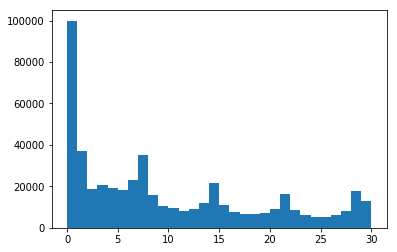

In [3]:
print('mean:', np.mean(delay))
print('variance:', np.var(delay))
plt.hist(delay, bins = range(31))
plt.show()

$\LARGE \mathbf {Model: Mixture\; of\; Poissons}$

The number of days that people make appointments in advance is a non-negative integer, and we can see from the previous
plot that there several peaks. The data appears to have some periodic patterns. For example, more
appointments are made exactly 1 week, 2 weeks or 3 weeks in advance. 
<br>
Therefore, we'll analyze the data with a Poisson Mixture Model. Specifically, suppose we have $K$ Poisson distributions (components)
with parameters $\lambda_{1},...,\lambda_{K}$ mixed together with
proportions $p_{1},...,p_{K}$. Let $\theta=(\lambda_{1},...,\lambda_{K},p_{1},...,p_{K})$,
then the likelihood is 
$$f(X|\theta)=\prod_{i=1}^{N}\sum_{k=1}^{K}p_{k}e^{-\lambda_{k}}\frac{\lambda_{k}^{X_{i}}}{X_{i}!}.$$

$\LARGE \mathbf {Inference: Frequentist\; and\; Bayesian}$

We'll start from a frequentist's point of view, and try to find the parameters that maximize the likelihood. Since it's hard to directly maximize the log-likelihood function, we'll use the Expectation-Maximization algorithm. After some derivations, we can update the parameters as follows:
$$\begin{align*}
q(k,i) & \leftarrow p_{k}Poisson(X_{i},\lambda_{k})\\
p(k|i) & \leftarrow\frac{q(k,i)}{\sum_{k=1}^{K}q(k,i)}\\
z(k) & \leftarrow\sum_{i=1}^{N}p(k|i)\\
p_{k} & \leftarrow\frac{z(k)}{N}\\
\lambda_{k} & \leftarrow\frac{\sum_{i=1}^{N}p(k|i)X_{i}}{z(k)}
\end{align*}$$

In [4]:
# EM Algorithm
def EM(K):
    pi_EM = np.ones(K) / K
    lam_EM = 30 * np.random.rand(K)
    q_EM = np.zeros([K, N])
    fact = factorial(delay)
    for _ in range(100):
        for i in range(K):
            for j in range(N):
                q_EM[i,j] = pi_EM[i] * lam_EM[i] ** delay[j] * fact[j] * np.exp(-lam_EM[i])
        q = np.tile(np.sum(q_EM, axis = 0), [K, 1]) 
        p = np.divide(q_EM, q)
        z = np.sum(p, axis = 1)
        pi_EM = z / N
        lam_EM = np.divide(p.dot(delay), z)
    return pi_EM, lam_EM, q_EM

In [5]:
pi_EM, lam_EM, q_EM = EM(4)
print('mixing proportion: ', pi_EM)
print('cluster mean: ', lam_EM)

mixing proportion:  [0.2907781  0.30589539 0.18488418 0.21844233]
cluster mean:  [ 0.3806142   5.5966074  13.54861448 23.57584699]


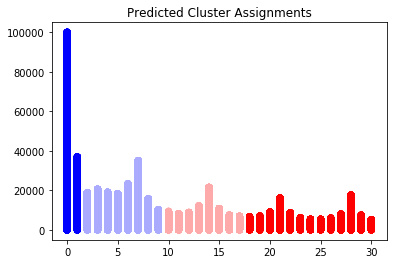

In [6]:
y = np.zeros(N)
for i in range (31):
    indices = [j for j, x in enumerate(delay) if x == i]
    values = [j for j in range (len(indices))]
    y[indices] = values
clusters = np.argmax(q_EM, 0)
plt.scatter(delay, y, c = clusters, cmap = cm.bwr)
plt.title("Predicted Cluster Assignments")
plt.show()

Now, we'll try to make inference from a Bayesian point of view. We'll start with variational inference. By expressing the mixture model in terms of missing data, we'll introduce
indicator parameters $z=(z_{ik};i=1,...,N;k=1,...,K\}$ such that
$z_{ik}=1$ if the $i$-th observation $X_{i}$ belongs to the $k$-th
component of the mixture and $z_{ik}=0$ otherwise. Thus the density
$f(X_{i}|z_{ik}=1)$ is Poisson($\lambda_{k}$) and $f(z_{ik}=1|p)=p_{k}$.
So we can now right the likelihood as 
$$f(X|\theta)=\sum_{z}\prod_{i=1}^{N}\prod_{k=1}^{K}Poisson(X_{i},\lambda_{k})^{z_{ik}}p_{k}^{z_{ik}}.$$
To start, we use a non-informative Dirichlet prior for $p's$, and Gamma priors with mean equal to $10$ for  $\lambda's$. As for the posteriors, we again use Dirichlet for  $p's$, and Gamma for $\lambda's$, and we use Categorical for $z's$.

In [7]:
#variational inference
K = 4
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_VI = Dirichlet(tf.nn.softplus(tf.get_variable("qpi_VI/params", [K])))
qlam_VI = Gamma(tf.nn.softplus(tf.get_variable("qlam_VI_concentration/params", [K])),tf.nn.softplus(tf.get_variable("qlam_VI_rate/params", [K])))
qz_VI = Categorical(logits = tf.get_variable("qz_VI/params", [N, K]))

inference = ed.KLqp({lam: qlam_VI, pi: qpi_VI, z: qz_VI}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(50):
    print(inference.update())

{'t': 1, 'loss': 3824319.2}
{'t': 2, 'loss': 9310017.0}
{'t': 3, 'loss': 7673544.0}
{'t': 4, 'loss': 4360588.5}
{'t': 5, 'loss': 3771862.2}
{'t': 6, 'loss': 6799496.5}
{'t': 7, 'loss': 5965464.5}
{'t': 8, 'loss': 9189034.0}
{'t': 9, 'loss': 5317875.0}
{'t': 10, 'loss': 4230428.5}
{'t': 11, 'loss': 6094873.0}
{'t': 12, 'loss': 7875601.5}
{'t': 13, 'loss': 5727591.5}
{'t': 14, 'loss': 5530808.0}
{'t': 15, 'loss': 4444696.0}
{'t': 16, 'loss': 10046391.0}
{'t': 17, 'loss': 4998967.0}
{'t': 18, 'loss': 4531191.5}
{'t': 19, 'loss': 4156914.8}
{'t': 20, 'loss': 3988024.5}
{'t': 21, 'loss': 3674508.0}
{'t': 22, 'loss': 9453749.0}
{'t': 23, 'loss': 7601876.0}
{'t': 24, 'loss': 6116250.0}
{'t': 25, 'loss': 4367730.0}
{'t': 26, 'loss': 4745351.5}
{'t': 27, 'loss': 7031167.0}
{'t': 28, 'loss': 7135942.0}
{'t': 29, 'loss': 3770257.5}
{'t': 30, 'loss': 24212860.0}
{'t': 31, 'loss': 5225614.5}
{'t': 32, 'loss': 5112018.0}
{'t': 33, 'loss': 6023961.5}
{'t': 34, 'loss': 3519958.2}
{'t': 35, 'loss': 445

As we can see, the problem is not as easy, and if we just do a simple variational inference using Edward
, then the loss doesn't converge. This is probably because the variance in BBVI is too large. So we can try to simplify the inference process by first fixing the mixing proportions. Specifically, we fix $p's$ to be the values inferred from the EM algorithm, and we set the Gamma priors of the $\lambda's$ so that the means are the same as what we get from the EM algorithm. 

In [8]:
#variational inference with fixed mixing proportions
pi = tf.constant([0.2907781, 0.30589539, 0.18488418, 0.21844233])
lam = Gamma([0.3806142, 5.5966074, 13.54861448, 23.57584699], [1.0, 1.0, 1.0, 1.0])

x = tf.gather(pi, 0)*Poisson(tf.gather(lam, 0), sample_shape = N)
for i in range (1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape = N)

qlam_fix = Gamma(tf.nn.softplus(tf.get_variable("qlam_fix_concentration/params", [K])),tf.nn.softplus(tf.get_variable("qlam_fix_rate/params", [K])))

inference = ed.KLqp({lam: qlam_fix}, data = {x: delay})
inference.initialize(optimizer = tf.train.AdamOptimizer(1e-2))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range (25000):
    print(inference.update())

{'t': 1, 'loss': 142.95291}
{'t': 2, 'loss': 73.38867}
{'t': 3, 'loss': 164.07121}
{'t': 4, 'loss': 122.43772}
{'t': 5, 'loss': 130.85371}
{'t': 6, 'loss': 53.525497}
{'t': 7, 'loss': 62.585323}
{'t': 8, 'loss': 120.7146}
{'t': 9, 'loss': 147.25111}
{'t': 10, 'loss': 185.54271}
{'t': 11, 'loss': 48.425346}
{'t': 12, 'loss': 94.27194}
{'t': 13, 'loss': 120.52632}
{'t': 14, 'loss': 151.44904}
{'t': 15, 'loss': 65.12589}
{'t': 16, 'loss': 293.71295}
{'t': 17, 'loss': 112.12618}
{'t': 18, 'loss': 125.9427}
{'t': 19, 'loss': 194.25523}
{'t': 20, 'loss': 179.79617}
{'t': 21, 'loss': 64.507454}
{'t': 22, 'loss': 86.05556}
{'t': 23, 'loss': 156.48367}
{'t': 24, 'loss': 61.789177}
{'t': 25, 'loss': 115.93747}
{'t': 26, 'loss': 89.894936}
{'t': 27, 'loss': 51.826683}
{'t': 28, 'loss': 153.62749}
{'t': 29, 'loss': 128.10751}
{'t': 30, 'loss': 80.87504}
{'t': 31, 'loss': 101.159676}
{'t': 32, 'loss': 94.18082}
{'t': 33, 'loss': 59.25396}
{'t': 34, 'loss': 56.387466}
{'t': 35, 'loss': 192.21825}
{'

{'t': 472, 'loss': 63.272446}
{'t': 473, 'loss': 24.866016}
{'t': 474, 'loss': 4.223959}
{'t': 475, 'loss': 53.380272}
{'t': 476, 'loss': 81.317345}
{'t': 477, 'loss': 24.231731}
{'t': 478, 'loss': 33.689434}
{'t': 479, 'loss': 71.05285}
{'t': 480, 'loss': 51.47831}
{'t': 481, 'loss': 33.698814}
{'t': 482, 'loss': 0.31436062}
{'t': 483, 'loss': 55.08233}
{'t': 484, 'loss': 101.37226}
{'t': 485, 'loss': 32.458668}
{'t': 486, 'loss': 58.740196}
{'t': 487, 'loss': 17.394289}
{'t': 488, 'loss': 18.612116}
{'t': 489, 'loss': 26.471075}
{'t': 490, 'loss': 10.785584}
{'t': 491, 'loss': 66.63623}
{'t': 492, 'loss': 27.945965}
{'t': 493, 'loss': 39.13488}
{'t': 494, 'loss': 32.243084}
{'t': 495, 'loss': 54.003304}
{'t': 496, 'loss': -6.89587}
{'t': 497, 'loss': 75.955795}
{'t': 498, 'loss': 110.41739}
{'t': 499, 'loss': 56.926632}
{'t': 500, 'loss': 36.770287}
{'t': 501, 'loss': 55.408146}
{'t': 502, 'loss': 35.432297}
{'t': 503, 'loss': 26.587221}
{'t': 504, 'loss': 97.05384}
{'t': 505, 'loss'

{'t': 1011, 'loss': 20.874033}
{'t': 1012, 'loss': -1.5234299}
{'t': 1013, 'loss': -3.3992844}
{'t': 1014, 'loss': 10.768814}
{'t': 1015, 'loss': 2.6747532}
{'t': 1016, 'loss': 8.538824}
{'t': 1017, 'loss': 22.1636}
{'t': 1018, 'loss': 19.346107}
{'t': 1019, 'loss': 12.542656}
{'t': 1020, 'loss': 34.05233}
{'t': 1021, 'loss': 70.093704}
{'t': 1022, 'loss': 9.871508}
{'t': 1023, 'loss': 9.152196}
{'t': 1024, 'loss': -2.509283}
{'t': 1025, 'loss': 19.304594}
{'t': 1026, 'loss': 76.75664}
{'t': 1027, 'loss': 2.4300413}
{'t': 1028, 'loss': 10.749012}
{'t': 1029, 'loss': 12.67762}
{'t': 1030, 'loss': 2.909287}
{'t': 1031, 'loss': 27.796078}
{'t': 1032, 'loss': 6.613969}
{'t': 1033, 'loss': 27.363235}
{'t': 1034, 'loss': 63.059517}
{'t': 1035, 'loss': 7.9635973}
{'t': 1036, 'loss': 8.505616}
{'t': 1037, 'loss': 4.7584457}
{'t': 1038, 'loss': 38.524055}
{'t': 1039, 'loss': 17.037832}
{'t': 1040, 'loss': 11.799185}
{'t': 1041, 'loss': 16.650055}
{'t': 1042, 'loss': 5.702157}
{'t': 1043, 'loss'

{'t': 1498, 'loss': 4.414627}
{'t': 1499, 'loss': 0.48049164}
{'t': 1500, 'loss': 45.355442}
{'t': 1501, 'loss': 8.394261}
{'t': 1502, 'loss': 21.60182}
{'t': 1503, 'loss': 27.894882}
{'t': 1504, 'loss': 5.5424213}
{'t': 1505, 'loss': 1.4718838}
{'t': 1506, 'loss': -0.6804476}
{'t': 1507, 'loss': 8.1955385}
{'t': 1508, 'loss': 0.5936527}
{'t': 1509, 'loss': 0.69133186}
{'t': 1510, 'loss': -2.5425282}
{'t': 1511, 'loss': 3.4075718}
{'t': 1512, 'loss': 46.264458}
{'t': 1513, 'loss': 61.022655}
{'t': 1514, 'loss': 15.05051}
{'t': 1515, 'loss': 3.8431053}
{'t': 1516, 'loss': -0.45736694}
{'t': 1517, 'loss': 2.002203}
{'t': 1518, 'loss': 6.0157614}
{'t': 1519, 'loss': 77.948586}
{'t': 1520, 'loss': 41.66919}
{'t': 1521, 'loss': 0.46612453}
{'t': 1522, 'loss': 1.779604}
{'t': 1523, 'loss': 9.888777}
{'t': 1524, 'loss': 5.541456}
{'t': 1525, 'loss': 21.753206}
{'t': 1526, 'loss': 13.46999}
{'t': 1527, 'loss': 19.075615}
{'t': 1528, 'loss': 10.020447}
{'t': 1529, 'loss': 0.78109837}
{'t': 1530

{'t': 1994, 'loss': 8.232262}
{'t': 1995, 'loss': 8.859421}
{'t': 1996, 'loss': 4.027458}
{'t': 1997, 'loss': 0.24945784}
{'t': 1998, 'loss': 3.356079}
{'t': 1999, 'loss': 6.529337}
{'t': 2000, 'loss': 3.853281}
{'t': 2001, 'loss': 28.583775}
{'t': 2002, 'loss': 9.715888}
{'t': 2003, 'loss': 0.5653057}
{'t': 2004, 'loss': 8.173645}
{'t': 2005, 'loss': 0.048251152}
{'t': 2006, 'loss': 0.055325508}
{'t': 2007, 'loss': 23.027023}
{'t': 2008, 'loss': 15.039783}
{'t': 2009, 'loss': 0.054777145}
{'t': 2010, 'loss': 27.754494}
{'t': 2011, 'loss': 0.6697941}
{'t': 2012, 'loss': 0.85867214}
{'t': 2013, 'loss': 3.2328691}
{'t': 2014, 'loss': 26.907196}
{'t': 2015, 'loss': 24.158255}
{'t': 2016, 'loss': 4.6201057}
{'t': 2017, 'loss': 8.671719}
{'t': 2018, 'loss': 5.3000183}
{'t': 2019, 'loss': 15.002762}
{'t': 2020, 'loss': 28.507511}
{'t': 2021, 'loss': 26.05174}
{'t': 2022, 'loss': 8.029552}
{'t': 2023, 'loss': -2.0520325}
{'t': 2024, 'loss': 12.520629}
{'t': 2025, 'loss': -1.2808666}
{'t': 202

{'t': 2474, 'loss': 11.180901}
{'t': 2475, 'loss': 3.832345}
{'t': 2476, 'loss': 9.177905}
{'t': 2477, 'loss': 8.685711}
{'t': 2478, 'loss': -1.6535921}
{'t': 2479, 'loss': -2.7404656}
{'t': 2480, 'loss': 9.804033}
{'t': 2481, 'loss': -0.6811352}
{'t': 2482, 'loss': -1.575738}
{'t': 2483, 'loss': -1.0361481}
{'t': 2484, 'loss': -2.9011059}
{'t': 2485, 'loss': 2.5760727}
{'t': 2486, 'loss': 0.35128975}
{'t': 2487, 'loss': 13.606738}
{'t': 2488, 'loss': -1.0228367}
{'t': 2489, 'loss': 13.449242}
{'t': 2490, 'loss': 13.68601}
{'t': 2491, 'loss': 55.93914}
{'t': 2492, 'loss': 20.776789}
{'t': 2493, 'loss': 8.786167}
{'t': 2494, 'loss': 10.311388}
{'t': 2495, 'loss': 9.809479}
{'t': 2496, 'loss': -0.04798889}
{'t': 2497, 'loss': 1.85569}
{'t': 2498, 'loss': 5.8990345}
{'t': 2499, 'loss': 8.274389}
{'t': 2500, 'loss': 7.03969}
{'t': 2501, 'loss': 2.0063744}
{'t': 2502, 'loss': 9.617657}
{'t': 2503, 'loss': 17.333118}
{'t': 2504, 'loss': -1.9423962}
{'t': 2505, 'loss': 0.39145947}
{'t': 2506,

{'t': 2938, 'loss': 19.253191}
{'t': 2939, 'loss': -0.7865896}
{'t': 2940, 'loss': 4.1773434}
{'t': 2941, 'loss': -1.2388973}
{'t': 2942, 'loss': 1.0548553}
{'t': 2943, 'loss': 1.5791368}
{'t': 2944, 'loss': -1.7023916}
{'t': 2945, 'loss': -0.9767275}
{'t': 2946, 'loss': 0.28163147}
{'t': 2947, 'loss': -0.21140862}
{'t': 2948, 'loss': 0.04254055}
{'t': 2949, 'loss': 6.77047}
{'t': 2950, 'loss': 22.280937}
{'t': 2951, 'loss': 11.671225}
{'t': 2952, 'loss': 2.6436806}
{'t': 2953, 'loss': 16.428984}
{'t': 2954, 'loss': 7.4522877}
{'t': 2955, 'loss': 3.362032}
{'t': 2956, 'loss': 21.960087}
{'t': 2957, 'loss': 5.0713453}
{'t': 2958, 'loss': 2.8937092}
{'t': 2959, 'loss': 12.555321}
{'t': 2960, 'loss': -0.121928215}
{'t': 2961, 'loss': -0.2053709}
{'t': 2962, 'loss': 23.69418}
{'t': 2963, 'loss': 3.4146423}
{'t': 2964, 'loss': 5.2573366}
{'t': 2965, 'loss': -1.855032}
{'t': 2966, 'loss': 5.2731256}
{'t': 2967, 'loss': 2.4946375}
{'t': 2968, 'loss': 5.1168203}
{'t': 2969, 'loss': 22.001045}


{'t': 3419, 'loss': 4.182478}
{'t': 3420, 'loss': 1.2374105}
{'t': 3421, 'loss': 8.572324}
{'t': 3422, 'loss': 9.511386}
{'t': 3423, 'loss': 21.46453}
{'t': 3424, 'loss': 20.532263}
{'t': 3425, 'loss': 5.5615625}
{'t': 3426, 'loss': 29.997149}
{'t': 3427, 'loss': -2.2927713}
{'t': 3428, 'loss': 12.094911}
{'t': 3429, 'loss': 12.025768}
{'t': 3430, 'loss': 32.77324}
{'t': 3431, 'loss': 25.037563}
{'t': 3432, 'loss': 14.662651}
{'t': 3433, 'loss': 0.16113377}
{'t': 3434, 'loss': -0.5143614}
{'t': 3435, 'loss': -0.06955242}
{'t': 3436, 'loss': 2.8926754}
{'t': 3437, 'loss': 12.730679}
{'t': 3438, 'loss': -1.3524532}
{'t': 3439, 'loss': 6.9101887}
{'t': 3440, 'loss': 10.347915}
{'t': 3441, 'loss': 2.8957682}
{'t': 3442, 'loss': 0.6554384}
{'t': 3443, 'loss': 0.029348373}
{'t': 3444, 'loss': -0.10373783}
{'t': 3445, 'loss': 20.186802}
{'t': 3446, 'loss': 6.2067623}
{'t': 3447, 'loss': 3.2449017}
{'t': 3448, 'loss': 4.9802294}
{'t': 3449, 'loss': 9.587818}
{'t': 3450, 'loss': 2.643425}
{'t':

{'t': 3912, 'loss': 1.106122}
{'t': 3913, 'loss': -1.0458326}
{'t': 3914, 'loss': 4.0516386}
{'t': 3915, 'loss': 23.4219}
{'t': 3916, 'loss': -0.41282272}
{'t': 3917, 'loss': 3.07193}
{'t': 3918, 'loss': 3.3058195}
{'t': 3919, 'loss': 1.6105776}
{'t': 3920, 'loss': 9.822257}
{'t': 3921, 'loss': 0.2618189}
{'t': 3922, 'loss': 3.8650331}
{'t': 3923, 'loss': 14.895181}
{'t': 3924, 'loss': 11.489256}
{'t': 3925, 'loss': -1.5029325}
{'t': 3926, 'loss': 1.8853302}
{'t': 3927, 'loss': 2.3182812}
{'t': 3928, 'loss': 15.777591}
{'t': 3929, 'loss': 0.32666588}
{'t': 3930, 'loss': 32.59212}
{'t': 3931, 'loss': 1.6558428}
{'t': 3932, 'loss': 16.196505}
{'t': 3933, 'loss': 5.334959}
{'t': 3934, 'loss': 23.732481}
{'t': 3935, 'loss': -0.9268789}
{'t': 3936, 'loss': -2.9596276}
{'t': 3937, 'loss': 10.892122}
{'t': 3938, 'loss': 10.06993}
{'t': 3939, 'loss': 9.695997}
{'t': 3940, 'loss': 1.8995085}
{'t': 3941, 'loss': 5.426072}
{'t': 3942, 'loss': -1.3761902}
{'t': 3943, 'loss': 15.837211}
{'t': 3944,

{'t': 4404, 'loss': 2.5859966}
{'t': 4405, 'loss': -0.17631912}
{'t': 4406, 'loss': 8.432165}
{'t': 4407, 'loss': 0.83422613}
{'t': 4408, 'loss': 2.3491564}
{'t': 4409, 'loss': 44.697548}
{'t': 4410, 'loss': 22.27824}
{'t': 4411, 'loss': 8.880419}
{'t': 4412, 'loss': 2.8061724}
{'t': 4413, 'loss': 5.448324}
{'t': 4414, 'loss': 8.818308}
{'t': 4415, 'loss': 28.362896}
{'t': 4416, 'loss': 0.042214394}
{'t': 4417, 'loss': 2.46146}
{'t': 4418, 'loss': 2.122013}
{'t': 4419, 'loss': 0.03960657}
{'t': 4420, 'loss': -0.37992477}
{'t': 4421, 'loss': 0.5952358}
{'t': 4422, 'loss': 2.1294441}
{'t': 4423, 'loss': -0.26208496}
{'t': 4424, 'loss': 0.5355129}
{'t': 4425, 'loss': 5.3418074}
{'t': 4426, 'loss': 12.857439}
{'t': 4427, 'loss': 0.19709873}
{'t': 4428, 'loss': 4.7112513}
{'t': 4429, 'loss': 7.9103966}
{'t': 4430, 'loss': 0.81191635}
{'t': 4431, 'loss': -0.23557568}
{'t': 4432, 'loss': -0.29270458}
{'t': 4433, 'loss': 3.401372}
{'t': 4434, 'loss': 9.032809}
{'t': 4435, 'loss': 1.10011}
{'t'

{'t': 4898, 'loss': 0.24807072}
{'t': 4899, 'loss': 1.166255}
{'t': 4900, 'loss': -0.86643505}
{'t': 4901, 'loss': -1.6880178}
{'t': 4902, 'loss': -1.6796792}
{'t': 4903, 'loss': 8.333784}
{'t': 4904, 'loss': 1.1827717}
{'t': 4905, 'loss': 4.7708635}
{'t': 4906, 'loss': -0.52154064}
{'t': 4907, 'loss': 23.792809}
{'t': 4908, 'loss': -2.291408}
{'t': 4909, 'loss': 0.6023598}
{'t': 4910, 'loss': 15.482947}
{'t': 4911, 'loss': 12.432442}
{'t': 4912, 'loss': -0.5541537}
{'t': 4913, 'loss': -0.36655617}
{'t': 4914, 'loss': -1.0100536}
{'t': 4915, 'loss': 17.538887}
{'t': 4916, 'loss': 15.106776}
{'t': 4917, 'loss': 5.1478806}
{'t': 4918, 'loss': 0.52166843}
{'t': 4919, 'loss': 5.4341736}
{'t': 4920, 'loss': 0.1674614}
{'t': 4921, 'loss': 13.548004}
{'t': 4922, 'loss': 1.2236319}
{'t': 4923, 'loss': 3.683673}
{'t': 4924, 'loss': 3.7894}
{'t': 4925, 'loss': 4.1894293}
{'t': 4926, 'loss': 2.6665154}
{'t': 4927, 'loss': 3.7419357}
{'t': 4928, 'loss': 1.2142591}
{'t': 4929, 'loss': 0.0019302368}

{'t': 5302, 'loss': -0.42167664}
{'t': 5303, 'loss': 14.370884}
{'t': 5304, 'loss': 7.961132}
{'t': 5305, 'loss': -1.3396721}
{'t': 5306, 'loss': -0.4554062}
{'t': 5307, 'loss': 3.1815643}
{'t': 5308, 'loss': 2.4250736}
{'t': 5309, 'loss': -0.27949905}
{'t': 5310, 'loss': 0.2501917}
{'t': 5311, 'loss': 1.1610823}
{'t': 5312, 'loss': -1.2283802}
{'t': 5313, 'loss': 1.747963}
{'t': 5314, 'loss': 1.3792896}
{'t': 5315, 'loss': 4.6080713}
{'t': 5316, 'loss': -1.1563568}
{'t': 5317, 'loss': 4.342202}
{'t': 5318, 'loss': 9.73389}
{'t': 5319, 'loss': 2.4061809}
{'t': 5320, 'loss': -0.79234314}
{'t': 5321, 'loss': -0.6927881}
{'t': 5322, 'loss': 1.0409546}
{'t': 5323, 'loss': -0.46609688}
{'t': 5324, 'loss': 5.8011923}
{'t': 5325, 'loss': 4.808057}
{'t': 5326, 'loss': 9.653891}
{'t': 5327, 'loss': 8.911982}
{'t': 5328, 'loss': 6.493186}
{'t': 5329, 'loss': -0.40663671}
{'t': 5330, 'loss': -0.5012913}
{'t': 5331, 'loss': 1.8329058}
{'t': 5332, 'loss': 4.357939}
{'t': 5333, 'loss': 1.8426123}
{'

{'t': 5709, 'loss': 10.112933}
{'t': 5710, 'loss': 0.08694458}
{'t': 5711, 'loss': -1.0730743}
{'t': 5712, 'loss': 0.42101574}
{'t': 5713, 'loss': 2.491456}
{'t': 5714, 'loss': 2.8104668}
{'t': 5715, 'loss': 4.152604}
{'t': 5716, 'loss': 6.807766}
{'t': 5717, 'loss': 14.479841}
{'t': 5718, 'loss': 8.259827}
{'t': 5719, 'loss': 19.263588}
{'t': 5720, 'loss': 1.9557753}
{'t': 5721, 'loss': -1.100523}
{'t': 5722, 'loss': 1.8547993}
{'t': 5723, 'loss': -1.4300961}
{'t': 5724, 'loss': 4.980216}
{'t': 5725, 'loss': -1.5409856}
{'t': 5726, 'loss': 0.93083096}
{'t': 5727, 'loss': 2.8767958}
{'t': 5728, 'loss': -0.6661558}
{'t': 5729, 'loss': 0.8081889}
{'t': 5730, 'loss': -0.46351624}
{'t': 5731, 'loss': 1.2441354}
{'t': 5732, 'loss': 6.7497654}
{'t': 5733, 'loss': -0.39968014}
{'t': 5734, 'loss': 9.401755}
{'t': 5735, 'loss': 4.6238365}
{'t': 5736, 'loss': 8.120096}
{'t': 5737, 'loss': -1.7485418}
{'t': 5738, 'loss': 1.7701416}
{'t': 5739, 'loss': -0.16532278}
{'t': 5740, 'loss': 8.344032}
{'

{'t': 6247, 'loss': 2.1843958}
{'t': 6248, 'loss': 2.8193746}
{'t': 6249, 'loss': 3.753519}
{'t': 6250, 'loss': 24.546806}
{'t': 6251, 'loss': 0.3756733}
{'t': 6252, 'loss': 1.786787}
{'t': 6253, 'loss': 15.754621}
{'t': 6254, 'loss': 4.015872}
{'t': 6255, 'loss': 0.85894966}
{'t': 6256, 'loss': 1.6775837}
{'t': 6257, 'loss': 1.5658321}
{'t': 6258, 'loss': 2.2546263}
{'t': 6259, 'loss': -0.6785259}
{'t': 6260, 'loss': 1.7029595}
{'t': 6261, 'loss': 4.115303}
{'t': 6262, 'loss': 0.22424984}
{'t': 6263, 'loss': 0.009111643}
{'t': 6264, 'loss': 14.357664}
{'t': 6265, 'loss': 4.133522}
{'t': 6266, 'loss': 12.108307}
{'t': 6267, 'loss': 10.013379}
{'t': 6268, 'loss': 2.72645}
{'t': 6269, 'loss': -1.8494854}
{'t': 6270, 'loss': 13.081978}
{'t': 6271, 'loss': -1.998724}
{'t': 6272, 'loss': -0.8424206}
{'t': 6273, 'loss': 2.823657}
{'t': 6274, 'loss': 3.2411041}
{'t': 6275, 'loss': 0.43830776}
{'t': 6276, 'loss': -0.50107384}
{'t': 6277, 'loss': -1.0814366}
{'t': 6278, 'loss': 1.5522223}
{'t':

{'t': 6722, 'loss': 3.3760204}
{'t': 6723, 'loss': -0.4483192}
{'t': 6724, 'loss': 2.9618073}
{'t': 6725, 'loss': 3.5486689}
{'t': 6726, 'loss': 8.18825}
{'t': 6727, 'loss': 6.3269033}
{'t': 6728, 'loss': 5.6921062}
{'t': 6729, 'loss': -0.963851}
{'t': 6730, 'loss': -1.4309239}
{'t': 6731, 'loss': -1.4037199}
{'t': 6732, 'loss': -0.015091896}
{'t': 6733, 'loss': 0.17203331}
{'t': 6734, 'loss': 17.879177}
{'t': 6735, 'loss': 11.438282}
{'t': 6736, 'loss': 2.392933}
{'t': 6737, 'loss': -0.9607129}
{'t': 6738, 'loss': 9.698321}
{'t': 6739, 'loss': 1.2650824}
{'t': 6740, 'loss': 2.4973478}
{'t': 6741, 'loss': 0.084854126}
{'t': 6742, 'loss': -0.13593674}
{'t': 6743, 'loss': 1.1533532}
{'t': 6744, 'loss': -1.1455078}
{'t': 6745, 'loss': -0.95518374}
{'t': 6746, 'loss': 2.4930305}
{'t': 6747, 'loss': -0.76778555}
{'t': 6748, 'loss': 0.86903286}
{'t': 6749, 'loss': -1.2345858}
{'t': 6750, 'loss': -1.3621416}
{'t': 6751, 'loss': 21.645302}
{'t': 6752, 'loss': -1.3767748}
{'t': 6753, 'loss': -0

{'t': 7220, 'loss': 4.338888}
{'t': 7221, 'loss': 13.045225}
{'t': 7222, 'loss': 7.410289}
{'t': 7223, 'loss': 7.221545}
{'t': 7224, 'loss': 8.384737}
{'t': 7225, 'loss': -0.029312134}
{'t': 7226, 'loss': -0.9697914}
{'t': 7227, 'loss': 4.3946733}
{'t': 7228, 'loss': -0.2584381}
{'t': 7229, 'loss': 0.18031979}
{'t': 7230, 'loss': 2.1089}
{'t': 7231, 'loss': -1.7576332}
{'t': 7232, 'loss': -0.3054552}
{'t': 7233, 'loss': -1.2989426}
{'t': 7234, 'loss': 0.3046589}
{'t': 7235, 'loss': 2.320056}
{'t': 7236, 'loss': -1.3630977}
{'t': 7237, 'loss': -1.2616825}
{'t': 7238, 'loss': 1.1328888}
{'t': 7239, 'loss': 6.162898}
{'t': 7240, 'loss': 8.161163}
{'t': 7241, 'loss': 6.785388}
{'t': 7242, 'loss': -2.0360577}
{'t': 7243, 'loss': 3.201046}
{'t': 7244, 'loss': 0.94837856}
{'t': 7245, 'loss': -1.1797714}
{'t': 7246, 'loss': 1.0244999}
{'t': 7247, 'loss': 1.7912827}
{'t': 7248, 'loss': -0.39375114}
{'t': 7249, 'loss': 1.3172693}
{'t': 7250, 'loss': -1.180201}
{'t': 7251, 'loss': -0.83421135}
{'

{'t': 7492, 'loss': 1.110198}
{'t': 7493, 'loss': -0.049224854}
{'t': 7494, 'loss': 7.7777643}
{'t': 7495, 'loss': -1.6126657}
{'t': 7496, 'loss': -0.6677971}
{'t': 7497, 'loss': 2.9274292}
{'t': 7498, 'loss': 6.641489}
{'t': 7499, 'loss': 22.308027}
{'t': 7500, 'loss': -0.36029053}
{'t': 7501, 'loss': 10.328747}
{'t': 7502, 'loss': 0.15141964}
{'t': 7503, 'loss': -0.37768173}
{'t': 7504, 'loss': 0.58487797}
{'t': 7505, 'loss': -0.13825893}
{'t': 7506, 'loss': 0.3185873}
{'t': 7507, 'loss': 3.1470652}
{'t': 7508, 'loss': 6.297121}
{'t': 7509, 'loss': 5.755642}
{'t': 7510, 'loss': -1.0284877}
{'t': 7511, 'loss': 0.5755863}
{'t': 7512, 'loss': 2.9519567}
{'t': 7513, 'loss': -1.231883}
{'t': 7514, 'loss': -0.7957096}
{'t': 7515, 'loss': -0.25444984}
{'t': 7516, 'loss': 3.2559547}
{'t': 7517, 'loss': -0.7073941}
{'t': 7518, 'loss': -1.5739636}
{'t': 7519, 'loss': -0.5203779}
{'t': 7520, 'loss': -1.4085317}
{'t': 7521, 'loss': 0.9039531}
{'t': 7522, 'loss': 2.3333797}
{'t': 7523, 'loss': -0

{'t': 8027, 'loss': 7.0502214}
{'t': 8028, 'loss': 4.9232364}
{'t': 8029, 'loss': 0.124436855}
{'t': 8030, 'loss': -1.6598959}
{'t': 8031, 'loss': 0.32540846}
{'t': 8032, 'loss': 2.6951694}
{'t': 8033, 'loss': 0.051668167}
{'t': 8034, 'loss': 1.6301003}
{'t': 8035, 'loss': 0.6165714}
{'t': 8036, 'loss': 0.5848193}
{'t': 8037, 'loss': -0.3397398}
{'t': 8038, 'loss': 14.537842}
{'t': 8039, 'loss': -0.1225729}
{'t': 8040, 'loss': 0.507143}
{'t': 8041, 'loss': -0.38855267}
{'t': 8042, 'loss': -1.1091523}
{'t': 8043, 'loss': 1.2758207}
{'t': 8044, 'loss': 3.5906668}
{'t': 8045, 'loss': -1.5251346}
{'t': 8046, 'loss': 0.52217484}
{'t': 8047, 'loss': -1.4350924}
{'t': 8048, 'loss': 0.617373}
{'t': 8049, 'loss': 1.3015752}
{'t': 8050, 'loss': -0.8206072}
{'t': 8051, 'loss': 1.7673178}
{'t': 8052, 'loss': 1.5730314}
{'t': 8053, 'loss': -0.0843606}
{'t': 8054, 'loss': -1.1132221}
{'t': 8055, 'loss': 12.159447}
{'t': 8056, 'loss': 4.203347}
{'t': 8057, 'loss': -0.28452015}
{'t': 8058, 'loss': 0.7

{'t': 8516, 'loss': -1.232769}
{'t': 8517, 'loss': -1.3049364}
{'t': 8518, 'loss': 2.9379234}
{'t': 8519, 'loss': 2.1532068}
{'t': 8520, 'loss': 3.1656961}
{'t': 8521, 'loss': 1.9548035}
{'t': 8522, 'loss': 5.1227922}
{'t': 8523, 'loss': 4.1086664}
{'t': 8524, 'loss': 1.6520176}
{'t': 8525, 'loss': 3.413416}
{'t': 8526, 'loss': 6.027557}
{'t': 8527, 'loss': 2.2211819}
{'t': 8528, 'loss': 14.764111}
{'t': 8529, 'loss': 0.4490795}
{'t': 8530, 'loss': 2.6863642}
{'t': 8531, 'loss': 4.505046}
{'t': 8532, 'loss': 5.0336924}
{'t': 8533, 'loss': 1.6818027}
{'t': 8534, 'loss': -0.8915386}
{'t': 8535, 'loss': -0.7068567}
{'t': 8536, 'loss': 0.99856186}
{'t': 8537, 'loss': 5.8166256}
{'t': 8538, 'loss': -1.6863098}
{'t': 8539, 'loss': 1.0411124}
{'t': 8540, 'loss': 1.3191414}
{'t': 8541, 'loss': 3.5656033}
{'t': 8542, 'loss': 1.5911059}
{'t': 8543, 'loss': 6.3795557}
{'t': 8544, 'loss': -0.74294615}
{'t': 8545, 'loss': 0.47203445}
{'t': 8546, 'loss': 8.462974}
{'t': 8547, 'loss': 1.8105297}
{'t'

{'t': 8881, 'loss': 3.630392}
{'t': 8882, 'loss': 2.954155}
{'t': 8883, 'loss': 8.664759}
{'t': 8884, 'loss': -0.4790268}
{'t': 8885, 'loss': 1.1250377}
{'t': 8886, 'loss': 0.9004507}
{'t': 8887, 'loss': 1.031085}
{'t': 8888, 'loss': 0.47697926}
{'t': 8889, 'loss': 0.8325634}
{'t': 8890, 'loss': 2.278956}
{'t': 8891, 'loss': 2.0791817}
{'t': 8892, 'loss': 7.724262}
{'t': 8893, 'loss': 3.5719337}
{'t': 8894, 'loss': -0.3871708}
{'t': 8895, 'loss': 3.408823}
{'t': 8896, 'loss': -1.5434427}
{'t': 8897, 'loss': 0.41513062}
{'t': 8898, 'loss': -0.4319296}
{'t': 8899, 'loss': 1.959034}
{'t': 8900, 'loss': 7.319336}
{'t': 8901, 'loss': 0.5021105}
{'t': 8902, 'loss': 1.6154413}
{'t': 8903, 'loss': 1.7488737}
{'t': 8904, 'loss': -0.5540247}
{'t': 8905, 'loss': 4.2683887}
{'t': 8906, 'loss': -1.1618052}
{'t': 8907, 'loss': 2.711443}
{'t': 8908, 'loss': 8.944396}
{'t': 8909, 'loss': -1.0973687}
{'t': 8910, 'loss': 1.2423925}
{'t': 8911, 'loss': 2.3773413}
{'t': 8912, 'loss': -0.50866413}
{'t': 89

{'t': 9299, 'loss': 2.7487059}
{'t': 9300, 'loss': 0.123571396}
{'t': 9301, 'loss': -0.6105919}
{'t': 9302, 'loss': -0.24472237}
{'t': 9303, 'loss': 6.4129677}
{'t': 9304, 'loss': -0.22851658}
{'t': 9305, 'loss': 1.6388884}
{'t': 9306, 'loss': 2.381588}
{'t': 9307, 'loss': -0.42792988}
{'t': 9308, 'loss': -0.99721336}
{'t': 9309, 'loss': -0.32020187}
{'t': 9310, 'loss': -0.9310255}
{'t': 9311, 'loss': 6.3129}
{'t': 9312, 'loss': 0.5934439}
{'t': 9313, 'loss': 4.9166985}
{'t': 9314, 'loss': 0.06615925}
{'t': 9315, 'loss': -1.2565744}
{'t': 9316, 'loss': -1.1145024}
{'t': 9317, 'loss': -0.60151935}
{'t': 9318, 'loss': 4.8251834}
{'t': 9319, 'loss': 1.9632001}
{'t': 9320, 'loss': 8.838034}
{'t': 9321, 'loss': 2.5304542}
{'t': 9322, 'loss': 0.02292633}
{'t': 9323, 'loss': 0.0884161}
{'t': 9324, 'loss': 5.4159136}
{'t': 9325, 'loss': 3.1795502}
{'t': 9326, 'loss': 1.0481343}
{'t': 9327, 'loss': 0.083758354}
{'t': 9328, 'loss': -1.1550808}
{'t': 9329, 'loss': 0.5566845}
{'t': 9330, 'loss': 0

{'t': 9787, 'loss': -1.2456288}
{'t': 9788, 'loss': 0.25573826}
{'t': 9789, 'loss': 0.375175}
{'t': 9790, 'loss': -0.825336}
{'t': 9791, 'loss': 1.213541}
{'t': 9792, 'loss': 2.873157}
{'t': 9793, 'loss': 0.5589533}
{'t': 9794, 'loss': 2.0678205}
{'t': 9795, 'loss': 0.7798643}
{'t': 9796, 'loss': -0.16820908}
{'t': 9797, 'loss': 0.69076395}
{'t': 9798, 'loss': 2.6977444}
{'t': 9799, 'loss': -0.18841934}
{'t': 9800, 'loss': -1.4522815}
{'t': 9801, 'loss': -0.49786854}
{'t': 9802, 'loss': -0.020915031}
{'t': 9803, 'loss': 3.879161}
{'t': 9804, 'loss': -1.3170943}
{'t': 9805, 'loss': 6.5338373}
{'t': 9806, 'loss': -0.7612219}
{'t': 9807, 'loss': -0.23357487}
{'t': 9808, 'loss': -1.3125238}
{'t': 9809, 'loss': 0.31530046}
{'t': 9810, 'loss': -1.203752}
{'t': 9811, 'loss': 1.1620874}
{'t': 9812, 'loss': 3.5286665}
{'t': 9813, 'loss': -0.59714794}
{'t': 9814, 'loss': 3.1734428}
{'t': 9815, 'loss': -0.2176857}
{'t': 9816, 'loss': 0.21100426}
{'t': 9817, 'loss': 1.6788273}
{'t': 9818, 'loss': 

{'t': 10065, 'loss': 0.29603767}
{'t': 10066, 'loss': 3.1571436}
{'t': 10067, 'loss': -0.30428886}
{'t': 10068, 'loss': -0.87344885}
{'t': 10069, 'loss': 0.36256027}
{'t': 10070, 'loss': 2.4472075}
{'t': 10071, 'loss': 3.6105165}
{'t': 10072, 'loss': 3.608531}
{'t': 10073, 'loss': -0.201828}
{'t': 10074, 'loss': -0.28677225}
{'t': 10075, 'loss': -0.043928146}
{'t': 10076, 'loss': 2.8773966}
{'t': 10077, 'loss': 2.6071286}
{'t': 10078, 'loss': -0.78974104}
{'t': 10079, 'loss': 0.17063904}
{'t': 10080, 'loss': -1.2299542}
{'t': 10081, 'loss': 10.495302}
{'t': 10082, 'loss': 4.700941}
{'t': 10083, 'loss': -1.3645496}
{'t': 10084, 'loss': 3.133006}
{'t': 10085, 'loss': 3.4402447}
{'t': 10086, 'loss': -1.1891651}
{'t': 10087, 'loss': 3.5531893}
{'t': 10088, 'loss': -0.9802275}
{'t': 10089, 'loss': -0.7402029}
{'t': 10090, 'loss': 1.7015476}
{'t': 10091, 'loss': -0.59689474}
{'t': 10092, 'loss': 1.3372517}
{'t': 10093, 'loss': 1.2670717}
{'t': 10094, 'loss': 4.732938}
{'t': 10095, 'loss': 3.

{'t': 10567, 'loss': 0.1167717}
{'t': 10568, 'loss': -0.38369274}
{'t': 10569, 'loss': 0.42005253}
{'t': 10570, 'loss': 2.5168228}
{'t': 10571, 'loss': 4.774643}
{'t': 10572, 'loss': 3.4905157}
{'t': 10573, 'loss': 0.34843683}
{'t': 10574, 'loss': 0.10420513}
{'t': 10575, 'loss': -0.37557936}
{'t': 10576, 'loss': 1.7720222}
{'t': 10577, 'loss': 1.3307924}
{'t': 10578, 'loss': 8.979702}
{'t': 10579, 'loss': 0.36756372}
{'t': 10580, 'loss': 2.8384438}
{'t': 10581, 'loss': 3.3638139}
{'t': 10582, 'loss': -1.3407507}
{'t': 10583, 'loss': -1.4735203}
{'t': 10584, 'loss': 3.0630932}
{'t': 10585, 'loss': 1.3885593}
{'t': 10586, 'loss': -0.16302872}
{'t': 10587, 'loss': 1.8172245}
{'t': 10588, 'loss': 1.2427397}
{'t': 10589, 'loss': 0.12983322}
{'t': 10590, 'loss': 0.9905691}
{'t': 10591, 'loss': 7.8758373}
{'t': 10592, 'loss': -0.1724329}
{'t': 10593, 'loss': 0.5231104}
{'t': 10594, 'loss': 3.65061}
{'t': 10595, 'loss': 6.823017}
{'t': 10596, 'loss': -0.967782}
{'t': 10597, 'loss': 4.2124066}

{'t': 10848, 'loss': 0.89980316}
{'t': 10849, 'loss': -0.640645}
{'t': 10850, 'loss': 3.4277716}
{'t': 10851, 'loss': 0.81012726}
{'t': 10852, 'loss': 2.244175}
{'t': 10853, 'loss': 0.6509886}
{'t': 10854, 'loss': -0.80279064}
{'t': 10855, 'loss': -0.6986122}
{'t': 10856, 'loss': 4.4827003}
{'t': 10857, 'loss': -0.978672}
{'t': 10858, 'loss': -0.021637917}
{'t': 10859, 'loss': -0.7381773}
{'t': 10860, 'loss': -0.74907637}
{'t': 10861, 'loss': -0.9711895}
{'t': 10862, 'loss': -0.9461889}
{'t': 10863, 'loss': 1.7485943}
{'t': 10864, 'loss': -0.052721024}
{'t': 10865, 'loss': -0.65942144}
{'t': 10866, 'loss': -0.33418036}
{'t': 10867, 'loss': 0.3702793}
{'t': 10868, 'loss': 0.8525753}
{'t': 10869, 'loss': 2.3199272}
{'t': 10870, 'loss': 0.16644955}
{'t': 10871, 'loss': -0.4511652}
{'t': 10872, 'loss': 0.45991135}
{'t': 10873, 'loss': 1.8456001}
{'t': 10874, 'loss': 2.664052}
{'t': 10875, 'loss': 2.340067}
{'t': 10876, 'loss': -0.42539692}
{'t': 10877, 'loss': -0.70341015}
{'t': 10878, 'lo

{'t': 11289, 'loss': 1.1711888}
{'t': 11290, 'loss': 3.4268618}
{'t': 11291, 'loss': -0.5950341}
{'t': 11292, 'loss': -0.28372955}
{'t': 11293, 'loss': -0.33926105}
{'t': 11294, 'loss': -1.0916867}
{'t': 11295, 'loss': 1.8117847}
{'t': 11296, 'loss': -0.56091595}
{'t': 11297, 'loss': 0.13994074}
{'t': 11298, 'loss': -0.6359992}
{'t': 11299, 'loss': 0.21978378}
{'t': 11300, 'loss': 0.09769821}
{'t': 11301, 'loss': -0.47708893}
{'t': 11302, 'loss': 3.4105377}
{'t': 11303, 'loss': 3.2405667}
{'t': 11304, 'loss': -0.94298553}
{'t': 11305, 'loss': -0.20699883}
{'t': 11306, 'loss': 4.1735897}
{'t': 11307, 'loss': 0.9387121}
{'t': 11308, 'loss': 1.2270212}
{'t': 11309, 'loss': 0.042617798}
{'t': 11310, 'loss': -0.05659771}
{'t': 11311, 'loss': 2.2719955}
{'t': 11312, 'loss': -0.14058304}
{'t': 11313, 'loss': -0.6533003}
{'t': 11314, 'loss': 1.6252022}
{'t': 11315, 'loss': -1.0840688}
{'t': 11316, 'loss': 3.691001}
{'t': 11317, 'loss': -1.2579994}
{'t': 11318, 'loss': -0.7088227}
{'t': 11319, 

{'t': 11550, 'loss': 0.23296738}
{'t': 11551, 'loss': 2.6512804}
{'t': 11552, 'loss': -0.54596615}
{'t': 11553, 'loss': -0.6134615}
{'t': 11554, 'loss': -0.5182142}
{'t': 11555, 'loss': 8.802167}
{'t': 11556, 'loss': -0.1405282}
{'t': 11557, 'loss': -0.157866}
{'t': 11558, 'loss': -0.76407385}
{'t': 11559, 'loss': -1.0240316}
{'t': 11560, 'loss': 3.7986364}
{'t': 11561, 'loss': 5.463086}
{'t': 11562, 'loss': -0.67803717}
{'t': 11563, 'loss': 1.5065203}
{'t': 11564, 'loss': -0.29839802}
{'t': 11565, 'loss': 2.0760155}
{'t': 11566, 'loss': 0.40517616}
{'t': 11567, 'loss': 5.595979}
{'t': 11568, 'loss': 0.36249638}
{'t': 11569, 'loss': -0.7315378}
{'t': 11570, 'loss': 1.0997095}
{'t': 11571, 'loss': -0.79513025}
{'t': 11572, 'loss': 0.05653286}
{'t': 11573, 'loss': 1.6545506}
{'t': 11574, 'loss': -1.2000189}
{'t': 11575, 'loss': -0.9707923}
{'t': 11576, 'loss': 0.3650627}
{'t': 11577, 'loss': 0.42617893}
{'t': 11578, 'loss': 0.9996252}
{'t': 11579, 'loss': 1.9825878}
{'t': 11580, 'loss': 

{'t': 11809, 'loss': 3.8288937}
{'t': 11810, 'loss': -0.13131809}
{'t': 11811, 'loss': 2.7246733}
{'t': 11812, 'loss': 1.3791275}
{'t': 11813, 'loss': 0.18858576}
{'t': 11814, 'loss': 0.7148361}
{'t': 11815, 'loss': 2.3574295}
{'t': 11816, 'loss': 1.3501568}
{'t': 11817, 'loss': -0.8390498}
{'t': 11818, 'loss': 5.245514}
{'t': 11819, 'loss': 0.65922165}
{'t': 11820, 'loss': -0.49438167}
{'t': 11821, 'loss': 2.0158653}
{'t': 11822, 'loss': -0.63325167}
{'t': 11823, 'loss': -0.5274801}
{'t': 11824, 'loss': -0.6962509}
{'t': 11825, 'loss': 3.519042}
{'t': 11826, 'loss': -1.1657572}
{'t': 11827, 'loss': -0.6515589}
{'t': 11828, 'loss': -0.105371}
{'t': 11829, 'loss': -0.83528614}
{'t': 11830, 'loss': 2.854909}
{'t': 11831, 'loss': 12.992273}
{'t': 11832, 'loss': 0.38751984}
{'t': 11833, 'loss': -0.8818526}
{'t': 11834, 'loss': 4.271188}
{'t': 11835, 'loss': 7.923145}
{'t': 11836, 'loss': -0.68184805}
{'t': 11837, 'loss': -1.091577}
{'t': 11838, 'loss': 0.95845604}
{'t': 11839, 'loss': 0.20

{'t': 12216, 'loss': -0.12432194}
{'t': 12217, 'loss': 2.440484}
{'t': 12218, 'loss': 0.31011772}
{'t': 12219, 'loss': 1.9741812}
{'t': 12220, 'loss': 5.903469}
{'t': 12221, 'loss': 0.5381279}
{'t': 12222, 'loss': 0.7147007}
{'t': 12223, 'loss': -0.7089529}
{'t': 12224, 'loss': 1.4010859}
{'t': 12225, 'loss': -0.098660946}
{'t': 12226, 'loss': 0.54060555}
{'t': 12227, 'loss': -1.1403847}
{'t': 12228, 'loss': 1.2523098}
{'t': 12229, 'loss': -0.26843643}
{'t': 12230, 'loss': -0.65397215}
{'t': 12231, 'loss': -0.97212744}
{'t': 12232, 'loss': -0.6245537}
{'t': 12233, 'loss': -1.1579418}
{'t': 12234, 'loss': 2.3036566}
{'t': 12235, 'loss': -0.18606281}
{'t': 12236, 'loss': -0.7851858}
{'t': 12237, 'loss': 0.19814873}
{'t': 12238, 'loss': 1.1552639}
{'t': 12239, 'loss': 2.3101158}
{'t': 12240, 'loss': 0.19154835}
{'t': 12241, 'loss': 0.68188286}
{'t': 12242, 'loss': -0.6562872}
{'t': 12243, 'loss': 1.5176506}
{'t': 12244, 'loss': 0.25407887}
{'t': 12245, 'loss': -0.5582304}
{'t': 12246, 'lo

{'t': 12692, 'loss': -0.86502075}
{'t': 12693, 'loss': -0.8988304}
{'t': 12694, 'loss': 0.41485405}
{'t': 12695, 'loss': -0.085222244}
{'t': 12696, 'loss': -0.8475199}
{'t': 12697, 'loss': -0.61413765}
{'t': 12698, 'loss': -0.799098}
{'t': 12699, 'loss': 3.6100636}
{'t': 12700, 'loss': -0.73592615}
{'t': 12701, 'loss': -0.782485}
{'t': 12702, 'loss': -1.0254145}
{'t': 12703, 'loss': -0.68858624}
{'t': 12704, 'loss': -0.9753442}
{'t': 12705, 'loss': 0.8951249}
{'t': 12706, 'loss': 3.6553593}
{'t': 12707, 'loss': 1.0301714}
{'t': 12708, 'loss': -0.82221603}
{'t': 12709, 'loss': -0.23263931}
{'t': 12710, 'loss': 4.2556496}
{'t': 12711, 'loss': 2.7977133}
{'t': 12712, 'loss': -0.4162693}
{'t': 12713, 'loss': 0.16775227}
{'t': 12714, 'loss': 0.18258095}
{'t': 12715, 'loss': 5.456004}
{'t': 12716, 'loss': 3.276353}
{'t': 12717, 'loss': 6.1301956}
{'t': 12718, 'loss': -0.16717386}
{'t': 12719, 'loss': -0.5380287}
{'t': 12720, 'loss': 5.131324}
{'t': 12721, 'loss': 4.0046463}
{'t': 12722, 'los

{'t': 12957, 'loss': 0.46995163}
{'t': 12958, 'loss': -0.25239563}
{'t': 12959, 'loss': 2.1038408}
{'t': 12960, 'loss': 1.663866}
{'t': 12961, 'loss': 0.40820503}
{'t': 12962, 'loss': 0.030871391}
{'t': 12963, 'loss': 1.0645113}
{'t': 12964, 'loss': 1.6633635}
{'t': 12965, 'loss': 0.029463291}
{'t': 12966, 'loss': 1.5856237}
{'t': 12967, 'loss': 0.40092468}
{'t': 12968, 'loss': -0.34025717}
{'t': 12969, 'loss': -0.95970345}
{'t': 12970, 'loss': 0.017097473}
{'t': 12971, 'loss': 2.6233587}
{'t': 12972, 'loss': -0.02625227}
{'t': 12973, 'loss': 0.2822423}
{'t': 12974, 'loss': -0.6831703}
{'t': 12975, 'loss': -0.35856056}
{'t': 12976, 'loss': 0.99197054}
{'t': 12977, 'loss': 0.8874469}
{'t': 12978, 'loss': -0.8842869}
{'t': 12979, 'loss': -0.04267025}
{'t': 12980, 'loss': 1.9311695}
{'t': 12981, 'loss': 1.1666813}
{'t': 12982, 'loss': 0.73038006}
{'t': 12983, 'loss': -0.9292078}
{'t': 12984, 'loss': 0.01733017}
{'t': 12985, 'loss': -0.39326382}
{'t': 12986, 'loss': 1.7681789}
{'t': 12987,

{'t': 13224, 'loss': -0.31418276}
{'t': 13225, 'loss': -0.41784263}
{'t': 13226, 'loss': 0.68477535}
{'t': 13227, 'loss': 1.2340126}
{'t': 13228, 'loss': -0.44526267}
{'t': 13229, 'loss': 0.0069465637}
{'t': 13230, 'loss': -0.5401292}
{'t': 13231, 'loss': 0.89900875}
{'t': 13232, 'loss': 5.715103}
{'t': 13233, 'loss': -0.38098574}
{'t': 13234, 'loss': -0.40277386}
{'t': 13235, 'loss': 1.6784773}
{'t': 13236, 'loss': -0.15283918}
{'t': 13237, 'loss': 2.900547}
{'t': 13238, 'loss': 1.9447584}
{'t': 13239, 'loss': 1.7369037}
{'t': 13240, 'loss': -0.7373991}
{'t': 13241, 'loss': -0.5759573}
{'t': 13242, 'loss': -0.11229944}
{'t': 13243, 'loss': 2.2693138}
{'t': 13244, 'loss': 2.8924417}
{'t': 13245, 'loss': -0.9862156}
{'t': 13246, 'loss': -0.7491541}
{'t': 13247, 'loss': 0.8748102}
{'t': 13248, 'loss': 0.91627216}
{'t': 13249, 'loss': -0.94757795}
{'t': 13250, 'loss': 0.19134521}
{'t': 13251, 'loss': -0.25776863}
{'t': 13252, 'loss': 1.3376017}
{'t': 13253, 'loss': -0.5256157}
{'t': 13254

{'t': 13653, 'loss': -0.19822979}
{'t': 13654, 'loss': 0.9242983}
{'t': 13655, 'loss': -0.014159203}
{'t': 13656, 'loss': 2.4377308}
{'t': 13657, 'loss': 0.12456894}
{'t': 13658, 'loss': 1.096345}
{'t': 13659, 'loss': 0.45069265}
{'t': 13660, 'loss': 0.619256}
{'t': 13661, 'loss': -0.21042156}
{'t': 13662, 'loss': 1.0734196}
{'t': 13663, 'loss': -0.10929966}
{'t': 13664, 'loss': -0.8048229}
{'t': 13665, 'loss': 1.1305618}
{'t': 13666, 'loss': 1.3198848}
{'t': 13667, 'loss': 0.608377}
{'t': 13668, 'loss': 0.08961868}
{'t': 13669, 'loss': -0.14271355}
{'t': 13670, 'loss': 0.7624121}
{'t': 13671, 'loss': -0.9219208}
{'t': 13672, 'loss': 1.4056511}
{'t': 13673, 'loss': 1.1558442}
{'t': 13674, 'loss': -0.7264571}
{'t': 13675, 'loss': -0.30071926}
{'t': 13676, 'loss': -0.17010641}
{'t': 13677, 'loss': -0.79177856}
{'t': 13678, 'loss': 0.064899445}
{'t': 13679, 'loss': -0.22779608}
{'t': 13680, 'loss': 0.06904316}
{'t': 13681, 'loss': -0.09350586}
{'t': 13682, 'loss': 0.828248}
{'t': 13683, '

{'t': 14124, 'loss': 0.6584339}
{'t': 14125, 'loss': 0.7708149}
{'t': 14126, 'loss': -0.6302357}
{'t': 14127, 'loss': 0.21856213}
{'t': 14128, 'loss': 0.097531796}
{'t': 14129, 'loss': 2.246251}
{'t': 14130, 'loss': 1.5101242}
{'t': 14131, 'loss': 0.96447897}
{'t': 14132, 'loss': -0.104619026}
{'t': 14133, 'loss': -0.19687605}
{'t': 14134, 'loss': 0.034466743}
{'t': 14135, 'loss': -0.48955965}
{'t': 14136, 'loss': 0.16245079}
{'t': 14137, 'loss': 1.4442313}
{'t': 14138, 'loss': 1.9822674}
{'t': 14139, 'loss': -0.72028494}
{'t': 14140, 'loss': -0.11136246}
{'t': 14141, 'loss': 0.5776119}
{'t': 14142, 'loss': 4.410989}
{'t': 14143, 'loss': -0.48946095}
{'t': 14144, 'loss': 2.1140628}
{'t': 14145, 'loss': -0.45560932}
{'t': 14146, 'loss': -0.5398865}
{'t': 14147, 'loss': 1.0422754}
{'t': 14148, 'loss': 0.6277113}
{'t': 14149, 'loss': 1.1688175}
{'t': 14150, 'loss': 2.3609018}
{'t': 14151, 'loss': 0.80246043}
{'t': 14152, 'loss': 1.0966578}
{'t': 14153, 'loss': 0.15765667}
{'t': 14154, 'lo

{'t': 14548, 'loss': 1.6258383}
{'t': 14549, 'loss': 0.43694973}
{'t': 14550, 'loss': -0.33342648}
{'t': 14551, 'loss': -0.78389263}
{'t': 14552, 'loss': -0.862061}
{'t': 14553, 'loss': -0.9422474}
{'t': 14554, 'loss': 0.78746414}
{'t': 14555, 'loss': -0.78278303}
{'t': 14556, 'loss': -0.044579506}
{'t': 14557, 'loss': -0.689271}
{'t': 14558, 'loss': 2.5409803}
{'t': 14559, 'loss': 0.89859104}
{'t': 14560, 'loss': 1.7491589}
{'t': 14561, 'loss': 2.0260315}
{'t': 14562, 'loss': 5.092799}
{'t': 14563, 'loss': -0.51538277}
{'t': 14564, 'loss': 0.59901524}
{'t': 14565, 'loss': 0.612134}
{'t': 14566, 'loss': -0.51953316}
{'t': 14567, 'loss': -0.20113325}
{'t': 14568, 'loss': 0.09988022}
{'t': 14569, 'loss': 0.22007656}
{'t': 14570, 'loss': -0.09687042}
{'t': 14571, 'loss': 1.7526274}
{'t': 14572, 'loss': 3.5846663}
{'t': 14573, 'loss': 3.3647423}
{'t': 14574, 'loss': 1.4471283}
{'t': 14575, 'loss': 0.22335625}
{'t': 14576, 'loss': 0.5155492}
{'t': 14577, 'loss': -0.5619216}
{'t': 14578, 'lo

{'t': 14799, 'loss': -0.32158995}
{'t': 14800, 'loss': -0.11094141}
{'t': 14801, 'loss': 0.31201363}
{'t': 14802, 'loss': 0.011933327}
{'t': 14803, 'loss': 2.9422054}
{'t': 14804, 'loss': -0.64819026}
{'t': 14805, 'loss': -0.5720229}
{'t': 14806, 'loss': 3.828083}
{'t': 14807, 'loss': -0.34042072}
{'t': 14808, 'loss': 0.325974}
{'t': 14809, 'loss': 0.11413574}
{'t': 14810, 'loss': 0.04109192}
{'t': 14811, 'loss': 1.925724}
{'t': 14812, 'loss': 0.055755615}
{'t': 14813, 'loss': 0.28697205}
{'t': 14814, 'loss': 2.198595}
{'t': 14815, 'loss': 0.1585207}
{'t': 14816, 'loss': 0.8944025}
{'t': 14817, 'loss': 0.23314476}
{'t': 14818, 'loss': 0.058556557}
{'t': 14819, 'loss': 2.5550518}
{'t': 14820, 'loss': 1.0115929}
{'t': 14821, 'loss': -0.52743816}
{'t': 14822, 'loss': -0.23627567}
{'t': 14823, 'loss': 0.740324}
{'t': 14824, 'loss': -0.027671814}
{'t': 14825, 'loss': 0.50341415}
{'t': 14826, 'loss': -0.13643694}
{'t': 14827, 'loss': -0.56668663}
{'t': 14828, 'loss': 0.81353617}
{'t': 14829,

{'t': 15061, 'loss': -0.054855347}
{'t': 15062, 'loss': -0.005677223}
{'t': 15063, 'loss': -0.7137275}
{'t': 15064, 'loss': 0.15602016}
{'t': 15065, 'loss': -0.79059935}
{'t': 15066, 'loss': 0.2285347}
{'t': 15067, 'loss': 1.0129414}
{'t': 15068, 'loss': -0.7066531}
{'t': 15069, 'loss': 0.80023193}
{'t': 15070, 'loss': 0.42518497}
{'t': 15071, 'loss': 0.464756}
{'t': 15072, 'loss': 0.07186985}
{'t': 15073, 'loss': 0.94458675}
{'t': 15074, 'loss': -0.46445847}
{'t': 15075, 'loss': 0.7959099}
{'t': 15076, 'loss': 0.3101902}
{'t': 15077, 'loss': 0.38368797}
{'t': 15078, 'loss': 2.0768785}
{'t': 15079, 'loss': 4.47534}
{'t': 15080, 'loss': 0.7308836}
{'t': 15081, 'loss': 1.6007204}
{'t': 15082, 'loss': 0.15394402}
{'t': 15083, 'loss': -0.48720312}
{'t': 15084, 'loss': 0.9714031}
{'t': 15085, 'loss': 0.8269682}
{'t': 15086, 'loss': -0.46038485}
{'t': 15087, 'loss': -0.23579502}
{'t': 15088, 'loss': 0.97235966}
{'t': 15089, 'loss': -0.96929646}
{'t': 15090, 'loss': -0.7026291}
{'t': 15091, '

{'t': 15446, 'loss': 0.022554398}
{'t': 15447, 'loss': -0.08920097}
{'t': 15448, 'loss': -0.777184}
{'t': 15449, 'loss': -0.36972857}
{'t': 15450, 'loss': -0.08725929}
{'t': 15451, 'loss': 2.161147}
{'t': 15452, 'loss': 0.9146948}
{'t': 15453, 'loss': -0.12415838}
{'t': 15454, 'loss': 0.09009361}
{'t': 15455, 'loss': 0.5672002}
{'t': 15456, 'loss': -0.18322754}
{'t': 15457, 'loss': -0.82562447}
{'t': 15458, 'loss': -0.49870396}
{'t': 15459, 'loss': 0.8114815}
{'t': 15460, 'loss': 0.8675952}
{'t': 15461, 'loss': 0.9676037}
{'t': 15462, 'loss': -0.22138691}
{'t': 15463, 'loss': -0.6642151}
{'t': 15464, 'loss': 1.3016596}
{'t': 15465, 'loss': -0.52796555}
{'t': 15466, 'loss': -0.20312023}
{'t': 15467, 'loss': -0.37701988}
{'t': 15468, 'loss': -0.3361292}
{'t': 15469, 'loss': -0.60026693}
{'t': 15470, 'loss': 1.5723963}
{'t': 15471, 'loss': -0.75405765}
{'t': 15472, 'loss': -0.16089344}
{'t': 15473, 'loss': -0.3486519}
{'t': 15474, 'loss': 0.1672411}
{'t': 15475, 'loss': 2.9345531}
{'t': 1

{'t': 15802, 'loss': -0.09782314}
{'t': 15803, 'loss': -0.015999794}
{'t': 15804, 'loss': -0.6502247}
{'t': 15805, 'loss': 1.482717}
{'t': 15806, 'loss': 0.007801056}
{'t': 15807, 'loss': -0.2463026}
{'t': 15808, 'loss': -0.023534775}
{'t': 15809, 'loss': -0.28055763}
{'t': 15810, 'loss': 0.4098978}
{'t': 15811, 'loss': 1.2143416}
{'t': 15812, 'loss': -0.7221279}
{'t': 15813, 'loss': 0.8289628}
{'t': 15814, 'loss': -0.13537025}
{'t': 15815, 'loss': 1.6893711}
{'t': 15816, 'loss': -0.11097431}
{'t': 15817, 'loss': -0.15316963}
{'t': 15818, 'loss': 2.452372}
{'t': 15819, 'loss': 0.80211306}
{'t': 15820, 'loss': 4.6661816}
{'t': 15821, 'loss': 1.8273811}
{'t': 15822, 'loss': -0.59759426}
{'t': 15823, 'loss': 0.2866621}
{'t': 15824, 'loss': -0.052435398}
{'t': 15825, 'loss': 0.16323757}
{'t': 15826, 'loss': 1.5234003}
{'t': 15827, 'loss': -0.4248414}
{'t': 15828, 'loss': 1.4104576}
{'t': 15829, 'loss': -0.27883387}
{'t': 15830, 'loss': -0.11453533}
{'t': 15831, 'loss': 1.3588467}
{'t': 158

{'t': 16179, 'loss': -0.36512423}
{'t': 16180, 'loss': -0.7456565}
{'t': 16181, 'loss': 0.037047386}
{'t': 16182, 'loss': -0.7221737}
{'t': 16183, 'loss': -0.08805084}
{'t': 16184, 'loss': -0.046444893}
{'t': 16185, 'loss': -0.35331059}
{'t': 16186, 'loss': 0.029601097}
{'t': 16187, 'loss': -0.2034626}
{'t': 16188, 'loss': 2.7220745}
{'t': 16189, 'loss': 0.16041422}
{'t': 16190, 'loss': 0.20887661}
{'t': 16191, 'loss': 0.9663639}
{'t': 16192, 'loss': 2.1312447}
{'t': 16193, 'loss': -0.62759256}
{'t': 16194, 'loss': 1.7494774}
{'t': 16195, 'loss': -0.14453077}
{'t': 16196, 'loss': -0.7306528}
{'t': 16197, 'loss': -0.6832695}
{'t': 16198, 'loss': -0.6481142}
{'t': 16199, 'loss': -0.4960842}
{'t': 16200, 'loss': 1.4920673}
{'t': 16201, 'loss': -0.9386902}
{'t': 16202, 'loss': 1.6976032}
{'t': 16203, 'loss': 4.3067207}
{'t': 16204, 'loss': 0.36804295}
{'t': 16205, 'loss': 0.06539726}
{'t': 16206, 'loss': 2.2623081}
{'t': 16207, 'loss': 0.19438934}
{'t': 16208, 'loss': -0.6212425}
{'t': 162

{'t': 16602, 'loss': -0.57489777}
{'t': 16603, 'loss': -0.74835587}
{'t': 16604, 'loss': 0.3460951}
{'t': 16605, 'loss': 4.097683}
{'t': 16606, 'loss': 1.4884825}
{'t': 16607, 'loss': 0.20417404}
{'t': 16608, 'loss': -0.49015665}
{'t': 16609, 'loss': -0.58570623}
{'t': 16610, 'loss': -0.1615467}
{'t': 16611, 'loss': -0.326128}
{'t': 16612, 'loss': -0.58624315}
{'t': 16613, 'loss': 1.112174}
{'t': 16614, 'loss': 1.8992376}
{'t': 16615, 'loss': 0.92046547}
{'t': 16616, 'loss': -0.52691317}
{'t': 16617, 'loss': -0.36529493}
{'t': 16618, 'loss': 0.21376228}
{'t': 16619, 'loss': -0.49396467}
{'t': 16620, 'loss': -0.36901808}
{'t': 16621, 'loss': 0.117842674}
{'t': 16622, 'loss': -0.72698545}
{'t': 16623, 'loss': -0.41509676}
{'t': 16624, 'loss': -0.4954381}
{'t': 16625, 'loss': -0.048015594}
{'t': 16626, 'loss': 0.19344997}
{'t': 16627, 'loss': -0.33343554}
{'t': 16628, 'loss': -0.42832232}
{'t': 16629, 'loss': -0.29139543}
{'t': 16630, 'loss': -0.276186}
{'t': 16631, 'loss': -0.5932913}
{'

{'t': 16853, 'loss': -0.09959507}
{'t': 16854, 'loss': 0.028989792}
{'t': 16855, 'loss': -0.24127197}
{'t': 16856, 'loss': -0.7601061}
{'t': 16857, 'loss': 0.123746395}
{'t': 16858, 'loss': -0.6934233}
{'t': 16859, 'loss': -0.31113434}
{'t': 16860, 'loss': -0.23420095}
{'t': 16861, 'loss': 2.429183}
{'t': 16862, 'loss': 2.8807354}
{'t': 16863, 'loss': 0.6281595}
{'t': 16864, 'loss': -0.5214653}
{'t': 16865, 'loss': -0.7614527}
{'t': 16866, 'loss': 5.6892295}
{'t': 16867, 'loss': -0.7340369}
{'t': 16868, 'loss': 1.5110059}
{'t': 16869, 'loss': -0.09182453}
{'t': 16870, 'loss': 0.41235733}
{'t': 16871, 'loss': -0.55870533}
{'t': 16872, 'loss': 1.6374798}
{'t': 16873, 'loss': -0.36923027}
{'t': 16874, 'loss': 0.7789211}
{'t': 16875, 'loss': -0.0025949478}
{'t': 16876, 'loss': -0.12020588}
{'t': 16877, 'loss': -0.40540123}
{'t': 16878, 'loss': 1.0143108}
{'t': 16879, 'loss': 0.7840252}
{'t': 16880, 'loss': 1.4602842}
{'t': 16881, 'loss': -0.47273016}
{'t': 16882, 'loss': -0.1407218}
{'t': 

{'t': 17180, 'loss': 1.1362286}
{'t': 17181, 'loss': -0.3224125}
{'t': 17182, 'loss': -0.13546848}
{'t': 17183, 'loss': 2.341505}
{'t': 17184, 'loss': 0.056999207}
{'t': 17185, 'loss': -0.7370014}
{'t': 17186, 'loss': 0.0076823235}
{'t': 17187, 'loss': 0.0086221695}
{'t': 17188, 'loss': 0.9431305}
{'t': 17189, 'loss': 0.36614227}
{'t': 17190, 'loss': -0.4168949}
{'t': 17191, 'loss': 0.008320808}
{'t': 17192, 'loss': 0.39892006}
{'t': 17193, 'loss': -0.3647027}
{'t': 17194, 'loss': 0.41220856}
{'t': 17195, 'loss': -0.34591246}
{'t': 17196, 'loss': -0.6829777}
{'t': 17197, 'loss': 1.4640646}
{'t': 17198, 'loss': 1.9005852}
{'t': 17199, 'loss': -0.87725925}
{'t': 17200, 'loss': -0.51959705}
{'t': 17201, 'loss': -0.485353}
{'t': 17202, 'loss': -0.41833973}
{'t': 17203, 'loss': 0.36842012}
{'t': 17204, 'loss': 1.389935}
{'t': 17205, 'loss': 0.36311913}
{'t': 17206, 'loss': 0.15766859}
{'t': 17207, 'loss': -0.42163467}
{'t': 17208, 'loss': 0.25279474}
{'t': 17209, 'loss': -0.16084099}
{'t': 

{'t': 17519, 'loss': 1.7217875}
{'t': 17520, 'loss': -0.30779982}
{'t': 17521, 'loss': -0.55244684}
{'t': 17522, 'loss': -0.5886173}
{'t': 17523, 'loss': -0.3742323}
{'t': 17524, 'loss': -0.28749847}
{'t': 17525, 'loss': -0.5058565}
{'t': 17526, 'loss': -0.31075668}
{'t': 17527, 'loss': -0.53007865}
{'t': 17528, 'loss': -0.3050251}
{'t': 17529, 'loss': 0.30491257}
{'t': 17530, 'loss': -0.22999763}
{'t': 17531, 'loss': 0.60933304}
{'t': 17532, 'loss': 0.5913315}
{'t': 17533, 'loss': -0.19423008}
{'t': 17534, 'loss': 0.5531311}
{'t': 17535, 'loss': 1.0863276}
{'t': 17536, 'loss': -0.25722694}
{'t': 17537, 'loss': 0.16571236}
{'t': 17538, 'loss': -0.27524853}
{'t': 17539, 'loss': -0.2997923}
{'t': 17540, 'loss': 0.40595555}
{'t': 17541, 'loss': -0.62969875}
{'t': 17542, 'loss': 0.29436588}
{'t': 17543, 'loss': -0.40548134}
{'t': 17544, 'loss': -0.13995934}
{'t': 17545, 'loss': 1.1327047}
{'t': 17546, 'loss': -0.64651537}
{'t': 17547, 'loss': 0.031974316}
{'t': 17548, 'loss': -0.29781246}


{'t': 17889, 'loss': -0.14150238}
{'t': 17890, 'loss': 0.61259747}
{'t': 17891, 'loss': 1.2055111}
{'t': 17892, 'loss': -0.10711765}
{'t': 17893, 'loss': 0.33891773}
{'t': 17894, 'loss': 0.43626785}
{'t': 17895, 'loss': 1.8329582}
{'t': 17896, 'loss': -0.46337366}
{'t': 17897, 'loss': 0.10364246}
{'t': 17898, 'loss': -0.21700239}
{'t': 17899, 'loss': -0.5064211}
{'t': 17900, 'loss': -0.67900467}
{'t': 17901, 'loss': -0.09492445}
{'t': 17902, 'loss': 0.54498124}
{'t': 17903, 'loss': 0.51709175}
{'t': 17904, 'loss': 0.25909138}
{'t': 17905, 'loss': 0.08342314}
{'t': 17906, 'loss': -0.3997383}
{'t': 17907, 'loss': -0.43226528}
{'t': 17908, 'loss': -0.57605267}
{'t': 17909, 'loss': -0.05354023}
{'t': 17910, 'loss': 0.8496151}
{'t': 17911, 'loss': -0.4896164}
{'t': 17912, 'loss': -0.13154602}
{'t': 17913, 'loss': 0.35042763}
{'t': 17914, 'loss': 1.4004927}
{'t': 17915, 'loss': -0.3863144}
{'t': 17916, 'loss': -0.583035}
{'t': 17917, 'loss': 0.53791904}
{'t': 17918, 'loss': -0.05068159}
{'t'

{'t': 18161, 'loss': 0.37472343}
{'t': 18162, 'loss': -0.23844337}
{'t': 18163, 'loss': 1.3032384}
{'t': 18164, 'loss': 1.0654249}
{'t': 18165, 'loss': 0.41222382}
{'t': 18166, 'loss': 1.0181398}
{'t': 18167, 'loss': 0.38428497}
{'t': 18168, 'loss': 0.99894905}
{'t': 18169, 'loss': -0.05350828}
{'t': 18170, 'loss': -0.26540613}
{'t': 18171, 'loss': -0.49443817}
{'t': 18172, 'loss': -0.061221123}
{'t': 18173, 'loss': -0.30874443}
{'t': 18174, 'loss': 1.262681}
{'t': 18175, 'loss': 0.3854065}
{'t': 18176, 'loss': -0.10760689}
{'t': 18177, 'loss': -0.35261393}
{'t': 18178, 'loss': -0.43406773}
{'t': 18179, 'loss': -0.20076275}
{'t': 18180, 'loss': 0.27321815}
{'t': 18181, 'loss': -0.39365673}
{'t': 18182, 'loss': -0.6074672}
{'t': 18183, 'loss': 1.2574263}
{'t': 18184, 'loss': -0.4567585}
{'t': 18185, 'loss': 0.51433754}
{'t': 18186, 'loss': -0.07856941}
{'t': 18187, 'loss': 0.12667847}
{'t': 18188, 'loss': 0.27688026}
{'t': 18189, 'loss': 1.0827198}
{'t': 18190, 'loss': 0.078492165}
{'t'

{'t': 18441, 'loss': 0.317791}
{'t': 18442, 'loss': 0.4141574}
{'t': 18443, 'loss': 0.52017975}
{'t': 18444, 'loss': 0.62172556}
{'t': 18445, 'loss': -0.6434798}
{'t': 18446, 'loss': -0.49131584}
{'t': 18447, 'loss': 2.238638}
{'t': 18448, 'loss': -0.55096817}
{'t': 18449, 'loss': 1.0044289}
{'t': 18450, 'loss': -0.5994935}
{'t': 18451, 'loss': 1.71105}
{'t': 18452, 'loss': -0.38259506}
{'t': 18453, 'loss': 0.93715}
{'t': 18454, 'loss': 4.0340996}
{'t': 18455, 'loss': -0.34824467}
{'t': 18456, 'loss': 0.184968}
{'t': 18457, 'loss': -0.1554184}
{'t': 18458, 'loss': -0.4156537}
{'t': 18459, 'loss': 0.5126395}
{'t': 18460, 'loss': 0.04187727}
{'t': 18461, 'loss': 0.6513796}
{'t': 18462, 'loss': -0.27072954}
{'t': 18463, 'loss': 0.29954767}
{'t': 18464, 'loss': 0.43608856}
{'t': 18465, 'loss': -0.361557}
{'t': 18466, 'loss': 0.44311428}
{'t': 18467, 'loss': -0.3175478}
{'t': 18468, 'loss': -0.5042858}
{'t': 18469, 'loss': -0.55452347}
{'t': 18470, 'loss': -0.2857957}
{'t': 18471, 'loss': 0

{'t': 18844, 'loss': 0.18809128}
{'t': 18845, 'loss': -0.07266998}
{'t': 18846, 'loss': 0.4846325}
{'t': 18847, 'loss': -0.5267124}
{'t': 18848, 'loss': -0.42047262}
{'t': 18849, 'loss': 1.4354134}
{'t': 18850, 'loss': 2.7414246}
{'t': 18851, 'loss': -0.22597694}
{'t': 18852, 'loss': -0.244802}
{'t': 18853, 'loss': 0.12874031}
{'t': 18854, 'loss': -0.3979292}
{'t': 18855, 'loss': -0.3397627}
{'t': 18856, 'loss': -0.2791481}
{'t': 18857, 'loss': -0.37052774}
{'t': 18858, 'loss': -0.37979126}
{'t': 18859, 'loss': 0.7448034}
{'t': 18860, 'loss': 2.3471165}
{'t': 18861, 'loss': -0.36676264}
{'t': 18862, 'loss': -0.11447811}
{'t': 18863, 'loss': 0.8862257}
{'t': 18864, 'loss': -0.48363972}
{'t': 18865, 'loss': -0.042920113}
{'t': 18866, 'loss': -0.46617508}
{'t': 18867, 'loss': -0.4136243}
{'t': 18868, 'loss': 0.65709496}
{'t': 18869, 'loss': 2.3944454}
{'t': 18870, 'loss': -0.22574806}
{'t': 18871, 'loss': -0.1372006}
{'t': 18872, 'loss': -0.35757685}
{'t': 18873, 'loss': 0.26452446}
{'t':

{'t': 19120, 'loss': 0.28823757}
{'t': 19121, 'loss': -0.56447077}
{'t': 19122, 'loss': 0.092549324}
{'t': 19123, 'loss': -0.2714901}
{'t': 19124, 'loss': -0.1890459}
{'t': 19125, 'loss': -0.1340189}
{'t': 19126, 'loss': -0.21729183}
{'t': 19127, 'loss': 0.31848717}
{'t': 19128, 'loss': -0.49762678}
{'t': 19129, 'loss': -0.4885111}
{'t': 19130, 'loss': 0.089372635}
{'t': 19131, 'loss': 0.8803034}
{'t': 19132, 'loss': 0.88748837}
{'t': 19133, 'loss': -0.255579}
{'t': 19134, 'loss': 0.8285198}
{'t': 19135, 'loss': 0.4813347}
{'t': 19136, 'loss': -0.14530563}
{'t': 19137, 'loss': 1.8266697}
{'t': 19138, 'loss': 0.16711235}
{'t': 19139, 'loss': -0.38511133}
{'t': 19140, 'loss': 0.7662544}
{'t': 19141, 'loss': -0.5308995}
{'t': 19142, 'loss': 0.690465}
{'t': 19143, 'loss': 2.8987923}
{'t': 19144, 'loss': 0.051196575}
{'t': 19145, 'loss': 0.18688393}
{'t': 19146, 'loss': 1.4283638}
{'t': 19147, 'loss': 0.758688}
{'t': 19148, 'loss': -0.66923714}
{'t': 19149, 'loss': -0.3539257}
{'t': 19150, 

{'t': 19381, 'loss': -0.48665237}
{'t': 19382, 'loss': -0.19971943}
{'t': 19383, 'loss': -0.445251}
{'t': 19384, 'loss': -0.5841236}
{'t': 19385, 'loss': -0.5735779}
{'t': 19386, 'loss': -0.41646194}
{'t': 19387, 'loss': 1.0340481}
{'t': 19388, 'loss': -0.42843008}
{'t': 19389, 'loss': 1.7442741}
{'t': 19390, 'loss': 0.14496613}
{'t': 19391, 'loss': 0.17477512}
{'t': 19392, 'loss': 0.47423077}
{'t': 19393, 'loss': 1.4473133}
{'t': 19394, 'loss': 0.60153294}
{'t': 19395, 'loss': 0.023787022}
{'t': 19396, 'loss': -0.49204016}
{'t': 19397, 'loss': -0.3701105}
{'t': 19398, 'loss': -0.5088787}
{'t': 19399, 'loss': -0.38302803}
{'t': 19400, 'loss': 0.851315}
{'t': 19401, 'loss': 0.15693092}
{'t': 19402, 'loss': -0.26674366}
{'t': 19403, 'loss': 0.52906036}
{'t': 19404, 'loss': 5.461397}
{'t': 19405, 'loss': 1.0893049}
{'t': 19406, 'loss': 0.0378294}
{'t': 19407, 'loss': 0.3827114}
{'t': 19408, 'loss': -0.57597494}
{'t': 19409, 'loss': 0.20812798}
{'t': 19410, 'loss': -0.16159153}
{'t': 19411

{'t': 19785, 'loss': 0.09878349}
{'t': 19786, 'loss': -0.13357449}
{'t': 19787, 'loss': -0.17101622}
{'t': 19788, 'loss': 0.29446697}
{'t': 19789, 'loss': 0.2649498}
{'t': 19790, 'loss': 1.2855148}
{'t': 19791, 'loss': 0.37106705}
{'t': 19792, 'loss': -0.1674633}
{'t': 19793, 'loss': -0.6187334}
{'t': 19794, 'loss': -0.17234612}
{'t': 19795, 'loss': -0.2322936}
{'t': 19796, 'loss': 0.013317108}
{'t': 19797, 'loss': -0.27355933}
{'t': 19798, 'loss': -0.27449417}
{'t': 19799, 'loss': 1.1248083}
{'t': 19800, 'loss': -0.63580513}
{'t': 19801, 'loss': -0.11695385}
{'t': 19802, 'loss': 0.21943092}
{'t': 19803, 'loss': 0.16448498}
{'t': 19804, 'loss': 0.44668388}
{'t': 19805, 'loss': 0.08589363}
{'t': 19806, 'loss': -0.33743095}
{'t': 19807, 'loss': 0.97428894}
{'t': 19808, 'loss': -0.4146347}
{'t': 19809, 'loss': -0.33034325}
{'t': 19810, 'loss': 1.9372425}
{'t': 19811, 'loss': 0.5601883}
{'t': 19812, 'loss': -0.26467323}
{'t': 19813, 'loss': -0.08879089}
{'t': 19814, 'loss': -0.4999256}
{'t

{'t': 20175, 'loss': -0.2574005}
{'t': 20176, 'loss': 0.8761778}
{'t': 20177, 'loss': 1.0452814}
{'t': 20178, 'loss': 0.28373432}
{'t': 20179, 'loss': -0.53103685}
{'t': 20180, 'loss': 1.3527703}
{'t': 20181, 'loss': -0.30593896}
{'t': 20182, 'loss': 0.043533802}
{'t': 20183, 'loss': -0.068330765}
{'t': 20184, 'loss': -0.28854084}
{'t': 20185, 'loss': 0.47283173}
{'t': 20186, 'loss': 0.065182686}
{'t': 20187, 'loss': 0.83672905}
{'t': 20188, 'loss': -0.50443673}
{'t': 20189, 'loss': -0.14371395}
{'t': 20190, 'loss': -0.021834373}
{'t': 20191, 'loss': -0.009252071}
{'t': 20192, 'loss': -0.104932785}
{'t': 20193, 'loss': -0.30767536}
{'t': 20194, 'loss': -0.31921244}
{'t': 20195, 'loss': -0.06761265}
{'t': 20196, 'loss': 0.5434303}
{'t': 20197, 'loss': -0.9678335}
{'t': 20198, 'loss': -0.44085407}
{'t': 20199, 'loss': 0.8771877}
{'t': 20200, 'loss': -0.009421349}
{'t': 20201, 'loss': -0.40139055}
{'t': 20202, 'loss': 0.77509403}
{'t': 20203, 'loss': 0.84855366}
{'t': 20204, 'loss': 0.164

{'t': 20549, 'loss': -0.42325163}
{'t': 20550, 'loss': -0.3257656}
{'t': 20551, 'loss': -0.3512535}
{'t': 20552, 'loss': 0.20231676}
{'t': 20553, 'loss': -0.023968697}
{'t': 20554, 'loss': 0.26871133}
{'t': 20555, 'loss': -0.005756378}
{'t': 20556, 'loss': -0.17410707}
{'t': 20557, 'loss': 1.9434767}
{'t': 20558, 'loss': 0.30166435}
{'t': 20559, 'loss': 1.1794586}
{'t': 20560, 'loss': 0.0075411797}
{'t': 20561, 'loss': -0.53757286}
{'t': 20562, 'loss': -0.16372824}
{'t': 20563, 'loss': 0.55882835}
{'t': 20564, 'loss': 1.6107693}
{'t': 20565, 'loss': 0.3624196}
{'t': 20566, 'loss': 0.25136662}
{'t': 20567, 'loss': -0.46335554}
{'t': 20568, 'loss': 3.1257477}
{'t': 20569, 'loss': 0.0008468628}
{'t': 20570, 'loss': 0.16091728}
{'t': 20571, 'loss': 0.22494888}
{'t': 20572, 'loss': 0.063194275}
{'t': 20573, 'loss': 0.08626938}
{'t': 20574, 'loss': 0.7194052}
{'t': 20575, 'loss': 0.017255783}
{'t': 20576, 'loss': 0.1316719}
{'t': 20577, 'loss': 2.009632}
{'t': 20578, 'loss': -0.3853035}
{'t'

{'t': 20900, 'loss': -0.20566702}
{'t': 20901, 'loss': -0.37900352}
{'t': 20902, 'loss': -0.28316164}
{'t': 20903, 'loss': -0.25750828}
{'t': 20904, 'loss': -0.20983219}
{'t': 20905, 'loss': 1.2371922}
{'t': 20906, 'loss': -0.04885292}
{'t': 20907, 'loss': -0.4341483}
{'t': 20908, 'loss': -0.06349993}
{'t': 20909, 'loss': -0.19598413}
{'t': 20910, 'loss': -0.37777805}
{'t': 20911, 'loss': 0.74089146}
{'t': 20912, 'loss': 0.23133183}
{'t': 20913, 'loss': 0.44687557}
{'t': 20914, 'loss': 0.30380774}
{'t': 20915, 'loss': -0.18513584}
{'t': 20916, 'loss': 0.5695429}
{'t': 20917, 'loss': 1.8997517}
{'t': 20918, 'loss': 0.8034363}
{'t': 20919, 'loss': 0.08301926}
{'t': 20920, 'loss': -0.12647343}
{'t': 20921, 'loss': -0.29085064}
{'t': 20922, 'loss': -0.124596596}
{'t': 20923, 'loss': -0.45219326}
{'t': 20924, 'loss': -0.07332754}
{'t': 20925, 'loss': 0.38252544}
{'t': 20926, 'loss': -0.010460854}
{'t': 20927, 'loss': -0.31349754}
{'t': 20928, 'loss': -0.4134884}
{'t': 20929, 'loss': -0.1379

{'t': 21244, 'loss': 1.4292641}
{'t': 21245, 'loss': 0.61325216}
{'t': 21246, 'loss': -0.2429285}
{'t': 21247, 'loss': -0.44643593}
{'t': 21248, 'loss': -0.0021629333}
{'t': 21249, 'loss': -0.21827984}
{'t': 21250, 'loss': -0.398036}
{'t': 21251, 'loss': -0.19056654}
{'t': 21252, 'loss': -0.23535585}
{'t': 21253, 'loss': 0.23885536}
{'t': 21254, 'loss': 0.18100548}
{'t': 21255, 'loss': 0.18251991}
{'t': 21256, 'loss': -0.2820263}
{'t': 21257, 'loss': -0.31543112}
{'t': 21258, 'loss': 0.37515736}
{'t': 21259, 'loss': -0.40419197}
{'t': 21260, 'loss': -0.11025429}
{'t': 21261, 'loss': 2.1247797}
{'t': 21262, 'loss': 1.764615}
{'t': 21263, 'loss': -0.3704281}
{'t': 21264, 'loss': -0.19811392}
{'t': 21265, 'loss': 0.07394838}
{'t': 21266, 'loss': -0.17662907}
{'t': 21267, 'loss': 0.5261555}
{'t': 21268, 'loss': 0.6039481}
{'t': 21269, 'loss': -0.1424694}
{'t': 21270, 'loss': -0.31089783}
{'t': 21271, 'loss': 0.33167648}
{'t': 21272, 'loss': 0.14948273}
{'t': 21273, 'loss': -0.37421227}
{'t

{'t': 21558, 'loss': 0.55097866}
{'t': 21559, 'loss': -0.3009987}
{'t': 21560, 'loss': 0.57067585}
{'t': 21561, 'loss': 1.0260315}
{'t': 21562, 'loss': -0.401083}
{'t': 21563, 'loss': 0.01756382}
{'t': 21564, 'loss': -0.16875744}
{'t': 21565, 'loss': 0.03028965}
{'t': 21566, 'loss': 0.18262291}
{'t': 21567, 'loss': 0.001745224}
{'t': 21568, 'loss': -0.38964128}
{'t': 21569, 'loss': 3.2419968}
{'t': 21570, 'loss': -0.2671938}
{'t': 21571, 'loss': -0.27680874}
{'t': 21572, 'loss': -0.25059414}
{'t': 21573, 'loss': 0.061272144}
{'t': 21574, 'loss': -0.09100056}
{'t': 21575, 'loss': -0.041413307}
{'t': 21576, 'loss': -0.52800465}
{'t': 21577, 'loss': -0.11379433}
{'t': 21578, 'loss': -0.45700026}
{'t': 21579, 'loss': -0.54917526}
{'t': 21580, 'loss': 0.24830914}
{'t': 21581, 'loss': 0.5450907}
{'t': 21582, 'loss': -0.095154285}
{'t': 21583, 'loss': 2.3754854}
{'t': 21584, 'loss': -0.1828103}
{'t': 21585, 'loss': 0.14196014}
{'t': 21586, 'loss': -0.34017944}
{'t': 21587, 'loss': -0.7394428}

{'t': 21830, 'loss': -0.41276646}
{'t': 21831, 'loss': 0.58934784}
{'t': 21832, 'loss': -0.33987093}
{'t': 21833, 'loss': -0.31338072}
{'t': 21834, 'loss': 0.17107677}
{'t': 21835, 'loss': 1.2132931}
{'t': 21836, 'loss': -0.2852006}
{'t': 21837, 'loss': -0.26189995}
{'t': 21838, 'loss': 0.64121246}
{'t': 21839, 'loss': 0.22737503}
{'t': 21840, 'loss': 0.11282444}
{'t': 21841, 'loss': -0.015271187}
{'t': 21842, 'loss': -0.33960295}
{'t': 21843, 'loss': 0.55567837}
{'t': 21844, 'loss': 0.01386261}
{'t': 21845, 'loss': 0.18984318}
{'t': 21846, 'loss': 1.3596182}
{'t': 21847, 'loss': 1.4798217}
{'t': 21848, 'loss': 0.2740898}
{'t': 21849, 'loss': 0.25878906}
{'t': 21850, 'loss': 0.58225346}
{'t': 21851, 'loss': 0.64296055}
{'t': 21852, 'loss': -0.34959602}
{'t': 21853, 'loss': 0.31463575}
{'t': 21854, 'loss': 0.46630287}
{'t': 21855, 'loss': -0.21031284}
{'t': 21856, 'loss': -0.3901224}
{'t': 21857, 'loss': -0.29535294}
{'t': 21858, 'loss': -0.030954361}
{'t': 21859, 'loss': -0.2991352}
{'

{'t': 22250, 'loss': 0.58003473}
{'t': 22251, 'loss': -0.2345295}
{'t': 22252, 'loss': 0.03355503}
{'t': 22253, 'loss': 0.1681819}
{'t': 22254, 'loss': 0.68753624}
{'t': 22255, 'loss': -0.07000494}
{'t': 22256, 'loss': -0.16286373}
{'t': 22257, 'loss': 0.6171799}
{'t': 22258, 'loss': 0.23106384}
{'t': 22259, 'loss': -0.4245243}
{'t': 22260, 'loss': -0.15465307}
{'t': 22261, 'loss': 0.3593998}
{'t': 22262, 'loss': -0.34059334}
{'t': 22263, 'loss': -0.03493786}
{'t': 22264, 'loss': -0.26540756}
{'t': 22265, 'loss': -0.062485695}
{'t': 22266, 'loss': -0.12240791}
{'t': 22267, 'loss': 0.27236652}
{'t': 22268, 'loss': -0.5173969}
{'t': 22269, 'loss': -0.2769966}
{'t': 22270, 'loss': 1.4960613}
{'t': 22271, 'loss': 0.48740864}
{'t': 22272, 'loss': -0.29667568}
{'t': 22273, 'loss': -0.012843132}
{'t': 22274, 'loss': -0.42696857}
{'t': 22275, 'loss': -0.24912167}
{'t': 22276, 'loss': 0.3094406}
{'t': 22277, 'loss': 0.74932575}
{'t': 22278, 'loss': 0.18498516}
{'t': 22279, 'loss': -0.28250122}


{'t': 22719, 'loss': -0.1275959}
{'t': 22720, 'loss': -0.28582668}
{'t': 22721, 'loss': -0.21975517}
{'t': 22722, 'loss': 0.13709259}
{'t': 22723, 'loss': 0.020326614}
{'t': 22724, 'loss': 0.7047844}
{'t': 22725, 'loss': 1.5656147}
{'t': 22726, 'loss': 1.3399382}
{'t': 22727, 'loss': 0.60722065}
{'t': 22728, 'loss': -0.3910694}
{'t': 22729, 'loss': -0.29556608}
{'t': 22730, 'loss': -0.15092087}
{'t': 22731, 'loss': -0.3394947}
{'t': 22732, 'loss': -0.35188007}
{'t': 22733, 'loss': 0.6436262}
{'t': 22734, 'loss': 0.07027769}
{'t': 22735, 'loss': 0.06511688}
{'t': 22736, 'loss': -0.23271179}
{'t': 22737, 'loss': -0.23691988}
{'t': 22738, 'loss': 0.46396446}
{'t': 22739, 'loss': 1.0977163}
{'t': 22740, 'loss': -0.33088017}
{'t': 22741, 'loss': -0.22693872}
{'t': 22742, 'loss': 1.336153}
{'t': 22743, 'loss': 0.11723375}
{'t': 22744, 'loss': -0.13862848}
{'t': 22745, 'loss': 0.0752449}
{'t': 22746, 'loss': -0.29056406}
{'t': 22747, 'loss': -0.2523861}
{'t': 22748, 'loss': -0.2853012}
{'t': 

{'t': 23000, 'loss': 1.1940069}
{'t': 23001, 'loss': -0.27697372}
{'t': 23002, 'loss': -0.36957836}
{'t': 23003, 'loss': -0.33587766}
{'t': 23004, 'loss': -0.04868412}
{'t': 23005, 'loss': -0.4837284}
{'t': 23006, 'loss': -0.24770641}
{'t': 23007, 'loss': 0.12370539}
{'t': 23008, 'loss': -0.24374008}
{'t': 23009, 'loss': 0.769804}
{'t': 23010, 'loss': 0.0734067}
{'t': 23011, 'loss': 0.06925297}
{'t': 23012, 'loss': -0.38945675}
{'t': 23013, 'loss': -0.30423832}
{'t': 23014, 'loss': 0.17439938}
{'t': 23015, 'loss': 0.23168278}
{'t': 23016, 'loss': -0.1233778}
{'t': 23017, 'loss': -0.21639395}
{'t': 23018, 'loss': -0.009016037}
{'t': 23019, 'loss': -0.1894188}
{'t': 23020, 'loss': 0.08757162}
{'t': 23021, 'loss': 0.013674736}
{'t': 23022, 'loss': 0.013127327}
{'t': 23023, 'loss': 0.066926956}
{'t': 23024, 'loss': 0.12119818}
{'t': 23025, 'loss': -0.2806964}
{'t': 23026, 'loss': -0.35502148}
{'t': 23027, 'loss': 0.14640808}
{'t': 23028, 'loss': 0.14472246}
{'t': 23029, 'loss': 0.38575077}

{'t': 23371, 'loss': 0.36475086}
{'t': 23372, 'loss': -0.0038032532}
{'t': 23373, 'loss': 0.15966892}
{'t': 23374, 'loss': 0.5668297}
{'t': 23375, 'loss': 0.28421593}
{'t': 23376, 'loss': -0.046696663}
{'t': 23377, 'loss': -0.48213863}
{'t': 23378, 'loss': 1.0454087}
{'t': 23379, 'loss': -0.10354042}
{'t': 23380, 'loss': -0.14136076}
{'t': 23381, 'loss': -0.14118385}
{'t': 23382, 'loss': -0.46331406}
{'t': 23383, 'loss': -0.080703735}
{'t': 23384, 'loss': 0.027183533}
{'t': 23385, 'loss': -0.33806276}
{'t': 23386, 'loss': -0.38664436}
{'t': 23387, 'loss': -0.16800594}
{'t': 23388, 'loss': -0.13226318}
{'t': 23389, 'loss': 0.7218151}
{'t': 23390, 'loss': -0.09608364}
{'t': 23391, 'loss': -0.1180439}
{'t': 23392, 'loss': -0.09085274}
{'t': 23393, 'loss': -0.04736042}
{'t': 23394, 'loss': -0.19256544}
{'t': 23395, 'loss': 0.68421936}
{'t': 23396, 'loss': 0.35558128}
{'t': 23397, 'loss': -0.24752855}
{'t': 23398, 'loss': -0.33056116}
{'t': 23399, 'loss': -0.15458965}
{'t': 23400, 'loss': -

{'t': 23734, 'loss': 0.2213397}
{'t': 23735, 'loss': 0.9395485}
{'t': 23736, 'loss': 0.25401878}
{'t': 23737, 'loss': -0.12517834}
{'t': 23738, 'loss': 0.41980267}
{'t': 23739, 'loss': -0.18652058}
{'t': 23740, 'loss': -0.009981155}
{'t': 23741, 'loss': -0.2398367}
{'t': 23742, 'loss': -0.21837139}
{'t': 23743, 'loss': -0.388381}
{'t': 23744, 'loss': 1.7250938}
{'t': 23745, 'loss': 0.55885696}
{'t': 23746, 'loss': 0.01651144}
{'t': 23747, 'loss': 0.2082367}
{'t': 23748, 'loss': -0.26517296}
{'t': 23749, 'loss': 0.041147232}
{'t': 23750, 'loss': -0.30244923}
{'t': 23751, 'loss': -0.14780998}
{'t': 23752, 'loss': 0.070812225}
{'t': 23753, 'loss': -0.1655159}
{'t': 23754, 'loss': 0.3065977}
{'t': 23755, 'loss': 1.2456865}
{'t': 23756, 'loss': -0.13534403}
{'t': 23757, 'loss': -0.43276215}
{'t': 23758, 'loss': -0.4468937}
{'t': 23759, 'loss': 2.5018272}
{'t': 23760, 'loss': -0.101145744}
{'t': 23761, 'loss': -0.4651332}
{'t': 23762, 'loss': -0.2562809}
{'t': 23763, 'loss': -0.1267724}
{'t'

{'t': 24113, 'loss': -0.069417}
{'t': 24114, 'loss': -0.16740179}
{'t': 24115, 'loss': -0.31676626}
{'t': 24116, 'loss': -0.18466282}
{'t': 24117, 'loss': 0.25116444}
{'t': 24118, 'loss': 1.3164368}
{'t': 24119, 'loss': 0.2561779}
{'t': 24120, 'loss': -0.31683588}
{'t': 24121, 'loss': 0.110405445}
{'t': 24122, 'loss': -0.3326683}
{'t': 24123, 'loss': 0.41754293}
{'t': 24124, 'loss': 0.24782658}
{'t': 24125, 'loss': 0.22631931}
{'t': 24126, 'loss': 0.26259422}
{'t': 24127, 'loss': 0.25942516}
{'t': 24128, 'loss': -0.030101776}
{'t': 24129, 'loss': 0.2322278}
{'t': 24130, 'loss': 0.1879673}
{'t': 24131, 'loss': 0.6556196}
{'t': 24132, 'loss': -0.36520576}
{'t': 24133, 'loss': 0.14350224}
{'t': 24134, 'loss': -0.14137506}
{'t': 24135, 'loss': 0.44309616}
{'t': 24136, 'loss': -0.1997323}
{'t': 24137, 'loss': -0.09002304}
{'t': 24138, 'loss': -0.2213974}
{'t': 24139, 'loss': 0.4258318}
{'t': 24140, 'loss': -0.1711483}
{'t': 24141, 'loss': -0.2018981}
{'t': 24142, 'loss': 1.2852926}
{'t': 24

{'t': 24481, 'loss': 0.075068474}
{'t': 24482, 'loss': 0.37677574}
{'t': 24483, 'loss': -0.17606783}
{'t': 24484, 'loss': -0.3022318}
{'t': 24485, 'loss': 1.6050735}
{'t': 24486, 'loss': -0.31256056}
{'t': 24487, 'loss': -0.20172119}
{'t': 24488, 'loss': 3.300623}
{'t': 24489, 'loss': -0.27493334}
{'t': 24490, 'loss': -0.29059696}
{'t': 24491, 'loss': -0.14202976}
{'t': 24492, 'loss': -0.18488073}
{'t': 24493, 'loss': 0.29351044}
{'t': 24494, 'loss': -0.23568249}
{'t': 24495, 'loss': 0.46897125}
{'t': 24496, 'loss': -0.023383617}
{'t': 24497, 'loss': -0.30641556}
{'t': 24498, 'loss': -0.561265}
{'t': 24499, 'loss': -0.07971382}
{'t': 24500, 'loss': 0.06435633}
{'t': 24501, 'loss': -0.13996077}
{'t': 24502, 'loss': -0.29018688}
{'t': 24503, 'loss': 0.43108368}
{'t': 24504, 'loss': 0.15488625}
{'t': 24505, 'loss': 0.23305893}
{'t': 24506, 'loss': -0.35929298}
{'t': 24507, 'loss': -0.09156656}
{'t': 24508, 'loss': 0.076393604}
{'t': 24509, 'loss': 0.12872362}
{'t': 24510, 'loss': -0.38166

{'t': 24901, 'loss': 1.0040445}
{'t': 24902, 'loss': 0.2456541}
{'t': 24903, 'loss': 1.9988289}
{'t': 24904, 'loss': -0.026564598}
{'t': 24905, 'loss': 0.7015743}
{'t': 24906, 'loss': 0.04014206}
{'t': 24907, 'loss': -0.1433568}
{'t': 24908, 'loss': 0.03250408}
{'t': 24909, 'loss': -0.35456753}
{'t': 24910, 'loss': -0.24141693}
{'t': 24911, 'loss': 0.12953997}
{'t': 24912, 'loss': -0.035442352}
{'t': 24913, 'loss': 0.03290081}
{'t': 24914, 'loss': 0.32032967}
{'t': 24915, 'loss': 0.023978233}
{'t': 24916, 'loss': 0.009127617}
{'t': 24917, 'loss': -0.24807835}
{'t': 24918, 'loss': 0.14729214}
{'t': 24919, 'loss': -0.057266712}
{'t': 24920, 'loss': 0.26774025}
{'t': 24921, 'loss': -0.32703543}
{'t': 24922, 'loss': 0.0805006}
{'t': 24923, 'loss': -0.36218834}
{'t': 24924, 'loss': 0.058145523}
{'t': 24925, 'loss': 0.19049072}
{'t': 24926, 'loss': 0.8107486}
{'t': 24927, 'loss': 0.14257812}
{'t': 24928, 'loss': 0.31269646}
{'t': 24929, 'loss': 0.12092686}
{'t': 24930, 'loss': 0.66290474}
{'

For this to work, we have to  explicitly specify an optimer so that we can tune the parameters. We use the Adam optimizer, and after some careful tuning of the learning rate and the number of training iterations, we see that the posteriors for $\lambda's$ again have approximately the same means, but the $\alpha's$ and $\beta's$ have changed a lot from the priors.

In [9]:
print('alpha: ', qlam_fix.concentration.eval())
print('beta: ', qlam_fix.rate.eval())
print('mean: ', qlam_fix.mean().eval())

alpha:  [ 0.431663  5.493057 11.798724 15.181571]
beta:  [1.0195693  1.0101697  0.9003924  0.67668027]
mean:  [ 0.4233778  5.437756  13.10398   22.435368 ]


We can also fix $\lambda's$ to be the values inferred from the EM algorithm, and make inference for $p's$. We set the Dirichlet prior of the  $p's$
  so that the means are the same as what we get from the EM algorithm.

In [10]:
#variational inference with fixed lambda's
pi = Dirichlet([0.2907781, 0.30589539, 0.18488418, 0.21844233])
lam = tf.constant([0.3806142, 5.5966074, 13.54861448, 23.57584699])

x = tf.gather(pi, 0) * Poisson(tf.gather(lam, 0), sample_shape = N)
for i in range (1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape = N)

qpi_fix = Dirichlet(tf.nn.softplus(tf.get_variable("qpi_fix/params", [K])))

inference = ed.KLqp({pi: qpi_fix}, data = {x: delay})
inference.initialize(optimizer = tf.train.AdamOptimizer(1e-3))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range (7000):
    print(inference.update())

{'t': 1, 'loss': 0.4314804}
{'t': 2, 'loss': 1.6555614}
{'t': 3, 'loss': 1.4603949}
{'t': 4, 'loss': 1.5636678}
{'t': 5, 'loss': 1.3202281}
{'t': 6, 'loss': 0.94841516}
{'t': 7, 'loss': -0.21595788}
{'t': 8, 'loss': 1.0560658}
{'t': 9, 'loss': 1.1816053}
{'t': 10, 'loss': 0.6511736}
{'t': 11, 'loss': 0.75977135}
{'t': 12, 'loss': 0.4406047}
{'t': 13, 'loss': 0.65240955}
{'t': 14, 'loss': 0.56855774}
{'t': 15, 'loss': -0.26547992}
{'t': 16, 'loss': 1.038378}
{'t': 17, 'loss': 1.1859326}
{'t': 18, 'loss': 0.44257736}
{'t': 19, 'loss': 1.449131}
{'t': 20, 'loss': 1.5092502}
{'t': 21, 'loss': 0.5887096}
{'t': 22, 'loss': 1.3844497}
{'t': 23, 'loss': 0.99153364}
{'t': 24, 'loss': 1.6013336}
{'t': 25, 'loss': 0.87698245}
{'t': 26, 'loss': 1.4732432}
{'t': 27, 'loss': -1.2077675}
{'t': 28, 'loss': 1.0029589}
{'t': 29, 'loss': -0.36460376}
{'t': 30, 'loss': 0.91867733}
{'t': 31, 'loss': -1.202533}
{'t': 32, 'loss': 0.8199334}
{'t': 33, 'loss': 1.0661578}
{'t': 34, 'loss': 1.6716022}
{'t': 35, 

{'t': 429, 'loss': -0.73457444}
{'t': 430, 'loss': 1.3080695}
{'t': 431, 'loss': 0.10125923}
{'t': 432, 'loss': 1.6334817}
{'t': 433, 'loss': 1.4878902}
{'t': 434, 'loss': 0.13476515}
{'t': 435, 'loss': 1.2667303}
{'t': 436, 'loss': 1.7015886}
{'t': 437, 'loss': 1.7683063}
{'t': 438, 'loss': 0.37470865}
{'t': 439, 'loss': -0.15089309}
{'t': 440, 'loss': -0.23012161}
{'t': 441, 'loss': -1.044209}
{'t': 442, 'loss': 1.5342677}
{'t': 443, 'loss': 0.29339957}
{'t': 444, 'loss': 0.122149706}
{'t': 445, 'loss': 1.4376993}
{'t': 446, 'loss': 1.1226234}
{'t': 447, 'loss': 1.7314019}
{'t': 448, 'loss': 0.8180361}
{'t': 449, 'loss': 0.94640493}
{'t': 450, 'loss': 1.4645435}
{'t': 451, 'loss': 1.2314973}
{'t': 452, 'loss': 1.6320329}
{'t': 453, 'loss': 1.7754974}
{'t': 454, 'loss': 0.38198924}
{'t': 455, 'loss': 1.1675348}
{'t': 456, 'loss': 0.26631832}
{'t': 457, 'loss': 0.9024067}
{'t': 458, 'loss': 0.7993537}
{'t': 459, 'loss': 1.7721751}
{'t': 460, 'loss': 1.2022009}
{'t': 461, 'loss': 0.2812

{'t': 854, 'loss': 1.4161954}
{'t': 855, 'loss': -0.32290077}
{'t': 856, 'loss': 0.879997}
{'t': 857, 'loss': 0.69021964}
{'t': 858, 'loss': 1.3094277}
{'t': 859, 'loss': 1.2616377}
{'t': 860, 'loss': 1.1765862}
{'t': 861, 'loss': 1.3920751}
{'t': 862, 'loss': 1.2007668}
{'t': 863, 'loss': 0.8795514}
{'t': 864, 'loss': 1.5003579}
{'t': 865, 'loss': 1.3031604}
{'t': 866, 'loss': -0.14593792}
{'t': 867, 'loss': 0.9538028}
{'t': 868, 'loss': 1.4232574}
{'t': 869, 'loss': 0.5883789}
{'t': 870, 'loss': -0.1416626}
{'t': 871, 'loss': 1.5571871}
{'t': 872, 'loss': 1.3297229}
{'t': 873, 'loss': 0.9620831}
{'t': 874, 'loss': -0.41412425}
{'t': 875, 'loss': 0.9989395}
{'t': 876, 'loss': 0.7032988}
{'t': 877, 'loss': 1.4818537}
{'t': 878, 'loss': 0.24375486}
{'t': 879, 'loss': 0.83343387}
{'t': 880, 'loss': 0.6613455}
{'t': 881, 'loss': -1.1374197}
{'t': 882, 'loss': 1.2918596}
{'t': 883, 'loss': 1.3831177}
{'t': 884, 'loss': 1.6531055}
{'t': 885, 'loss': -1.7924271}
{'t': 886, 'loss': 1.3047488}

{'t': 1264, 'loss': 0.9303684}
{'t': 1265, 'loss': 1.3199143}
{'t': 1266, 'loss': 0.28019047}
{'t': 1267, 'loss': 0.19155788}
{'t': 1268, 'loss': 0.5962291}
{'t': 1269, 'loss': 0.48329878}
{'t': 1270, 'loss': 1.486903}
{'t': 1271, 'loss': 1.1865048}
{'t': 1272, 'loss': 0.9088867}
{'t': 1273, 'loss': 0.96019506}
{'t': 1274, 'loss': 1.4013402}
{'t': 1275, 'loss': 0.7665863}
{'t': 1276, 'loss': 0.64941263}
{'t': 1277, 'loss': 1.1290274}
{'t': 1278, 'loss': 0.814924}
{'t': 1279, 'loss': 1.5449374}
{'t': 1280, 'loss': 0.77516365}
{'t': 1281, 'loss': 0.41227794}
{'t': 1282, 'loss': -0.042107582}
{'t': 1283, 'loss': 1.1012144}
{'t': 1284, 'loss': 1.3120642}
{'t': 1285, 'loss': 0.98497176}
{'t': 1286, 'loss': -0.07514286}
{'t': 1287, 'loss': -0.06735706}
{'t': 1288, 'loss': 0.70525455}
{'t': 1289, 'loss': 0.86184}
{'t': 1290, 'loss': 0.64565253}
{'t': 1291, 'loss': 1.1213932}
{'t': 1292, 'loss': 1.2286096}
{'t': 1293, 'loss': 0.6232176}
{'t': 1294, 'loss': 0.06612587}
{'t': 1295, 'loss': -0.71

{'t': 1664, 'loss': 1.0202088}
{'t': 1665, 'loss': 1.1145968}
{'t': 1666, 'loss': 1.2879717}
{'t': 1667, 'loss': 1.0064754}
{'t': 1668, 'loss': 1.3345582}
{'t': 1669, 'loss': -0.50335217}
{'t': 1670, 'loss': 0.436481}
{'t': 1671, 'loss': 1.2162595}
{'t': 1672, 'loss': 1.0741374}
{'t': 1673, 'loss': 0.6112807}
{'t': 1674, 'loss': -0.23910332}
{'t': 1675, 'loss': 0.6309719}
{'t': 1676, 'loss': 1.2056603}
{'t': 1677, 'loss': 0.57797575}
{'t': 1678, 'loss': -0.26563525}
{'t': 1679, 'loss': 0.67575836}
{'t': 1680, 'loss': -1.296413}
{'t': 1681, 'loss': 0.81547856}
{'t': 1682, 'loss': 0.80843925}
{'t': 1683, 'loss': -0.5333519}
{'t': 1684, 'loss': 0.9550638}
{'t': 1685, 'loss': -0.030474186}
{'t': 1686, 'loss': 1.0685854}
{'t': 1687, 'loss': -1.2592797}
{'t': 1688, 'loss': -1.2337427}
{'t': 1689, 'loss': -0.041677475}
{'t': 1690, 'loss': 0.5710373}
{'t': 1691, 'loss': 0.7978616}
{'t': 1692, 'loss': 0.98577905}
{'t': 1693, 'loss': 0.6881316}
{'t': 1694, 'loss': 0.44201088}
{'t': 1695, 'loss':

{'t': 1997, 'loss': -1.6543107}
{'t': 1998, 'loss': 0.6167345}
{'t': 1999, 'loss': -0.16704845}
{'t': 2000, 'loss': 0.8718262}
{'t': 2001, 'loss': 0.7422626}
{'t': 2002, 'loss': 0.22342205}
{'t': 2003, 'loss': 0.8610387}
{'t': 2004, 'loss': -0.4938085}
{'t': 2005, 'loss': 1.2601855}
{'t': 2006, 'loss': 0.639395}
{'t': 2007, 'loss': -0.90653324}
{'t': 2008, 'loss': -0.028018951}
{'t': 2009, 'loss': 0.6789696}
{'t': 2010, 'loss': 0.8278222}
{'t': 2011, 'loss': 0.9374323}
{'t': 2012, 'loss': 0.5984111}
{'t': 2013, 'loss': 0.69468546}
{'t': 2014, 'loss': 0.69716406}
{'t': 2015, 'loss': -0.97667027}
{'t': 2016, 'loss': 0.77388144}
{'t': 2017, 'loss': -1.0407686}
{'t': 2018, 'loss': 0.94081235}
{'t': 2019, 'loss': 0.28444672}
{'t': 2020, 'loss': 0.714237}
{'t': 2021, 'loss': 0.5047846}
{'t': 2022, 'loss': -0.22378373}
{'t': 2023, 'loss': -1.0016832}
{'t': 2024, 'loss': -0.6505642}
{'t': 2025, 'loss': 0.7080493}
{'t': 2026, 'loss': -0.062394142}
{'t': 2027, 'loss': 0.63521886}
{'t': 2028, 'lo

{'t': 2424, 'loss': 0.050128937}
{'t': 2425, 'loss': 0.9256928}
{'t': 2426, 'loss': -0.71915245}
{'t': 2427, 'loss': -0.60754013}
{'t': 2428, 'loss': 0.63776255}
{'t': 2429, 'loss': 0.9285488}
{'t': 2430, 'loss': 0.9794555}
{'t': 2431, 'loss': 0.17962456}
{'t': 2432, 'loss': 0.85033536}
{'t': 2433, 'loss': 1.0217552}
{'t': 2434, 'loss': -0.71890426}
{'t': 2435, 'loss': 0.20480824}
{'t': 2436, 'loss': 0.77159834}
{'t': 2437, 'loss': -1.2043695}
{'t': 2438, 'loss': 0.5251303}
{'t': 2439, 'loss': 0.24969912}
{'t': 2440, 'loss': 0.17763996}
{'t': 2441, 'loss': 0.3878138}
{'t': 2442, 'loss': 0.67046}
{'t': 2443, 'loss': 0.36330462}
{'t': 2444, 'loss': 0.2380476}
{'t': 2445, 'loss': -1.0487614}
{'t': 2446, 'loss': -1.8111582}
{'t': 2447, 'loss': 0.4346714}
{'t': 2448, 'loss': 0.6404395}
{'t': 2449, 'loss': 0.7595382}
{'t': 2450, 'loss': 0.94519424}
{'t': 2451, 'loss': 0.45456886}
{'t': 2452, 'loss': 0.7211604}
{'t': 2453, 'loss': 0.8941841}
{'t': 2454, 'loss': 0.731025}
{'t': 2455, 'loss': 0

{'t': 2845, 'loss': 0.34680605}
{'t': 2846, 'loss': -0.1339302}
{'t': 2847, 'loss': -0.3263111}
{'t': 2848, 'loss': 0.5378523}
{'t': 2849, 'loss': 0.044302464}
{'t': 2850, 'loss': -0.40473032}
{'t': 2851, 'loss': 0.7309685}
{'t': 2852, 'loss': 0.7151668}
{'t': 2853, 'loss': 0.548275}
{'t': 2854, 'loss': -0.7222419}
{'t': 2855, 'loss': 0.70515394}
{'t': 2856, 'loss': -0.39509344}
{'t': 2857, 'loss': 0.79482913}
{'t': 2858, 'loss': -0.5852976}
{'t': 2859, 'loss': -2.3676538}
{'t': 2860, 'loss': -0.26770592}
{'t': 2861, 'loss': 0.50233483}
{'t': 2862, 'loss': 0.8386841}
{'t': 2863, 'loss': 0.19041634}
{'t': 2864, 'loss': 0.68652916}
{'t': 2865, 'loss': -0.31862736}
{'t': 2866, 'loss': 0.7859447}
{'t': 2867, 'loss': 0.8398826}
{'t': 2868, 'loss': -0.098526}
{'t': 2869, 'loss': -0.719347}
{'t': 2870, 'loss': 0.17552328}
{'t': 2871, 'loss': 0.23299885}
{'t': 2872, 'loss': 0.6599579}
{'t': 2873, 'loss': -0.37315655}
{'t': 2874, 'loss': 0.0817008}
{'t': 2875, 'loss': -0.852314}
{'t': 2876, 'lo

{'t': 3268, 'loss': 0.5638702}
{'t': 3269, 'loss': 0.6251631}
{'t': 3270, 'loss': 0.60635686}
{'t': 3271, 'loss': 0.79178166}
{'t': 3272, 'loss': 0.660089}
{'t': 3273, 'loss': 0.76994514}
{'t': 3274, 'loss': 0.46650124}
{'t': 3275, 'loss': 0.37280202}
{'t': 3276, 'loss': 0.28131008}
{'t': 3277, 'loss': 0.5948086}
{'t': 3278, 'loss': 0.6002188}
{'t': 3279, 'loss': 0.68086433}
{'t': 3280, 'loss': 0.5938587}
{'t': 3281, 'loss': -2.1922188}
{'t': 3282, 'loss': -0.14771247}
{'t': 3283, 'loss': 0.39919996}
{'t': 3284, 'loss': -0.21002388}
{'t': 3285, 'loss': 0.34468675}
{'t': 3286, 'loss': 0.104183674}
{'t': 3287, 'loss': 0.77679825}
{'t': 3288, 'loss': 0.4410081}
{'t': 3289, 'loss': 0.56700516}
{'t': 3290, 'loss': 0.7337706}
{'t': 3291, 'loss': 0.5391724}
{'t': 3292, 'loss': 0.49835968}
{'t': 3293, 'loss': 0.4734993}
{'t': 3294, 'loss': 0.34232378}
{'t': 3295, 'loss': 0.4218583}
{'t': 3296, 'loss': -1.0723476}
{'t': 3297, 'loss': 0.22561121}
{'t': 3298, 'loss': -0.02924037}
{'t': 3299, 'los

{'t': 3688, 'loss': 0.6283245}
{'t': 3689, 'loss': 0.4888773}
{'t': 3690, 'loss': 0.22728968}
{'t': 3691, 'loss': 0.3664074}
{'t': 3692, 'loss': 0.30180597}
{'t': 3693, 'loss': 0.5990248}
{'t': 3694, 'loss': 0.26715946}
{'t': 3695, 'loss': 0.064303875}
{'t': 3696, 'loss': 0.47634792}
{'t': 3697, 'loss': -0.5169687}
{'t': 3698, 'loss': -0.06389141}
{'t': 3699, 'loss': 0.26582718}
{'t': 3700, 'loss': 0.55411625}
{'t': 3701, 'loss': 0.4324541}
{'t': 3702, 'loss': 0.3608694}
{'t': 3703, 'loss': 0.5363183}
{'t': 3704, 'loss': 0.31476402}
{'t': 3705, 'loss': 0.33905363}
{'t': 3706, 'loss': 0.22792864}
{'t': 3707, 'loss': -0.5628967}
{'t': 3708, 'loss': -0.049653053}
{'t': 3709, 'loss': 0.33342934}
{'t': 3710, 'loss': 0.14593363}
{'t': 3711, 'loss': -0.46178627}
{'t': 3712, 'loss': -0.48122358}
{'t': 3713, 'loss': 0.66709566}
{'t': 3714, 'loss': 0.3552966}
{'t': 3715, 'loss': 0.26366186}
{'t': 3716, 'loss': 0.43436623}
{'t': 3717, 'loss': 0.20985174}
{'t': 3718, 'loss': 0.60641384}
{'t': 3719

{'t': 4120, 'loss': 0.31273317}
{'t': 4121, 'loss': 0.37265873}
{'t': 4122, 'loss': 0.33509588}
{'t': 4123, 'loss': -0.0051870346}
{'t': 4124, 'loss': 0.09702015}
{'t': 4125, 'loss': -0.12949944}
{'t': 4126, 'loss': -0.48748112}
{'t': 4127, 'loss': 0.20935202}
{'t': 4128, 'loss': -0.7165384}
{'t': 4129, 'loss': 0.41264677}
{'t': 4130, 'loss': 0.2521634}
{'t': 4131, 'loss': 0.13151693}
{'t': 4132, 'loss': -0.32694674}
{'t': 4133, 'loss': 0.30512667}
{'t': 4134, 'loss': 0.25594854}
{'t': 4135, 'loss': 0.3652873}
{'t': 4136, 'loss': -0.0007839203}
{'t': 4137, 'loss': 0.46342373}
{'t': 4138, 'loss': 0.21555996}
{'t': 4139, 'loss': 0.2843976}
{'t': 4140, 'loss': -0.20350647}
{'t': 4141, 'loss': 0.4546013}
{'t': 4142, 'loss': 0.460433}
{'t': 4143, 'loss': 0.019088745}
{'t': 4144, 'loss': 0.26985884}
{'t': 4145, 'loss': 0.10721207}
{'t': 4146, 'loss': 0.2969308}
{'t': 4147, 'loss': -0.41683102}
{'t': 4148, 'loss': 0.23808813}
{'t': 4149, 'loss': 0.3398323}
{'t': 4150, 'loss': 0.018781662}
{'t

{'t': 4546, 'loss': -0.63769245}
{'t': 4547, 'loss': 0.1657939}
{'t': 4548, 'loss': 0.30476284}
{'t': 4549, 'loss': 0.36581182}
{'t': 4550, 'loss': 0.09417057}
{'t': 4551, 'loss': 0.31441832}
{'t': 4552, 'loss': 0.053954124}
{'t': 4553, 'loss': 0.117801666}
{'t': 4554, 'loss': 0.37964058}
{'t': 4555, 'loss': 0.009967804}
{'t': 4556, 'loss': 0.14874315}
{'t': 4557, 'loss': -0.049432755}
{'t': 4558, 'loss': 0.2853632}
{'t': 4559, 'loss': 0.03385353}
{'t': 4560, 'loss': 0.3611579}
{'t': 4561, 'loss': -0.019834042}
{'t': 4562, 'loss': -0.06965351}
{'t': 4563, 'loss': 0.25763893}
{'t': 4564, 'loss': -0.3690505}
{'t': 4565, 'loss': 0.03828144}
{'t': 4566, 'loss': 0.16571808}
{'t': 4567, 'loss': 0.07727814}
{'t': 4568, 'loss': 0.39382172}
{'t': 4569, 'loss': 0.15684414}
{'t': 4570, 'loss': 0.30514956}
{'t': 4571, 'loss': 0.18590641}
{'t': 4572, 'loss': 0.124966145}
{'t': 4573, 'loss': 0.09240389}
{'t': 4574, 'loss': 0.19433641}
{'t': 4575, 'loss': 0.16734838}
{'t': 4576, 'loss': 0.32732868}
{

{'t': 4955, 'loss': 0.01725483}
{'t': 4956, 'loss': -0.17166996}
{'t': 4957, 'loss': -0.20363998}
{'t': 4958, 'loss': 0.26472378}
{'t': 4959, 'loss': -0.017742157}
{'t': 4960, 'loss': 0.27904606}
{'t': 4961, 'loss': -0.010725498}
{'t': 4962, 'loss': 0.22286701}
{'t': 4963, 'loss': -0.035458565}
{'t': 4964, 'loss': 0.1411128}
{'t': 4965, 'loss': 0.035420418}
{'t': 4966, 'loss': -0.1308155}
{'t': 4967, 'loss': 0.19916916}
{'t': 4968, 'loss': 0.20653582}
{'t': 4969, 'loss': 0.16159868}
{'t': 4970, 'loss': -0.053634644}
{'t': 4971, 'loss': 0.2403984}
{'t': 4972, 'loss': -0.4185667}
{'t': 4973, 'loss': 0.16100502}
{'t': 4974, 'loss': 0.29110432}
{'t': 4975, 'loss': 0.14293337}
{'t': 4976, 'loss': -0.13853264}
{'t': 4977, 'loss': 0.071089745}
{'t': 4978, 'loss': -0.12916231}
{'t': 4979, 'loss': 0.0012936592}
{'t': 4980, 'loss': 0.2619872}
{'t': 4981, 'loss': 0.27527857}
{'t': 4982, 'loss': -0.019230843}
{'t': 4983, 'loss': 0.089431286}
{'t': 4984, 'loss': -0.21534824}
{'t': 4985, 'loss': 0.0

{'t': 5407, 'loss': 0.08552837}
{'t': 5408, 'loss': 0.047091007}
{'t': 5409, 'loss': 0.040973186}
{'t': 5410, 'loss': 0.19881916}
{'t': 5411, 'loss': 0.07282257}
{'t': 5412, 'loss': 0.23678875}
{'t': 5413, 'loss': 0.2123723}
{'t': 5414, 'loss': 0.0713706}
{'t': 5415, 'loss': -0.18971395}
{'t': 5416, 'loss': 0.17305326}
{'t': 5417, 'loss': -0.14513731}
{'t': 5418, 'loss': 0.13475513}
{'t': 5419, 'loss': -0.31734467}
{'t': 5420, 'loss': 0.036744118}
{'t': 5421, 'loss': -0.068151474}
{'t': 5422, 'loss': -0.004096508}
{'t': 5423, 'loss': 0.15259218}
{'t': 5424, 'loss': -0.0002784729}
{'t': 5425, 'loss': -0.15416431}
{'t': 5426, 'loss': 0.008691311}
{'t': 5427, 'loss': -0.18606281}
{'t': 5428, 'loss': -0.1545701}
{'t': 5429, 'loss': 0.13424301}
{'t': 5430, 'loss': -0.5919571}
{'t': 5431, 'loss': -0.098002434}
{'t': 5432, 'loss': 0.20106697}
{'t': 5433, 'loss': 0.11812115}
{'t': 5434, 'loss': 0.11977291}
{'t': 5435, 'loss': -0.01407814}
{'t': 5436, 'loss': -0.3059578}
{'t': 5437, 'loss': -0.

{'t': 5871, 'loss': 0.024485111}
{'t': 5872, 'loss': 0.1228199}
{'t': 5873, 'loss': 0.034166813}
{'t': 5874, 'loss': 0.091368675}
{'t': 5875, 'loss': -0.37425423}
{'t': 5876, 'loss': 0.13243246}
{'t': 5877, 'loss': 0.04064226}
{'t': 5878, 'loss': 0.017623425}
{'t': 5879, 'loss': 0.1069417}
{'t': 5880, 'loss': -0.11943674}
{'t': 5881, 'loss': -0.06630707}
{'t': 5882, 'loss': -0.07548237}
{'t': 5883, 'loss': 0.08476257}
{'t': 5884, 'loss': 0.024374008}
{'t': 5885, 'loss': 0.020394325}
{'t': 5886, 'loss': -0.105249405}
{'t': 5887, 'loss': 0.10574913}
{'t': 5888, 'loss': -0.07324791}
{'t': 5889, 'loss': -0.1823492}
{'t': 5890, 'loss': 0.061661243}
{'t': 5891, 'loss': -0.04959917}
{'t': 5892, 'loss': 0.10084963}
{'t': 5893, 'loss': 0.011996269}
{'t': 5894, 'loss': 0.09409332}
{'t': 5895, 'loss': 0.10486889}
{'t': 5896, 'loss': 0.081142426}
{'t': 5897, 'loss': -0.24733162}
{'t': 5898, 'loss': 0.06048727}
{'t': 5899, 'loss': -0.114510536}
{'t': 5900, 'loss': -0.020853996}
{'t': 5901, 'loss': 

{'t': 6329, 'loss': 0.01356411}
{'t': 6330, 'loss': 0.0064702034}
{'t': 6331, 'loss': 0.034772873}
{'t': 6332, 'loss': 0.042897224}
{'t': 6333, 'loss': 0.0578928}
{'t': 6334, 'loss': 0.013963699}
{'t': 6335, 'loss': -0.010735512}
{'t': 6336, 'loss': 0.021601677}
{'t': 6337, 'loss': 0.017417908}
{'t': 6338, 'loss': 0.056712627}
{'t': 6339, 'loss': 0.016557693}
{'t': 6340, 'loss': -0.05662632}
{'t': 6341, 'loss': 0.019577026}
{'t': 6342, 'loss': -0.100681305}
{'t': 6343, 'loss': 0.0043058395}
{'t': 6344, 'loss': 0.020857811}
{'t': 6345, 'loss': -0.0010824203}
{'t': 6346, 'loss': 0.08113146}
{'t': 6347, 'loss': 0.008423328}
{'t': 6348, 'loss': -0.13368988}
{'t': 6349, 'loss': -0.14179802}
{'t': 6350, 'loss': -0.021562576}
{'t': 6351, 'loss': -0.04545021}
{'t': 6352, 'loss': -0.01938343}
{'t': 6353, 'loss': 0.014240265}
{'t': 6354, 'loss': 0.027756691}
{'t': 6355, 'loss': 0.04366398}
{'t': 6356, 'loss': 0.056312084}
{'t': 6357, 'loss': 0.037605286}
{'t': 6358, 'loss': 0.0404315}
{'t': 6359

{'t': 6718, 'loss': 0.010953426}
{'t': 6719, 'loss': -0.042048454}
{'t': 6720, 'loss': 0.035195827}
{'t': 6721, 'loss': 0.042612076}
{'t': 6722, 'loss': 0.03741741}
{'t': 6723, 'loss': 0.012185574}
{'t': 6724, 'loss': 0.00929451}
{'t': 6725, 'loss': 0.0024466515}
{'t': 6726, 'loss': -0.062945366}
{'t': 6727, 'loss': 0.015426159}
{'t': 6728, 'loss': -0.0069875717}
{'t': 6729, 'loss': 0.02249813}
{'t': 6730, 'loss': -0.061333656}
{'t': 6731, 'loss': -0.054383278}
{'t': 6732, 'loss': 0.006239414}
{'t': 6733, 'loss': -0.04296398}
{'t': 6734, 'loss': 0.02179861}
{'t': 6735, 'loss': 0.03362894}
{'t': 6736, 'loss': -0.04187298}
{'t': 6737, 'loss': -0.0031232834}
{'t': 6738, 'loss': 0.029148579}
{'t': 6739, 'loss': 0.017082691}
{'t': 6740, 'loss': 0.01529789}
{'t': 6741, 'loss': 0.025580406}
{'t': 6742, 'loss': 0.027475834}
{'t': 6743, 'loss': 0.03151083}
{'t': 6744, 'loss': -0.016108513}
{'t': 6745, 'loss': 0.008399963}
{'t': 6746, 'loss': -0.028820992}
{'t': 6747, 'loss': 0.0028209686}
{'t':

Again we have to tune the parameters for the algorithm to converge, but it's harder now because the initial loss is quite small, so the prior is quite strong. After some experimentations, we see that the means of the Dirichlet posterior are close to that of the prior, but the parameters have changed.

In [11]:
print('concentration: ', qpi_fix.concentration.eval())
print('mean: ', qpi_fix.mean().eval())

concentration:  [0.29426667 0.3085424  0.18580072 0.22372875]
mean:  [0.2906801  0.30478185 0.18353616 0.22100191]


Building on the above two cases, we can try to run an EM version of variational inference by alternatively updating $p's$ and $\lambda's$. So we first fix $p's$ and approximate $\lambda's$, and then we fix $\lambda's$ and approximate $p's$. We again use Dirichlet and Gamma priors for $p's$ and $\lambda's$ with mean values equal to what we get from the EM algorithm. For the loss to converge, in each iteration, we update $p's$ once and then update $\lambda's$ ten times.

In [12]:
#variational inference with alternating updates
pi = Dirichlet([0.2907781, 0.30589539, 0.18488418, 0.21844233])
lam = Gamma([0.3806142, 5.5966074, 13.54861448, 23.57584699], [1.0,1.0,1.0,1.0])

x = tf.gather(pi, 0) * Poisson(tf.gather(lam, 0), sample_shape = N)
for i in range (1, K):
    x = x + tf.gather(pi, i) * Poisson(tf.gather(lam, i), sample_shape = N)

qpi = Dirichlet(tf.nn.softplus(tf.get_variable("qpi/params", [K])))
qlam = Gamma(tf.nn.softplus(tf.get_variable("qlam_concentration/params", [K])),tf.nn.softplus(tf.get_variable("qlam_rate/params", [K])))

inference_e = ed.KLqp({pi: qpi}, data = {x: delay})
inference_m = ed.KLqp({lam: qlam}, data = {x: delay})
inference_e.initialize(optimizer = tf.train.AdamOptimizer(1e-3))
inference_m.initialize(optimizer = tf.train.AdamOptimizer(1e-3))

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range (6000):
    print(inference_e.update())
    for _ in range (10):
        print(inference_m.update())

{'t': 1, 'loss': 1.921412}
{'t': 1, 'loss': 137.92944}
{'t': 2, 'loss': 176.94562}
{'t': 3, 'loss': 143.30675}
{'t': 4, 'loss': 124.12711}
{'t': 5, 'loss': 190.22893}
{'t': 6, 'loss': 105.3786}
{'t': 7, 'loss': 70.542496}
{'t': 8, 'loss': 189.93193}
{'t': 9, 'loss': 91.573}
{'t': 10, 'loss': 224.01984}
{'t': 2, 'loss': 1.6795182}
{'t': 11, 'loss': 108.6224}
{'t': 12, 'loss': 51.22139}
{'t': 13, 'loss': 142.15492}
{'t': 14, 'loss': 115.48226}
{'t': 15, 'loss': 197.71947}
{'t': 16, 'loss': 108.788376}
{'t': 17, 'loss': 45.363884}
{'t': 18, 'loss': 128.50703}
{'t': 19, 'loss': 120.396034}
{'t': 20, 'loss': 114.13043}
{'t': 3, 'loss': 1.4473865}
{'t': 21, 'loss': 64.157364}
{'t': 22, 'loss': 115.97238}
{'t': 23, 'loss': 190.3482}
{'t': 24, 'loss': 171.32759}
{'t': 25, 'loss': 66.321434}
{'t': 26, 'loss': 217.04715}
{'t': 27, 'loss': 79.10327}
{'t': 28, 'loss': 120.99871}
{'t': 29, 'loss': 173.49767}
{'t': 30, 'loss': 167.96654}
{'t': 4, 'loss': -0.6678779}
{'t': 31, 'loss': 145.78043}
{'t'

{'t': 30, 'loss': -1.1387266}
{'t': 291, 'loss': 91.789154}
{'t': 292, 'loss': 152.87045}
{'t': 293, 'loss': 127.99926}
{'t': 294, 'loss': 173.21231}
{'t': 295, 'loss': 185.33286}
{'t': 296, 'loss': 94.82256}
{'t': 297, 'loss': 134.9607}
{'t': 298, 'loss': 155.17632}
{'t': 299, 'loss': 214.72552}
{'t': 300, 'loss': 159.6001}
{'t': 31, 'loss': 1.8731997}
{'t': 301, 'loss': 100.85552}
{'t': 302, 'loss': 197.80191}
{'t': 303, 'loss': 171.00641}
{'t': 304, 'loss': 202.51013}
{'t': 305, 'loss': 273.57025}
{'t': 306, 'loss': 146.24289}
{'t': 307, 'loss': 91.73963}
{'t': 308, 'loss': 130.89531}
{'t': 309, 'loss': 110.88321}
{'t': 310, 'loss': 90.456604}
{'t': 32, 'loss': 0.94632244}
{'t': 311, 'loss': 85.62083}
{'t': 312, 'loss': 38.138893}
{'t': 313, 'loss': 61.12531}
{'t': 314, 'loss': 112.9518}
{'t': 315, 'loss': 178.95816}
{'t': 316, 'loss': 100.51458}
{'t': 317, 'loss': 106.59461}
{'t': 318, 'loss': 101.70137}
{'t': 319, 'loss': 128.26881}
{'t': 320, 'loss': 101.23656}
{'t': 33, 'loss': 

{'t': 638, 'loss': 200.22694}
{'t': 639, 'loss': 39.15047}
{'t': 640, 'loss': 357.355}
{'t': 65, 'loss': -1.1801438}
{'t': 641, 'loss': 140.50455}
{'t': 642, 'loss': 57.997105}
{'t': 643, 'loss': 186.8741}
{'t': 644, 'loss': 172.90459}
{'t': 645, 'loss': 112.88757}
{'t': 646, 'loss': 212.52641}
{'t': 647, 'loss': 203.3007}
{'t': 648, 'loss': 151.32188}
{'t': 649, 'loss': 107.77268}
{'t': 650, 'loss': 84.99024}
{'t': 66, 'loss': -0.9769964}
{'t': 651, 'loss': 234.28352}
{'t': 652, 'loss': 115.03524}
{'t': 653, 'loss': 56.418957}
{'t': 654, 'loss': 108.00491}
{'t': 655, 'loss': 102.93634}
{'t': 656, 'loss': 273.50964}
{'t': 657, 'loss': 106.67803}
{'t': 658, 'loss': 80.23627}
{'t': 659, 'loss': 87.3784}
{'t': 660, 'loss': 60.150436}
{'t': 67, 'loss': 1.4725358}
{'t': 661, 'loss': 148.68909}
{'t': 662, 'loss': 89.24193}
{'t': 663, 'loss': 129.93063}
{'t': 664, 'loss': 152.38992}
{'t': 665, 'loss': 119.95629}
{'t': 666, 'loss': 136.89389}
{'t': 667, 'loss': 114.06042}
{'t': 668, 'loss': 59

{'t': 1049, 'loss': 77.83125}
{'t': 1050, 'loss': 136.649}
{'t': 106, 'loss': 2.1181712}
{'t': 1051, 'loss': 74.96663}
{'t': 1052, 'loss': 174.25317}
{'t': 1053, 'loss': 51.00522}
{'t': 1054, 'loss': 73.5085}
{'t': 1055, 'loss': 103.84852}
{'t': 1056, 'loss': 99.37015}
{'t': 1057, 'loss': 131.72325}
{'t': 1058, 'loss': 108.26367}
{'t': 1059, 'loss': 50.640312}
{'t': 1060, 'loss': 120.39214}
{'t': 107, 'loss': 0.78725874}
{'t': 1061, 'loss': 94.892784}
{'t': 1062, 'loss': 83.90696}
{'t': 1063, 'loss': 86.42195}
{'t': 1064, 'loss': 159.13419}
{'t': 1065, 'loss': 60.366154}
{'t': 1066, 'loss': 100.77175}
{'t': 1067, 'loss': 120.77376}
{'t': 1068, 'loss': 83.34378}
{'t': 1069, 'loss': 131.65912}
{'t': 1070, 'loss': 190.32191}
{'t': 108, 'loss': 1.6820666}
{'t': 1071, 'loss': 200.2511}
{'t': 1072, 'loss': 94.65466}
{'t': 1073, 'loss': 81.16444}
{'t': 1074, 'loss': 88.26583}
{'t': 1075, 'loss': 112.88079}
{'t': 1076, 'loss': 84.32245}
{'t': 1077, 'loss': 158.14008}
{'t': 1078, 'loss': 97.766

{'t': 1363, 'loss': 233.45879}
{'t': 1364, 'loss': 82.59439}
{'t': 1365, 'loss': 40.9507}
{'t': 1366, 'loss': 65.38104}
{'t': 1367, 'loss': 81.10051}
{'t': 1368, 'loss': 104.01618}
{'t': 1369, 'loss': 190.78047}
{'t': 1370, 'loss': 95.385056}
{'t': 138, 'loss': 1.5850859}
{'t': 1371, 'loss': 45.510735}
{'t': 1372, 'loss': 120.52453}
{'t': 1373, 'loss': 163.71907}
{'t': 1374, 'loss': 113.50582}
{'t': 1375, 'loss': 78.86927}
{'t': 1376, 'loss': 111.588875}
{'t': 1377, 'loss': 147.6723}
{'t': 1378, 'loss': 92.80771}
{'t': 1379, 'loss': 94.75272}
{'t': 1380, 'loss': 107.59312}
{'t': 139, 'loss': -0.04040861}
{'t': 1381, 'loss': 62.747746}
{'t': 1382, 'loss': 106.25639}
{'t': 1383, 'loss': 87.19441}
{'t': 1384, 'loss': 118.87534}
{'t': 1385, 'loss': 162.2805}
{'t': 1386, 'loss': 245.9197}
{'t': 1387, 'loss': 118.39222}
{'t': 1388, 'loss': 169.37247}
{'t': 1389, 'loss': 88.30642}
{'t': 1390, 'loss': 130.6499}
{'t': 140, 'loss': 1.587908}
{'t': 1391, 'loss': 109.02126}
{'t': 1392, 'loss': 172

{'t': 1615, 'loss': 106.83192}
{'t': 1616, 'loss': 151.34125}
{'t': 1617, 'loss': 65.414246}
{'t': 1618, 'loss': 144.07646}
{'t': 1619, 'loss': 84.38166}
{'t': 1620, 'loss': 141.11891}
{'t': 163, 'loss': 2.080051}
{'t': 1621, 'loss': 137.73067}
{'t': 1622, 'loss': 131.82274}
{'t': 1623, 'loss': 139.3364}
{'t': 1624, 'loss': 120.013885}
{'t': 1625, 'loss': 55.425594}
{'t': 1626, 'loss': 114.34089}
{'t': 1627, 'loss': 97.029465}
{'t': 1628, 'loss': 107.917336}
{'t': 1629, 'loss': 31.279282}
{'t': 1630, 'loss': 74.86163}
{'t': 164, 'loss': 1.4701552}
{'t': 1631, 'loss': 132.32776}
{'t': 1632, 'loss': 124.35888}
{'t': 1633, 'loss': 126.40311}
{'t': 1634, 'loss': 120.25663}
{'t': 1635, 'loss': 104.89288}
{'t': 1636, 'loss': 121.661415}
{'t': 1637, 'loss': 16.568527}
{'t': 1638, 'loss': 93.98353}
{'t': 1639, 'loss': 115.76004}
{'t': 1640, 'loss': 28.714718}
{'t': 165, 'loss': 1.5816586}
{'t': 1641, 'loss': 143.83926}
{'t': 1642, 'loss': 116.061295}
{'t': 1643, 'loss': 74.163284}
{'t': 1644, 

{'t': 1907, 'loss': 144.3984}
{'t': 1908, 'loss': 96.57239}
{'t': 1909, 'loss': 104.73597}
{'t': 1910, 'loss': 56.79447}
{'t': 192, 'loss': 1.7013245}
{'t': 1911, 'loss': 95.70512}
{'t': 1912, 'loss': 24.078905}
{'t': 1913, 'loss': 74.1581}
{'t': 1914, 'loss': 208.0633}
{'t': 1915, 'loss': 164.68558}
{'t': 1916, 'loss': 70.23329}
{'t': 1917, 'loss': 110.329185}
{'t': 1918, 'loss': 173.79039}
{'t': 1919, 'loss': 172.42151}
{'t': 1920, 'loss': 125.07003}
{'t': 193, 'loss': 1.4541519}
{'t': 1921, 'loss': 133.54907}
{'t': 1922, 'loss': 64.751175}
{'t': 1923, 'loss': 122.2096}
{'t': 1924, 'loss': 87.358795}
{'t': 1925, 'loss': 102.05319}
{'t': 1926, 'loss': 90.72456}
{'t': 1927, 'loss': 136.86246}
{'t': 1928, 'loss': 164.03525}
{'t': 1929, 'loss': 122.94626}
{'t': 1930, 'loss': 30.885937}
{'t': 194, 'loss': 1.2742505}
{'t': 1931, 'loss': 70.88274}
{'t': 1932, 'loss': 244.91971}
{'t': 1933, 'loss': 95.27555}
{'t': 1934, 'loss': 142.55112}
{'t': 1935, 'loss': 148.11119}
{'t': 1936, 'loss': 15

{'t': 2275, 'loss': 96.3376}
{'t': 2276, 'loss': 104.26574}
{'t': 2277, 'loss': 60.933037}
{'t': 2278, 'loss': 91.29856}
{'t': 2279, 'loss': 112.379875}
{'t': 2280, 'loss': 37.853058}
{'t': 229, 'loss': 1.6447898}
{'t': 2281, 'loss': 87.39387}
{'t': 2282, 'loss': 113.54599}
{'t': 2283, 'loss': 126.80311}
{'t': 2284, 'loss': 139.20387}
{'t': 2285, 'loss': 58.757893}
{'t': 2286, 'loss': 143.17072}
{'t': 2287, 'loss': 54.92322}
{'t': 2288, 'loss': 50.782215}
{'t': 2289, 'loss': 156.37335}
{'t': 2290, 'loss': 183.04959}
{'t': 230, 'loss': 0.978374}
{'t': 2291, 'loss': 96.64292}
{'t': 2292, 'loss': 108.051285}
{'t': 2293, 'loss': 43.251637}
{'t': 2294, 'loss': 102.55882}
{'t': 2295, 'loss': 165.58945}
{'t': 2296, 'loss': 123.71469}
{'t': 2297, 'loss': 104.793655}
{'t': 2298, 'loss': 96.48713}
{'t': 2299, 'loss': 69.66795}
{'t': 2300, 'loss': 87.64885}
{'t': 231, 'loss': -0.18877947}
{'t': 2301, 'loss': 70.14594}
{'t': 2302, 'loss': 75.3524}
{'t': 2303, 'loss': 118.56234}
{'t': 2304, 'loss':

{'t': 2605, 'loss': 78.29949}
{'t': 2606, 'loss': 182.61012}
{'t': 2607, 'loss': 148.14629}
{'t': 2608, 'loss': 92.33101}
{'t': 2609, 'loss': 67.63763}
{'t': 2610, 'loss': 144.44841}
{'t': 262, 'loss': 2.016256}
{'t': 2611, 'loss': 133.2481}
{'t': 2612, 'loss': 139.07477}
{'t': 2613, 'loss': 113.162476}
{'t': 2614, 'loss': 54.62793}
{'t': 2615, 'loss': 141.37735}
{'t': 2616, 'loss': 119.1109}
{'t': 2617, 'loss': 39.16773}
{'t': 2618, 'loss': 63.558968}
{'t': 2619, 'loss': 76.714386}
{'t': 2620, 'loss': 110.6631}
{'t': 263, 'loss': 0.32239866}
{'t': 2621, 'loss': 70.7134}
{'t': 2622, 'loss': 43.185402}
{'t': 2623, 'loss': 90.356514}
{'t': 2624, 'loss': 144.3329}
{'t': 2625, 'loss': 134.24297}
{'t': 2626, 'loss': 86.23399}
{'t': 2627, 'loss': 117.35956}
{'t': 2628, 'loss': 72.04928}
{'t': 2629, 'loss': 190.0207}
{'t': 2630, 'loss': 167.60431}
{'t': 264, 'loss': 1.5315695}
{'t': 2631, 'loss': 90.41081}
{'t': 2632, 'loss': 131.76262}
{'t': 2633, 'loss': 46.821247}
{'t': 2634, 'loss': 147.2

{'t': 3047, 'loss': 64.51205}
{'t': 3048, 'loss': 101.05703}
{'t': 3049, 'loss': 122.2196}
{'t': 3050, 'loss': 51.32924}
{'t': 306, 'loss': 1.9719095}
{'t': 3051, 'loss': 148.7557}
{'t': 3052, 'loss': 88.69589}
{'t': 3053, 'loss': 163.02446}
{'t': 3054, 'loss': 88.320274}
{'t': 3055, 'loss': 72.6134}
{'t': 3056, 'loss': 49.211258}
{'t': 3057, 'loss': 106.44588}
{'t': 3058, 'loss': 45.834736}
{'t': 3059, 'loss': 63.414017}
{'t': 3060, 'loss': 21.979752}
{'t': 307, 'loss': 1.3834362}
{'t': 3061, 'loss': 91.07818}
{'t': 3062, 'loss': 42.486057}
{'t': 3063, 'loss': 228.03581}
{'t': 3064, 'loss': 49.170227}
{'t': 3065, 'loss': 77.59428}
{'t': 3066, 'loss': 31.3268}
{'t': 3067, 'loss': 148.10013}
{'t': 3068, 'loss': 81.42025}
{'t': 3069, 'loss': 80.78894}
{'t': 3070, 'loss': 46.686295}
{'t': 308, 'loss': 1.1747402}
{'t': 3071, 'loss': 128.5937}
{'t': 3072, 'loss': 77.743835}
{'t': 3073, 'loss': 45.73285}
{'t': 3074, 'loss': 69.66336}
{'t': 3075, 'loss': 27.423979}
{'t': 3076, 'loss': 58.2752

{'t': 3408, 'loss': 30.55563}
{'t': 3409, 'loss': 66.044106}
{'t': 3410, 'loss': 103.20463}
{'t': 342, 'loss': 1.948706}
{'t': 3411, 'loss': 62.66909}
{'t': 3412, 'loss': 70.24049}
{'t': 3413, 'loss': 35.92449}
{'t': 3414, 'loss': 136.91962}
{'t': 3415, 'loss': 71.83147}
{'t': 3416, 'loss': 102.00832}
{'t': 3417, 'loss': 108.52509}
{'t': 3418, 'loss': 145.06046}
{'t': 3419, 'loss': 79.74965}
{'t': 3420, 'loss': 41.18507}
{'t': 343, 'loss': 1.5645363}
{'t': 3421, 'loss': 111.0483}
{'t': 3422, 'loss': 152.05617}
{'t': 3423, 'loss': 94.02498}
{'t': 3424, 'loss': 76.68131}
{'t': 3425, 'loss': 24.198917}
{'t': 3426, 'loss': 81.32975}
{'t': 3427, 'loss': 122.659805}
{'t': 3428, 'loss': 117.96402}
{'t': 3429, 'loss': 118.72712}
{'t': 3430, 'loss': 108.79433}
{'t': 344, 'loss': 1.4738464}
{'t': 3431, 'loss': 57.131363}
{'t': 3432, 'loss': 56.837486}
{'t': 3433, 'loss': 92.57375}
{'t': 3434, 'loss': 65.2563}
{'t': 3435, 'loss': 115.23068}
{'t': 3436, 'loss': 72.94376}
{'t': 3437, 'loss': 62.880

{'t': 3766, 'loss': 88.77568}
{'t': 3767, 'loss': 102.92855}
{'t': 3768, 'loss': 85.81644}
{'t': 3769, 'loss': 73.4054}
{'t': 3770, 'loss': 43.61952}
{'t': 378, 'loss': 1.1967659}
{'t': 3771, 'loss': 69.79025}
{'t': 3772, 'loss': 171.84154}
{'t': 3773, 'loss': 86.04507}
{'t': 3774, 'loss': 115.222336}
{'t': 3775, 'loss': 195.63089}
{'t': 3776, 'loss': 52.249077}
{'t': 3777, 'loss': 102.45827}
{'t': 3778, 'loss': 46.60608}
{'t': 3779, 'loss': 45.816998}
{'t': 3780, 'loss': 63.13437}
{'t': 379, 'loss': 1.4279239}
{'t': 3781, 'loss': 47.190422}
{'t': 3782, 'loss': 70.00696}
{'t': 3783, 'loss': 45.737732}
{'t': 3784, 'loss': 75.29405}
{'t': 3785, 'loss': 59.5541}
{'t': 3786, 'loss': 81.606224}
{'t': 3787, 'loss': 105.9445}
{'t': 3788, 'loss': 88.07682}
{'t': 3789, 'loss': 68.04013}
{'t': 3790, 'loss': 94.173256}
{'t': 380, 'loss': 2.0688176}
{'t': 3791, 'loss': 190.69241}
{'t': 3792, 'loss': 37.198055}
{'t': 3793, 'loss': 62.271206}
{'t': 3794, 'loss': 62.19409}
{'t': 3795, 'loss': 75.3327

{'t': 4193, 'loss': 97.056244}
{'t': 4194, 'loss': 76.23366}
{'t': 4195, 'loss': 117.4829}
{'t': 4196, 'loss': 76.115845}
{'t': 4197, 'loss': 43.558537}
{'t': 4198, 'loss': 154.70566}
{'t': 4199, 'loss': 49.390514}
{'t': 4200, 'loss': 41.01716}
{'t': 421, 'loss': 1.8840216}
{'t': 4201, 'loss': 78.57573}
{'t': 4202, 'loss': 136.22806}
{'t': 4203, 'loss': 44.85779}
{'t': 4204, 'loss': 42.162212}
{'t': 4205, 'loss': 58.127663}
{'t': 4206, 'loss': 131.7475}
{'t': 4207, 'loss': 85.79486}
{'t': 4208, 'loss': 29.110083}
{'t': 4209, 'loss': 73.46212}
{'t': 4210, 'loss': 58.05542}
{'t': 422, 'loss': -2.5302396}
{'t': 4211, 'loss': 64.027176}
{'t': 4212, 'loss': 92.190956}
{'t': 4213, 'loss': 103.37155}
{'t': 4214, 'loss': 62.713432}
{'t': 4215, 'loss': 42.768143}
{'t': 4216, 'loss': 21.31314}
{'t': 4217, 'loss': 147.04672}
{'t': 4218, 'loss': 35.01086}
{'t': 4219, 'loss': 61.553173}
{'t': 4220, 'loss': 44.90726}
{'t': 423, 'loss': 1.6039548}
{'t': 4221, 'loss': 35.803413}
{'t': 4222, 'loss': 23

{'t': 4529, 'loss': 71.764725}
{'t': 4530, 'loss': 36.116516}
{'t': 454, 'loss': 1.4912252}
{'t': 4531, 'loss': 43.295673}
{'t': 4532, 'loss': 143.9524}
{'t': 4533, 'loss': 19.74992}
{'t': 4534, 'loss': 97.515335}
{'t': 4535, 'loss': 58.703373}
{'t': 4536, 'loss': 101.01951}
{'t': 4537, 'loss': 71.820435}
{'t': 4538, 'loss': 184.2912}
{'t': 4539, 'loss': 69.271225}
{'t': 4540, 'loss': 87.3279}
{'t': 455, 'loss': -1.2354497}
{'t': 4541, 'loss': 68.1815}
{'t': 4542, 'loss': 96.77684}
{'t': 4543, 'loss': 72.98004}
{'t': 4544, 'loss': 69.407196}
{'t': 4545, 'loss': 79.36348}
{'t': 4546, 'loss': 64.7195}
{'t': 4547, 'loss': 82.27761}
{'t': 4548, 'loss': 96.67741}
{'t': 4549, 'loss': 65.13245}
{'t': 4550, 'loss': 79.23108}
{'t': 456, 'loss': 1.7627115}
{'t': 4551, 'loss': 94.89379}
{'t': 4552, 'loss': 55.513657}
{'t': 4553, 'loss': 30.569633}
{'t': 4554, 'loss': 46.466278}
{'t': 4555, 'loss': 43.409916}
{'t': 4556, 'loss': 55.759003}
{'t': 4557, 'loss': 75.226746}
{'t': 4558, 'loss': 24.9862

{'t': 4876, 'loss': 46.080017}
{'t': 4877, 'loss': 77.039345}
{'t': 4878, 'loss': 85.89801}
{'t': 4879, 'loss': 130.6409}
{'t': 4880, 'loss': 159.16736}
{'t': 489, 'loss': -0.64506793}
{'t': 4881, 'loss': 73.36133}
{'t': 4882, 'loss': 63.038677}
{'t': 4883, 'loss': 34.10829}
{'t': 4884, 'loss': 57.744884}
{'t': 4885, 'loss': 30.08496}
{'t': 4886, 'loss': 33.145527}
{'t': 4887, 'loss': 31.864973}
{'t': 4888, 'loss': 34.633495}
{'t': 4889, 'loss': 103.65518}
{'t': 4890, 'loss': 51.064983}
{'t': 490, 'loss': 2.0021386}
{'t': 4891, 'loss': 41.913544}
{'t': 4892, 'loss': 40.183388}
{'t': 4893, 'loss': 47.013016}
{'t': 4894, 'loss': 94.22969}
{'t': 4895, 'loss': 38.76719}
{'t': 4896, 'loss': 55.50202}
{'t': 4897, 'loss': 67.18365}
{'t': 4898, 'loss': 36.360123}
{'t': 4899, 'loss': 48.42574}
{'t': 4900, 'loss': 29.369743}
{'t': 491, 'loss': 1.4028268}
{'t': 4901, 'loss': 23.477947}
{'t': 4902, 'loss': 65.40531}
{'t': 4903, 'loss': 40.823833}
{'t': 4904, 'loss': 59.958458}
{'t': 4905, 'loss': 

{'t': 5148, 'loss': 27.730553}
{'t': 5149, 'loss': 20.991093}
{'t': 5150, 'loss': 65.54453}
{'t': 516, 'loss': 1.4483318}
{'t': 5151, 'loss': 31.962769}
{'t': 5152, 'loss': 72.267166}
{'t': 5153, 'loss': 93.81938}
{'t': 5154, 'loss': 25.7015}
{'t': 5155, 'loss': 35.171913}
{'t': 5156, 'loss': 42.51303}
{'t': 5157, 'loss': 74.52111}
{'t': 5158, 'loss': 76.3622}
{'t': 5159, 'loss': 40.41405}
{'t': 5160, 'loss': 52.58348}
{'t': 517, 'loss': 1.3451308}
{'t': 5161, 'loss': 36.490288}
{'t': 5162, 'loss': 58.88172}
{'t': 5163, 'loss': 39.056656}
{'t': 5164, 'loss': 40.27477}
{'t': 5165, 'loss': 77.84955}
{'t': 5166, 'loss': 57.616062}
{'t': 5167, 'loss': 131.5392}
{'t': 5168, 'loss': 36.343216}
{'t': 5169, 'loss': 40.16179}
{'t': 5170, 'loss': 221.39082}
{'t': 518, 'loss': 1.4880662}
{'t': 5171, 'loss': 43.66392}
{'t': 5172, 'loss': 41.72012}
{'t': 5173, 'loss': 36.138477}
{'t': 5174, 'loss': 34.81566}
{'t': 5175, 'loss': 63.109375}
{'t': 5176, 'loss': 39.66253}
{'t': 5177, 'loss': 42.356705}

{'t': 5516, 'loss': 51.844482}
{'t': 5517, 'loss': 50.511345}
{'t': 5518, 'loss': 30.131283}
{'t': 5519, 'loss': 37.14}
{'t': 5520, 'loss': 73.6606}
{'t': 553, 'loss': 0.09067488}
{'t': 5521, 'loss': 35.420883}
{'t': 5522, 'loss': 72.739525}
{'t': 5523, 'loss': 83.96076}
{'t': 5524, 'loss': 54.96688}
{'t': 5525, 'loss': 65.05933}
{'t': 5526, 'loss': 79.01112}
{'t': 5527, 'loss': 41.055534}
{'t': 5528, 'loss': 59.007034}
{'t': 5529, 'loss': 67.13287}
{'t': 5530, 'loss': 82.29919}
{'t': 554, 'loss': -0.3932042}
{'t': 5531, 'loss': 77.888664}
{'t': 5532, 'loss': 38.941135}
{'t': 5533, 'loss': 21.981216}
{'t': 5534, 'loss': 56.968735}
{'t': 5535, 'loss': 23.03749}
{'t': 5536, 'loss': 66.1821}
{'t': 5537, 'loss': 55.368275}
{'t': 5538, 'loss': 48.97478}
{'t': 5539, 'loss': 70.9888}
{'t': 5540, 'loss': 134.08112}
{'t': 555, 'loss': 0.48147273}
{'t': 5541, 'loss': 85.33188}
{'t': 5542, 'loss': 31.793026}
{'t': 5543, 'loss': 52.65963}
{'t': 5544, 'loss': 77.716324}
{'t': 5545, 'loss': 58.94601

{'t': 5787, 'loss': 68.88738}
{'t': 5788, 'loss': 58.382275}
{'t': 5789, 'loss': 32.05075}
{'t': 5790, 'loss': 56.865967}
{'t': 580, 'loss': 1.4677985}
{'t': 5791, 'loss': 43.912964}
{'t': 5792, 'loss': 81.05495}
{'t': 5793, 'loss': 36.038044}
{'t': 5794, 'loss': 58.456184}
{'t': 5795, 'loss': 69.89107}
{'t': 5796, 'loss': 41.65362}
{'t': 5797, 'loss': 107.63571}
{'t': 5798, 'loss': 38.741398}
{'t': 5799, 'loss': 36.24106}
{'t': 5800, 'loss': 51.580048}
{'t': 581, 'loss': 1.7150445}
{'t': 5801, 'loss': 35.424282}
{'t': 5802, 'loss': 6.3976574}
{'t': 5803, 'loss': 41.497517}
{'t': 5804, 'loss': 20.21774}
{'t': 5805, 'loss': 44.108818}
{'t': 5806, 'loss': 21.242563}
{'t': 5807, 'loss': 24.651178}
{'t': 5808, 'loss': 36.47234}
{'t': 5809, 'loss': 16.37823}
{'t': 5810, 'loss': 106.15036}
{'t': 582, 'loss': 1.5156951}
{'t': 5811, 'loss': 96.22512}
{'t': 5812, 'loss': 49.40293}
{'t': 5813, 'loss': 106.32953}
{'t': 5814, 'loss': 53.037693}
{'t': 5815, 'loss': 20.372307}
{'t': 5816, 'loss': 8.

{'t': 6084, 'loss': 64.81692}
{'t': 6085, 'loss': 58.02263}
{'t': 6086, 'loss': 21.948025}
{'t': 6087, 'loss': 45.028618}
{'t': 6088, 'loss': 15.656729}
{'t': 6089, 'loss': 49.34022}
{'t': 6090, 'loss': 45.56009}
{'t': 610, 'loss': 1.6124966}
{'t': 6091, 'loss': 13.852684}
{'t': 6092, 'loss': 23.259373}
{'t': 6093, 'loss': 35.45105}
{'t': 6094, 'loss': 144.00462}
{'t': 6095, 'loss': 83.76526}
{'t': 6096, 'loss': 70.342674}
{'t': 6097, 'loss': 31.689995}
{'t': 6098, 'loss': 81.063995}
{'t': 6099, 'loss': 5.5080395}
{'t': 6100, 'loss': 70.47212}
{'t': 611, 'loss': 1.647697}
{'t': 6101, 'loss': 34.843662}
{'t': 6102, 'loss': 61.31725}
{'t': 6103, 'loss': 119.481445}
{'t': 6104, 'loss': 16.006203}
{'t': 6105, 'loss': 14.289135}
{'t': 6106, 'loss': 60.922886}
{'t': 6107, 'loss': 13.819458}
{'t': 6108, 'loss': 31.793243}
{'t': 6109, 'loss': 56.81314}
{'t': 6110, 'loss': 20.089336}
{'t': 612, 'loss': 1.1084423}
{'t': 6111, 'loss': 32.29738}
{'t': 6112, 'loss': 59.509823}
{'t': 6113, 'loss': 4

{'t': 6439, 'loss': 44.298668}
{'t': 6440, 'loss': 64.29334}
{'t': 645, 'loss': 0.9667902}
{'t': 6441, 'loss': 31.043541}
{'t': 6442, 'loss': 82.023926}
{'t': 6443, 'loss': 50.981247}
{'t': 6444, 'loss': 32.086548}
{'t': 6445, 'loss': 20.86996}
{'t': 6446, 'loss': 38.946026}
{'t': 6447, 'loss': 17.378557}
{'t': 6448, 'loss': 28.935888}
{'t': 6449, 'loss': 48.306664}
{'t': 6450, 'loss': 39.391422}
{'t': 646, 'loss': -0.25149345}
{'t': 6451, 'loss': 26.345264}
{'t': 6452, 'loss': 16.253042}
{'t': 6453, 'loss': 61.253036}
{'t': 6454, 'loss': 36.426598}
{'t': 6455, 'loss': 43.29296}
{'t': 6456, 'loss': 15.609883}
{'t': 6457, 'loss': 48.85074}
{'t': 6458, 'loss': 37.917732}
{'t': 6459, 'loss': 74.01617}
{'t': 6460, 'loss': 42.53177}
{'t': 647, 'loss': 1.9805391}
{'t': 6461, 'loss': 28.06295}
{'t': 6462, 'loss': 45.317493}
{'t': 6463, 'loss': 14.831389}
{'t': 6464, 'loss': 57.92573}
{'t': 6465, 'loss': 39.50235}
{'t': 6466, 'loss': 47.459232}
{'t': 6467, 'loss': 46.33645}
{'t': 6468, 'loss':

{'t': 6740, 'loss': 29.28614}
{'t': 675, 'loss': 1.6231756}
{'t': 6741, 'loss': 54.254677}
{'t': 6742, 'loss': 63.53606}
{'t': 6743, 'loss': 74.155045}
{'t': 6744, 'loss': 41.548622}
{'t': 6745, 'loss': 65.7728}
{'t': 6746, 'loss': 15.992129}
{'t': 6747, 'loss': 80.31902}
{'t': 6748, 'loss': 4.6980543}
{'t': 6749, 'loss': 18.41919}
{'t': 6750, 'loss': 76.35134}
{'t': 676, 'loss': 2.0301142}
{'t': 6751, 'loss': 20.635725}
{'t': 6752, 'loss': 54.336384}
{'t': 6753, 'loss': 98.67435}
{'t': 6754, 'loss': 83.83764}
{'t': 6755, 'loss': 8.928212}
{'t': 6756, 'loss': 101.08526}
{'t': 6757, 'loss': -0.74452305}
{'t': 6758, 'loss': 16.608418}
{'t': 6759, 'loss': 40.7492}
{'t': 6760, 'loss': 40.73118}
{'t': 677, 'loss': 0.9624126}
{'t': 6761, 'loss': 12.781471}
{'t': 6762, 'loss': 29.196646}
{'t': 6763, 'loss': 49.348076}
{'t': 6764, 'loss': 28.17004}
{'t': 6765, 'loss': 58.266197}
{'t': 6766, 'loss': 21.636202}
{'t': 6767, 'loss': 165.41278}
{'t': 6768, 'loss': 49.542618}
{'t': 6769, 'loss': 46.

{'t': 7110, 'loss': 27.171059}
{'t': 712, 'loss': 0.29897165}
{'t': 7111, 'loss': 99.19459}
{'t': 7112, 'loss': 30.79802}
{'t': 7113, 'loss': 35.334682}
{'t': 7114, 'loss': 24.838078}
{'t': 7115, 'loss': 27.028702}
{'t': 7116, 'loss': 20.128544}
{'t': 7117, 'loss': 35.84974}
{'t': 7118, 'loss': 44.23066}
{'t': 7119, 'loss': 15.370155}
{'t': 7120, 'loss': 28.610096}
{'t': 713, 'loss': 1.6608775}
{'t': 7121, 'loss': 58.79829}
{'t': 7122, 'loss': 16.873909}
{'t': 7123, 'loss': 67.303635}
{'t': 7124, 'loss': 30.580406}
{'t': 7125, 'loss': 38.62695}
{'t': 7126, 'loss': 50.59439}
{'t': 7127, 'loss': 74.69497}
{'t': 7128, 'loss': 23.091984}
{'t': 7129, 'loss': 13.073628}
{'t': 7130, 'loss': 52.186703}
{'t': 714, 'loss': 1.4980893}
{'t': 7131, 'loss': 24.640522}
{'t': 7132, 'loss': 43.466236}
{'t': 7133, 'loss': 47.36297}
{'t': 7134, 'loss': 25.919107}
{'t': 7135, 'loss': 4.3467646}
{'t': 7136, 'loss': 33.018158}
{'t': 7137, 'loss': 13.823697}
{'t': 7138, 'loss': 24.370842}
{'t': 7139, 'loss':

{'t': 7462, 'loss': 34.469227}
{'t': 7463, 'loss': 7.761074}
{'t': 7464, 'loss': 40.740753}
{'t': 7465, 'loss': 79.16501}
{'t': 7466, 'loss': 6.973318}
{'t': 7467, 'loss': 24.73867}
{'t': 7468, 'loss': 15.354339}
{'t': 7469, 'loss': 32.721054}
{'t': 7470, 'loss': 11.022008}
{'t': 748, 'loss': 0.9103098}
{'t': 7471, 'loss': 44.414608}
{'t': 7472, 'loss': 55.7257}
{'t': 7473, 'loss': 5.0000677}
{'t': 7474, 'loss': 13.7421665}
{'t': 7475, 'loss': 50.794014}
{'t': 7476, 'loss': 37.33197}
{'t': 7477, 'loss': 42.021805}
{'t': 7478, 'loss': 62.77329}
{'t': 7479, 'loss': 39.73872}
{'t': 7480, 'loss': 65.343475}
{'t': 749, 'loss': 1.3475764}
{'t': 7481, 'loss': 53.949543}
{'t': 7482, 'loss': 14.907021}
{'t': 7483, 'loss': 7.504981}
{'t': 7484, 'loss': 166.19617}
{'t': 7485, 'loss': 38.989326}
{'t': 7486, 'loss': 31.817713}
{'t': 7487, 'loss': 21.234556}
{'t': 7488, 'loss': 37.10376}
{'t': 7489, 'loss': 31.24279}
{'t': 7490, 'loss': 87.7647}
{'t': 750, 'loss': 0.6202917}
{'t': 7491, 'loss': 30.1

{'t': 7801, 'loss': 24.590477}
{'t': 7802, 'loss': 43.68908}
{'t': 7803, 'loss': 53.727158}
{'t': 7804, 'loss': 49.798504}
{'t': 7805, 'loss': 23.159666}
{'t': 7806, 'loss': 20.881178}
{'t': 7807, 'loss': 23.127796}
{'t': 7808, 'loss': 17.854195}
{'t': 7809, 'loss': 17.980755}
{'t': 7810, 'loss': 1.1909285}
{'t': 782, 'loss': -1.9620161}
{'t': 7811, 'loss': 68.96319}
{'t': 7812, 'loss': 35.717266}
{'t': 7813, 'loss': 14.238153}
{'t': 7814, 'loss': 55.88009}
{'t': 7815, 'loss': 37.814613}
{'t': 7816, 'loss': 13.695397}
{'t': 7817, 'loss': 45.460266}
{'t': 7818, 'loss': 22.853054}
{'t': 7819, 'loss': 34.192963}
{'t': 7820, 'loss': 26.114712}
{'t': 783, 'loss': 1.2566497}
{'t': 7821, 'loss': 77.02467}
{'t': 7822, 'loss': 77.80394}
{'t': 7823, 'loss': 25.449377}
{'t': 7824, 'loss': 78.93853}
{'t': 7825, 'loss': 47.741035}
{'t': 7826, 'loss': 10.477547}
{'t': 7827, 'loss': 54.982475}
{'t': 7828, 'loss': 16.556232}
{'t': 7829, 'loss': 50.90647}
{'t': 7830, 'loss': 38.292377}
{'t': 784, 'loss

{'t': 822, 'loss': 1.5434027}
{'t': 8211, 'loss': 32.885143}
{'t': 8212, 'loss': 19.597374}
{'t': 8213, 'loss': 5.5352}
{'t': 8214, 'loss': 64.89177}
{'t': 8215, 'loss': 2.7292786}
{'t': 8216, 'loss': 5.9955196}
{'t': 8217, 'loss': 31.629152}
{'t': 8218, 'loss': 17.72739}
{'t': 8219, 'loss': 30.940578}
{'t': 8220, 'loss': 41.810215}
{'t': 823, 'loss': 1.707154}
{'t': 8221, 'loss': 13.069519}
{'t': 8222, 'loss': 45.2675}
{'t': 8223, 'loss': 53.715378}
{'t': 8224, 'loss': 67.43511}
{'t': 8225, 'loss': 26.25113}
{'t': 8226, 'loss': 19.188457}
{'t': 8227, 'loss': 50.24051}
{'t': 8228, 'loss': 64.424255}
{'t': 8229, 'loss': 5.343624}
{'t': 8230, 'loss': 3.0814161}
{'t': 824, 'loss': 1.6638992}
{'t': 8231, 'loss': 15.958878}
{'t': 8232, 'loss': 4.2014494}
{'t': 8233, 'loss': 78.09587}
{'t': 8234, 'loss': 7.7319098}
{'t': 8235, 'loss': 39.674797}
{'t': 8236, 'loss': 20.903091}
{'t': 8237, 'loss': 42.388363}
{'t': 8238, 'loss': 32.953987}
{'t': 8239, 'loss': 25.23317}
{'t': 8240, 'loss': 7.521

{'t': 8630, 'loss': 52.759777}
{'t': 864, 'loss': 1.4120698}
{'t': 8631, 'loss': 50.64595}
{'t': 8632, 'loss': 38.658623}
{'t': 8633, 'loss': 47.640053}
{'t': 8634, 'loss': 13.549653}
{'t': 8635, 'loss': 31.364689}
{'t': 8636, 'loss': 19.54462}
{'t': 8637, 'loss': 22.048424}
{'t': 8638, 'loss': 0.45667458}
{'t': 8639, 'loss': 59.362312}
{'t': 8640, 'loss': 13.979063}
{'t': 865, 'loss': 1.3607521}
{'t': 8641, 'loss': 39.62784}
{'t': 8642, 'loss': 29.641209}
{'t': 8643, 'loss': 29.386974}
{'t': 8644, 'loss': 29.098812}
{'t': 8645, 'loss': 4.991743}
{'t': 8646, 'loss': 27.466593}
{'t': 8647, 'loss': 1.9191103}
{'t': 8648, 'loss': 133.40465}
{'t': 8649, 'loss': 33.9097}
{'t': 8650, 'loss': 12.535191}
{'t': 866, 'loss': 1.4311445}
{'t': 8651, 'loss': 14.778255}
{'t': 8652, 'loss': 23.949444}
{'t': 8653, 'loss': 9.126518}
{'t': 8654, 'loss': 10.005893}
{'t': 8655, 'loss': 38.905304}
{'t': 8656, 'loss': 6.0827293}
{'t': 8657, 'loss': 43.537796}
{'t': 8658, 'loss': 3.464449}
{'t': 8659, 'loss'

{'t': 9040, 'loss': 44.475235}
{'t': 905, 'loss': -0.26480007}
{'t': 9041, 'loss': 61.383373}
{'t': 9042, 'loss': 4.9221992}
{'t': 9043, 'loss': 32.63431}
{'t': 9044, 'loss': 11.610095}
{'t': 9045, 'loss': 12.224981}
{'t': 9046, 'loss': 9.871717}
{'t': 9047, 'loss': 10.63522}
{'t': 9048, 'loss': 24.60432}
{'t': 9049, 'loss': 10.153724}
{'t': 9050, 'loss': 8.065886}
{'t': 906, 'loss': 1.354567}
{'t': 9051, 'loss': 82.79029}
{'t': 9052, 'loss': 26.389198}
{'t': 9053, 'loss': 19.39962}
{'t': 9054, 'loss': 15.98494}
{'t': 9055, 'loss': 1.6379538}
{'t': 9056, 'loss': 47.659164}
{'t': 9057, 'loss': 3.5974245}
{'t': 9058, 'loss': 48.01648}
{'t': 9059, 'loss': 21.369226}
{'t': 9060, 'loss': 19.444231}
{'t': 907, 'loss': 1.7346706}
{'t': 9061, 'loss': 9.542718}
{'t': 9062, 'loss': 23.927277}
{'t': 9063, 'loss': 23.3606}
{'t': 9064, 'loss': 29.82183}
{'t': 9065, 'loss': 12.227305}
{'t': 9066, 'loss': 32.670334}
{'t': 9067, 'loss': 28.130033}
{'t': 9068, 'loss': 48.31652}
{'t': 9069, 'loss': 6.08

{'t': 9444, 'loss': 5.0555716}
{'t': 9445, 'loss': 30.323574}
{'t': 9446, 'loss': 10.959393}
{'t': 9447, 'loss': 17.114077}
{'t': 9448, 'loss': 35.756714}
{'t': 9449, 'loss': 72.21692}
{'t': 9450, 'loss': 64.34011}
{'t': 946, 'loss': 0.70416784}
{'t': 9451, 'loss': 22.026768}
{'t': 9452, 'loss': 11.6265335}
{'t': 9453, 'loss': 0.54123783}
{'t': 9454, 'loss': 27.03264}
{'t': 9455, 'loss': 8.222519}
{'t': 9456, 'loss': 34.195034}
{'t': 9457, 'loss': 21.942356}
{'t': 9458, 'loss': 33.366463}
{'t': 9459, 'loss': 39.188812}
{'t': 9460, 'loss': 24.987778}
{'t': 947, 'loss': 1.270658}
{'t': 9461, 'loss': 55.84629}
{'t': 9462, 'loss': 37.343597}
{'t': 9463, 'loss': 30.16637}
{'t': 9464, 'loss': 2.3939743}
{'t': 9465, 'loss': 20.585081}
{'t': 9466, 'loss': 6.4539595}
{'t': 9467, 'loss': 3.7181568}
{'t': 9468, 'loss': 17.324867}
{'t': 9469, 'loss': 26.52299}
{'t': 9470, 'loss': 12.438641}
{'t': 948, 'loss': 0.7009481}
{'t': 9471, 'loss': 17.57586}
{'t': 9472, 'loss': 21.045094}
{'t': 9473, 'loss

{'t': 9842, 'loss': 3.8826065}
{'t': 9843, 'loss': 3.41426}
{'t': 9844, 'loss': 9.524185}
{'t': 9845, 'loss': 31.82526}
{'t': 9846, 'loss': 26.988346}
{'t': 9847, 'loss': 9.936285}
{'t': 9848, 'loss': 9.421377}
{'t': 9849, 'loss': 11.541775}
{'t': 9850, 'loss': 56.084637}
{'t': 986, 'loss': 1.415947}
{'t': 9851, 'loss': 1.808219}
{'t': 9852, 'loss': 7.2814226}
{'t': 9853, 'loss': 53.567543}
{'t': 9854, 'loss': 39.813232}
{'t': 9855, 'loss': 46.39885}
{'t': 9856, 'loss': 4.8434105}
{'t': 9857, 'loss': 5.4297543}
{'t': 9858, 'loss': 44.015648}
{'t': 9859, 'loss': 26.879862}
{'t': 9860, 'loss': 11.232933}
{'t': 987, 'loss': -0.009506702}
{'t': 9861, 'loss': 7.052335}
{'t': 9862, 'loss': 11.062273}
{'t': 9863, 'loss': -1.3156157}
{'t': 9864, 'loss': 1.537178}
{'t': 9865, 'loss': 12.591531}
{'t': 9866, 'loss': 4.09134}
{'t': 9867, 'loss': 6.0100136}
{'t': 9868, 'loss': 31.307257}
{'t': 9869, 'loss': 47.2738}
{'t': 9870, 'loss': 21.336561}
{'t': 988, 'loss': 1.5647821}
{'t': 9871, 'loss': 17

{'t': 10213, 'loss': 10.502262}
{'t': 10214, 'loss': 15.991632}
{'t': 10215, 'loss': 23.103323}
{'t': 10216, 'loss': 3.6741362}
{'t': 10217, 'loss': 69.17438}
{'t': 10218, 'loss': 3.7275171}
{'t': 10219, 'loss': 9.821047}
{'t': 10220, 'loss': 29.629732}
{'t': 1023, 'loss': 1.2113276}
{'t': 10221, 'loss': 11.668173}
{'t': 10222, 'loss': 26.649517}
{'t': 10223, 'loss': 11.545946}
{'t': 10224, 'loss': 11.273272}
{'t': 10225, 'loss': 3.309393}
{'t': 10226, 'loss': 39.83499}
{'t': 10227, 'loss': 34.897278}
{'t': 10228, 'loss': 0.8926773}
{'t': 10229, 'loss': 23.270138}
{'t': 10230, 'loss': 34.211533}
{'t': 1024, 'loss': 1.6546633}
{'t': 10231, 'loss': 44.83546}
{'t': 10232, 'loss': 10.946386}
{'t': 10233, 'loss': 16.552979}
{'t': 10234, 'loss': 46.79275}
{'t': 10235, 'loss': 5.4096766}
{'t': 10236, 'loss': -0.47615433}
{'t': 10237, 'loss': 49.347126}
{'t': 10238, 'loss': 11.540493}
{'t': 10239, 'loss': 2.12922}
{'t': 10240, 'loss': 24.54069}
{'t': 1025, 'loss': 1.234674}
{'t': 10241, 'loss'

{'t': 10642, 'loss': 8.465174}
{'t': 10643, 'loss': 10.688192}
{'t': 10644, 'loss': 5.7167473}
{'t': 10645, 'loss': 5.3256216}
{'t': 10646, 'loss': 4.5629044}
{'t': 10647, 'loss': 25.040474}
{'t': 10648, 'loss': 26.070436}
{'t': 10649, 'loss': 13.699114}
{'t': 10650, 'loss': 5.022423}
{'t': 1066, 'loss': 0.96260476}
{'t': 10651, 'loss': 8.712305}
{'t': 10652, 'loss': 10.045301}
{'t': 10653, 'loss': 16.002544}
{'t': 10654, 'loss': 8.903349}
{'t': 10655, 'loss': 0.48026276}
{'t': 10656, 'loss': 18.364853}
{'t': 10657, 'loss': 3.946373}
{'t': 10658, 'loss': -1.2483196}
{'t': 10659, 'loss': 2.5456839}
{'t': 10660, 'loss': 31.288813}
{'t': 1067, 'loss': 1.7592535}
{'t': 10661, 'loss': 32.824234}
{'t': 10662, 'loss': 2.1368904}
{'t': 10663, 'loss': 2.2941933}
{'t': 10664, 'loss': 2.147005}
{'t': 10665, 'loss': 9.3836155}
{'t': 10666, 'loss': 22.245987}
{'t': 10667, 'loss': 15.66762}
{'t': 10668, 'loss': 1.7544212}
{'t': 10669, 'loss': 4.8836994}
{'t': 10670, 'loss': 11.317283}
{'t': 1068, 'l

{'t': 10978, 'loss': 16.264408}
{'t': 10979, 'loss': 4.2497244}
{'t': 10980, 'loss': 2.7190104}
{'t': 1099, 'loss': 1.868989}
{'t': 10981, 'loss': 2.8312683}
{'t': 10982, 'loss': -0.32860184}
{'t': 10983, 'loss': 45.53209}
{'t': 10984, 'loss': 12.309721}
{'t': 10985, 'loss': 28.060383}
{'t': 10986, 'loss': 2.5980177}
{'t': 10987, 'loss': 3.5903263}
{'t': 10988, 'loss': 6.0633526}
{'t': 10989, 'loss': 1.7949362}
{'t': 10990, 'loss': 20.38526}
{'t': 1100, 'loss': 1.0051599}
{'t': 10991, 'loss': 20.983685}
{'t': 10992, 'loss': 24.728516}
{'t': 10993, 'loss': 11.751415}
{'t': 10994, 'loss': 10.778685}
{'t': 10995, 'loss': 5.5823708}
{'t': 10996, 'loss': 20.045214}
{'t': 10997, 'loss': 2.0351982}
{'t': 10998, 'loss': 11.397223}
{'t': 10999, 'loss': 3.155346}
{'t': 11000, 'loss': 46.240086}
{'t': 1101, 'loss': 0.63580394}
{'t': 11001, 'loss': 17.066357}
{'t': 11002, 'loss': 6.52429}
{'t': 11003, 'loss': 4.958229}
{'t': 11004, 'loss': 31.89238}
{'t': 11005, 'loss': 16.569366}
{'t': 11006, 'lo

{'t': 11361, 'loss': 3.4373941}
{'t': 11362, 'loss': 12.053537}
{'t': 11363, 'loss': 1.1290045}
{'t': 11364, 'loss': 8.056517}
{'t': 11365, 'loss': 8.564138}
{'t': 11366, 'loss': 4.147105}
{'t': 11367, 'loss': 1.3406429}
{'t': 11368, 'loss': 1.2085657}
{'t': 11369, 'loss': 6.256419}
{'t': 11370, 'loss': 16.971409}
{'t': 1138, 'loss': 1.4280386}
{'t': 11371, 'loss': 17.355362}
{'t': 11372, 'loss': 24.429207}
{'t': 11373, 'loss': 5.5573425}
{'t': 11374, 'loss': 4.4670877}
{'t': 11375, 'loss': 9.005515}
{'t': 11376, 'loss': 11.659486}
{'t': 11377, 'loss': -1.4100933}
{'t': 11378, 'loss': 27.334797}
{'t': 11379, 'loss': 6.865905}
{'t': 11380, 'loss': 15.729441}
{'t': 1139, 'loss': 1.3537607}
{'t': 11381, 'loss': -1.9242973}
{'t': 11382, 'loss': 12.819628}
{'t': 11383, 'loss': 21.443817}
{'t': 11384, 'loss': 1.3276052}
{'t': 11385, 'loss': 1.253808}
{'t': 11386, 'loss': 4.1674376}
{'t': 11387, 'loss': 3.3822784}
{'t': 11388, 'loss': -1.5535917}
{'t': 11389, 'loss': 20.120794}
{'t': 11390, '

{'t': 11767, 'loss': 4.65998}
{'t': 11768, 'loss': 13.944491}
{'t': 11769, 'loss': 10.880048}
{'t': 11770, 'loss': 12.18615}
{'t': 1178, 'loss': -0.1810875}
{'t': 11771, 'loss': 37.23754}
{'t': 11772, 'loss': 6.806917}
{'t': 11773, 'loss': 13.922705}
{'t': 11774, 'loss': 6.7147675}
{'t': 11775, 'loss': 4.4686747}
{'t': 11776, 'loss': 16.838728}
{'t': 11777, 'loss': 19.79692}
{'t': 11778, 'loss': 3.5556383}
{'t': 11779, 'loss': -2.5970001}
{'t': 11780, 'loss': 21.868828}
{'t': 1179, 'loss': 1.156956}
{'t': 11781, 'loss': 8.609382}
{'t': 11782, 'loss': 1.6001062}
{'t': 11783, 'loss': 14.582959}
{'t': 11784, 'loss': 0.085258484}
{'t': 11785, 'loss': 7.8685513}
{'t': 11786, 'loss': 85.554306}
{'t': 11787, 'loss': 17.61208}
{'t': 11788, 'loss': 11.256779}
{'t': 11789, 'loss': 42.902405}
{'t': 11790, 'loss': 3.8681068}
{'t': 1180, 'loss': 1.2719584}
{'t': 11791, 'loss': 8.822241}
{'t': 11792, 'loss': 43.76241}
{'t': 11793, 'loss': 2.7342458}
{'t': 11794, 'loss': 17.081158}
{'t': 11795, 'loss

{'t': 12154, 'loss': 4.6496863}
{'t': 12155, 'loss': 69.51319}
{'t': 12156, 'loss': 21.648254}
{'t': 12157, 'loss': 2.4152002}
{'t': 12158, 'loss': 2.967516}
{'t': 12159, 'loss': 51.4898}
{'t': 12160, 'loss': 2.373989}
{'t': 1217, 'loss': 1.0273652}
{'t': 12161, 'loss': -0.75550747}
{'t': 12162, 'loss': 12.672157}
{'t': 12163, 'loss': 3.2539406}
{'t': 12164, 'loss': 3.4247122}
{'t': 12165, 'loss': -1.989953}
{'t': 12166, 'loss': 50.63282}
{'t': 12167, 'loss': 15.386431}
{'t': 12168, 'loss': 7.5951147}
{'t': 12169, 'loss': 5.0533447}
{'t': 12170, 'loss': 8.1781845}
{'t': 1218, 'loss': 0.104111195}
{'t': 12171, 'loss': 18.254467}
{'t': 12172, 'loss': 67.61058}
{'t': 12173, 'loss': 3.1283693}
{'t': 12174, 'loss': 21.247057}
{'t': 12175, 'loss': 14.796956}
{'t': 12176, 'loss': 5.5838566}
{'t': 12177, 'loss': 27.115162}
{'t': 12178, 'loss': 11.109596}
{'t': 12179, 'loss': 21.424923}
{'t': 12180, 'loss': 32.682903}
{'t': 1219, 'loss': 1.4048657}
{'t': 12181, 'loss': 7.043562}
{'t': 12182, 'l

{'t': 12543, 'loss': 1.7672205}
{'t': 12544, 'loss': 3.8894281}
{'t': 12545, 'loss': 14.443644}
{'t': 12546, 'loss': 10.061594}
{'t': 12547, 'loss': 15.388261}
{'t': 12548, 'loss': 11.048978}
{'t': 12549, 'loss': 26.26775}
{'t': 12550, 'loss': 0.62617016}
{'t': 1256, 'loss': -0.9626503}
{'t': 12551, 'loss': 3.3491917}
{'t': 12552, 'loss': 21.362244}
{'t': 12553, 'loss': -2.0566254}
{'t': 12554, 'loss': 12.170446}
{'t': 12555, 'loss': 0.6042433}
{'t': 12556, 'loss': 23.097984}
{'t': 12557, 'loss': -0.6832609}
{'t': 12558, 'loss': 9.307247}
{'t': 12559, 'loss': 27.044151}
{'t': 12560, 'loss': 3.8551264}
{'t': 1257, 'loss': 1.6253413}
{'t': 12561, 'loss': 4.1014376}
{'t': 12562, 'loss': 19.845306}
{'t': 12563, 'loss': 31.393951}
{'t': 12564, 'loss': 11.229048}
{'t': 12565, 'loss': 6.4717875}
{'t': 12566, 'loss': 8.0384245}
{'t': 12567, 'loss': 7.020483}
{'t': 12568, 'loss': 4.4239435}
{'t': 12569, 'loss': 0.4036932}
{'t': 12570, 'loss': 35.33148}
{'t': 1258, 'loss': 1.1720612}
{'t': 12571

{'t': 12941, 'loss': 26.78629}
{'t': 12942, 'loss': 11.390526}
{'t': 12943, 'loss': 1.851511}
{'t': 12944, 'loss': 9.1329365}
{'t': 12945, 'loss': 15.942827}
{'t': 12946, 'loss': 2.4942646}
{'t': 12947, 'loss': 6.7553177}
{'t': 12948, 'loss': 2.0924683}
{'t': 12949, 'loss': 10.163631}
{'t': 12950, 'loss': 14.043905}
{'t': 1296, 'loss': 0.064994335}
{'t': 12951, 'loss': -0.27795887}
{'t': 12952, 'loss': 12.171586}
{'t': 12953, 'loss': 32.536873}
{'t': 12954, 'loss': 37.569695}
{'t': 12955, 'loss': 13.261296}
{'t': 12956, 'loss': 10.192968}
{'t': 12957, 'loss': 16.017897}
{'t': 12958, 'loss': 4.7580614}
{'t': 12959, 'loss': 4.788864}
{'t': 12960, 'loss': 9.007454}
{'t': 1297, 'loss': 0.19834185}
{'t': 12961, 'loss': 0.3963642}
{'t': 12962, 'loss': 11.550369}
{'t': 12963, 'loss': 6.662464}
{'t': 12964, 'loss': 9.1949005}
{'t': 12965, 'loss': 38.44359}
{'t': 12966, 'loss': -1.4090314}
{'t': 12967, 'loss': 8.081591}
{'t': 12968, 'loss': 4.283205}
{'t': 12969, 'loss': 17.386354}
{'t': 12970,

{'t': 13331, 'loss': -1.1284771}
{'t': 13332, 'loss': 20.149715}
{'t': 13333, 'loss': 5.916157}
{'t': 13334, 'loss': 54.73413}
{'t': 13335, 'loss': 13.232033}
{'t': 13336, 'loss': -1.2177019}
{'t': 13337, 'loss': 0.7590275}
{'t': 13338, 'loss': 18.006187}
{'t': 13339, 'loss': 18.699787}
{'t': 13340, 'loss': -1.1462841}
{'t': 1335, 'loss': 1.2125187}
{'t': 13341, 'loss': 3.0589418}
{'t': 13342, 'loss': 9.231119}
{'t': 13343, 'loss': 21.700989}
{'t': 13344, 'loss': 0.17518234}
{'t': 13345, 'loss': 28.083809}
{'t': 13346, 'loss': 22.538353}
{'t': 13347, 'loss': 6.0400352}
{'t': 13348, 'loss': 14.614658}
{'t': 13349, 'loss': 1.5486336}
{'t': 13350, 'loss': 2.2451477}
{'t': 1336, 'loss': 1.4417188}
{'t': 13351, 'loss': 13.263388}
{'t': 13352, 'loss': 3.7136154}
{'t': 13353, 'loss': 5.510728}
{'t': 13354, 'loss': 7.2158537}
{'t': 13355, 'loss': 8.029102}
{'t': 13356, 'loss': 2.1039038}
{'t': 13357, 'loss': -2.1974545}
{'t': 13358, 'loss': 2.9065943}
{'t': 13359, 'loss': 24.862131}
{'t': 1336

{'t': 13701, 'loss': 0.7204466}
{'t': 13702, 'loss': 39.513184}
{'t': 13703, 'loss': 6.8231773}
{'t': 13704, 'loss': 3.4278412}
{'t': 13705, 'loss': 13.842587}
{'t': 13706, 'loss': 21.001251}
{'t': 13707, 'loss': 1.5433922}
{'t': 13708, 'loss': -1.3931904}
{'t': 13709, 'loss': 1.3646421}
{'t': 13710, 'loss': 2.8718462}
{'t': 1372, 'loss': 0.719697}
{'t': 13711, 'loss': 21.303204}
{'t': 13712, 'loss': 10.477999}
{'t': 13713, 'loss': -0.53948593}
{'t': 13714, 'loss': -0.8485489}
{'t': 13715, 'loss': 25.891571}
{'t': 13716, 'loss': -1.2032337}
{'t': 13717, 'loss': 7.2027893}
{'t': 13718, 'loss': 5.632807}
{'t': 13719, 'loss': 8.020709}
{'t': 13720, 'loss': 22.48798}
{'t': 1373, 'loss': 1.5283111}
{'t': 13721, 'loss': 1.8681412}
{'t': 13722, 'loss': 19.301891}
{'t': 13723, 'loss': 14.80285}
{'t': 13724, 'loss': 18.018602}
{'t': 13725, 'loss': -1.490458}
{'t': 13726, 'loss': -2.3510308}
{'t': 13727, 'loss': 22.417238}
{'t': 13728, 'loss': 10.689291}
{'t': 13729, 'loss': 2.6319304}
{'t': 137

{'t': 14098, 'loss': 7.6282635}
{'t': 14099, 'loss': 8.5477295}
{'t': 14100, 'loss': -1.2614546}
{'t': 1411, 'loss': 0.89932454}
{'t': 14101, 'loss': -0.2632513}
{'t': 14102, 'loss': -2.3523474}
{'t': 14103, 'loss': 20.205797}
{'t': 14104, 'loss': 0.15955353}
{'t': 14105, 'loss': 5.453416}
{'t': 14106, 'loss': 1.9011765}
{'t': 14107, 'loss': 3.9169006}
{'t': 14108, 'loss': 10.393946}
{'t': 14109, 'loss': 8.505093}
{'t': 14110, 'loss': 2.5335636}
{'t': 1412, 'loss': -0.11438787}
{'t': 14111, 'loss': 8.88743}
{'t': 14112, 'loss': 1.4585114}
{'t': 14113, 'loss': -0.5909462}
{'t': 14114, 'loss': 3.8222818}
{'t': 14115, 'loss': -0.47309303}
{'t': 14116, 'loss': 3.166708}
{'t': 14117, 'loss': 16.268967}
{'t': 14118, 'loss': 31.542488}
{'t': 14119, 'loss': 2.4147549}
{'t': 14120, 'loss': 13.737236}
{'t': 1413, 'loss': 1.1583257}
{'t': 14121, 'loss': 6.110093}
{'t': 14122, 'loss': 0.386878}
{'t': 14123, 'loss': -0.5966425}
{'t': 14124, 'loss': 22.38802}
{'t': 14125, 'loss': 16.439201}
{'t': 14

{'t': 14496, 'loss': 2.118064}
{'t': 14497, 'loss': -2.615047}
{'t': 14498, 'loss': 13.387657}
{'t': 14499, 'loss': 6.678814}
{'t': 14500, 'loss': 2.0067062}
{'t': 1451, 'loss': 1.5851219}
{'t': 14501, 'loss': 0.38481712}
{'t': 14502, 'loss': 5.180538}
{'t': 14503, 'loss': 4.245}
{'t': 14504, 'loss': 1.9454498}
{'t': 14505, 'loss': 19.730927}
{'t': 14506, 'loss': 22.883873}
{'t': 14507, 'loss': -0.00095653534}
{'t': 14508, 'loss': 19.473885}
{'t': 14509, 'loss': 5.75753}
{'t': 14510, 'loss': 4.9174595}
{'t': 1452, 'loss': -0.1938405}
{'t': 14511, 'loss': -1.2918816}
{'t': 14512, 'loss': 17.730347}
{'t': 14513, 'loss': 12.0951805}
{'t': 14514, 'loss': 23.317799}
{'t': 14515, 'loss': 3.7751417}
{'t': 14516, 'loss': 23.084661}
{'t': 14517, 'loss': -1.8692913}
{'t': 14518, 'loss': 35.242687}
{'t': 14519, 'loss': 20.17095}
{'t': 14520, 'loss': 4.17552}
{'t': 1453, 'loss': 0.7626631}
{'t': 14521, 'loss': 14.572858}
{'t': 14522, 'loss': 3.3209991}
{'t': 14523, 'loss': 7.8832283}
{'t': 14524, 

{'t': 14893, 'loss': 15.9626665}
{'t': 14894, 'loss': 5.978306}
{'t': 14895, 'loss': 8.218035}
{'t': 14896, 'loss': 9.670264}
{'t': 14897, 'loss': 7.7934046}
{'t': 14898, 'loss': 2.5215845}
{'t': 14899, 'loss': -0.764308}
{'t': 14900, 'loss': 3.7381306}
{'t': 1491, 'loss': 0.2757908}
{'t': 14901, 'loss': -0.3657446}
{'t': 14902, 'loss': 33.060974}
{'t': 14903, 'loss': 8.193073}
{'t': 14904, 'loss': 32.02703}
{'t': 14905, 'loss': 7.5866175}
{'t': 14906, 'loss': -1.1306314}
{'t': 14907, 'loss': 8.400341}
{'t': 14908, 'loss': 2.508152}
{'t': 14909, 'loss': -0.34002018}
{'t': 14910, 'loss': 4.8926573}
{'t': 1492, 'loss': 0.5542636}
{'t': 14911, 'loss': 2.1289148}
{'t': 14912, 'loss': 21.535017}
{'t': 14913, 'loss': 4.531556}
{'t': 14914, 'loss': 0.8487778}
{'t': 14915, 'loss': 7.1510963}
{'t': 14916, 'loss': -2.4077492}
{'t': 14917, 'loss': 22.32848}
{'t': 14918, 'loss': -2.0562868}
{'t': 14919, 'loss': 6.193836}
{'t': 14920, 'loss': 2.8670845}
{'t': 1493, 'loss': 0.62823}
{'t': 14921, 'lo

{'t': 1521, 'loss': -0.5988579}
{'t': 15201, 'loss': 14.316327}
{'t': 15202, 'loss': 15.381151}
{'t': 15203, 'loss': 1.0021439}
{'t': 15204, 'loss': 12.2421055}
{'t': 15205, 'loss': 1.967144}
{'t': 15206, 'loss': 17.679539}
{'t': 15207, 'loss': 2.4124079}
{'t': 15208, 'loss': 6.4645863}
{'t': 15209, 'loss': 11.175096}
{'t': 15210, 'loss': 2.2964487}
{'t': 1522, 'loss': 1.5065575}
{'t': 15211, 'loss': 11.12591}
{'t': 15212, 'loss': -0.597002}
{'t': 15213, 'loss': 5.983883}
{'t': 15214, 'loss': -0.9917908}
{'t': 15215, 'loss': 4.25}
{'t': 15216, 'loss': 18.927515}
{'t': 15217, 'loss': 8.94566}
{'t': 15218, 'loss': 14.031048}
{'t': 15219, 'loss': 6.1444006}
{'t': 15220, 'loss': 2.2891588}
{'t': 1523, 'loss': -0.3280034}
{'t': 15221, 'loss': 16.488213}
{'t': 15222, 'loss': 0.53607464}
{'t': 15223, 'loss': 7.351823}
{'t': 15224, 'loss': 2.0056381}
{'t': 15225, 'loss': 14.34392}
{'t': 15226, 'loss': 7.132204}
{'t': 15227, 'loss': 0.30094814}
{'t': 15228, 'loss': 13.806695}
{'t': 15229, 'loss

{'t': 1555, 'loss': 1.1273689}
{'t': 15541, 'loss': 9.264765}
{'t': 15542, 'loss': 7.4637585}
{'t': 15543, 'loss': 5.684967}
{'t': 15544, 'loss': 22.30423}
{'t': 15545, 'loss': 20.888613}
{'t': 15546, 'loss': 0.78717995}
{'t': 15547, 'loss': 4.175314}
{'t': 15548, 'loss': 5.639369}
{'t': 15549, 'loss': 0.15805054}
{'t': 15550, 'loss': 5.9919224}
{'t': 1556, 'loss': 1.3177093}
{'t': 15551, 'loss': 36.799274}
{'t': 15552, 'loss': 10.610503}
{'t': 15553, 'loss': 7.0281887}
{'t': 15554, 'loss': 1.3696785}
{'t': 15555, 'loss': 27.487778}
{'t': 15556, 'loss': 2.9973564}
{'t': 15557, 'loss': -1.3057137}
{'t': 15558, 'loss': 6.250828}
{'t': 15559, 'loss': 12.0978775}
{'t': 15560, 'loss': 9.052595}
{'t': 1557, 'loss': 1.3425078}
{'t': 15561, 'loss': 2.4925842}
{'t': 15562, 'loss': 9.728819}
{'t': 15563, 'loss': 18.837473}
{'t': 15564, 'loss': 10.339381}
{'t': 15565, 'loss': 8.519075}
{'t': 15566, 'loss': 18.373053}
{'t': 15567, 'loss': 44.06942}
{'t': 15568, 'loss': 22.154854}
{'t': 15569, 'los

{'t': 15906, 'loss': 25.899008}
{'t': 15907, 'loss': 8.75576}
{'t': 15908, 'loss': 9.699478}
{'t': 15909, 'loss': 6.869567}
{'t': 15910, 'loss': 35.412415}
{'t': 1592, 'loss': -0.49504137}
{'t': 15911, 'loss': 8.43448}
{'t': 15912, 'loss': 8.665252}
{'t': 15913, 'loss': 7.119787}
{'t': 15914, 'loss': 4.5556984}
{'t': 15915, 'loss': 5.042206}
{'t': 15916, 'loss': 4.784007}
{'t': 15917, 'loss': 31.468132}
{'t': 15918, 'loss': -0.53692627}
{'t': 15919, 'loss': 4.1262493}
{'t': 15920, 'loss': 1.3163548}
{'t': 1593, 'loss': 1.2011085}
{'t': 15921, 'loss': 2.7400284}
{'t': 15922, 'loss': 8.628436}
{'t': 15923, 'loss': 15.0201645}
{'t': 15924, 'loss': 2.7828903}
{'t': 15925, 'loss': 1.9817543}
{'t': 15926, 'loss': 5.817196}
{'t': 15927, 'loss': 8.35343}
{'t': 15928, 'loss': 8.917824}
{'t': 15929, 'loss': 4.777376}
{'t': 15930, 'loss': 27.374027}
{'t': 1594, 'loss': 0.4388852}
{'t': 15931, 'loss': 7.078985}
{'t': 15932, 'loss': 9.389035}
{'t': 15933, 'loss': 0.23707199}
{'t': 15934, 'loss': -1

{'t': 16302, 'loss': 16.256824}
{'t': 16303, 'loss': 19.068962}
{'t': 16304, 'loss': -0.49089813}
{'t': 16305, 'loss': 6.949312}
{'t': 16306, 'loss': 1.7820759}
{'t': 16307, 'loss': 1.6373024}
{'t': 16308, 'loss': 5.41621}
{'t': 16309, 'loss': 9.756073}
{'t': 16310, 'loss': 4.1015873}
{'t': 1632, 'loss': -0.5147104}
{'t': 16311, 'loss': 5.895836}
{'t': 16312, 'loss': 20.524887}
{'t': 16313, 'loss': -0.25566673}
{'t': 16314, 'loss': -1.2364998}
{'t': 16315, 'loss': 2.5381527}
{'t': 16316, 'loss': -1.9772654}
{'t': 16317, 'loss': 6.684807}
{'t': 16318, 'loss': 13.968136}
{'t': 16319, 'loss': 3.7685223}
{'t': 16320, 'loss': 1.8300762}
{'t': 1633, 'loss': 0.72510624}
{'t': 16321, 'loss': 13.437906}
{'t': 16322, 'loss': 8.264588}
{'t': 16323, 'loss': 11.185503}
{'t': 16324, 'loss': -1.0611391}
{'t': 16325, 'loss': -0.08549404}
{'t': 16326, 'loss': 0.5286989}
{'t': 16327, 'loss': 0.33408642}
{'t': 16328, 'loss': 5.3036947}
{'t': 16329, 'loss': 13.027414}
{'t': 16330, 'loss': 20.130844}
{'t':

{'t': 1658, 'loss': 1.3861692}
{'t': 16571, 'loss': 1.6510592}
{'t': 16572, 'loss': 2.561839}
{'t': 16573, 'loss': 9.509105}
{'t': 16574, 'loss': 10.471206}
{'t': 16575, 'loss': 6.1657333}
{'t': 16576, 'loss': 20.485403}
{'t': 16577, 'loss': -1.3814888}
{'t': 16578, 'loss': 1.2490482}
{'t': 16579, 'loss': 8.106512}
{'t': 16580, 'loss': 14.759018}
{'t': 1659, 'loss': 0.41962814}
{'t': 16581, 'loss': -2.4663396}
{'t': 16582, 'loss': 8.834982}
{'t': 16583, 'loss': 7.4041977}
{'t': 16584, 'loss': 10.752619}
{'t': 16585, 'loss': 7.481035}
{'t': 16586, 'loss': 2.0126743}
{'t': 16587, 'loss': 3.888383}
{'t': 16588, 'loss': 0.51515484}
{'t': 16589, 'loss': 7.165761}
{'t': 16590, 'loss': -0.20430946}
{'t': 1660, 'loss': 0.5480232}
{'t': 16591, 'loss': 20.117981}
{'t': 16592, 'loss': 5.002372}
{'t': 16593, 'loss': -0.256464}
{'t': 16594, 'loss': 8.484596}
{'t': 16595, 'loss': 24.09857}
{'t': 16596, 'loss': 13.26631}
{'t': 16597, 'loss': 2.085476}
{'t': 16598, 'loss': -0.83649635}
{'t': 16599, 'l

{'t': 16843, 'loss': -0.8287077}
{'t': 16844, 'loss': 10.628366}
{'t': 16845, 'loss': 1.8674603}
{'t': 16846, 'loss': 12.83838}
{'t': 16847, 'loss': 2.558216}
{'t': 16848, 'loss': 2.4962702}
{'t': 16849, 'loss': 4.2527485}
{'t': 16850, 'loss': 13.558765}
{'t': 1686, 'loss': 0.8125622}
{'t': 16851, 'loss': -1.7658286}
{'t': 16852, 'loss': -1.6336527}
{'t': 16853, 'loss': 6.186657}
{'t': 16854, 'loss': 12.002945}
{'t': 16855, 'loss': 14.031916}
{'t': 16856, 'loss': 1.1420193}
{'t': 16857, 'loss': 25.813417}
{'t': 16858, 'loss': 0.3902855}
{'t': 16859, 'loss': -1.2678595}
{'t': 16860, 'loss': -4.1243434}
{'t': 1687, 'loss': 1.6614604}
{'t': 16861, 'loss': -0.07755947}
{'t': 16862, 'loss': 2.4176464}
{'t': 16863, 'loss': 5.543026}
{'t': 16864, 'loss': 0.53728676}
{'t': 16865, 'loss': 8.659479}
{'t': 16866, 'loss': 6.151643}
{'t': 16867, 'loss': -0.842927}
{'t': 16868, 'loss': 0.5877819}
{'t': 16869, 'loss': -0.87422657}
{'t': 16870, 'loss': 19.321262}
{'t': 1688, 'loss': 1.1370885}
{'t': 1

{'t': 17135, 'loss': 7.5156746}
{'t': 17136, 'loss': 5.0963697}
{'t': 17137, 'loss': 14.350539}
{'t': 17138, 'loss': 0.34763336}
{'t': 17139, 'loss': 2.732687}
{'t': 17140, 'loss': 14.21434}
{'t': 1715, 'loss': 0.22735691}
{'t': 17141, 'loss': 2.4590473}
{'t': 17142, 'loss': 7.1969957}
{'t': 17143, 'loss': 11.234234}
{'t': 17144, 'loss': 4.8564615}
{'t': 17145, 'loss': 9.853325}
{'t': 17146, 'loss': 2.0359964}
{'t': 17147, 'loss': 0.16393805}
{'t': 17148, 'loss': 48.26667}
{'t': 17149, 'loss': -1.0177732}
{'t': 17150, 'loss': 9.70503}
{'t': 1716, 'loss': -0.23403573}
{'t': 17151, 'loss': 7.5567856}
{'t': 17152, 'loss': -1.1987724}
{'t': 17153, 'loss': -1.8272257}
{'t': 17154, 'loss': 0.41232586}
{'t': 17155, 'loss': 3.6958857}
{'t': 17156, 'loss': 11.929977}
{'t': 17157, 'loss': 3.5513754}
{'t': 17158, 'loss': 10.664785}
{'t': 17159, 'loss': 1.2979927}
{'t': 17160, 'loss': 2.5199118}
{'t': 1717, 'loss': 1.1536138}
{'t': 17161, 'loss': 2.4377785}
{'t': 17162, 'loss': -1.9473891}
{'t': 1

{'t': 17402, 'loss': 12.310818}
{'t': 17403, 'loss': -2.011179}
{'t': 17404, 'loss': 0.9663944}
{'t': 17405, 'loss': 5.1897383}
{'t': 17406, 'loss': 1.1306114}
{'t': 17407, 'loss': 11.462694}
{'t': 17408, 'loss': 16.087294}
{'t': 17409, 'loss': 2.5933228}
{'t': 17410, 'loss': 15.273442}
{'t': 1742, 'loss': 0.36371493}
{'t': 17411, 'loss': 14.239768}
{'t': 17412, 'loss': 31.77188}
{'t': 17413, 'loss': 12.371755}
{'t': 17414, 'loss': 18.50093}
{'t': 17415, 'loss': 47.550617}
{'t': 17416, 'loss': 15.090672}
{'t': 17417, 'loss': 14.6403}
{'t': 17418, 'loss': 17.091064}
{'t': 17419, 'loss': 9.828243}
{'t': 17420, 'loss': 21.699327}
{'t': 1743, 'loss': 1.4250998}
{'t': 17421, 'loss': 17.220829}
{'t': 17422, 'loss': 3.202344}
{'t': 17423, 'loss': 18.590464}
{'t': 17424, 'loss': 10.622512}
{'t': 17425, 'loss': 3.1678133}
{'t': 17426, 'loss': 1.9830637}
{'t': 17427, 'loss': -0.6468239}
{'t': 17428, 'loss': 1.1476603}
{'t': 17429, 'loss': 1.6070814}
{'t': 17430, 'loss': -1.5024738}
{'t': 1744, '

{'t': 17766, 'loss': 0.09242153}
{'t': 17767, 'loss': -1.2933531}
{'t': 17768, 'loss': 19.84628}
{'t': 17769, 'loss': -1.4495611}
{'t': 17770, 'loss': 1.344327}
{'t': 1778, 'loss': 1.5298879}
{'t': 17771, 'loss': 0.6855087}
{'t': 17772, 'loss': 2.3781824}
{'t': 17773, 'loss': -0.90160084}
{'t': 17774, 'loss': 12.987024}
{'t': 17775, 'loss': 2.883359}
{'t': 17776, 'loss': 1.0664616}
{'t': 17777, 'loss': 3.60153}
{'t': 17778, 'loss': 1.2233267}
{'t': 17779, 'loss': 0.7637634}
{'t': 17780, 'loss': -0.99305534}
{'t': 1779, 'loss': 0.57669497}
{'t': 17781, 'loss': 4.867365}
{'t': 17782, 'loss': 5.707326}
{'t': 17783, 'loss': 2.0025663}
{'t': 17784, 'loss': 9.20982}
{'t': 17785, 'loss': 18.878395}
{'t': 17786, 'loss': 5.535528}
{'t': 17787, 'loss': 3.9873896}
{'t': 17788, 'loss': 5.5923557}
{'t': 17789, 'loss': 12.720071}
{'t': 17790, 'loss': -0.5869322}
{'t': 1780, 'loss': 0.056352615}
{'t': 17791, 'loss': 5.591379}
{'t': 17792, 'loss': 9.400001}
{'t': 17793, 'loss': 0.84441185}
{'t': 17794

{'t': 18022, 'loss': 10.325374}
{'t': 18023, 'loss': -0.22550583}
{'t': 18024, 'loss': 2.6851292}
{'t': 18025, 'loss': -0.06564617}
{'t': 18026, 'loss': 6.437664}
{'t': 18027, 'loss': 5.3212805}
{'t': 18028, 'loss': 7.1393433}
{'t': 18029, 'loss': 6.9560757}
{'t': 18030, 'loss': 16.442724}
{'t': 1804, 'loss': 0.25436974}
{'t': 18031, 'loss': 4.424588}
{'t': 18032, 'loss': 11.416751}
{'t': 18033, 'loss': 21.531048}
{'t': 18034, 'loss': 34.23831}
{'t': 18035, 'loss': 7.176034}
{'t': 18036, 'loss': 1.6722689}
{'t': 18037, 'loss': 17.460587}
{'t': 18038, 'loss': 5.4804115}
{'t': 18039, 'loss': 8.950047}
{'t': 18040, 'loss': 7.0061474}
{'t': 1805, 'loss': 1.0492244}
{'t': 18041, 'loss': 5.363055}
{'t': 18042, 'loss': 26.310291}
{'t': 18043, 'loss': 6.1492376}
{'t': 18044, 'loss': 11.672863}
{'t': 18045, 'loss': -1.9778519}
{'t': 18046, 'loss': -1.9799585}
{'t': 18047, 'loss': 4.227272}
{'t': 18048, 'loss': 5.86115}
{'t': 18049, 'loss': 5.670327}
{'t': 18050, 'loss': 17.65333}
{'t': 1806, 'l

{'t': 18406, 'loss': 0.652318}
{'t': 18407, 'loss': 23.620087}
{'t': 18408, 'loss': 3.4286385}
{'t': 18409, 'loss': 6.213127}
{'t': 18410, 'loss': 4.1694508}
{'t': 1842, 'loss': 1.0447507}
{'t': 18411, 'loss': 10.325428}
{'t': 18412, 'loss': 4.5202093}
{'t': 18413, 'loss': 2.2529278}
{'t': 18414, 'loss': 13.410612}
{'t': 18415, 'loss': -0.7938862}
{'t': 18416, 'loss': -2.0401793}
{'t': 18417, 'loss': 18.078415}
{'t': 18418, 'loss': 13.344508}
{'t': 18419, 'loss': 0.9123955}
{'t': 18420, 'loss': 8.314612}
{'t': 1843, 'loss': -1.2864723}
{'t': 18421, 'loss': 0.36053562}
{'t': 18422, 'loss': 7.887992}
{'t': 18423, 'loss': 46.244358}
{'t': 18424, 'loss': 8.598803}
{'t': 18425, 'loss': 3.4668102}
{'t': 18426, 'loss': 8.050975}
{'t': 18427, 'loss': 6.8802967}
{'t': 18428, 'loss': 34.9567}
{'t': 18429, 'loss': 11.145697}
{'t': 18430, 'loss': 2.269765}
{'t': 1844, 'loss': 1.5321419}
{'t': 18431, 'loss': 0.9194641}
{'t': 18432, 'loss': 2.338028}
{'t': 18433, 'loss': 4.2968826}
{'t': 18434, 'los

{'t': 18718, 'loss': 0.90462685}
{'t': 18719, 'loss': 3.3975105}
{'t': 18720, 'loss': 12.297954}
{'t': 1873, 'loss': 0.8913102}
{'t': 18721, 'loss': 1.9655628}
{'t': 18722, 'loss': -0.3488207}
{'t': 18723, 'loss': 7.3209667}
{'t': 18724, 'loss': 2.86833}
{'t': 18725, 'loss': 8.202043}
{'t': 18726, 'loss': 14.835865}
{'t': 18727, 'loss': 5.5170527}
{'t': 18728, 'loss': 1.1367931}
{'t': 18729, 'loss': 1.80408}
{'t': 18730, 'loss': 11.785458}
{'t': 1874, 'loss': 0.9691987}
{'t': 18731, 'loss': 4.271755}
{'t': 18732, 'loss': 3.6931343}
{'t': 18733, 'loss': 6.6769905}
{'t': 18734, 'loss': 7.225626}
{'t': 18735, 'loss': 5.663395}
{'t': 18736, 'loss': 6.3135757}
{'t': 18737, 'loss': 6.958514}
{'t': 18738, 'loss': -1.6307664}
{'t': 18739, 'loss': 14.373746}
{'t': 18740, 'loss': 0.11473465}
{'t': 1875, 'loss': 1.2375226}
{'t': 18741, 'loss': -1.4840326}
{'t': 18742, 'loss': 19.483866}
{'t': 18743, 'loss': 41.25837}
{'t': 18744, 'loss': -0.37367153}
{'t': 18745, 'loss': 2.7082367}
{'t': 18746, '

{'t': 19058, 'loss': -0.9243593}
{'t': 19059, 'loss': 12.252951}
{'t': 19060, 'loss': 19.889227}
{'t': 1907, 'loss': -0.4068079}
{'t': 19061, 'loss': -2.2203474}
{'t': 19062, 'loss': -1.9888296}
{'t': 19063, 'loss': 8.633375}
{'t': 19064, 'loss': 27.141035}
{'t': 19065, 'loss': 0.49159622}
{'t': 19066, 'loss': 8.149042}
{'t': 19067, 'loss': 6.225481}
{'t': 19068, 'loss': -0.02838993}
{'t': 19069, 'loss': 9.686134}
{'t': 19070, 'loss': -0.9725456}
{'t': 1908, 'loss': -0.30970812}
{'t': 19071, 'loss': 5.146412}
{'t': 19072, 'loss': 0.88426113}
{'t': 19073, 'loss': 10.256325}
{'t': 19074, 'loss': 7.953457}
{'t': 19075, 'loss': -1.023323}
{'t': 19076, 'loss': 0.9462595}
{'t': 19077, 'loss': 2.854865}
{'t': 19078, 'loss': -2.1937609}
{'t': 19079, 'loss': 2.851408}
{'t': 19080, 'loss': 6.179991}
{'t': 1909, 'loss': 1.1867983}
{'t': 19081, 'loss': 4.008726}
{'t': 19082, 'loss': 0.5009842}
{'t': 19083, 'loss': 10.522718}
{'t': 19084, 'loss': 29.335575}
{'t': 19085, 'loss': 7.956251}
{'t': 1908

{'t': 19385, 'loss': -0.7738533}
{'t': 19386, 'loss': 8.289492}
{'t': 19387, 'loss': 2.6930485}
{'t': 19388, 'loss': 4.924839}
{'t': 19389, 'loss': 12.917145}
{'t': 19390, 'loss': 4.992236}
{'t': 1940, 'loss': 0.41871643}
{'t': 19391, 'loss': 7.271122}
{'t': 19392, 'loss': 10.701587}
{'t': 19393, 'loss': 3.4869633}
{'t': 19394, 'loss': 2.665824}
{'t': 19395, 'loss': -0.54841805}
{'t': 19396, 'loss': 12.627478}
{'t': 19397, 'loss': 12.195532}
{'t': 19398, 'loss': -1.053236}
{'t': 19399, 'loss': 1.1292143}
{'t': 19400, 'loss': 5.830084}
{'t': 1941, 'loss': 1.0235198}
{'t': 19401, 'loss': 4.1610546}
{'t': 19402, 'loss': 15.850562}
{'t': 19403, 'loss': -0.65286636}
{'t': 19404, 'loss': -1.4744835}
{'t': 19405, 'loss': -1.9928207}
{'t': 19406, 'loss': 5.5636253}
{'t': 19407, 'loss': -0.744298}
{'t': 19408, 'loss': 5.316696}
{'t': 19409, 'loss': 4.970793}
{'t': 19410, 'loss': 16.805855}
{'t': 1942, 'loss': -1.8481474}
{'t': 19411, 'loss': 1.1795044}
{'t': 19412, 'loss': 2.4965181}
{'t': 1941

{'t': 19627, 'loss': 6.917923}
{'t': 19628, 'loss': 2.567937}
{'t': 19629, 'loss': 9.129127}
{'t': 19630, 'loss': 12.368788}
{'t': 1964, 'loss': 1.5268168}
{'t': 19631, 'loss': 10.21644}
{'t': 19632, 'loss': 0.17867851}
{'t': 19633, 'loss': 2.051118}
{'t': 19634, 'loss': 3.0560293}
{'t': 19635, 'loss': 3.934474}
{'t': 19636, 'loss': -0.23168564}
{'t': 19637, 'loss': 1.96099}
{'t': 19638, 'loss': 0.2703476}
{'t': 19639, 'loss': 5.7685966}
{'t': 19640, 'loss': -0.35123348}
{'t': 1965, 'loss': 1.328176}
{'t': 19641, 'loss': 22.07116}
{'t': 19642, 'loss': 10.571726}
{'t': 19643, 'loss': 0.5282059}
{'t': 19644, 'loss': 28.642475}
{'t': 19645, 'loss': 23.911037}
{'t': 19646, 'loss': -1.9114952}
{'t': 19647, 'loss': -2.1165094}
{'t': 19648, 'loss': 2.964405}
{'t': 19649, 'loss': 4.4331856}
{'t': 19650, 'loss': 16.191021}
{'t': 1966, 'loss': 1.0987556}
{'t': 19651, 'loss': 0.434062}
{'t': 19652, 'loss': 10.746929}
{'t': 19653, 'loss': 8.047056}
{'t': 19654, 'loss': 18.6351}
{'t': 19655, 'loss'

{'t': 19950, 'loss': 3.8940382}
{'t': 1996, 'loss': -0.55171776}
{'t': 19951, 'loss': 6.479726}
{'t': 19952, 'loss': 4.8311434}
{'t': 19953, 'loss': 38.896767}
{'t': 19954, 'loss': 26.502728}
{'t': 19955, 'loss': 9.777592}
{'t': 19956, 'loss': 13.745495}
{'t': 19957, 'loss': 4.940939}
{'t': 19958, 'loss': 6.487589}
{'t': 19959, 'loss': 4.502239}
{'t': 19960, 'loss': 7.954672}
{'t': 1997, 'loss': 1.3587878}
{'t': 19961, 'loss': 4.5286274}
{'t': 19962, 'loss': 1.2337122}
{'t': 19963, 'loss': 3.996726}
{'t': 19964, 'loss': -1.2611599}
{'t': 19965, 'loss': -1.2885656}
{'t': 19966, 'loss': 0.792593}
{'t': 19967, 'loss': 4.6938934}
{'t': 19968, 'loss': -0.34972572}
{'t': 19969, 'loss': 4.3949194}
{'t': 19970, 'loss': -2.7846012}
{'t': 1998, 'loss': 1.1502459}
{'t': 19971, 'loss': -1.823492}
{'t': 19972, 'loss': 1.8274298}
{'t': 19973, 'loss': 0.3169365}
{'t': 19974, 'loss': 25.267807}
{'t': 19975, 'loss': -1.0919352}
{'t': 19976, 'loss': 6.3083763}
{'t': 19977, 'loss': 6.7963953}
{'t': 19978

{'t': 20252, 'loss': 21.665596}
{'t': 20253, 'loss': 15.403845}
{'t': 20254, 'loss': 12.829059}
{'t': 20255, 'loss': 7.2608986}
{'t': 20256, 'loss': 8.276958}
{'t': 20257, 'loss': 3.5182047}
{'t': 20258, 'loss': 6.933216}
{'t': 20259, 'loss': 2.0085812}
{'t': 20260, 'loss': 14.322523}
{'t': 2027, 'loss': 0.54698753}
{'t': 20261, 'loss': 0.94009686}
{'t': 20262, 'loss': 1.2486725}
{'t': 20263, 'loss': 7.1622868}
{'t': 20264, 'loss': 0.32100487}
{'t': 20265, 'loss': 19.854876}
{'t': 20266, 'loss': -1.1340446}
{'t': 20267, 'loss': 10.247234}
{'t': 20268, 'loss': 1.9226761}
{'t': 20269, 'loss': 34.829105}
{'t': 20270, 'loss': -0.64616394}
{'t': 2028, 'loss': 1.165772}
{'t': 20271, 'loss': 1.1972017}
{'t': 20272, 'loss': 0.46174335}
{'t': 20273, 'loss': 13.414146}
{'t': 20274, 'loss': -1.0681534}
{'t': 20275, 'loss': 5.4706564}
{'t': 20276, 'loss': 0.6224308}
{'t': 20277, 'loss': 8.01363}
{'t': 20278, 'loss': 9.070959}
{'t': 20279, 'loss': 11.873779}
{'t': 20280, 'loss': 5.497465}
{'t': 202

{'t': 20633, 'loss': 6.3897905}
{'t': 20634, 'loss': 4.0294075}
{'t': 20635, 'loss': 2.9473524}
{'t': 20636, 'loss': 2.8620272}
{'t': 20637, 'loss': 6.8399115}
{'t': 20638, 'loss': -1.1671896}
{'t': 20639, 'loss': 5.4121237}
{'t': 20640, 'loss': 22.363157}
{'t': 2065, 'loss': 1.1361387}
{'t': 20641, 'loss': 5.778348}
{'t': 20642, 'loss': 13.88426}
{'t': 20643, 'loss': 0.3833704}
{'t': 20644, 'loss': -0.65701294}
{'t': 20645, 'loss': 2.5963268}
{'t': 20646, 'loss': 6.364397}
{'t': 20647, 'loss': 0.03174877}
{'t': 20648, 'loss': 2.504469}
{'t': 20649, 'loss': -0.5645199}
{'t': 20650, 'loss': 7.1559706}
{'t': 2066, 'loss': 1.5113227}
{'t': 20651, 'loss': -1.8079834}
{'t': 20652, 'loss': -1.0885534}
{'t': 20653, 'loss': 6.953623}
{'t': 20654, 'loss': -1.1028662}
{'t': 20655, 'loss': 19.625124}
{'t': 20656, 'loss': 3.493969}
{'t': 20657, 'loss': 1.2503662}
{'t': 20658, 'loss': -0.43107414}
{'t': 20659, 'loss': 7.5127354}
{'t': 20660, 'loss': -1.2723303}
{'t': 2067, 'loss': -0.4690838}
{'t':

{'t': 21018, 'loss': -0.317482}
{'t': 21019, 'loss': 0.5491419}
{'t': 21020, 'loss': 12.354469}
{'t': 2103, 'loss': 0.619375}
{'t': 21021, 'loss': 6.263628}
{'t': 21022, 'loss': -1.308178}
{'t': 21023, 'loss': 5.6577196}
{'t': 21024, 'loss': 5.037182}
{'t': 21025, 'loss': 10.821823}
{'t': 21026, 'loss': 21.858309}
{'t': 21027, 'loss': 8.40026}
{'t': 21028, 'loss': 5.1912746}
{'t': 21029, 'loss': 1.3422399}
{'t': 21030, 'loss': -0.9723816}
{'t': 2104, 'loss': 0.90644145}
{'t': 21031, 'loss': 21.402805}
{'t': 21032, 'loss': 18.500862}
{'t': 21033, 'loss': 8.262069}
{'t': 21034, 'loss': 0.6104021}
{'t': 21035, 'loss': -0.8783035}
{'t': 21036, 'loss': 2.601966}
{'t': 21037, 'loss': 6.2102556}
{'t': 21038, 'loss': 2.523944}
{'t': 21039, 'loss': 6.9310513}
{'t': 21040, 'loss': 8.641544}
{'t': 2105, 'loss': 0.65152216}
{'t': 21041, 'loss': -1.3025312}
{'t': 21042, 'loss': 3.875349}
{'t': 21043, 'loss': 2.7664022}
{'t': 21044, 'loss': 2.2954865}
{'t': 21045, 'loss': 0.505723}
{'t': 21046, 'los

{'t': 2128, 'loss': 0.17504215}
{'t': 21271, 'loss': 2.5599222}
{'t': 21272, 'loss': 5.8436546}
{'t': 21273, 'loss': 5.7870846}
{'t': 21274, 'loss': 3.7869167}
{'t': 21275, 'loss': 0.05085945}
{'t': 21276, 'loss': -0.32544994}
{'t': 21277, 'loss': 10.000359}
{'t': 21278, 'loss': 10.987105}
{'t': 21279, 'loss': -0.10188675}
{'t': 21280, 'loss': 0.03097725}
{'t': 2129, 'loss': 1.3325658}
{'t': 21281, 'loss': 9.9959545}
{'t': 21282, 'loss': -0.9489851}
{'t': 21283, 'loss': 7.4431906}
{'t': 21284, 'loss': -1.5729256}
{'t': 21285, 'loss': 14.861915}
{'t': 21286, 'loss': 9.622763}
{'t': 21287, 'loss': 19.509602}
{'t': 21288, 'loss': 1.9042721}
{'t': 21289, 'loss': -0.8891258}
{'t': 21290, 'loss': 7.5996695}
{'t': 2130, 'loss': -0.3307228}
{'t': 21291, 'loss': 26.763731}
{'t': 21292, 'loss': 13.763062}
{'t': 21293, 'loss': 2.6740122}
{'t': 21294, 'loss': 0.25247478}
{'t': 21295, 'loss': -0.95460224}
{'t': 21296, 'loss': -0.34979057}
{'t': 21297, 'loss': 6.9712086}
{'t': 21298, 'loss': -0.0301

{'t': 21602, 'loss': 1.4117985}
{'t': 21603, 'loss': -1.1031237}
{'t': 21604, 'loss': 4.1657143}
{'t': 21605, 'loss': 7.2453723}
{'t': 21606, 'loss': 4.5785847}
{'t': 21607, 'loss': -1.0275946}
{'t': 21608, 'loss': 7.4602737}
{'t': 21609, 'loss': -0.06085205}
{'t': 21610, 'loss': 3.9518785}
{'t': 2162, 'loss': 0.2217226}
{'t': 21611, 'loss': 5.1293745}
{'t': 21612, 'loss': 4.5846806}
{'t': 21613, 'loss': -0.1692295}
{'t': 21614, 'loss': 18.27792}
{'t': 21615, 'loss': 2.9424152}
{'t': 21616, 'loss': 0.77072906}
{'t': 21617, 'loss': 3.5272512}
{'t': 21618, 'loss': 10.005211}
{'t': 21619, 'loss': 5.6115456}
{'t': 21620, 'loss': 0.35990238}
{'t': 2163, 'loss': 0.63553023}
{'t': 21621, 'loss': 7.961054}
{'t': 21622, 'loss': 8.140999}
{'t': 21623, 'loss': 7.9549675}
{'t': 21624, 'loss': 3.8665133}
{'t': 21625, 'loss': 3.4502163}
{'t': 21626, 'loss': 15.511583}
{'t': 21627, 'loss': -0.60853004}
{'t': 21628, 'loss': 1.6574979}
{'t': 21629, 'loss': 1.3337073}
{'t': 21630, 'loss': 23.324951}
{'t

{'t': 21882, 'loss': -0.7485237}
{'t': 21883, 'loss': 1.5021276}
{'t': 21884, 'loss': 4.1155853}
{'t': 21885, 'loss': 15.92609}
{'t': 21886, 'loss': 12.093559}
{'t': 21887, 'loss': 1.5896358}
{'t': 21888, 'loss': 13.37406}
{'t': 21889, 'loss': 1.4097881}
{'t': 21890, 'loss': 4.6647205}
{'t': 2190, 'loss': 0.43867588}
{'t': 21891, 'loss': -0.54002476}
{'t': 21892, 'loss': 4.771536}
{'t': 21893, 'loss': -2.0660076}
{'t': 21894, 'loss': 5.2962494}
{'t': 21895, 'loss': 18.503864}
{'t': 21896, 'loss': 9.909341}
{'t': 21897, 'loss': 1.5955286}
{'t': 21898, 'loss': 1.863245}
{'t': 21899, 'loss': 3.7075453}
{'t': 21900, 'loss': 1.377327}
{'t': 2191, 'loss': -0.7914891}
{'t': 21901, 'loss': 7.0166454}
{'t': 21902, 'loss': 11.575226}
{'t': 21903, 'loss': 12.34676}
{'t': 21904, 'loss': 2.8327198}
{'t': 21905, 'loss': 11.810963}
{'t': 21906, 'loss': 4.3081274}
{'t': 21907, 'loss': 6.115182}
{'t': 21908, 'loss': 12.658768}
{'t': 21909, 'loss': -1.6336555}
{'t': 21910, 'loss': 4.6527576}
{'t': 2192,

{'t': 22211, 'loss': 2.6605434}
{'t': 22212, 'loss': -1.7283077}
{'t': 22213, 'loss': 0.5768652}
{'t': 22214, 'loss': -0.69398403}
{'t': 22215, 'loss': -2.0651126}
{'t': 22216, 'loss': 0.4337492}
{'t': 22217, 'loss': 3.9417534}
{'t': 22218, 'loss': 8.073589}
{'t': 22219, 'loss': 6.390215}
{'t': 22220, 'loss': 3.41111}
{'t': 2223, 'loss': 0.73329544}
{'t': 22221, 'loss': 4.1022463}
{'t': 22222, 'loss': 7.538437}
{'t': 22223, 'loss': 6.523012}
{'t': 22224, 'loss': -0.4680519}
{'t': 22225, 'loss': 1.9681454}
{'t': 22226, 'loss': -1.4125533}
{'t': 22227, 'loss': 6.233341}
{'t': 22228, 'loss': 8.092421}
{'t': 22229, 'loss': 5.2607603}
{'t': 22230, 'loss': -0.7838497}
{'t': 2224, 'loss': -0.43094993}
{'t': 22231, 'loss': -0.093016624}
{'t': 22232, 'loss': 9.148423}
{'t': 22233, 'loss': 9.713115}
{'t': 22234, 'loss': -1.511476}
{'t': 22235, 'loss': 0.13269615}
{'t': 22236, 'loss': 2.3862076}
{'t': 22237, 'loss': 4.3893175}
{'t': 22238, 'loss': 6.6979733}
{'t': 22239, 'loss': 9.570721}
{'t': 2

{'t': 2251, 'loss': -0.32280922}
{'t': 22501, 'loss': 5.674837}
{'t': 22502, 'loss': 0.1120739}
{'t': 22503, 'loss': -1.9700699}
{'t': 22504, 'loss': 8.219934}
{'t': 22505, 'loss': 10.50498}
{'t': 22506, 'loss': 14.9520855}
{'t': 22507, 'loss': 5.7246685}
{'t': 22508, 'loss': 4.274494}
{'t': 22509, 'loss': 4.300412}
{'t': 22510, 'loss': -2.1334925}
{'t': 2252, 'loss': 0.76092315}
{'t': 22511, 'loss': -0.09080887}
{'t': 22512, 'loss': 5.9375725}
{'t': 22513, 'loss': 0.5713806}
{'t': 22514, 'loss': 5.126974}
{'t': 22515, 'loss': 1.03479}
{'t': 22516, 'loss': 12.204159}
{'t': 22517, 'loss': 8.925755}
{'t': 22518, 'loss': -1.4938259}
{'t': 22519, 'loss': 15.078732}
{'t': 22520, 'loss': 0.7372227}
{'t': 2253, 'loss': 1.353852}
{'t': 22521, 'loss': -1.4019957}
{'t': 22522, 'loss': 0.9331398}
{'t': 22523, 'loss': 9.181681}
{'t': 22524, 'loss': 4.0684767}
{'t': 22525, 'loss': 1.2577305}
{'t': 22526, 'loss': 11.559536}
{'t': 22527, 'loss': -0.885334}
{'t': 22528, 'loss': -0.36096573}
{'t': 2252

{'t': 22808, 'loss': 9.077833}
{'t': 22809, 'loss': 5.1823053}
{'t': 22810, 'loss': 7.6030607}
{'t': 2282, 'loss': -0.26549911}
{'t': 22811, 'loss': 1.2289066}
{'t': 22812, 'loss': 18.31522}
{'t': 22813, 'loss': 4.0580606}
{'t': 22814, 'loss': 2.6400824}
{'t': 22815, 'loss': -1.1100836}
{'t': 22816, 'loss': 18.759022}
{'t': 22817, 'loss': 24.499928}
{'t': 22818, 'loss': 27.049469}
{'t': 22819, 'loss': 10.552277}
{'t': 22820, 'loss': 3.0857034}
{'t': 2283, 'loss': 1.0714431}
{'t': 22821, 'loss': 9.615368}
{'t': 22822, 'loss': 31.014675}
{'t': 22823, 'loss': 4.5765514}
{'t': 22824, 'loss': 3.825903}
{'t': 22825, 'loss': 21.705635}
{'t': 22826, 'loss': 4.950856}
{'t': 22827, 'loss': 4.471278}
{'t': 22828, 'loss': 2.9825277}
{'t': 22829, 'loss': 7.439844}
{'t': 22830, 'loss': 26.28558}
{'t': 2284, 'loss': -0.7347927}
{'t': 22831, 'loss': 4.264963}
{'t': 22832, 'loss': 3.0770044}
{'t': 22833, 'loss': -0.33527088}
{'t': 22834, 'loss': 8.055807}
{'t': 22835, 'loss': 5.369109}
{'t': 22836, 'lo

{'t': 23109, 'loss': 2.4991455}
{'t': 23110, 'loss': 1.2848282}
{'t': 2312, 'loss': 0.91029406}
{'t': 23111, 'loss': 1.1126056}
{'t': 23112, 'loss': 2.069521}
{'t': 23113, 'loss': -1.0558863}
{'t': 23114, 'loss': 2.2963552}
{'t': 23115, 'loss': 7.004593}
{'t': 23116, 'loss': 28.518505}
{'t': 23117, 'loss': 6.8857536}
{'t': 23118, 'loss': 0.032039642}
{'t': 23119, 'loss': 26.542244}
{'t': 23120, 'loss': 1.592413}
{'t': 2313, 'loss': 0.45710468}
{'t': 23121, 'loss': 15.394166}
{'t': 23122, 'loss': -1.2405682}
{'t': 23123, 'loss': 2.2049894}
{'t': 23124, 'loss': 3.9773388}
{'t': 23125, 'loss': 2.199792}
{'t': 23126, 'loss': 25.314299}
{'t': 23127, 'loss': 2.517704}
{'t': 23128, 'loss': 1.3341122}
{'t': 23129, 'loss': 5.668602}
{'t': 23130, 'loss': 22.56998}
{'t': 2314, 'loss': 1.4769273}
{'t': 23131, 'loss': 0.8257942}
{'t': 23132, 'loss': 2.3333158}
{'t': 23133, 'loss': -0.7195816}
{'t': 23134, 'loss': 1.5138159}
{'t': 23135, 'loss': 8.501463}
{'t': 23136, 'loss': 10.797863}
{'t': 23137,

{'t': 23416, 'loss': 4.236784}
{'t': 23417, 'loss': 20.54336}
{'t': 23418, 'loss': 2.144497}
{'t': 23419, 'loss': 6.7595778}
{'t': 23420, 'loss': -0.10161877}
{'t': 2343, 'loss': 0.5728791}
{'t': 23421, 'loss': 1.2535143}
{'t': 23422, 'loss': -1.0859165}
{'t': 23423, 'loss': -0.8570719}
{'t': 23424, 'loss': 15.393876}
{'t': 23425, 'loss': 0.82111263}
{'t': 23426, 'loss': 5.2654276}
{'t': 23427, 'loss': 1.1055689}
{'t': 23428, 'loss': 7.3370705}
{'t': 23429, 'loss': -0.09907341}
{'t': 23430, 'loss': 2.8163786}
{'t': 2344, 'loss': 0.22834277}
{'t': 23431, 'loss': 11.825899}
{'t': 23432, 'loss': 13.2498045}
{'t': 23433, 'loss': -0.112719536}
{'t': 23434, 'loss': 5.351466}
{'t': 23435, 'loss': -1.2706289}
{'t': 23436, 'loss': 0.30175972}
{'t': 23437, 'loss': 0.4291315}
{'t': 23438, 'loss': -1.0571613}
{'t': 23439, 'loss': 11.292115}
{'t': 23440, 'loss': -1.7976637}
{'t': 2345, 'loss': 1.2921717}
{'t': 23441, 'loss': -1.120657}
{'t': 23442, 'loss': 2.3744583}
{'t': 23443, 'loss': 2.4858875}

{'t': 23788, 'loss': 1.0728016}
{'t': 23789, 'loss': -1.3295178}
{'t': 23790, 'loss': 6.318964}
{'t': 2380, 'loss': 1.275717}
{'t': 23791, 'loss': 4.3147936}
{'t': 23792, 'loss': 1.6300569}
{'t': 23793, 'loss': 2.9959335}
{'t': 23794, 'loss': -0.5515995}
{'t': 23795, 'loss': -1.3163834}
{'t': 23796, 'loss': 0.38048363}
{'t': 23797, 'loss': -0.2802744}
{'t': 23798, 'loss': -1.869235}
{'t': 23799, 'loss': 4.889908}
{'t': 23800, 'loss': 3.7509089}
{'t': 2381, 'loss': 0.69544315}
{'t': 23801, 'loss': 7.0830326}
{'t': 23802, 'loss': 9.856649}
{'t': 23803, 'loss': 8.208309}
{'t': 23804, 'loss': 9.030456}
{'t': 23805, 'loss': 1.6618147}
{'t': 23806, 'loss': 22.115433}
{'t': 23807, 'loss': -0.9654355}
{'t': 23808, 'loss': 3.3235693}
{'t': 23809, 'loss': 15.6896305}
{'t': 23810, 'loss': 4.6701794}
{'t': 2382, 'loss': 0.36462808}
{'t': 23811, 'loss': 0.22751331}
{'t': 23812, 'loss': 11.294966}
{'t': 23813, 'loss': -0.30451298}
{'t': 23814, 'loss': -1.0888681}
{'t': 23815, 'loss': 2.4808292}
{'t'

{'t': 24072, 'loss': 6.228306}
{'t': 24073, 'loss': 6.38883}
{'t': 24074, 'loss': 1.1218557}
{'t': 24075, 'loss': 1.1512041}
{'t': 24076, 'loss': 1.5116844}
{'t': 24077, 'loss': 0.15177155}
{'t': 24078, 'loss': 11.95736}
{'t': 24079, 'loss': 0.5470753}
{'t': 24080, 'loss': 8.536865}
{'t': 2409, 'loss': 0.9957168}
{'t': 24081, 'loss': 9.889164}
{'t': 24082, 'loss': 0.77206135}
{'t': 24083, 'loss': 0.96378803}
{'t': 24084, 'loss': -0.34869576}
{'t': 24085, 'loss': 0.6434488}
{'t': 24086, 'loss': 0.6523676}
{'t': 24087, 'loss': 7.0571785}
{'t': 24088, 'loss': 9.347811}
{'t': 24089, 'loss': 0.60271645}
{'t': 24090, 'loss': 0.6874733}
{'t': 2410, 'loss': 1.2526021}
{'t': 24091, 'loss': 6.4036236}
{'t': 24092, 'loss': 30.359602}
{'t': 24093, 'loss': 3.7038975}
{'t': 24094, 'loss': 7.855896}
{'t': 24095, 'loss': 4.9783926}
{'t': 24096, 'loss': 10.451053}
{'t': 24097, 'loss': 0.52305126}
{'t': 24098, 'loss': 6.32047}
{'t': 24099, 'loss': 45.065483}
{'t': 24100, 'loss': 7.0847645}
{'t': 2411, '

{'t': 24509, 'loss': 15.02795}
{'t': 24510, 'loss': 20.45757}
{'t': 2452, 'loss': 0.332623}
{'t': 24511, 'loss': -1.5357904}
{'t': 24512, 'loss': 9.175026}
{'t': 24513, 'loss': 4.458811}
{'t': 24514, 'loss': -0.35387516}
{'t': 24515, 'loss': 7.7767115}
{'t': 24516, 'loss': 6.138624}
{'t': 24517, 'loss': -1.7901192}
{'t': 24518, 'loss': 10.0212}
{'t': 24519, 'loss': 6.5458937}
{'t': 24520, 'loss': 0.78871155}
{'t': 2453, 'loss': 0.5947161}
{'t': 24521, 'loss': 3.0290346}
{'t': 24522, 'loss': 21.754213}
{'t': 24523, 'loss': 4.189342}
{'t': 24524, 'loss': -0.90304947}
{'t': 24525, 'loss': 8.311357}
{'t': 24526, 'loss': 3.0331345}
{'t': 24527, 'loss': 3.0805798}
{'t': 24528, 'loss': -0.9191656}
{'t': 24529, 'loss': -0.17178631}
{'t': 24530, 'loss': 2.0580711}
{'t': 2454, 'loss': 1.1110773}
{'t': 24531, 'loss': 1.7692852}
{'t': 24532, 'loss': 4.554369}
{'t': 24533, 'loss': 5.757572}
{'t': 24534, 'loss': 3.4361687}
{'t': 24535, 'loss': 4.4100637}
{'t': 24536, 'loss': 1.2581911}
{'t': 24537, 

{'t': 2485, 'loss': 0.8159208}
{'t': 24841, 'loss': 4.3617954}
{'t': 24842, 'loss': 9.287418}
{'t': 24843, 'loss': 1.6410017}
{'t': 24844, 'loss': 14.8142395}
{'t': 24845, 'loss': 0.6182451}
{'t': 24846, 'loss': -1.4761224}
{'t': 24847, 'loss': 0.5302839}
{'t': 24848, 'loss': 2.005888}
{'t': 24849, 'loss': 7.408908}
{'t': 24850, 'loss': 8.523929}
{'t': 2486, 'loss': 0.93352485}
{'t': 24851, 'loss': -1.8312759}
{'t': 24852, 'loss': -0.9968147}
{'t': 24853, 'loss': 5.8398275}
{'t': 24854, 'loss': 1.9826593}
{'t': 24855, 'loss': 1.7946224}
{'t': 24856, 'loss': 3.7031631}
{'t': 24857, 'loss': 5.5502157}
{'t': 24858, 'loss': 11.417842}
{'t': 24859, 'loss': 1.3146534}
{'t': 24860, 'loss': 1.1987295}
{'t': 2487, 'loss': 0.32548666}
{'t': 24861, 'loss': -1.046175}
{'t': 24862, 'loss': 17.63116}
{'t': 24863, 'loss': 0.97177887}
{'t': 24864, 'loss': -0.63068676}
{'t': 24865, 'loss': 0.09064102}
{'t': 24866, 'loss': 8.389231}
{'t': 24867, 'loss': 9.95553}
{'t': 24868, 'loss': 3.6691947}
{'t': 248

{'t': 25169, 'loss': 2.3018084}
{'t': 25170, 'loss': 9.897314}
{'t': 2518, 'loss': 1.2073436}
{'t': 25171, 'loss': -1.9720669}
{'t': 25172, 'loss': 2.953333}
{'t': 25173, 'loss': -0.3392458}
{'t': 25174, 'loss': -0.33283138}
{'t': 25175, 'loss': 1.680646}
{'t': 25176, 'loss': 0.019701004}
{'t': 25177, 'loss': 3.4182568}
{'t': 25178, 'loss': -1.6232862}
{'t': 25179, 'loss': 16.606298}
{'t': 25180, 'loss': 47.39243}
{'t': 2519, 'loss': 0.41026688}
{'t': 25181, 'loss': -1.0942469}
{'t': 25182, 'loss': 14.404588}
{'t': 25183, 'loss': 2.1650305}
{'t': 25184, 'loss': 1.5096245}
{'t': 25185, 'loss': 3.6189318}
{'t': 25186, 'loss': 18.414577}
{'t': 25187, 'loss': -0.7956276}
{'t': 25188, 'loss': 3.6974688}
{'t': 25189, 'loss': 17.778553}
{'t': 25190, 'loss': -1.3070879}
{'t': 2520, 'loss': 1.3362136}
{'t': 25191, 'loss': 7.718091}
{'t': 25192, 'loss': 17.540922}
{'t': 25193, 'loss': 4.6894546}
{'t': 25194, 'loss': 14.908205}
{'t': 25195, 'loss': 5.9801874}
{'t': 25196, 'loss': 2.5835667}
{'t':

{'t': 25473, 'loss': 3.3757896}
{'t': 25474, 'loss': 1.776185}
{'t': 25475, 'loss': 37.920048}
{'t': 25476, 'loss': 3.1614437}
{'t': 25477, 'loss': 8.187048}
{'t': 25478, 'loss': -1.610364}
{'t': 25479, 'loss': -1.3479834}
{'t': 25480, 'loss': -1.1683683}
{'t': 2549, 'loss': 0.9685612}
{'t': 25481, 'loss': 1.8467188}
{'t': 25482, 'loss': 0.029504776}
{'t': 25483, 'loss': 0.47162008}
{'t': 25484, 'loss': -0.3825264}
{'t': 25485, 'loss': 3.930334}
{'t': 25486, 'loss': -0.4730196}
{'t': 25487, 'loss': 2.4568253}
{'t': 25488, 'loss': 4.3274994}
{'t': 25489, 'loss': 3.469409}
{'t': 25490, 'loss': 15.675234}
{'t': 2550, 'loss': 1.0832329}
{'t': 25491, 'loss': 5.7448845}
{'t': 25492, 'loss': 12.322891}
{'t': 25493, 'loss': -0.27936363}
{'t': 25494, 'loss': 4.2825737}
{'t': 25495, 'loss': -0.9977207}
{'t': 25496, 'loss': 8.787115}
{'t': 25497, 'loss': -0.3393402}
{'t': 25498, 'loss': 5.5377245}
{'t': 25499, 'loss': 32.366264}
{'t': 25500, 'loss': 11.423811}
{'t': 2551, 'loss': 1.0059931}
{'t':

{'t': 25737, 'loss': 1.5220461}
{'t': 25738, 'loss': 5.7633905}
{'t': 25739, 'loss': -0.17368174}
{'t': 25740, 'loss': 2.7474508}
{'t': 2575, 'loss': 1.1944242}
{'t': 25741, 'loss': 4.8929853}
{'t': 25742, 'loss': 8.504879}
{'t': 25743, 'loss': 2.9272099}
{'t': 25744, 'loss': -0.74755096}
{'t': 25745, 'loss': -1.8237123}
{'t': 25746, 'loss': 1.4260464}
{'t': 25747, 'loss': 3.676443}
{'t': 25748, 'loss': 1.6878023}
{'t': 25749, 'loss': -0.33749866}
{'t': 25750, 'loss': 8.538414}
{'t': 2576, 'loss': 0.67929316}
{'t': 25751, 'loss': 12.519609}
{'t': 25752, 'loss': -0.0006837845}
{'t': 25753, 'loss': 18.989666}
{'t': 25754, 'loss': 1.2017822}
{'t': 25755, 'loss': -1.1215091}
{'t': 25756, 'loss': 14.551273}
{'t': 25757, 'loss': 4.6143484}
{'t': 25758, 'loss': -1.7888408}
{'t': 25759, 'loss': -1.35038}
{'t': 25760, 'loss': 0.88134575}
{'t': 2577, 'loss': 0.63709855}
{'t': 25761, 'loss': 6.7226067}
{'t': 25762, 'loss': 8.572504}
{'t': 25763, 'loss': 18.33889}
{'t': 25764, 'loss': -1.9926243}


{'t': 2598, 'loss': 1.1567466}
{'t': 25971, 'loss': 0.25566006}
{'t': 25972, 'loss': -0.83695316}
{'t': 25973, 'loss': -0.40687084}
{'t': 25974, 'loss': 0.5271282}
{'t': 25975, 'loss': 2.9830532}
{'t': 25976, 'loss': 2.1326485}
{'t': 25977, 'loss': 26.684666}
{'t': 25978, 'loss': -1.5687075}
{'t': 25979, 'loss': 1.6816196}
{'t': 25980, 'loss': 0.08705521}
{'t': 2599, 'loss': 1.285249}
{'t': 25981, 'loss': 15.025661}
{'t': 25982, 'loss': 12.807039}
{'t': 25983, 'loss': 7.333808}
{'t': 25984, 'loss': 13.937475}
{'t': 25985, 'loss': 10.43549}
{'t': 25986, 'loss': 0.51825523}
{'t': 25987, 'loss': 14.490038}
{'t': 25988, 'loss': 6.8647614}
{'t': 25989, 'loss': 0.10609913}
{'t': 25990, 'loss': 2.014823}
{'t': 2600, 'loss': 0.37196732}
{'t': 25991, 'loss': 19.823164}
{'t': 25992, 'loss': 6.529454}
{'t': 25993, 'loss': 2.3028784}
{'t': 25994, 'loss': 14.00571}
{'t': 25995, 'loss': 0.13267899}
{'t': 25996, 'loss': 6.6228685}
{'t': 25997, 'loss': -1.021843}
{'t': 25998, 'loss': 2.9270287}
{'t': 

{'t': 26205, 'loss': 1.6064758}
{'t': 26206, 'loss': 3.7156153}
{'t': 26207, 'loss': 12.230888}
{'t': 26208, 'loss': 3.966158}
{'t': 26209, 'loss': 0.6391792}
{'t': 26210, 'loss': 10.4535675}
{'t': 2622, 'loss': 0.73274016}
{'t': 26211, 'loss': -0.29737997}
{'t': 26212, 'loss': -0.9483433}
{'t': 26213, 'loss': 2.6581306}
{'t': 26214, 'loss': 1.1090765}
{'t': 26215, 'loss': -1.4987049}
{'t': 26216, 'loss': 14.780083}
{'t': 26217, 'loss': 4.652708}
{'t': 26218, 'loss': 10.64904}
{'t': 26219, 'loss': -1.0490351}
{'t': 26220, 'loss': -0.7867508}
{'t': 2623, 'loss': 0.6772733}
{'t': 26221, 'loss': 2.3180895}
{'t': 26222, 'loss': -0.19294262}
{'t': 26223, 'loss': 1.3579569}
{'t': 26224, 'loss': 23.768217}
{'t': 26225, 'loss': 18.683723}
{'t': 26226, 'loss': 5.59383}
{'t': 26227, 'loss': -0.5277281}
{'t': 26228, 'loss': 3.5486317}
{'t': 26229, 'loss': 0.76916313}
{'t': 26230, 'loss': 4.225048}
{'t': 2624, 'loss': -1.2159262}
{'t': 26231, 'loss': 4.1954765}
{'t': 26232, 'loss': 0.49271154}
{'t

{'t': 26520, 'loss': -1.5646472}
{'t': 2653, 'loss': 0.9201603}
{'t': 26521, 'loss': 16.861862}
{'t': 26522, 'loss': 5.6607018}
{'t': 26523, 'loss': 4.1358624}
{'t': 26524, 'loss': 2.3204536}
{'t': 26525, 'loss': 4.2427225}
{'t': 26526, 'loss': 3.8398895}
{'t': 26527, 'loss': 4.4773445}
{'t': 26528, 'loss': -2.1202812}
{'t': 26529, 'loss': 7.6747017}
{'t': 26530, 'loss': 15.846991}
{'t': 2654, 'loss': -0.19212961}
{'t': 26531, 'loss': 0.025307655}
{'t': 26532, 'loss': 11.838873}
{'t': 26533, 'loss': 13.894628}
{'t': 26534, 'loss': 2.7807045}
{'t': 26535, 'loss': 10.06459}
{'t': 26536, 'loss': 6.2201834}
{'t': 26537, 'loss': 12.550808}
{'t': 26538, 'loss': 0.49730873}
{'t': 26539, 'loss': 9.8358345}
{'t': 26540, 'loss': 6.3934097}
{'t': 2655, 'loss': 0.06949568}
{'t': 26541, 'loss': 10.232735}
{'t': 26542, 'loss': 3.1789818}
{'t': 26543, 'loss': 4.300539}
{'t': 26544, 'loss': 3.6888285}
{'t': 26545, 'loss': 2.5403252}
{'t': 26546, 'loss': 0.841095}
{'t': 26547, 'loss': -0.30812263}
{'t'

{'t': 26839, 'loss': 9.061983}
{'t': 26840, 'loss': 8.092972}
{'t': 2685, 'loss': 0.19354725}
{'t': 26841, 'loss': 1.6965952}
{'t': 26842, 'loss': 3.8675537}
{'t': 26843, 'loss': 0.5986109}
{'t': 26844, 'loss': -1.8341675}
{'t': 26845, 'loss': -1.644783}
{'t': 26846, 'loss': 9.428266}
{'t': 26847, 'loss': 2.912632}
{'t': 26848, 'loss': 2.8580675}
{'t': 26849, 'loss': 1.125987}
{'t': 26850, 'loss': 4.1691093}
{'t': 2686, 'loss': 0.70518875}
{'t': 26851, 'loss': 16.664463}
{'t': 26852, 'loss': 4.421891}
{'t': 26853, 'loss': -0.03821373}
{'t': 26854, 'loss': -0.09981632}
{'t': 26855, 'loss': -0.025372505}
{'t': 26856, 'loss': 4.8953056}
{'t': 26857, 'loss': 9.153389}
{'t': 26858, 'loss': 5.917076}
{'t': 26859, 'loss': 1.3399415}
{'t': 26860, 'loss': 2.2668667}
{'t': 2687, 'loss': 1.0196576}
{'t': 26861, 'loss': -1.9839592}
{'t': 26862, 'loss': 22.857716}
{'t': 26863, 'loss': 20.545948}
{'t': 26864, 'loss': 5.2611847}
{'t': 26865, 'loss': 8.982178}
{'t': 26866, 'loss': 4.216072}
{'t': 2686

{'t': 27191, 'loss': -0.1278286}
{'t': 27192, 'loss': 7.0613003}
{'t': 27193, 'loss': 3.8370008}
{'t': 27194, 'loss': 2.1936655}
{'t': 27195, 'loss': 23.024866}
{'t': 27196, 'loss': 25.409431}
{'t': 27197, 'loss': 5.5896196}
{'t': 27198, 'loss': 4.039852}
{'t': 27199, 'loss': 5.485512}
{'t': 27200, 'loss': 1.5601597}
{'t': 2721, 'loss': 1.2165027}
{'t': 27201, 'loss': 0.6434784}
{'t': 27202, 'loss': 2.8631449}
{'t': 27203, 'loss': -0.8881664}
{'t': 27204, 'loss': 0.83787346}
{'t': 27205, 'loss': 2.9413118}
{'t': 27206, 'loss': 3.2466764}
{'t': 27207, 'loss': 3.5026875}
{'t': 27208, 'loss': 10.759687}
{'t': 27209, 'loss': 4.1545906}
{'t': 27210, 'loss': 6.4356365}
{'t': 2722, 'loss': 0.49005127}
{'t': 27211, 'loss': 7.05118}
{'t': 27212, 'loss': 9.226779}
{'t': 27213, 'loss': 0.70078945}
{'t': 27214, 'loss': -1.2406244}
{'t': 27215, 'loss': 1.7472115}
{'t': 27216, 'loss': 3.3965464}
{'t': 27217, 'loss': 9.975705}
{'t': 27218, 'loss': 0.26549244}
{'t': 27219, 'loss': -0.5994148}
{'t': 27

{'t': 27589, 'loss': 0.5572262}
{'t': 27590, 'loss': -1.4159775}
{'t': 2760, 'loss': 0.4727168}
{'t': 27591, 'loss': -1.8643479}
{'t': 27592, 'loss': 13.823254}
{'t': 27593, 'loss': 7.003914}
{'t': 27594, 'loss': -2.5099745}
{'t': 27595, 'loss': -0.9227519}
{'t': 27596, 'loss': -0.24090672}
{'t': 27597, 'loss': 3.8419256}
{'t': 27598, 'loss': 4.164896}
{'t': 27599, 'loss': 1.796627}
{'t': 27600, 'loss': 0.79692173}
{'t': 2761, 'loss': 1.2274423}
{'t': 27601, 'loss': -2.195531}
{'t': 27602, 'loss': 3.1699314}
{'t': 27603, 'loss': 4.81501}
{'t': 27604, 'loss': -1.1438236}
{'t': 27605, 'loss': 28.872568}
{'t': 27606, 'loss': 7.1338234}
{'t': 27607, 'loss': -0.2637148}
{'t': 27608, 'loss': 6.865448}
{'t': 27609, 'loss': 6.127228}
{'t': 27610, 'loss': 1.2431803}
{'t': 2762, 'loss': 1.0401368}
{'t': 27611, 'loss': 0.2944355}
{'t': 27612, 'loss': 4.272278}
{'t': 27613, 'loss': 1.470231}
{'t': 27614, 'loss': 3.7687674}
{'t': 27615, 'loss': 11.687325}
{'t': 27616, 'loss': 5.264571}
{'t': 27617,

{'t': 27893, 'loss': 1.2467709}
{'t': 27894, 'loss': 4.9632244}
{'t': 27895, 'loss': -0.180686}
{'t': 27896, 'loss': 0.24737644}
{'t': 27897, 'loss': -0.43436623}
{'t': 27898, 'loss': 10.252739}
{'t': 27899, 'loss': 13.880756}
{'t': 27900, 'loss': 1.1791248}
{'t': 2791, 'loss': -0.49794674}
{'t': 27901, 'loss': 2.2756224}
{'t': 27902, 'loss': 5.5081654}
{'t': 27903, 'loss': 5.9804716}
{'t': 27904, 'loss': 11.233087}
{'t': 27905, 'loss': 6.594077}
{'t': 27906, 'loss': -2.2586956}
{'t': 27907, 'loss': 0.36517048}
{'t': 27908, 'loss': 7.5377455}
{'t': 27909, 'loss': -1.1804371}
{'t': 27910, 'loss': 0.87097263}
{'t': 2792, 'loss': -0.14560008}
{'t': 27911, 'loss': 7.8280334}
{'t': 27912, 'loss': -0.42975616}
{'t': 27913, 'loss': -0.31026268}
{'t': 27914, 'loss': -1.7162652}
{'t': 27915, 'loss': 0.16345882}
{'t': 27916, 'loss': 1.0569916}
{'t': 27917, 'loss': 11.841179}
{'t': 27918, 'loss': 3.696474}
{'t': 27919, 'loss': -1.7676072}
{'t': 27920, 'loss': 14.939194}
{'t': 2793, 'loss': 0.3298

{'t': 28249, 'loss': -2.0111208}
{'t': 28250, 'loss': 3.787056}
{'t': 2826, 'loss': 1.0488961}
{'t': 28251, 'loss': -1.9502101}
{'t': 28252, 'loss': -1.0366516}
{'t': 28253, 'loss': -1.3722095}
{'t': 28254, 'loss': 7.8938603}
{'t': 28255, 'loss': 5.3216114}
{'t': 28256, 'loss': 6.49842}
{'t': 28257, 'loss': -1.0111456}
{'t': 28258, 'loss': 1.4081116}
{'t': 28259, 'loss': 0.22997856}
{'t': 28260, 'loss': 2.7670393}
{'t': 2827, 'loss': 0.17771578}
{'t': 28261, 'loss': 10.577307}
{'t': 28262, 'loss': -1.9240074}
{'t': 28263, 'loss': 1.5068941}
{'t': 28264, 'loss': -1.2828131}
{'t': 28265, 'loss': 8.252598}
{'t': 28266, 'loss': 17.167942}
{'t': 28267, 'loss': -1.3003845}
{'t': 28268, 'loss': 3.330573}
{'t': 28269, 'loss': -0.7984662}
{'t': 28270, 'loss': -0.65022945}
{'t': 2828, 'loss': -0.19587994}
{'t': 28271, 'loss': -1.8065152}
{'t': 28272, 'loss': 8.14967}
{'t': 28273, 'loss': 7.420057}
{'t': 28274, 'loss': 0.23816204}
{'t': 28275, 'loss': 5.5752563}
{'t': 28276, 'loss': 3.2278023}
{'

{'t': 28588, 'loss': -0.7995887}
{'t': 28589, 'loss': 4.432168}
{'t': 28590, 'loss': 8.5012665}
{'t': 2860, 'loss': 0.14063096}
{'t': 28591, 'loss': 3.8360915}
{'t': 28592, 'loss': 10.450205}
{'t': 28593, 'loss': 1.2912054}
{'t': 28594, 'loss': 8.474456}
{'t': 28595, 'loss': 6.642645}
{'t': 28596, 'loss': 1.6547976}
{'t': 28597, 'loss': 10.418888}
{'t': 28598, 'loss': 1.3690729}
{'t': 28599, 'loss': 9.749548}
{'t': 28600, 'loss': 1.6349468}
{'t': 2861, 'loss': -0.035783768}
{'t': 28601, 'loss': 5.47132}
{'t': 28602, 'loss': 13.888279}
{'t': 28603, 'loss': 4.741269}
{'t': 28604, 'loss': 4.799942}
{'t': 28605, 'loss': 0.40397692}
{'t': 28606, 'loss': 4.155135}
{'t': 28607, 'loss': 10.68029}
{'t': 28608, 'loss': -0.02367878}
{'t': 28609, 'loss': 9.1122}
{'t': 28610, 'loss': 0.027098656}
{'t': 2862, 'loss': 0.93419695}
{'t': 28611, 'loss': 4.514063}
{'t': 28612, 'loss': 5.6735}
{'t': 28613, 'loss': 1.3525057}
{'t': 28614, 'loss': -1.6596804}
{'t': 28615, 'loss': -1.230339}
{'t': 28616, 'lo

{'t': 29015, 'loss': 4.0571737}
{'t': 29016, 'loss': 6.156492}
{'t': 29017, 'loss': 12.217659}
{'t': 29018, 'loss': 2.1365604}
{'t': 29019, 'loss': -2.6084979}
{'t': 29020, 'loss': 1.4503384}
{'t': 2903, 'loss': 0.5871575}
{'t': 29021, 'loss': -1.9986563}
{'t': 29022, 'loss': 1.5425491}
{'t': 29023, 'loss': -0.16118145}
{'t': 29024, 'loss': 15.487649}
{'t': 29025, 'loss': 2.5580673}
{'t': 29026, 'loss': 2.8475637}
{'t': 29027, 'loss': 1.5235357}
{'t': 29028, 'loss': 14.397022}
{'t': 29029, 'loss': 0.15437889}
{'t': 29030, 'loss': 8.221077}
{'t': 2904, 'loss': -0.5828085}
{'t': 29031, 'loss': 1.8843784}
{'t': 29032, 'loss': 4.933876}
{'t': 29033, 'loss': -1.1325026}
{'t': 29034, 'loss': 1.0153027}
{'t': 29035, 'loss': 2.8461323}
{'t': 29036, 'loss': -1.8822308}
{'t': 29037, 'loss': 21.501572}
{'t': 29038, 'loss': 1.1921949}
{'t': 29039, 'loss': 0.45514917}
{'t': 29040, 'loss': 2.0958252}
{'t': 2905, 'loss': 1.1362834}
{'t': 29041, 'loss': -1.0806942}
{'t': 29042, 'loss': 27.102604}
{'t'

{'t': 29455, 'loss': -1.3150549}
{'t': 29456, 'loss': 3.7086477}
{'t': 29457, 'loss': 4.984433}
{'t': 29458, 'loss': 9.86991}
{'t': 29459, 'loss': 11.450465}
{'t': 29460, 'loss': 3.0156126}
{'t': 2947, 'loss': 1.059969}
{'t': 29461, 'loss': 2.9417028}
{'t': 29462, 'loss': -0.77946806}
{'t': 29463, 'loss': 14.052717}
{'t': 29464, 'loss': 24.210978}
{'t': 29465, 'loss': 4.893304}
{'t': 29466, 'loss': 17.546057}
{'t': 29467, 'loss': 0.8852148}
{'t': 29468, 'loss': 7.1766195}
{'t': 29469, 'loss': 0.046570778}
{'t': 29470, 'loss': 12.212006}
{'t': 2948, 'loss': 0.14203739}
{'t': 29471, 'loss': 17.670216}
{'t': 29472, 'loss': 3.507763}
{'t': 29473, 'loss': 3.191043}
{'t': 29474, 'loss': 13.788396}
{'t': 29475, 'loss': -1.7184658}
{'t': 29476, 'loss': 5.0750885}
{'t': 29477, 'loss': 5.87883}
{'t': 29478, 'loss': 0.74118996}
{'t': 29479, 'loss': 1.826189}
{'t': 29480, 'loss': -0.6875129}
{'t': 2949, 'loss': 0.88434815}
{'t': 29481, 'loss': 3.9588346}
{'t': 29482, 'loss': 3.0083246}
{'t': 29483

{'t': 29702, 'loss': 5.0625343}
{'t': 29703, 'loss': 16.472595}
{'t': 29704, 'loss': 7.939947}
{'t': 29705, 'loss': 8.299276}
{'t': 29706, 'loss': -0.12677479}
{'t': 29707, 'loss': 4.8974333}
{'t': 29708, 'loss': 3.714242}
{'t': 29709, 'loss': 4.0212193}
{'t': 29710, 'loss': -0.48281288}
{'t': 2972, 'loss': 0.6596308}
{'t': 29711, 'loss': 1.9536095}
{'t': 29712, 'loss': 1.5049171}
{'t': 29713, 'loss': 7.063011}
{'t': 29714, 'loss': -0.44639683}
{'t': 29715, 'loss': -2.8039386}
{'t': 29716, 'loss': -0.6974745}
{'t': 29717, 'loss': 1.6968966}
{'t': 29718, 'loss': 14.900809}
{'t': 29719, 'loss': 10.251675}
{'t': 29720, 'loss': -0.5197377}
{'t': 2973, 'loss': 0.9621339}
{'t': 29721, 'loss': 2.5824242}
{'t': 29722, 'loss': 5.0655584}
{'t': 29723, 'loss': 6.059601}
{'t': 29724, 'loss': 8.794576}
{'t': 29725, 'loss': 0.20663357}
{'t': 29726, 'loss': 8.451954}
{'t': 29727, 'loss': -1.0666418}
{'t': 29728, 'loss': -1.4100981}
{'t': 29729, 'loss': 1.5795164}
{'t': 29730, 'loss': 1.2987218}
{'t':

{'t': 30215, 'loss': -1.2424603}
{'t': 30216, 'loss': -2.081255}
{'t': 30217, 'loss': -0.65663767}
{'t': 30218, 'loss': 8.4529085}
{'t': 30219, 'loss': -0.4601674}
{'t': 30220, 'loss': 1.0895681}
{'t': 3023, 'loss': -0.7367909}
{'t': 30221, 'loss': 3.9954615}
{'t': 30222, 'loss': 3.008747}
{'t': 30223, 'loss': 1.0127945}
{'t': 30224, 'loss': 11.311301}
{'t': 30225, 'loss': 9.850184}
{'t': 30226, 'loss': -0.41351175}
{'t': 30227, 'loss': 0.47948837}
{'t': 30228, 'loss': -1.3910675}
{'t': 30229, 'loss': 1.8686857}
{'t': 30230, 'loss': 4.582991}
{'t': 3024, 'loss': 0.08369541}
{'t': 30231, 'loss': 20.239153}
{'t': 30232, 'loss': 1.1768064}
{'t': 30233, 'loss': 1.831644}
{'t': 30234, 'loss': 4.9040055}
{'t': 30235, 'loss': 5.6110964}
{'t': 30236, 'loss': 9.052099}
{'t': 30237, 'loss': -1.0400357}
{'t': 30238, 'loss': 4.105181}
{'t': 30239, 'loss': 2.8296585}
{'t': 30240, 'loss': 0.667428}
{'t': 3025, 'loss': 0.72729015}
{'t': 30241, 'loss': 3.095519}
{'t': 30242, 'loss': -0.8873167}
{'t': 

{'t': 30619, 'loss': 2.5795488}
{'t': 30620, 'loss': 1.4393778}
{'t': 3063, 'loss': 0.07725859}
{'t': 30621, 'loss': 1.9563704}
{'t': 30622, 'loss': -0.17646933}
{'t': 30623, 'loss': 4.1381035}
{'t': 30624, 'loss': -0.012215614}
{'t': 30625, 'loss': 1.1590261}
{'t': 30626, 'loss': -0.75948715}
{'t': 30627, 'loss': 3.0080166}
{'t': 30628, 'loss': 3.1259089}
{'t': 30629, 'loss': 2.2315445}
{'t': 30630, 'loss': 1.4330664}
{'t': 3064, 'loss': 0.6931968}
{'t': 30631, 'loss': 7.8567257}
{'t': 30632, 'loss': 3.7202454}
{'t': 30633, 'loss': 0.5706043}
{'t': 30634, 'loss': 5.061472}
{'t': 30635, 'loss': 10.859182}
{'t': 30636, 'loss': -0.62171984}
{'t': 30637, 'loss': 15.812611}
{'t': 30638, 'loss': 3.4649553}
{'t': 30639, 'loss': -0.5755596}
{'t': 30640, 'loss': -1.8776627}
{'t': 3065, 'loss': 0.14358091}
{'t': 30641, 'loss': 0.7911711}
{'t': 30642, 'loss': -0.37112713}
{'t': 30643, 'loss': -0.787097}
{'t': 30644, 'loss': -1.371911}
{'t': 30645, 'loss': 1.3808441}
{'t': 30646, 'loss': -0.87540

{'t': 31073, 'loss': 4.591441}
{'t': 31074, 'loss': 3.979579}
{'t': 31075, 'loss': 10.765856}
{'t': 31076, 'loss': 11.260792}
{'t': 31077, 'loss': -1.4446573}
{'t': 31078, 'loss': 16.16046}
{'t': 31079, 'loss': -1.3329754}
{'t': 31080, 'loss': 22.840122}
{'t': 3109, 'loss': 0.8701308}
{'t': 31081, 'loss': -2.2005396}
{'t': 31082, 'loss': 1.468483}
{'t': 31083, 'loss': 5.401127}
{'t': 31084, 'loss': 2.4706097}
{'t': 31085, 'loss': -0.16572809}
{'t': 31086, 'loss': 4.266181}
{'t': 31087, 'loss': 1.4256096}
{'t': 31088, 'loss': 1.2175169}
{'t': 31089, 'loss': 13.031794}
{'t': 31090, 'loss': -0.6434212}
{'t': 3110, 'loss': 0.7930031}
{'t': 31091, 'loss': 2.1616135}
{'t': 31092, 'loss': -2.0256586}
{'t': 31093, 'loss': 10.054868}
{'t': 31094, 'loss': 2.1471596}
{'t': 31095, 'loss': -0.6363478}
{'t': 31096, 'loss': 13.728522}
{'t': 31097, 'loss': 4.544369}
{'t': 31098, 'loss': 6.007222}
{'t': 31099, 'loss': 4.5181646}
{'t': 31100, 'loss': -0.41668034}
{'t': 3111, 'loss': -0.033539772}
{'t': 

{'t': 31315, 'loss': 4.8751974}
{'t': 31316, 'loss': -0.6684799}
{'t': 31317, 'loss': 0.83501244}
{'t': 31318, 'loss': -0.59331036}
{'t': 31319, 'loss': 1.0121136}
{'t': 31320, 'loss': 1.3565893}
{'t': 3133, 'loss': -0.5650358}
{'t': 31321, 'loss': 2.5341825}
{'t': 31322, 'loss': 0.77796745}
{'t': 31323, 'loss': 1.4728394}
{'t': 31324, 'loss': 12.327898}
{'t': 31325, 'loss': 4.824499}
{'t': 31326, 'loss': 6.8067055}
{'t': 31327, 'loss': 3.2968378}
{'t': 31328, 'loss': 3.9942303}
{'t': 31329, 'loss': 6.9813004}
{'t': 31330, 'loss': 1.0885038}
{'t': 3134, 'loss': 0.84271264}
{'t': 31331, 'loss': -0.5151887}
{'t': 31332, 'loss': 1.9889488}
{'t': 31333, 'loss': 6.44149}
{'t': 31334, 'loss': -1.8954158}
{'t': 31335, 'loss': 1.0225449}
{'t': 31336, 'loss': -1.1170597}
{'t': 31337, 'loss': 2.8415127}
{'t': 31338, 'loss': 6.1392326}
{'t': 31339, 'loss': 0.16265678}
{'t': 31340, 'loss': 4.89608}
{'t': 3135, 'loss': 0.5953562}
{'t': 31341, 'loss': 8.058125}
{'t': 31342, 'loss': 5.9589767}
{'t': 

{'t': 31548, 'loss': 3.540369}
{'t': 31549, 'loss': 10.977613}
{'t': 31550, 'loss': 3.8200512}
{'t': 3156, 'loss': -0.36119556}
{'t': 31551, 'loss': -1.4871945}
{'t': 31552, 'loss': 11.015295}
{'t': 31553, 'loss': -0.92229176}
{'t': 31554, 'loss': 6.6948957}
{'t': 31555, 'loss': -1.4667721}
{'t': 31556, 'loss': -0.83957815}
{'t': 31557, 'loss': 2.1923304}
{'t': 31558, 'loss': 3.2073336}
{'t': 31559, 'loss': 1.8901348}
{'t': 31560, 'loss': 2.2424393}
{'t': 3157, 'loss': -0.39388943}
{'t': 31561, 'loss': 2.5030088}
{'t': 31562, 'loss': -1.8572664}
{'t': 31563, 'loss': 13.091007}
{'t': 31564, 'loss': 8.118114}
{'t': 31565, 'loss': 9.67911}
{'t': 31566, 'loss': 1.1963329}
{'t': 31567, 'loss': 4.650467}
{'t': 31568, 'loss': 8.367966}
{'t': 31569, 'loss': 0.119942665}
{'t': 31570, 'loss': 2.0865889}
{'t': 3158, 'loss': 0.6907964}
{'t': 31571, 'loss': -1.7647877}
{'t': 31572, 'loss': 9.69646}
{'t': 31573, 'loss': 6.8619003}
{'t': 31574, 'loss': 6.969328}
{'t': 31575, 'loss': -0.74075603}
{'t'

{'t': 31791, 'loss': -1.9454675}
{'t': 31792, 'loss': 4.9049006}
{'t': 31793, 'loss': 3.6243362}
{'t': 31794, 'loss': 11.907389}
{'t': 31795, 'loss': 0.26565647}
{'t': 31796, 'loss': 16.681307}
{'t': 31797, 'loss': 8.81876}
{'t': 31798, 'loss': 0.7853241}
{'t': 31799, 'loss': 11.782143}
{'t': 31800, 'loss': 0.4944439}
{'t': 3181, 'loss': 0.076328754}
{'t': 31801, 'loss': 2.4707956}
{'t': 31802, 'loss': 0.92440414}
{'t': 31803, 'loss': 1.6841555}
{'t': 31804, 'loss': 5.731043}
{'t': 31805, 'loss': 11.375016}
{'t': 31806, 'loss': 7.268592}
{'t': 31807, 'loss': 1.5178485}
{'t': 31808, 'loss': 4.2157335}
{'t': 31809, 'loss': -0.2229662}
{'t': 31810, 'loss': 13.168316}
{'t': 3182, 'loss': -1.1200705}
{'t': 31811, 'loss': 7.602354}
{'t': 31812, 'loss': 11.131612}
{'t': 31813, 'loss': 2.0702085}
{'t': 31814, 'loss': -0.9142132}
{'t': 31815, 'loss': 0.37796402}
{'t': 31816, 'loss': 1.9078779}
{'t': 31817, 'loss': -0.6604881}
{'t': 31818, 'loss': 3.179412}
{'t': 31819, 'loss': 7.117838}
{'t': 3

{'t': 32231, 'loss': 5.0186043}
{'t': 32232, 'loss': 8.780509}
{'t': 32233, 'loss': 3.9967747}
{'t': 32234, 'loss': 1.1062713}
{'t': 32235, 'loss': -0.15462685}
{'t': 32236, 'loss': -0.46147966}
{'t': 32237, 'loss': 1.9543839}
{'t': 32238, 'loss': 4.937217}
{'t': 32239, 'loss': -1.826963}
{'t': 32240, 'loss': 2.1119194}
{'t': 3225, 'loss': 0.8955138}
{'t': 32241, 'loss': -1.831336}
{'t': 32242, 'loss': -0.73998404}
{'t': 32243, 'loss': 16.234703}
{'t': 32244, 'loss': 6.1015697}
{'t': 32245, 'loss': -1.8610396}
{'t': 32246, 'loss': 5.348729}
{'t': 32247, 'loss': 3.7224693}
{'t': 32248, 'loss': 0.51278687}
{'t': 32249, 'loss': 7.8181295}
{'t': 32250, 'loss': -0.2264843}
{'t': 3226, 'loss': 0.6389384}
{'t': 32251, 'loss': -1.4639835}
{'t': 32252, 'loss': 1.9110155}
{'t': 32253, 'loss': 1.144804}
{'t': 32254, 'loss': 8.982101}
{'t': 32255, 'loss': 1.5346127}
{'t': 32256, 'loss': 0.65813065}
{'t': 32257, 'loss': 1.733449}
{'t': 32258, 'loss': 20.901543}
{'t': 32259, 'loss': 4.4720173}
{'t':

{'t': 32463, 'loss': -0.3271985}
{'t': 32464, 'loss': 9.2475815}
{'t': 32465, 'loss': 0.16173267}
{'t': 32466, 'loss': 1.8263369}
{'t': 32467, 'loss': -0.09978008}
{'t': 32468, 'loss': 11.858213}
{'t': 32469, 'loss': 7.2218657}
{'t': 32470, 'loss': 0.27079105}
{'t': 3248, 'loss': 0.9625261}
{'t': 32471, 'loss': 3.8556118}
{'t': 32472, 'loss': 0.81184196}
{'t': 32473, 'loss': -0.45698643}
{'t': 32474, 'loss': -1.2338729}
{'t': 32475, 'loss': 1.5312462}
{'t': 32476, 'loss': 6.396468}
{'t': 32477, 'loss': -0.76193714}
{'t': 32478, 'loss': 14.497568}
{'t': 32479, 'loss': 2.6178598}
{'t': 32480, 'loss': 1.7561255}
{'t': 3249, 'loss': 0.228858}
{'t': 32481, 'loss': 0.44656754}
{'t': 32482, 'loss': 2.5632038}
{'t': 32483, 'loss': 11.387377}
{'t': 32484, 'loss': 1.2136512}
{'t': 32485, 'loss': 16.285145}
{'t': 32486, 'loss': 2.2099133}
{'t': 32487, 'loss': 8.917624}
{'t': 32488, 'loss': 7.436207}
{'t': 32489, 'loss': 7.5102606}
{'t': 32490, 'loss': 0.5757942}
{'t': 3250, 'loss': -0.3355112}
{'

{'t': 32707, 'loss': 6.840225}
{'t': 32708, 'loss': -1.9629073}
{'t': 32709, 'loss': 9.803711}
{'t': 32710, 'loss': 8.642751}
{'t': 3272, 'loss': 0.7828815}
{'t': 32711, 'loss': -0.2669859}
{'t': 32712, 'loss': 0.2534914}
{'t': 32713, 'loss': 1.3273611}
{'t': 32714, 'loss': 0.5184479}
{'t': 32715, 'loss': -1.3571291}
{'t': 32716, 'loss': -1.5326815}
{'t': 32717, 'loss': -2.0912328}
{'t': 32718, 'loss': 6.707739}
{'t': 32719, 'loss': 14.655268}
{'t': 32720, 'loss': 5.0875235}
{'t': 3273, 'loss': 0.66280293}
{'t': 32721, 'loss': 0.5306883}
{'t': 32722, 'loss': 1.403306}
{'t': 32723, 'loss': -0.6596222}
{'t': 32724, 'loss': 0.77238274}
{'t': 32725, 'loss': 16.709885}
{'t': 32726, 'loss': 4.4017754}
{'t': 32727, 'loss': 12.936073}
{'t': 32728, 'loss': 6.9349937}
{'t': 32729, 'loss': 0.87615395}
{'t': 32730, 'loss': 2.82895}
{'t': 3274, 'loss': 0.9851463}
{'t': 32731, 'loss': 3.1138306}
{'t': 32732, 'loss': 2.165738}
{'t': 32733, 'loss': 2.2606316}
{'t': 32734, 'loss': 1.6153135}
{'t': 3273

{'t': 32941, 'loss': 3.5995646}
{'t': 32942, 'loss': 9.718079}
{'t': 32943, 'loss': 0.08553028}
{'t': 32944, 'loss': 1.6908875}
{'t': 32945, 'loss': 10.035749}
{'t': 32946, 'loss': -1.2645855}
{'t': 32947, 'loss': 9.804856}
{'t': 32948, 'loss': 1.3587055}
{'t': 32949, 'loss': 0.34920025}
{'t': 32950, 'loss': 5.3758698}
{'t': 3296, 'loss': -0.0037813187}
{'t': 32951, 'loss': -0.9444456}
{'t': 32952, 'loss': 5.58115}
{'t': 32953, 'loss': 2.5087233}
{'t': 32954, 'loss': -1.3998384}
{'t': 32955, 'loss': 0.13517618}
{'t': 32956, 'loss': -2.1534767}
{'t': 32957, 'loss': -0.27817822}
{'t': 32958, 'loss': 12.965758}
{'t': 32959, 'loss': 3.7271214}
{'t': 32960, 'loss': 1.6380672}
{'t': 3297, 'loss': 1.0878732}
{'t': 32961, 'loss': -0.16183758}
{'t': 32962, 'loss': 0.62901115}
{'t': 32963, 'loss': 8.14292}
{'t': 32964, 'loss': 5.3373585}
{'t': 32965, 'loss': 6.1719036}
{'t': 32966, 'loss': 1.2959538}
{'t': 32967, 'loss': 0.12588024}
{'t': 32968, 'loss': -0.8789005}
{'t': 32969, 'loss': 1.1589022

{'t': 33326, 'loss': -2.0744467}
{'t': 33327, 'loss': 4.3714886}
{'t': 33328, 'loss': 0.8901491}
{'t': 33329, 'loss': -0.112179756}
{'t': 33330, 'loss': 0.55923367}
{'t': 3334, 'loss': 0.72074413}
{'t': 33331, 'loss': 6.573737}
{'t': 33332, 'loss': 1.0239897}
{'t': 33333, 'loss': 1.7486544}
{'t': 33334, 'loss': 2.0968418}
{'t': 33335, 'loss': 0.38839626}
{'t': 33336, 'loss': 5.686967}
{'t': 33337, 'loss': 4.6032743}
{'t': 33338, 'loss': 5.853262}
{'t': 33339, 'loss': 9.246872}
{'t': 33340, 'loss': -0.32475615}
{'t': 3335, 'loss': 0.8123584}
{'t': 33341, 'loss': 12.165554}
{'t': 33342, 'loss': 1.3627796}
{'t': 33343, 'loss': 0.7593689}
{'t': 33344, 'loss': 4.902402}
{'t': 33345, 'loss': 0.19844723}
{'t': 33346, 'loss': -1.4605546}
{'t': 33347, 'loss': -0.16797733}
{'t': 33348, 'loss': 0.8656063}
{'t': 33349, 'loss': -0.4590621}
{'t': 33350, 'loss': -0.10128307}
{'t': 3336, 'loss': 0.91443586}
{'t': 33351, 'loss': 4.004119}
{'t': 33352, 'loss': 1.1312094}
{'t': 33353, 'loss': -1.3459682}

{'t': 33585, 'loss': 0.20939827}
{'t': 33586, 'loss': -1.7013254}
{'t': 33587, 'loss': -1.7448628}
{'t': 33588, 'loss': 20.296879}
{'t': 33589, 'loss': 9.591384}
{'t': 33590, 'loss': 0.59343433}
{'t': 3360, 'loss': 0.6495166}
{'t': 33591, 'loss': -0.9614849}
{'t': 33592, 'loss': -0.80272055}
{'t': 33593, 'loss': 2.7438326}
{'t': 33594, 'loss': 16.476395}
{'t': 33595, 'loss': 0.73121977}
{'t': 33596, 'loss': 1.0945177}
{'t': 33597, 'loss': 7.3925667}
{'t': 33598, 'loss': 8.213512}
{'t': 33599, 'loss': -1.0172195}
{'t': 33600, 'loss': 4.0064335}
{'t': 3361, 'loss': 0.37632465}
{'t': 33601, 'loss': 5.7869062}
{'t': 33602, 'loss': 3.19903}
{'t': 33603, 'loss': 9.057438}
{'t': 33604, 'loss': 5.311681}
{'t': 33605, 'loss': 5.377678}
{'t': 33606, 'loss': 2.8429375}
{'t': 33607, 'loss': 6.185542}
{'t': 33608, 'loss': 3.4722023}
{'t': 33609, 'loss': 11.492359}
{'t': 33610, 'loss': 0.95766544}
{'t': 3362, 'loss': 0.08705354}
{'t': 33611, 'loss': 4.4278765}
{'t': 33612, 'loss': 0.35379887}
{'t': 

{'t': 34015, 'loss': 3.9214573}
{'t': 34016, 'loss': 6.9405165}
{'t': 34017, 'loss': -1.8727179}
{'t': 34018, 'loss': 6.9876356}
{'t': 34019, 'loss': 9.48343}
{'t': 34020, 'loss': 1.4579964}
{'t': 3403, 'loss': 0.47746754}
{'t': 34021, 'loss': -0.94386864}
{'t': 34022, 'loss': 0.029105186}
{'t': 34023, 'loss': 5.164919}
{'t': 34024, 'loss': 10.42028}
{'t': 34025, 'loss': 0.19033241}
{'t': 34026, 'loss': 1.5757697}
{'t': 34027, 'loss': -0.49767017}
{'t': 34028, 'loss': 4.5048428}
{'t': 34029, 'loss': 10.121504}
{'t': 34030, 'loss': 0.7488289}
{'t': 3404, 'loss': 1.0555625}
{'t': 34031, 'loss': 3.5936575}
{'t': 34032, 'loss': 0.4919548}
{'t': 34033, 'loss': 6.458317}
{'t': 34034, 'loss': 2.449975}
{'t': 34035, 'loss': -0.6609707}
{'t': 34036, 'loss': 4.1069136}
{'t': 34037, 'loss': 16.148102}
{'t': 34038, 'loss': 2.0980682}
{'t': 34039, 'loss': 3.735983}
{'t': 34040, 'loss': -1.0613956}
{'t': 3405, 'loss': 0.8358679}
{'t': 34041, 'loss': -2.2589583}
{'t': 34042, 'loss': 2.538145}
{'t': 3

{'t': 34255, 'loss': 2.2088528}
{'t': 34256, 'loss': 5.0760965}
{'t': 34257, 'loss': 1.1828766}
{'t': 34258, 'loss': -1.5840588}
{'t': 34259, 'loss': 7.9578037}
{'t': 34260, 'loss': -1.4696393}
{'t': 3427, 'loss': 0.8401313}
{'t': 34261, 'loss': 9.884222}
{'t': 34262, 'loss': -0.22127962}
{'t': 34263, 'loss': 12.221357}
{'t': 34264, 'loss': 6.166133}
{'t': 34265, 'loss': -0.5598459}
{'t': 34266, 'loss': 21.557232}
{'t': 34267, 'loss': 4.809553}
{'t': 34268, 'loss': -0.6505804}
{'t': 34269, 'loss': 0.9183254}
{'t': 34270, 'loss': 4.514159}
{'t': 3428, 'loss': 0.8283844}
{'t': 34271, 'loss': 3.2911415}
{'t': 34272, 'loss': 1.6880522}
{'t': 34273, 'loss': 1.6022177}
{'t': 34274, 'loss': 4.0342093}
{'t': 34275, 'loss': -0.6669283}
{'t': 34276, 'loss': -0.33934307}
{'t': 34277, 'loss': 3.0280752}
{'t': 34278, 'loss': 7.351248}
{'t': 34279, 'loss': 6.095872}
{'t': 34280, 'loss': 13.878649}
{'t': 3429, 'loss': 0.7058127}
{'t': 34281, 'loss': 12.818987}
{'t': 34282, 'loss': 4.3912716}
{'t': 34

{'t': 34493, 'loss': 4.2718716}
{'t': 34494, 'loss': 2.8050776}
{'t': 34495, 'loss': 3.9205508}
{'t': 34496, 'loss': 5.096033}
{'t': 34497, 'loss': -0.10383415}
{'t': 34498, 'loss': 3.0834084}
{'t': 34499, 'loss': -1.2499118}
{'t': 34500, 'loss': 4.4723835}
{'t': 3451, 'loss': 0.7491882}
{'t': 34501, 'loss': 7.7993274}
{'t': 34502, 'loss': -0.926939}
{'t': 34503, 'loss': 16.474873}
{'t': 34504, 'loss': 6.2943745}
{'t': 34505, 'loss': 1.6212158}
{'t': 34506, 'loss': 1.9813733}
{'t': 34507, 'loss': 0.22313547}
{'t': 34508, 'loss': 0.5829854}
{'t': 34509, 'loss': -0.09308624}
{'t': 34510, 'loss': 10.828484}
{'t': 3452, 'loss': 0.11794853}
{'t': 34511, 'loss': 10.727329}
{'t': 34512, 'loss': 9.318983}
{'t': 34513, 'loss': -0.76088905}
{'t': 34514, 'loss': 0.34544468}
{'t': 34515, 'loss': 4.2584276}
{'t': 34516, 'loss': 3.22674}
{'t': 34517, 'loss': 0.0016317368}
{'t': 34518, 'loss': 5.688959}
{'t': 34519, 'loss': -0.3516121}
{'t': 34520, 'loss': 3.4154253}
{'t': 3453, 'loss': 0.80204725}
{

{'t': 34731, 'loss': 0.20736456}
{'t': 34732, 'loss': 3.9377375}
{'t': 34733, 'loss': 3.1752052}
{'t': 34734, 'loss': 3.395071}
{'t': 34735, 'loss': 0.87641716}
{'t': 34736, 'loss': -0.77131844}
{'t': 34737, 'loss': 8.206396}
{'t': 34738, 'loss': 2.2297082}
{'t': 34739, 'loss': 3.537674}
{'t': 34740, 'loss': 3.531169}
{'t': 3475, 'loss': -0.034664392}
{'t': 34741, 'loss': 2.5140676}
{'t': 34742, 'loss': 2.0175467}
{'t': 34743, 'loss': 0.9645052}
{'t': 34744, 'loss': -1.1236644}
{'t': 34745, 'loss': -0.7298236}
{'t': 34746, 'loss': 1.1443367}
{'t': 34747, 'loss': 13.285534}
{'t': 34748, 'loss': 1.1511297}
{'t': 34749, 'loss': 9.869034}
{'t': 34750, 'loss': -0.28776264}
{'t': 3476, 'loss': 0.8982904}
{'t': 34751, 'loss': 12.304837}
{'t': 34752, 'loss': 1.517025}
{'t': 34753, 'loss': 5.1145124}
{'t': 34754, 'loss': -0.7073531}
{'t': 34755, 'loss': 1.069541}
{'t': 34756, 'loss': 0.37874842}
{'t': 34757, 'loss': 7.5694103}
{'t': 34758, 'loss': 2.0408573}
{'t': 34759, 'loss': 2.8424282}
{'t'

{'t': 35143, 'loss': 3.2642126}
{'t': 35144, 'loss': 4.697338}
{'t': 35145, 'loss': -0.61363125}
{'t': 35146, 'loss': 0.06698036}
{'t': 35147, 'loss': -1.7835841}
{'t': 35148, 'loss': 2.5664349}
{'t': 35149, 'loss': 4.7579994}
{'t': 35150, 'loss': 0.2661562}
{'t': 3516, 'loss': 0.78700566}
{'t': 35151, 'loss': 0.63934016}
{'t': 35152, 'loss': 3.1579256}
{'t': 35153, 'loss': 4.4252415}
{'t': 35154, 'loss': 0.5795908}
{'t': 35155, 'loss': -0.5562339}
{'t': 35156, 'loss': 6.15438}
{'t': 35157, 'loss': 2.8136578}
{'t': 35158, 'loss': -1.4130731}
{'t': 35159, 'loss': 10.55301}
{'t': 35160, 'loss': 0.7322192}
{'t': 3517, 'loss': 0.5766952}
{'t': 35161, 'loss': 14.002603}
{'t': 35162, 'loss': 1.1387539}
{'t': 35163, 'loss': 1.6632128}
{'t': 35164, 'loss': 0.58658123}
{'t': 35165, 'loss': 1.69413}
{'t': 35166, 'loss': 2.8373432}
{'t': 35167, 'loss': 1.6348419}
{'t': 35168, 'loss': 2.0451112}
{'t': 35169, 'loss': 5.373481}
{'t': 35170, 'loss': -0.6914339}
{'t': 3518, 'loss': 0.5471351}
{'t': 35

{'t': 35562, 'loss': -0.09209728}
{'t': 35563, 'loss': 1.5737534}
{'t': 35564, 'loss': 0.25188923}
{'t': 35565, 'loss': 2.0589705}
{'t': 35566, 'loss': 2.4702044}
{'t': 35567, 'loss': -0.96115875}
{'t': 35568, 'loss': 4.515604}
{'t': 35569, 'loss': 0.85435486}
{'t': 35570, 'loss': 2.7424679}
{'t': 3558, 'loss': 0.37976456}
{'t': 35571, 'loss': 3.4331245}
{'t': 35572, 'loss': 1.8951559}
{'t': 35573, 'loss': 6.3119326}
{'t': 35574, 'loss': -0.5434847}
{'t': 35575, 'loss': 0.4143114}
{'t': 35576, 'loss': 4.1820574}
{'t': 35577, 'loss': 3.4034843}
{'t': 35578, 'loss': 2.4984112}
{'t': 35579, 'loss': 6.847185}
{'t': 35580, 'loss': -1.2606721}
{'t': 3559, 'loss': -1.2491808}
{'t': 35581, 'loss': 3.7379932}
{'t': 35582, 'loss': 5.3223605}
{'t': 35583, 'loss': 1.624176}
{'t': 35584, 'loss': 10.736381}
{'t': 35585, 'loss': -0.4113741}
{'t': 35586, 'loss': 3.3047743}
{'t': 35587, 'loss': -1.4433393}
{'t': 35588, 'loss': 0.15775871}
{'t': 35589, 'loss': 3.9725332}
{'t': 35590, 'loss': -0.6012678}

{'t': 35978, 'loss': 1.4388351}
{'t': 35979, 'loss': 4.426672}
{'t': 35980, 'loss': -0.99406147}
{'t': 3599, 'loss': 0.57863855}
{'t': 35981, 'loss': -0.5799103}
{'t': 35982, 'loss': 6.950942}
{'t': 35983, 'loss': 1.4957275}
{'t': 35984, 'loss': 1.9827785}
{'t': 35985, 'loss': -1.6660624}
{'t': 35986, 'loss': -0.2818699}
{'t': 35987, 'loss': 6.4226885}
{'t': 35988, 'loss': 6.0810156}
{'t': 35989, 'loss': 1.8293171}
{'t': 35990, 'loss': 0.3406706}
{'t': 3600, 'loss': 0.6003692}
{'t': 35991, 'loss': 6.210594}
{'t': 35992, 'loss': 0.31682777}
{'t': 35993, 'loss': -1.8832655}
{'t': 35994, 'loss': -1.8428555}
{'t': 35995, 'loss': -0.6243372}
{'t': 35996, 'loss': 0.119237185}
{'t': 35997, 'loss': 2.4169292}
{'t': 35998, 'loss': 1.0963192}
{'t': 35999, 'loss': -1.7956095}
{'t': 36000, 'loss': -1.0578256}
{'t': 3601, 'loss': 0.29998565}
{'t': 36001, 'loss': 1.6577034}
{'t': 36002, 'loss': 9.398327}
{'t': 36003, 'loss': 4.289976}
{'t': 36004, 'loss': 0.318264}
{'t': 36005, 'loss': 2.7270107}
{'

{'t': 36220, 'loss': 10.658661}
{'t': 3623, 'loss': 0.71268964}
{'t': 36221, 'loss': -0.8742466}
{'t': 36222, 'loss': 8.856005}
{'t': 36223, 'loss': 0.3021059}
{'t': 36224, 'loss': 0.31206322}
{'t': 36225, 'loss': -0.1820488}
{'t': 36226, 'loss': 1.2335281}
{'t': 36227, 'loss': 0.5821123}
{'t': 36228, 'loss': 1.8615398}
{'t': 36229, 'loss': -0.14371204}
{'t': 36230, 'loss': -0.7714281}
{'t': 3624, 'loss': -0.48517704}
{'t': 36231, 'loss': 5.629301}
{'t': 36232, 'loss': -1.4900198}
{'t': 36233, 'loss': 2.285295}
{'t': 36234, 'loss': 3.2706861}
{'t': 36235, 'loss': -1.0010166}
{'t': 36236, 'loss': 3.6194558}
{'t': 36237, 'loss': -0.91557455}
{'t': 36238, 'loss': -0.39434338}
{'t': 36239, 'loss': -0.8922205}
{'t': 36240, 'loss': -0.032953262}
{'t': 3625, 'loss': 0.22058225}
{'t': 36241, 'loss': 4.58782}
{'t': 36242, 'loss': 6.5604935}
{'t': 36243, 'loss': -0.24894333}
{'t': 36244, 'loss': 2.167822}
{'t': 36245, 'loss': 1.3475246}
{'t': 36246, 'loss': 2.486311}
{'t': 36247, 'loss': -0.0014

{'t': 36538, 'loss': 9.679073}
{'t': 36539, 'loss': 1.2813549}
{'t': 36540, 'loss': 7.75414}
{'t': 3655, 'loss': 0.76028943}
{'t': 36541, 'loss': -1.9556007}
{'t': 36542, 'loss': 8.009645}
{'t': 36543, 'loss': 0.31915855}
{'t': 36544, 'loss': -0.8538017}
{'t': 36545, 'loss': 10.591278}
{'t': 36546, 'loss': 6.648361}
{'t': 36547, 'loss': 0.16303158}
{'t': 36548, 'loss': 18.086052}
{'t': 36549, 'loss': 6.261156}
{'t': 36550, 'loss': -0.64015293}
{'t': 3656, 'loss': 0.70291185}
{'t': 36551, 'loss': 0.86581707}
{'t': 36552, 'loss': 0.94433594}
{'t': 36553, 'loss': 3.4605608}
{'t': 36554, 'loss': -0.79498434}
{'t': 36555, 'loss': 28.468842}
{'t': 36556, 'loss': 0.89745235}
{'t': 36557, 'loss': 2.7200842}
{'t': 36558, 'loss': 0.31946373}
{'t': 36559, 'loss': 5.625267}
{'t': 36560, 'loss': 4.2745047}
{'t': 3657, 'loss': 0.11446214}
{'t': 36561, 'loss': 1.796771}
{'t': 36562, 'loss': 2.4529848}
{'t': 36563, 'loss': 0.5633669}
{'t': 36564, 'loss': 1.5732775}
{'t': 36565, 'loss': 9.842465}
{'t':

{'t': 36778, 'loss': 2.1217947}
{'t': 36779, 'loss': -0.83220005}
{'t': 36780, 'loss': -0.35557556}
{'t': 3679, 'loss': 0.014295578}
{'t': 36781, 'loss': 0.76539755}
{'t': 36782, 'loss': 2.5546227}
{'t': 36783, 'loss': 0.5581789}
{'t': 36784, 'loss': 7.616144}
{'t': 36785, 'loss': 4.7220154}
{'t': 36786, 'loss': 3.2373304}
{'t': 36787, 'loss': -1.5379314}
{'t': 36788, 'loss': 3.2278109}
{'t': 36789, 'loss': 9.512566}
{'t': 36790, 'loss': 20.71194}
{'t': 3680, 'loss': 0.7525015}
{'t': 36791, 'loss': -0.041344166}
{'t': 36792, 'loss': 1.1568136}
{'t': 36793, 'loss': -0.3121271}
{'t': 36794, 'loss': 6.2867813}
{'t': 36795, 'loss': 6.8670244}
{'t': 36796, 'loss': -0.9043999}
{'t': 36797, 'loss': 5.4597034}
{'t': 36798, 'loss': 3.3061733}
{'t': 36799, 'loss': -0.18331242}
{'t': 36800, 'loss': 11.98542}
{'t': 3681, 'loss': 0.4053011}
{'t': 36801, 'loss': 3.331729}
{'t': 36802, 'loss': 0.7206478}
{'t': 36803, 'loss': 3.045618}
{'t': 36804, 'loss': 11.023927}
{'t': 36805, 'loss': -0.97795963}


{'t': 37196, 'loss': 2.5270119}
{'t': 37197, 'loss': 1.6561279}
{'t': 37198, 'loss': 4.728763}
{'t': 37199, 'loss': 2.4031181}
{'t': 37200, 'loss': 0.10884476}
{'t': 3721, 'loss': 0.43033504}
{'t': 37201, 'loss': 8.488392}
{'t': 37202, 'loss': -0.7557306}
{'t': 37203, 'loss': 2.1305904}
{'t': 37204, 'loss': -1.4793015}
{'t': 37205, 'loss': 0.70186996}
{'t': 37206, 'loss': -1.5124722}
{'t': 37207, 'loss': 7.4835777}
{'t': 37208, 'loss': -0.8978586}
{'t': 37209, 'loss': 7.33329}
{'t': 37210, 'loss': -0.9846134}
{'t': 3722, 'loss': 0.57025146}
{'t': 37211, 'loss': -0.51007557}
{'t': 37212, 'loss': -0.11951065}
{'t': 37213, 'loss': 0.18591404}
{'t': 37214, 'loss': 7.3386936}
{'t': 37215, 'loss': -1.916791}
{'t': 37216, 'loss': 16.064579}
{'t': 37217, 'loss': 2.4249105}
{'t': 37218, 'loss': -0.95329094}
{'t': 37219, 'loss': 2.1095524}
{'t': 37220, 'loss': -0.5256567}
{'t': 3723, 'loss': 0.83705044}
{'t': 37221, 'loss': -0.7300186}
{'t': 37222, 'loss': 3.1844587}
{'t': 37223, 'loss': 2.81266

{'t': 37651, 'loss': 1.3296518}
{'t': 37652, 'loss': 9.606615}
{'t': 37653, 'loss': -0.8857198}
{'t': 37654, 'loss': 3.345028}
{'t': 37655, 'loss': 1.9988441}
{'t': 37656, 'loss': 0.7440853}
{'t': 37657, 'loss': -0.8044739}
{'t': 37658, 'loss': -1.706666}
{'t': 37659, 'loss': 1.6895294}
{'t': 37660, 'loss': 3.5242996}
{'t': 3767, 'loss': 0.94054747}
{'t': 37661, 'loss': -0.4005947}
{'t': 37662, 'loss': -0.49565125}
{'t': 37663, 'loss': 3.5148735}
{'t': 37664, 'loss': 2.5487003}
{'t': 37665, 'loss': 12.395181}
{'t': 37666, 'loss': -1.542347}
{'t': 37667, 'loss': -1.6913819}
{'t': 37668, 'loss': 0.42062187}
{'t': 37669, 'loss': 1.3598108}
{'t': 37670, 'loss': -0.13755846}
{'t': 3768, 'loss': 0.80794334}
{'t': 37671, 'loss': 3.8893232}
{'t': 37672, 'loss': -0.95592976}
{'t': 37673, 'loss': -0.5314956}
{'t': 37674, 'loss': -0.12573624}
{'t': 37675, 'loss': 11.3106575}
{'t': 37676, 'loss': 0.73280907}
{'t': 37677, 'loss': 6.9295826}
{'t': 37678, 'loss': 2.831524}
{'t': 37679, 'loss': 21.817

{'t': 37898, 'loss': 2.246851}
{'t': 37899, 'loss': 0.066179276}
{'t': 37900, 'loss': 0.7973666}
{'t': 3791, 'loss': 0.68682265}
{'t': 37901, 'loss': -0.31273365}
{'t': 37902, 'loss': 8.141673}
{'t': 37903, 'loss': 10.95093}
{'t': 37904, 'loss': 9.209288}
{'t': 37905, 'loss': -0.5371313}
{'t': 37906, 'loss': 5.9844723}
{'t': 37907, 'loss': -0.87217474}
{'t': 37908, 'loss': 0.3268013}
{'t': 37909, 'loss': 0.41419792}
{'t': 37910, 'loss': -0.2771616}
{'t': 3792, 'loss': -1.2647095}
{'t': 37911, 'loss': 6.7523994}
{'t': 37912, 'loss': -1.3096733}
{'t': 37913, 'loss': 12.2360115}
{'t': 37914, 'loss': 2.6372519}
{'t': 37915, 'loss': -0.46959114}
{'t': 37916, 'loss': 3.0497618}
{'t': 37917, 'loss': 0.054106712}
{'t': 37918, 'loss': 2.5001497}
{'t': 37919, 'loss': 9.885366}
{'t': 37920, 'loss': -0.35523033}
{'t': 3793, 'loss': -1.9137063}
{'t': 37921, 'loss': 1.3194542}
{'t': 37922, 'loss': 1.590292}
{'t': 37923, 'loss': 1.3045006}
{'t': 37924, 'loss': -0.027769089}
{'t': 37925, 'loss': -0.32

{'t': 38136, 'loss': -0.50846195}
{'t': 38137, 'loss': -1.9599581}
{'t': 38138, 'loss': -1.6348667}
{'t': 38139, 'loss': -1.1124868}
{'t': 38140, 'loss': 6.307026}
{'t': 3815, 'loss': 0.6248274}
{'t': 38141, 'loss': 19.303932}
{'t': 38142, 'loss': 1.5284147}
{'t': 38143, 'loss': 1.4877157}
{'t': 38144, 'loss': 0.8835697}
{'t': 38145, 'loss': 14.054852}
{'t': 38146, 'loss': 14.946287}
{'t': 38147, 'loss': -1.7466669}
{'t': 38148, 'loss': 7.744213}
{'t': 38149, 'loss': 4.129566}
{'t': 38150, 'loss': 1.3171215}
{'t': 3816, 'loss': 0.67195964}
{'t': 38151, 'loss': 8.09931}
{'t': 38152, 'loss': 3.302764}
{'t': 38153, 'loss': -0.9570584}
{'t': 38154, 'loss': -0.7757549}
{'t': 38155, 'loss': -1.716713}
{'t': 38156, 'loss': 2.1867476}
{'t': 38157, 'loss': 8.230426}
{'t': 38158, 'loss': 0.2115233}
{'t': 38159, 'loss': 2.8617067}
{'t': 38160, 'loss': -1.1187449}
{'t': 3817, 'loss': -0.6130123}
{'t': 38161, 'loss': 8.950787}
{'t': 38162, 'loss': 7.0641212}
{'t': 38163, 'loss': 2.469984}
{'t': 381

{'t': 38383, 'loss': 1.0670485}
{'t': 38384, 'loss': 5.429497}
{'t': 38385, 'loss': 2.5264049}
{'t': 38386, 'loss': 0.51821136}
{'t': 38387, 'loss': 3.5915318}
{'t': 38388, 'loss': 6.2731123}
{'t': 38389, 'loss': 15.312627}
{'t': 38390, 'loss': -1.3902664}
{'t': 3840, 'loss': 0.04713154}
{'t': 38391, 'loss': -0.8265767}
{'t': 38392, 'loss': 9.137724}
{'t': 38393, 'loss': -1.674305}
{'t': 38394, 'loss': 2.6092196}
{'t': 38395, 'loss': -0.994648}
{'t': 38396, 'loss': 1.5423384}
{'t': 38397, 'loss': -0.37982368}
{'t': 38398, 'loss': -1.4180355}
{'t': 38399, 'loss': -1.5512953}
{'t': 38400, 'loss': 2.55408}
{'t': 3841, 'loss': -0.098278046}
{'t': 38401, 'loss': 2.4770422}
{'t': 38402, 'loss': 11.116266}
{'t': 38403, 'loss': 5.6099777}
{'t': 38404, 'loss': 2.919732}
{'t': 38405, 'loss': 2.426086}
{'t': 38406, 'loss': 12.490103}
{'t': 38407, 'loss': -0.09827137}
{'t': 38408, 'loss': -1.4628687}
{'t': 38409, 'loss': 4.5367823}
{'t': 38410, 'loss': 9.561727}
{'t': 3842, 'loss': 0.35090733}
{'t

{'t': 38629, 'loss': -0.020535469}
{'t': 38630, 'loss': 0.3870573}
{'t': 3864, 'loss': 0.17939472}
{'t': 38631, 'loss': -0.8649597}
{'t': 38632, 'loss': -1.4424281}
{'t': 38633, 'loss': 16.16032}
{'t': 38634, 'loss': 9.909813}
{'t': 38635, 'loss': 0.023857117}
{'t': 38636, 'loss': 12.664746}
{'t': 38637, 'loss': -1.219099}
{'t': 38638, 'loss': 2.020568}
{'t': 38639, 'loss': -0.077625275}
{'t': 38640, 'loss': 4.519765}
{'t': 3865, 'loss': 0.36591768}
{'t': 38641, 'loss': 14.65868}
{'t': 38642, 'loss': -0.64777136}
{'t': 38643, 'loss': 3.8257823}
{'t': 38644, 'loss': 5.1488085}
{'t': 38645, 'loss': 3.8533401}
{'t': 38646, 'loss': 4.424734}
{'t': 38647, 'loss': 6.194393}
{'t': 38648, 'loss': 3.2307453}
{'t': 38649, 'loss': 4.328472}
{'t': 38650, 'loss': 0.15248251}
{'t': 3866, 'loss': 0.8101013}
{'t': 38651, 'loss': 0.043419838}
{'t': 38652, 'loss': -1.7808495}
{'t': 38653, 'loss': 8.587617}
{'t': 38654, 'loss': -0.28807354}
{'t': 38655, 'loss': 2.001484}
{'t': 38656, 'loss': -1.1251345}


{'t': 38871, 'loss': -0.33446884}
{'t': 38872, 'loss': 1.3709707}
{'t': 38873, 'loss': 3.492979}
{'t': 38874, 'loss': 5.153405}
{'t': 38875, 'loss': 0.42307281}
{'t': 38876, 'loss': 5.9456215}
{'t': 38877, 'loss': -1.7178288}
{'t': 38878, 'loss': 10.398608}
{'t': 38879, 'loss': 1.1215191}
{'t': 38880, 'loss': 4.9185677}
{'t': 3889, 'loss': 0.4131782}
{'t': 38881, 'loss': 3.9759607}
{'t': 38882, 'loss': 0.8270197}
{'t': 38883, 'loss': 2.469862}
{'t': 38884, 'loss': -1.5818014}
{'t': 38885, 'loss': -0.3361559}
{'t': 38886, 'loss': -0.4837618}
{'t': 38887, 'loss': 1.2558122}
{'t': 38888, 'loss': -0.5478282}
{'t': 38889, 'loss': -1.7112508}
{'t': 38890, 'loss': -1.7606497}
{'t': 3890, 'loss': 0.61888766}
{'t': 38891, 'loss': 5.7926426}
{'t': 38892, 'loss': 10.939485}
{'t': 38893, 'loss': -0.7571564}
{'t': 38894, 'loss': -0.61423016}
{'t': 38895, 'loss': 0.34426594}
{'t': 38896, 'loss': 9.158418}
{'t': 38897, 'loss': 12.262553}
{'t': 38898, 'loss': 5.987481}
{'t': 38899, 'loss': 14.601397}


{'t': 39117, 'loss': -0.24303818}
{'t': 39118, 'loss': -0.5534997}
{'t': 39119, 'loss': -0.97421455}
{'t': 39120, 'loss': -0.8484378}
{'t': 3913, 'loss': 0.5635874}
{'t': 39121, 'loss': 7.8589783}
{'t': 39122, 'loss': 4.9376717}
{'t': 39123, 'loss': 3.6348286}
{'t': 39124, 'loss': 11.848857}
{'t': 39125, 'loss': 1.2312269}
{'t': 39126, 'loss': 1.4454279}
{'t': 39127, 'loss': -0.1526308}
{'t': 39128, 'loss': 1.9828243}
{'t': 39129, 'loss': 0.20968342}
{'t': 39130, 'loss': 4.1616316}
{'t': 3914, 'loss': 0.48400068}
{'t': 39131, 'loss': 6.0359383}
{'t': 39132, 'loss': 2.4599915}
{'t': 39133, 'loss': 3.279293}
{'t': 39134, 'loss': -0.11627388}
{'t': 39135, 'loss': 3.8851228}
{'t': 39136, 'loss': 1.6029987}
{'t': 39137, 'loss': 14.257008}
{'t': 39138, 'loss': -1.7938747}
{'t': 39139, 'loss': 4.3422556}
{'t': 39140, 'loss': 7.9346027}
{'t': 3915, 'loss': 0.6379092}
{'t': 39141, 'loss': 2.1341887}
{'t': 39142, 'loss': 0.26304102}
{'t': 39143, 'loss': 3.3250608}
{'t': 39144, 'loss': 7.52705}
{

{'t': 39360, 'loss': 4.87735}
{'t': 3937, 'loss': 0.8440027}
{'t': 39361, 'loss': 5.133497}
{'t': 39362, 'loss': 5.091711}
{'t': 39363, 'loss': 4.196868}
{'t': 39364, 'loss': 1.2781115}
{'t': 39365, 'loss': 4.215355}
{'t': 39366, 'loss': -0.28757286}
{'t': 39367, 'loss': 4.149887}
{'t': 39368, 'loss': 1.5786886}
{'t': 39369, 'loss': 5.632386}
{'t': 39370, 'loss': -1.1857786}
{'t': 3938, 'loss': -0.23210621}
{'t': 39371, 'loss': 4.736121}
{'t': 39372, 'loss': 6.558531}
{'t': 39373, 'loss': -0.25429344}
{'t': 39374, 'loss': 15.550394}
{'t': 39375, 'loss': 0.87384987}
{'t': 39376, 'loss': 0.7511549}
{'t': 39377, 'loss': 3.626937}
{'t': 39378, 'loss': -1.477315}
{'t': 39379, 'loss': 0.089012146}
{'t': 39380, 'loss': 11.996784}
{'t': 3939, 'loss': -0.13271904}
{'t': 39381, 'loss': 1.3992481}
{'t': 39382, 'loss': 9.049581}
{'t': 39383, 'loss': -0.7797127}
{'t': 39384, 'loss': 10.864916}
{'t': 39385, 'loss': 3.6983385}
{'t': 39386, 'loss': 3.1762166}
{'t': 39387, 'loss': 5.3263416}
{'t': 3938

{'t': 39600, 'loss': 0.63759995}
{'t': 3961, 'loss': 0.50888443}
{'t': 39601, 'loss': 2.5608654}
{'t': 39602, 'loss': 0.7374296}
{'t': 39603, 'loss': 3.7193813}
{'t': 39604, 'loss': -0.9515152}
{'t': 39605, 'loss': 1.9848003}
{'t': 39606, 'loss': 0.13161945}
{'t': 39607, 'loss': -0.2024107}
{'t': 39608, 'loss': 1.3695097}
{'t': 39609, 'loss': -0.16082478}
{'t': 39610, 'loss': 0.066534996}
{'t': 3962, 'loss': 0.5357361}
{'t': 39611, 'loss': 13.902563}
{'t': 39612, 'loss': 3.8995552}
{'t': 39613, 'loss': 14.372389}
{'t': 39614, 'loss': 4.2620296}
{'t': 39615, 'loss': 0.6564646}
{'t': 39616, 'loss': 9.174981}
{'t': 39617, 'loss': -0.8161764}
{'t': 39618, 'loss': 1.6463013}
{'t': 39619, 'loss': 1.0512791}
{'t': 39620, 'loss': 0.56993675}
{'t': 3963, 'loss': 0.79000473}
{'t': 39621, 'loss': 3.5708466}
{'t': 39622, 'loss': -1.4272823}
{'t': 39623, 'loss': 4.273017}
{'t': 39624, 'loss': 2.1153126}
{'t': 39625, 'loss': 1.7913055}
{'t': 39626, 'loss': 1.7952328}
{'t': 39627, 'loss': 4.440255}
{

{'t': 39847, 'loss': -0.23762608}
{'t': 39848, 'loss': 2.0050116}
{'t': 39849, 'loss': -0.457489}
{'t': 39850, 'loss': 1.2000275}
{'t': 3986, 'loss': -0.00885582}
{'t': 39851, 'loss': -0.31721973}
{'t': 39852, 'loss': 0.16893959}
{'t': 39853, 'loss': 0.22316456}
{'t': 39854, 'loss': 7.014035}
{'t': 39855, 'loss': 3.5079527}
{'t': 39856, 'loss': -0.8264742}
{'t': 39857, 'loss': 16.376774}
{'t': 39858, 'loss': -0.011528015}
{'t': 39859, 'loss': 3.2505713}
{'t': 39860, 'loss': 22.500416}
{'t': 3987, 'loss': 0.42249322}
{'t': 39861, 'loss': 2.3963842}
{'t': 39862, 'loss': 8.015385}
{'t': 39863, 'loss': 1.0246458}
{'t': 39864, 'loss': 2.2442703}
{'t': 39865, 'loss': 4.121292}
{'t': 39866, 'loss': 4.520279}
{'t': 39867, 'loss': 0.27359772}
{'t': 39868, 'loss': 5.027746}
{'t': 39869, 'loss': 5.191679}
{'t': 39870, 'loss': -0.3427019}
{'t': 3988, 'loss': -0.14132023}
{'t': 39871, 'loss': 4.1558723}
{'t': 39872, 'loss': 2.7157812}
{'t': 39873, 'loss': -1.221688}
{'t': 39874, 'loss': -0.9443426}

{'t': 40092, 'loss': 1.761179}
{'t': 40093, 'loss': 8.736933}
{'t': 40094, 'loss': 8.629414}
{'t': 40095, 'loss': 0.1358633}
{'t': 40096, 'loss': 5.554861}
{'t': 40097, 'loss': 1.0059795}
{'t': 40098, 'loss': 0.6773701}
{'t': 40099, 'loss': -0.7235985}
{'t': 40100, 'loss': 6.7836304}
{'t': 4011, 'loss': -0.37788963}
{'t': 40101, 'loss': 1.6570063}
{'t': 40102, 'loss': 0.23025799}
{'t': 40103, 'loss': 0.41524982}
{'t': 40104, 'loss': -1.3136368}
{'t': 40105, 'loss': 10.244068}
{'t': 40106, 'loss': 1.2033587}
{'t': 40107, 'loss': 0.08031368}
{'t': 40108, 'loss': -0.17525482}
{'t': 40109, 'loss': 4.630437}
{'t': 40110, 'loss': -1.4029396}
{'t': 4012, 'loss': 0.30618715}
{'t': 40111, 'loss': 6.1670427}
{'t': 40112, 'loss': 2.1910658}
{'t': 40113, 'loss': 3.3689919}
{'t': 40114, 'loss': 2.7651901}
{'t': 40115, 'loss': 7.9100122}
{'t': 40116, 'loss': 0.9556608}
{'t': 40117, 'loss': -0.59040356}
{'t': 40118, 'loss': 0.7800474}
{'t': 40119, 'loss': 11.919809}
{'t': 40120, 'loss': 4.7459564}
{'

{'t': 40339, 'loss': 4.50593}
{'t': 40340, 'loss': 7.422062}
{'t': 4035, 'loss': 0.43380165}
{'t': 40341, 'loss': 4.594347}
{'t': 40342, 'loss': 2.3178463}
{'t': 40343, 'loss': 1.0242615}
{'t': 40344, 'loss': 1.1408758}
{'t': 40345, 'loss': -0.40979004}
{'t': 40346, 'loss': -0.36154175}
{'t': 40347, 'loss': 1.5954704}
{'t': 40348, 'loss': 2.5475922}
{'t': 40349, 'loss': -1.2980394}
{'t': 40350, 'loss': 6.550165}
{'t': 4036, 'loss': 0.61583805}
{'t': 40351, 'loss': 4.0182705}
{'t': 40352, 'loss': 14.382458}
{'t': 40353, 'loss': 2.5884438}
{'t': 40354, 'loss': -1.7783599}
{'t': 40355, 'loss': -1.0540333}
{'t': 40356, 'loss': -1.811832}
{'t': 40357, 'loss': 10.677746}
{'t': 40358, 'loss': 11.309782}
{'t': 40359, 'loss': 0.4866705}
{'t': 40360, 'loss': 6.6370554}
{'t': 4037, 'loss': 0.74971676}
{'t': 40361, 'loss': 3.023243}
{'t': 40362, 'loss': -1.4433346}
{'t': 40363, 'loss': 11.566608}
{'t': 40364, 'loss': 11.718937}
{'t': 40365, 'loss': 2.0618124}
{'t': 40366, 'loss': 1.7202778}
{'t': 

{'t': 40589, 'loss': 1.8574877}
{'t': 40590, 'loss': 2.765852}
{'t': 4060, 'loss': 0.51440907}
{'t': 40591, 'loss': -0.06666899}
{'t': 40592, 'loss': 5.574749}
{'t': 40593, 'loss': -0.9364486}
{'t': 40594, 'loss': 4.996936}
{'t': 40595, 'loss': 0.2792368}
{'t': 40596, 'loss': 0.27304316}
{'t': 40597, 'loss': -0.5628166}
{'t': 40598, 'loss': 4.502741}
{'t': 40599, 'loss': -0.064359665}
{'t': 40600, 'loss': 13.509749}
{'t': 4061, 'loss': 0.3128364}
{'t': 40601, 'loss': 6.052967}
{'t': 40602, 'loss': 8.026311}
{'t': 40603, 'loss': -1.2163754}
{'t': 40604, 'loss': 0.5845146}
{'t': 40605, 'loss': -0.99017525}
{'t': 40606, 'loss': 2.4042625}
{'t': 40607, 'loss': 9.547571}
{'t': 40608, 'loss': 9.895138}
{'t': 40609, 'loss': -0.32245255}
{'t': 40610, 'loss': 0.79988956}
{'t': 4062, 'loss': 0.7273538}
{'t': 40611, 'loss': 5.343362}
{'t': 40612, 'loss': 0.15716553}
{'t': 40613, 'loss': -0.09321022}
{'t': 40614, 'loss': 5.2565017}
{'t': 40615, 'loss': -0.7746649}
{'t': 40616, 'loss': -0.7100134}


{'t': 40846, 'loss': 0.81134605}
{'t': 40847, 'loss': -1.8077822}
{'t': 40848, 'loss': 0.060573578}
{'t': 40849, 'loss': 3.6516004}
{'t': 40850, 'loss': -1.4879189}
{'t': 4086, 'loss': 0.6444261}
{'t': 40851, 'loss': 11.4165325}
{'t': 40852, 'loss': 1.5071211}
{'t': 40853, 'loss': 4.8717017}
{'t': 40854, 'loss': 8.240026}
{'t': 40855, 'loss': 1.5902901}
{'t': 40856, 'loss': 5.6693344}
{'t': 40857, 'loss': 3.5894222}
{'t': 40858, 'loss': 5.259753}
{'t': 40859, 'loss': -0.7269945}
{'t': 40860, 'loss': -0.30129337}
{'t': 4087, 'loss': 0.71809363}
{'t': 40861, 'loss': 4.7158117}
{'t': 40862, 'loss': 10.622309}
{'t': 40863, 'loss': 3.0042162}
{'t': 40864, 'loss': -1.650053}
{'t': 40865, 'loss': 3.7638626}
{'t': 40866, 'loss': 7.3661346}
{'t': 40867, 'loss': 2.4523153}
{'t': 40868, 'loss': 3.5236378}
{'t': 40869, 'loss': 2.2198715}
{'t': 40870, 'loss': -0.98226786}
{'t': 4088, 'loss': 0.5841088}
{'t': 40871, 'loss': 1.9437408}
{'t': 40872, 'loss': 1.3047962}
{'t': 40873, 'loss': -0.9774895}


{'t': 41091, 'loss': 8.292083}
{'t': 41092, 'loss': 12.213191}
{'t': 41093, 'loss': 2.0325527}
{'t': 41094, 'loss': 0.094677925}
{'t': 41095, 'loss': 3.265336}
{'t': 41096, 'loss': 1.8964453}
{'t': 41097, 'loss': 2.8347769}
{'t': 41098, 'loss': 0.3905983}
{'t': 41099, 'loss': 4.0700817}
{'t': 41100, 'loss': 7.3034983}
{'t': 4111, 'loss': -0.8476734}
{'t': 41101, 'loss': -0.03892708}
{'t': 41102, 'loss': 0.66701365}
{'t': 41103, 'loss': 0.44305563}
{'t': 41104, 'loss': 3.7927666}
{'t': 41105, 'loss': 3.5999756}
{'t': 41106, 'loss': 1.0533104}
{'t': 41107, 'loss': 0.6168432}
{'t': 41108, 'loss': -0.12040806}
{'t': 41109, 'loss': 9.3522}
{'t': 41110, 'loss': 4.0146685}
{'t': 4112, 'loss': 0.6727903}
{'t': 41111, 'loss': 0.66430855}
{'t': 41112, 'loss': 0.50061035}
{'t': 41113, 'loss': 0.12257242}
{'t': 41114, 'loss': 5.9252987}
{'t': 41115, 'loss': 1.7271852}
{'t': 41116, 'loss': 0.56189156}
{'t': 41117, 'loss': 3.3007889}
{'t': 41118, 'loss': -0.06509209}
{'t': 41119, 'loss': 1.868269}
{

{'t': 41333, 'loss': 2.4724193}
{'t': 41334, 'loss': 0.7738333}
{'t': 41335, 'loss': 2.4401474}
{'t': 41336, 'loss': -0.4243765}
{'t': 41337, 'loss': 1.2183323}
{'t': 41338, 'loss': 0.2619295}
{'t': 41339, 'loss': -1.4890594}
{'t': 41340, 'loss': 0.94844055}
{'t': 4135, 'loss': 0.42005634}
{'t': 41341, 'loss': -1.6843681}
{'t': 41342, 'loss': -0.13875723}
{'t': 41343, 'loss': -1.5698586}
{'t': 41344, 'loss': 4.4327364}
{'t': 41345, 'loss': -0.4429016}
{'t': 41346, 'loss': -0.79945517}
{'t': 41347, 'loss': -0.16892338}
{'t': 41348, 'loss': 2.7958379}
{'t': 41349, 'loss': 0.25064278}
{'t': 41350, 'loss': 4.2471437}
{'t': 4136, 'loss': -0.34997654}
{'t': 41351, 'loss': 8.400011}
{'t': 41352, 'loss': 3.059167}
{'t': 41353, 'loss': 1.946126}
{'t': 41354, 'loss': 6.7138333}
{'t': 41355, 'loss': -0.7658982}
{'t': 41356, 'loss': -0.55132294}
{'t': 41357, 'loss': 7.9862175}
{'t': 41358, 'loss': 4.5109224}
{'t': 41359, 'loss': -1.0295568}
{'t': 41360, 'loss': 0.6023531}
{'t': 4137, 'loss': -0.10

{'t': 41582, 'loss': 6.778261}
{'t': 41583, 'loss': -1.8923388}
{'t': 41584, 'loss': 4.3556256}
{'t': 41585, 'loss': 5.1790648}
{'t': 41586, 'loss': 0.40672588}
{'t': 41587, 'loss': 4.401497}
{'t': 41588, 'loss': -1.0817213}
{'t': 41589, 'loss': 11.618244}
{'t': 41590, 'loss': 0.40351772}
{'t': 4160, 'loss': -0.6896262}
{'t': 41591, 'loss': -0.22561264}
{'t': 41592, 'loss': 3.4321966}
{'t': 41593, 'loss': 0.01051712}
{'t': 41594, 'loss': 2.3372355}
{'t': 41595, 'loss': 7.204936}
{'t': 41596, 'loss': 1.7945294}
{'t': 41597, 'loss': 0.7359295}
{'t': 41598, 'loss': 1.8292875}
{'t': 41599, 'loss': 2.2493458}
{'t': 41600, 'loss': 0.95645046}
{'t': 4161, 'loss': 0.36405277}
{'t': 41601, 'loss': 4.686657}
{'t': 41602, 'loss': 1.7134604}
{'t': 41603, 'loss': -0.47310066}
{'t': 41604, 'loss': 0.025738716}
{'t': 41605, 'loss': 5.9695683}
{'t': 41606, 'loss': -0.50847435}
{'t': 41607, 'loss': -0.67653084}
{'t': 41608, 'loss': 1.8620157}
{'t': 41609, 'loss': 5.0048065}
{'t': 41610, 'loss': 1.56960

{'t': 41842, 'loss': 2.4575777}
{'t': 41843, 'loss': 5.265622}
{'t': 41844, 'loss': 1.1685467}
{'t': 41845, 'loss': 0.4150467}
{'t': 41846, 'loss': -1.6833148}
{'t': 41847, 'loss': 1.7198429}
{'t': 41848, 'loss': -1.6946497}
{'t': 41849, 'loss': 4.152853}
{'t': 41850, 'loss': -1.2170248}
{'t': 4186, 'loss': 0.04317832}
{'t': 41851, 'loss': -0.29496193}
{'t': 41852, 'loss': -0.5388489}
{'t': 41853, 'loss': 6.234338}
{'t': 41854, 'loss': 3.8110657}
{'t': 41855, 'loss': 1.491056}
{'t': 41856, 'loss': 4.4939785}
{'t': 41857, 'loss': 4.4237547}
{'t': 41858, 'loss': -1.0242615}
{'t': 41859, 'loss': 19.15892}
{'t': 41860, 'loss': 4.086893}
{'t': 4187, 'loss': 0.32832146}
{'t': 41861, 'loss': -1.5194092}
{'t': 41862, 'loss': 2.7091494}
{'t': 41863, 'loss': -1.7621613}
{'t': 41864, 'loss': 2.8809996}
{'t': 41865, 'loss': 2.6785297}
{'t': 41866, 'loss': -0.3748455}
{'t': 41867, 'loss': 4.1635056}
{'t': 41868, 'loss': 0.65963316}
{'t': 41869, 'loss': 2.3551378}
{'t': 41870, 'loss': -1.2655554}
{'

{'t': 42110, 'loss': 5.1718874}
{'t': 4212, 'loss': 0.72002053}
{'t': 42111, 'loss': 8.016591}
{'t': 42112, 'loss': 22.029938}
{'t': 42113, 'loss': 4.790539}
{'t': 42114, 'loss': 1.0619116}
{'t': 42115, 'loss': 5.6387124}
{'t': 42116, 'loss': 2.7872972}
{'t': 42117, 'loss': -0.04889679}
{'t': 42118, 'loss': 4.683322}
{'t': 42119, 'loss': 0.9978142}
{'t': 42120, 'loss': 9.580643}
{'t': 4213, 'loss': 0.15596628}
{'t': 42121, 'loss': 1.8367963}
{'t': 42122, 'loss': 0.7701998}
{'t': 42123, 'loss': 4.0892324}
{'t': 42124, 'loss': 0.042119026}
{'t': 42125, 'loss': 2.9335928}
{'t': 42126, 'loss': 0.21265602}
{'t': 42127, 'loss': -1.3544049}
{'t': 42128, 'loss': 8.447092}
{'t': 42129, 'loss': 0.84325504}
{'t': 42130, 'loss': 1.1623507}
{'t': 4214, 'loss': 0.062360764}
{'t': 42131, 'loss': -0.20718098}
{'t': 42132, 'loss': 6.7282324}
{'t': 42133, 'loss': 6.090106}
{'t': 42134, 'loss': -0.62302303}
{'t': 42135, 'loss': 1.4746103}
{'t': 42136, 'loss': 10.706416}
{'t': 42137, 'loss': -1.0489941}
{

{'t': 42362, 'loss': 2.0235548}
{'t': 42363, 'loss': 0.16793919}
{'t': 42364, 'loss': 1.4600658}
{'t': 42365, 'loss': 0.25178242}
{'t': 42366, 'loss': -1.4640675}
{'t': 42367, 'loss': 1.477663}
{'t': 42368, 'loss': 1.3090858}
{'t': 42369, 'loss': 7.291029}
{'t': 42370, 'loss': 4.184635}
{'t': 4238, 'loss': 0.23495603}
{'t': 42371, 'loss': -0.64917946}
{'t': 42372, 'loss': 7.464239}
{'t': 42373, 'loss': -1.3233194}
{'t': 42374, 'loss': -1.0205841}
{'t': 42375, 'loss': 2.0437374}
{'t': 42376, 'loss': 4.860751}
{'t': 42377, 'loss': 13.413881}
{'t': 42378, 'loss': 2.9654493}
{'t': 42379, 'loss': 3.6890926}
{'t': 42380, 'loss': 5.352995}
{'t': 4239, 'loss': 0.2526598}
{'t': 42381, 'loss': 2.2954712}
{'t': 42382, 'loss': -1.3436012}
{'t': 42383, 'loss': 1.3810673}
{'t': 42384, 'loss': -1.4070177}
{'t': 42385, 'loss': 2.2628546}
{'t': 42386, 'loss': 5.320835}
{'t': 42387, 'loss': 6.640026}
{'t': 42388, 'loss': -0.18916512}
{'t': 42389, 'loss': 7.336649}
{'t': 42390, 'loss': 2.4358978}
{'t': 4

{'t': 42606, 'loss': 5.078974}
{'t': 42607, 'loss': 2.7117615}
{'t': 42608, 'loss': 1.0883706}
{'t': 42609, 'loss': 0.7939968}
{'t': 42610, 'loss': 0.40478516}
{'t': 4262, 'loss': 0.029349804}
{'t': 42611, 'loss': 1.1756885}
{'t': 42612, 'loss': -1.0467076}
{'t': 42613, 'loss': 1.8817854}
{'t': 42614, 'loss': -1.3211489}
{'t': 42615, 'loss': 1.9380074}
{'t': 42616, 'loss': -0.028386116}
{'t': 42617, 'loss': -0.5757694}
{'t': 42618, 'loss': 3.0879974}
{'t': 42619, 'loss': -1.4188328}
{'t': 42620, 'loss': -0.37617207}
{'t': 4263, 'loss': 0.5654731}
{'t': 42621, 'loss': -0.41897583}
{'t': 42622, 'loss': -0.40293407}
{'t': 42623, 'loss': 21.317623}
{'t': 42624, 'loss': 0.53014326}
{'t': 42625, 'loss': 1.1980534}
{'t': 42626, 'loss': -0.5580301}
{'t': 42627, 'loss': 4.1076546}
{'t': 42628, 'loss': 4.3889313}
{'t': 42629, 'loss': -0.84253263}
{'t': 42630, 'loss': 9.879162}
{'t': 4264, 'loss': 0.11545944}
{'t': 42631, 'loss': 1.737773}
{'t': 42632, 'loss': 3.6472054}
{'t': 42633, 'loss': -0.8

{'t': 42855, 'loss': 2.919836}
{'t': 42856, 'loss': 5.5664806}
{'t': 42857, 'loss': -0.42848969}
{'t': 42858, 'loss': 1.7829151}
{'t': 42859, 'loss': 1.3372326}
{'t': 42860, 'loss': -0.38638687}
{'t': 4287, 'loss': -0.093773365}
{'t': 42861, 'loss': -0.24162865}
{'t': 42862, 'loss': 5.817671}
{'t': 42863, 'loss': 0.11113644}
{'t': 42864, 'loss': 2.2409353}
{'t': 42865, 'loss': -0.26662254}
{'t': 42866, 'loss': -0.50249004}
{'t': 42867, 'loss': -1.2115545}
{'t': 42868, 'loss': 4.763239}
{'t': 42869, 'loss': 2.4495435}
{'t': 42870, 'loss': -0.109000206}
{'t': 4288, 'loss': 0.2514639}
{'t': 42871, 'loss': 1.4774284}
{'t': 42872, 'loss': 4.3668175}
{'t': 42873, 'loss': 0.48534775}
{'t': 42874, 'loss': 8.700899}
{'t': 42875, 'loss': 5.7776327}
{'t': 42876, 'loss': -0.90208817}
{'t': 42877, 'loss': 0.673512}
{'t': 42878, 'loss': -0.051934242}
{'t': 42879, 'loss': -1.1951361}
{'t': 42880, 'loss': 3.5624561}
{'t': 4289, 'loss': 0.19070196}
{'t': 42881, 'loss': -0.60475636}
{'t': 42882, 'loss':

{'t': 43115, 'loss': -1.5587091}
{'t': 43116, 'loss': -0.9883499}
{'t': 43117, 'loss': -0.33739662}
{'t': 43118, 'loss': 6.0687313}
{'t': 43119, 'loss': 1.2503457}
{'t': 43120, 'loss': 2.489996}
{'t': 4313, 'loss': 0.7727947}
{'t': 43121, 'loss': -0.5288553}
{'t': 43122, 'loss': 2.1702375}
{'t': 43123, 'loss': 9.226408}
{'t': 43124, 'loss': -0.07520056}
{'t': 43125, 'loss': 7.101671}
{'t': 43126, 'loss': 1.4161015}
{'t': 43127, 'loss': 0.81973314}
{'t': 43128, 'loss': 0.5360899}
{'t': 43129, 'loss': -0.85579777}
{'t': 43130, 'loss': 11.919685}
{'t': 4314, 'loss': 0.28739834}
{'t': 43131, 'loss': 0.2225647}
{'t': 43132, 'loss': -1.6256666}
{'t': 43133, 'loss': -0.9098301}
{'t': 43134, 'loss': 1.401227}
{'t': 43135, 'loss': 1.1298475}
{'t': 43136, 'loss': 0.5318723}
{'t': 43137, 'loss': 4.1763678}
{'t': 43138, 'loss': 0.9479923}
{'t': 43139, 'loss': -0.0656414}
{'t': 43140, 'loss': 2.5494323}
{'t': 4315, 'loss': 0.6808224}
{'t': 43141, 'loss': -0.28602123}
{'t': 43142, 'loss': -0.5398540

{'t': 43360, 'loss': -1.4088049}
{'t': 4337, 'loss': -0.51237345}
{'t': 43361, 'loss': 0.240551}
{'t': 43362, 'loss': 2.7123733}
{'t': 43363, 'loss': 5.264233}
{'t': 43364, 'loss': 3.5463629}
{'t': 43365, 'loss': 5.158022}
{'t': 43366, 'loss': -1.6493316}
{'t': 43367, 'loss': 3.0961924}
{'t': 43368, 'loss': -0.90265465}
{'t': 43369, 'loss': -0.8335533}
{'t': 43370, 'loss': -1.6682281}
{'t': 4338, 'loss': -0.032031536}
{'t': 43371, 'loss': -0.802052}
{'t': 43372, 'loss': 0.57744884}
{'t': 43373, 'loss': 5.794119}
{'t': 43374, 'loss': -0.71283054}
{'t': 43375, 'loss': 1.352726}
{'t': 43376, 'loss': 4.6415405}
{'t': 43377, 'loss': -1.8296556}
{'t': 43378, 'loss': 1.3554077}
{'t': 43379, 'loss': 3.8558607}
{'t': 43380, 'loss': 1.3032188}
{'t': 4339, 'loss': 0.6235542}
{'t': 43381, 'loss': 2.6243649}
{'t': 43382, 'loss': 2.4673548}
{'t': 43383, 'loss': -0.971879}
{'t': 43384, 'loss': -0.7934737}
{'t': 43385, 'loss': 0.76939964}
{'t': 43386, 'loss': -1.145926}
{'t': 43387, 'loss': -1.2654562

{'t': 43601, 'loss': 5.5259895}
{'t': 43602, 'loss': 2.6679392}
{'t': 43603, 'loss': 1.1180019}
{'t': 43604, 'loss': -0.35051584}
{'t': 43605, 'loss': -1.0176744}
{'t': 43606, 'loss': -0.35522747}
{'t': 43607, 'loss': -1.1981163}
{'t': 43608, 'loss': 2.8244007}
{'t': 43609, 'loss': -1.7324953}
{'t': 43610, 'loss': 1.2789278}
{'t': 4362, 'loss': 0.085139275}
{'t': 43611, 'loss': 2.550047}
{'t': 43612, 'loss': 4.965315}
{'t': 43613, 'loss': 2.8705864}
{'t': 43614, 'loss': 0.016636848}
{'t': 43615, 'loss': 1.3520718}
{'t': 43616, 'loss': 1.6026745}
{'t': 43617, 'loss': 1.688755}
{'t': 43618, 'loss': 3.8254108}
{'t': 43619, 'loss': -1.0375013}
{'t': 43620, 'loss': 7.776573}
{'t': 4363, 'loss': -0.45820522}
{'t': 43621, 'loss': -1.0652156}
{'t': 43622, 'loss': 2.9238844}
{'t': 43623, 'loss': -0.7330122}
{'t': 43624, 'loss': -1.816833}
{'t': 43625, 'loss': 5.2984056}
{'t': 43626, 'loss': 6.347583}
{'t': 43627, 'loss': 1.453413}
{'t': 43628, 'loss': 6.5805054}
{'t': 43629, 'loss': -2.0505137}

{'t': 43837, 'loss': -0.87718296}
{'t': 43838, 'loss': 4.4122105}
{'t': 43839, 'loss': 0.82965183}
{'t': 43840, 'loss': 4.2845592}
{'t': 4385, 'loss': 0.1967051}
{'t': 43841, 'loss': -0.29997063}
{'t': 43842, 'loss': -1.4422712}
{'t': 43843, 'loss': -1.2975206}
{'t': 43844, 'loss': -0.0496006}
{'t': 43845, 'loss': 5.2731495}
{'t': 43846, 'loss': -1.6045461}
{'t': 43847, 'loss': -0.6778493}
{'t': 43848, 'loss': 4.8203897}
{'t': 43849, 'loss': -1.3951082}
{'t': 43850, 'loss': 8.096095}
{'t': 4386, 'loss': 0.67530537}
{'t': 43851, 'loss': 1.4993463}
{'t': 43852, 'loss': 1.5904665}
{'t': 43853, 'loss': -0.6010833}
{'t': 43854, 'loss': 7.460532}
{'t': 43855, 'loss': 1.3253231}
{'t': 43856, 'loss': 5.9149017}
{'t': 43857, 'loss': 6.751877}
{'t': 43858, 'loss': 2.9509192}
{'t': 43859, 'loss': 1.5499163}
{'t': 43860, 'loss': 0.14797115}
{'t': 4387, 'loss': -0.021813631}
{'t': 43861, 'loss': 4.605733}
{'t': 43862, 'loss': 0.5647087}
{'t': 43863, 'loss': 5.160226}
{'t': 43864, 'loss': 1.2189989}

{'t': 44081, 'loss': 1.226552}
{'t': 44082, 'loss': -1.2623024}
{'t': 44083, 'loss': 1.6172743}
{'t': 44084, 'loss': 4.045665}
{'t': 44085, 'loss': 4.5706253}
{'t': 44086, 'loss': -0.5885334}
{'t': 44087, 'loss': 0.18706512}
{'t': 44088, 'loss': 23.655605}
{'t': 44089, 'loss': -0.8479214}
{'t': 44090, 'loss': -0.73342085}
{'t': 4410, 'loss': 0.34657216}
{'t': 44091, 'loss': 1.3684616}
{'t': 44092, 'loss': 0.593771}
{'t': 44093, 'loss': -0.705307}
{'t': 44094, 'loss': 1.8780499}
{'t': 44095, 'loss': 0.5616894}
{'t': 44096, 'loss': -0.9702687}
{'t': 44097, 'loss': -0.5400543}
{'t': 44098, 'loss': -0.35525703}
{'t': 44099, 'loss': 5.82318}
{'t': 44100, 'loss': -0.78736067}
{'t': 4411, 'loss': 0.72231865}
{'t': 44101, 'loss': -1.2149091}
{'t': 44102, 'loss': -0.046110153}
{'t': 44103, 'loss': -0.6548438}
{'t': 44104, 'loss': 2.8425035}
{'t': 44105, 'loss': 0.93050766}
{'t': 44106, 'loss': -0.7679672}
{'t': 44107, 'loss': 2.9841535}
{'t': 44108, 'loss': -0.38787842}
{'t': 44109, 'loss': -0.

{'t': 44317, 'loss': -1.22612}
{'t': 44318, 'loss': -1.3681197}
{'t': 44319, 'loss': -1.0301647}
{'t': 44320, 'loss': -0.47140026}
{'t': 4433, 'loss': -0.07253313}
{'t': 44321, 'loss': -1.2728429}
{'t': 44322, 'loss': 5.9178114}
{'t': 44323, 'loss': 0.018676758}
{'t': 44324, 'loss': -1.7235851}
{'t': 44325, 'loss': 3.3141842}
{'t': 44326, 'loss': 1.0401297}
{'t': 44327, 'loss': -1.6254592}
{'t': 44328, 'loss': 1.2764883}
{'t': 44329, 'loss': 0.90353394}
{'t': 44330, 'loss': 1.7659888}
{'t': 4434, 'loss': -0.19614792}
{'t': 44331, 'loss': 1.7381964}
{'t': 44332, 'loss': 2.5713348}
{'t': 44333, 'loss': 3.3079119}
{'t': 44334, 'loss': 1.0775661}
{'t': 44335, 'loss': 4.7115364}
{'t': 44336, 'loss': 3.354929}
{'t': 44337, 'loss': 1.4122143}
{'t': 44338, 'loss': 2.2397947}
{'t': 44339, 'loss': -0.8203578}
{'t': 44340, 'loss': 2.6631727}
{'t': 4435, 'loss': -0.104305744}
{'t': 44341, 'loss': 0.34597588}
{'t': 44342, 'loss': 0.93266106}
{'t': 44343, 'loss': -0.8364649}
{'t': 44344, 'loss': -0.

{'t': 44563, 'loss': 1.7747221}
{'t': 44564, 'loss': -1.1272202}
{'t': 44565, 'loss': -0.34231758}
{'t': 44566, 'loss': -0.64890385}
{'t': 44567, 'loss': 4.0883408}
{'t': 44568, 'loss': 0.6898861}
{'t': 44569, 'loss': 0.3943987}
{'t': 44570, 'loss': 1.7446513}
{'t': 4458, 'loss': 0.26947975}
{'t': 44571, 'loss': 5.7837534}
{'t': 44572, 'loss': 1.6782684}
{'t': 44573, 'loss': 7.155424}
{'t': 44574, 'loss': -0.7663865}
{'t': 44575, 'loss': 0.60748863}
{'t': 44576, 'loss': 6.334687}
{'t': 44577, 'loss': 5.5295324}
{'t': 44578, 'loss': 3.45045}
{'t': 44579, 'loss': -1.4421873}
{'t': 44580, 'loss': 0.15195656}
{'t': 4459, 'loss': 0.6480899}
{'t': 44581, 'loss': 1.3714437}
{'t': 44582, 'loss': 0.4396515}
{'t': 44583, 'loss': -1.0067587}
{'t': 44584, 'loss': 0.6158905}
{'t': 44585, 'loss': 5.1864643}
{'t': 44586, 'loss': -0.6723614}
{'t': 44587, 'loss': 6.0528584}
{'t': 44588, 'loss': 6.2521763}
{'t': 44589, 'loss': -1.5003185}
{'t': 44590, 'loss': 0.88230133}
{'t': 4460, 'loss': 0.52179575}


{'t': 44808, 'loss': -0.15158653}
{'t': 44809, 'loss': 1.9290762}
{'t': 44810, 'loss': 0.27705765}
{'t': 4482, 'loss': 0.6389384}
{'t': 44811, 'loss': 0.22171497}
{'t': 44812, 'loss': 8.387306}
{'t': 44813, 'loss': -0.34270382}
{'t': 44814, 'loss': 16.816078}
{'t': 44815, 'loss': 2.9022684}
{'t': 44816, 'loss': 0.1774149}
{'t': 44817, 'loss': -0.6296673}
{'t': 44818, 'loss': -0.61625195}
{'t': 44819, 'loss': -0.23319244}
{'t': 44820, 'loss': 0.24191093}
{'t': 4483, 'loss': -0.17577553}
{'t': 44821, 'loss': 10.5803175}
{'t': 44822, 'loss': -1.5759172}
{'t': 44823, 'loss': 2.890747}
{'t': 44824, 'loss': 6.4225626}
{'t': 44825, 'loss': 2.8282661}
{'t': 44826, 'loss': -0.76257324}
{'t': 44827, 'loss': -0.122097015}
{'t': 44828, 'loss': -1.2593908}
{'t': 44829, 'loss': 0.3472929}
{'t': 44830, 'loss': -1.0666165}
{'t': 4484, 'loss': 0.16801691}
{'t': 44831, 'loss': -0.64919186}
{'t': 44832, 'loss': 2.207718}
{'t': 44833, 'loss': 3.0366354}
{'t': 44834, 'loss': 1.2805066}
{'t': 44835, 'loss':

{'t': 45054, 'loss': 6.274933}
{'t': 45055, 'loss': 0.70170784}
{'t': 45056, 'loss': -0.7259269}
{'t': 45057, 'loss': 3.233798}
{'t': 45058, 'loss': 3.2426453}
{'t': 45059, 'loss': 10.010185}
{'t': 45060, 'loss': 2.7456484}
{'t': 4507, 'loss': -0.15043736}
{'t': 45061, 'loss': -0.17772293}
{'t': 45062, 'loss': 1.1419888}
{'t': 45063, 'loss': -1.4210954}
{'t': 45064, 'loss': 1.596364}
{'t': 45065, 'loss': -1.0138702}
{'t': 45066, 'loss': -0.20303345}
{'t': 45067, 'loss': 0.28302097}
{'t': 45068, 'loss': -0.18252087}
{'t': 45069, 'loss': -1.3025255}
{'t': 45070, 'loss': -1.64715}
{'t': 4508, 'loss': 0.7067518}
{'t': 45071, 'loss': -0.30618858}
{'t': 45072, 'loss': -1.2594805}
{'t': 45073, 'loss': 1.1306133}
{'t': 45074, 'loss': 0.8907366}
{'t': 45075, 'loss': -1.5785723}
{'t': 45076, 'loss': 0.1835742}
{'t': 45077, 'loss': 4.011819}
{'t': 45078, 'loss': 4.7414703}
{'t': 45079, 'loss': -0.052344322}
{'t': 45080, 'loss': -0.9079733}
{'t': 4509, 'loss': 0.25090504}
{'t': 45081, 'loss': 4.55

{'t': 4531, 'loss': 0.6166544}
{'t': 45301, 'loss': 12.315247}
{'t': 45302, 'loss': 3.2453318}
{'t': 45303, 'loss': 5.047249}
{'t': 45304, 'loss': -1.1216793}
{'t': 45305, 'loss': -0.6939893}
{'t': 45306, 'loss': -1.31814}
{'t': 45307, 'loss': 0.29384804}
{'t': 45308, 'loss': 9.338001}
{'t': 45309, 'loss': -0.955863}
{'t': 45310, 'loss': 2.7073169}
{'t': 4532, 'loss': 0.13225079}
{'t': 45311, 'loss': 0.9101877}
{'t': 45312, 'loss': -1.6608124}
{'t': 45313, 'loss': 0.49753284}
{'t': 45314, 'loss': -0.9588547}
{'t': 45315, 'loss': 2.2520428}
{'t': 45316, 'loss': 5.388624}
{'t': 45317, 'loss': 0.42627525}
{'t': 45318, 'loss': 2.7331114}
{'t': 45319, 'loss': 0.0010757446}
{'t': 45320, 'loss': -1.0350599}
{'t': 4533, 'loss': 0.416162}
{'t': 45321, 'loss': -1.227849}
{'t': 45322, 'loss': 5.016964}
{'t': 45323, 'loss': -0.758687}
{'t': 45324, 'loss': 0.09075832}
{'t': 45325, 'loss': 3.8677092}
{'t': 45326, 'loss': 0.03418541}
{'t': 45327, 'loss': -0.13724518}
{'t': 45328, 'loss': 8.65852}
{'t

{'t': 4555, 'loss': 0.3145914}
{'t': 45541, 'loss': 3.645074}
{'t': 45542, 'loss': 7.125016}
{'t': 45543, 'loss': 2.1860466}
{'t': 45544, 'loss': 0.79081726}
{'t': 45545, 'loss': 0.35019112}
{'t': 45546, 'loss': 2.6341238}
{'t': 45547, 'loss': 21.135227}
{'t': 45548, 'loss': 1.4159174}
{'t': 45549, 'loss': 2.953394}
{'t': 45550, 'loss': -1.3311396}
{'t': 4556, 'loss': 0.4101839}
{'t': 45551, 'loss': 0.8395004}
{'t': 45552, 'loss': -0.45769882}
{'t': 45553, 'loss': 8.07948}
{'t': 45554, 'loss': 2.5849514}
{'t': 45555, 'loss': 0.7521901}
{'t': 45556, 'loss': -1.33216}
{'t': 45557, 'loss': 11.06404}
{'t': 45558, 'loss': 1.5144873}
{'t': 45559, 'loss': 7.7564793}
{'t': 45560, 'loss': -0.62268925}
{'t': 4557, 'loss': 0.33497953}
{'t': 45561, 'loss': -1.3811722}
{'t': 45562, 'loss': -1.657156}
{'t': 45563, 'loss': 1.1391926}
{'t': 45564, 'loss': 2.0577154}
{'t': 45565, 'loss': -0.92611885}
{'t': 45566, 'loss': -0.15642929}
{'t': 45567, 'loss': 4.7086067}
{'t': 45568, 'loss': 0.03787756}
{'t'

{'t': 45780, 'loss': 2.4772053}
{'t': 4579, 'loss': -0.15609837}
{'t': 45781, 'loss': -0.2169838}
{'t': 45782, 'loss': 0.40949726}
{'t': 45783, 'loss': 0.0076961517}
{'t': 45784, 'loss': 6.5357857}
{'t': 45785, 'loss': 8.744363}
{'t': 45786, 'loss': 1.6390324}
{'t': 45787, 'loss': 3.4523983}
{'t': 45788, 'loss': -0.12662792}
{'t': 45789, 'loss': -0.41445065}
{'t': 45790, 'loss': 2.4601593}
{'t': 4580, 'loss': 0.6779003}
{'t': 45791, 'loss': 1.9185715}
{'t': 45792, 'loss': 0.9162593}
{'t': 45793, 'loss': 3.3662071}
{'t': 45794, 'loss': 4.786291}
{'t': 45795, 'loss': 1.3392763}
{'t': 45796, 'loss': 0.6838608}
{'t': 45797, 'loss': 4.2247477}
{'t': 45798, 'loss': 3.5508451}
{'t': 45799, 'loss': 1.1273999}
{'t': 45800, 'loss': 2.0750523}
{'t': 4581, 'loss': -0.17828941}
{'t': 45801, 'loss': 2.4243078}
{'t': 45802, 'loss': -1.2801414}
{'t': 45803, 'loss': -1.4978504}
{'t': 45804, 'loss': -0.7053671}
{'t': 45805, 'loss': 5.1728234}
{'t': 45806, 'loss': -1.3592949}
{'t': 45807, 'loss': 5.9206}

{'t': 46028, 'loss': 0.47854853}
{'t': 46029, 'loss': -0.2903595}
{'t': 46030, 'loss': -0.88199425}
{'t': 4604, 'loss': 0.6455879}
{'t': 46031, 'loss': 2.4089108}
{'t': 46032, 'loss': -0.7998905}
{'t': 46033, 'loss': 2.8916883}
{'t': 46034, 'loss': 0.99490356}
{'t': 46035, 'loss': 14.594094}
{'t': 46036, 'loss': -0.09422779}
{'t': 46037, 'loss': 3.959488}
{'t': 46038, 'loss': -0.3433609}
{'t': 46039, 'loss': -1.5814486}
{'t': 46040, 'loss': -0.55132675}
{'t': 4605, 'loss': 0.2561736}
{'t': 46041, 'loss': -0.20618248}
{'t': 46042, 'loss': 1.0279808}
{'t': 46043, 'loss': -0.11940384}
{'t': 46044, 'loss': 1.586545}
{'t': 46045, 'loss': 1.9485054}
{'t': 46046, 'loss': 2.672225}
{'t': 46047, 'loss': 0.30184746}
{'t': 46048, 'loss': -0.8610873}
{'t': 46049, 'loss': 2.0630255}
{'t': 46050, 'loss': -0.66751623}
{'t': 4606, 'loss': 0.62547207}
{'t': 46051, 'loss': 2.0608835}
{'t': 46052, 'loss': 5.3903112}
{'t': 46053, 'loss': -0.7907152}
{'t': 46054, 'loss': 0.84261036}
{'t': 46055, 'loss': -1

{'t': 46273, 'loss': 4.630357}
{'t': 46274, 'loss': -1.5220451}
{'t': 46275, 'loss': -1.0395579}
{'t': 46276, 'loss': 9.331139}
{'t': 46277, 'loss': -0.9013567}
{'t': 46278, 'loss': 4.078889}
{'t': 46279, 'loss': 1.0226173}
{'t': 46280, 'loss': 13.343279}
{'t': 4629, 'loss': 0.60229635}
{'t': 46281, 'loss': -1.6906714}
{'t': 46282, 'loss': -0.6811185}
{'t': 46283, 'loss': -1.126441}
{'t': 46284, 'loss': 3.9373693}
{'t': 46285, 'loss': 4.4297523}
{'t': 46286, 'loss': -1.1084876}
{'t': 46287, 'loss': 3.4835844}
{'t': 46288, 'loss': -1.4273658}
{'t': 46289, 'loss': 0.08633852}
{'t': 46290, 'loss': 0.03958416}
{'t': 4630, 'loss': 0.38171768}
{'t': 46291, 'loss': 6.614643}
{'t': 46292, 'loss': -0.9584713}
{'t': 46293, 'loss': 2.367406}
{'t': 46294, 'loss': -1.2261658}
{'t': 46295, 'loss': 2.0945477}
{'t': 46296, 'loss': 1.7872581}
{'t': 46297, 'loss': 10.838559}
{'t': 46298, 'loss': 4.454964}
{'t': 46299, 'loss': 2.887906}
{'t': 46300, 'loss': -1.5151834}
{'t': 4631, 'loss': 0.11787748}
{'t

{'t': 46520, 'loss': -0.5765343}
{'t': 4653, 'loss': 0.6544533}
{'t': 46521, 'loss': 1.0985336}
{'t': 46522, 'loss': 1.4735975}
{'t': 46523, 'loss': -1.1691494}
{'t': 46524, 'loss': 6.32922}
{'t': 46525, 'loss': 10.573605}
{'t': 46526, 'loss': 4.179884}
{'t': 46527, 'loss': -0.9920397}
{'t': 46528, 'loss': 3.8984146}
{'t': 46529, 'loss': 2.6210413}
{'t': 46530, 'loss': -0.90162754}
{'t': 4654, 'loss': 0.6594739}
{'t': 46531, 'loss': 1.2298632}
{'t': 46532, 'loss': -1.138588}
{'t': 46533, 'loss': -0.22896957}
{'t': 46534, 'loss': 3.6708183}
{'t': 46535, 'loss': -1.3677402}
{'t': 46536, 'loss': -0.36082006}
{'t': 46537, 'loss': -1.2230611}
{'t': 46538, 'loss': 2.4650354}
{'t': 46539, 'loss': -0.08409023}
{'t': 46540, 'loss': 17.640486}
{'t': 4655, 'loss': 0.08836746}
{'t': 46541, 'loss': -1.4402618}
{'t': 46542, 'loss': 2.564972}
{'t': 46543, 'loss': 2.0082436}
{'t': 46544, 'loss': 1.2431707}
{'t': 46545, 'loss': 1.1682177}
{'t': 46546, 'loss': -1.446414}
{'t': 46547, 'loss': 3.2448626}


{'t': 46760, 'loss': 2.4159908}
{'t': 4677, 'loss': -0.16940641}
{'t': 46761, 'loss': -0.04597473}
{'t': 46762, 'loss': 0.9507685}
{'t': 46763, 'loss': -0.31045246}
{'t': 46764, 'loss': 2.8164892}
{'t': 46765, 'loss': 2.7875748}
{'t': 46766, 'loss': 4.522691}
{'t': 46767, 'loss': 12.134028}
{'t': 46768, 'loss': -0.8121114}
{'t': 46769, 'loss': -0.61230564}
{'t': 46770, 'loss': -1.1997471}
{'t': 4678, 'loss': 0.62996197}
{'t': 46771, 'loss': -0.8339634}
{'t': 46772, 'loss': -0.04644108}
{'t': 46773, 'loss': 6.015024}
{'t': 46774, 'loss': 5.7112484}
{'t': 46775, 'loss': 3.601202}
{'t': 46776, 'loss': -0.6084552}
{'t': 46777, 'loss': -0.07798481}
{'t': 46778, 'loss': 2.2056875}
{'t': 46779, 'loss': 1.0473318}
{'t': 46780, 'loss': -0.10385704}
{'t': 4679, 'loss': 0.4011364}
{'t': 46781, 'loss': 0.9823084}
{'t': 46782, 'loss': -0.8033447}
{'t': 46783, 'loss': -1.3244171}
{'t': 46784, 'loss': 0.8637152}
{'t': 46785, 'loss': 4.460087}
{'t': 46786, 'loss': -0.99028397}
{'t': 46787, 'loss': -0.

{'t': 47005, 'loss': 3.8465652}
{'t': 47006, 'loss': -1.5598869}
{'t': 47007, 'loss': 0.71988535}
{'t': 47008, 'loss': -1.6659493}
{'t': 47009, 'loss': -0.23802757}
{'t': 47010, 'loss': 3.1614413}
{'t': 4702, 'loss': -0.8012619}
{'t': 47011, 'loss': -0.82113075}
{'t': 47012, 'loss': 0.3309536}
{'t': 47013, 'loss': -0.48734283}
{'t': 47014, 'loss': 0.38918257}
{'t': 47015, 'loss': 4.9665966}
{'t': 47016, 'loss': 2.3134623}
{'t': 47017, 'loss': 8.939638}
{'t': 47018, 'loss': -0.92864895}
{'t': 47019, 'loss': 0.59705067}
{'t': 47020, 'loss': 2.8505745}
{'t': 4703, 'loss': -0.38402557}
{'t': 47021, 'loss': 0.50165796}
{'t': 47022, 'loss': 6.0124493}
{'t': 47023, 'loss': 4.365299}
{'t': 47024, 'loss': -0.06065464}
{'t': 47025, 'loss': 3.4488602}
{'t': 47026, 'loss': 7.9811187}
{'t': 47027, 'loss': 3.7447224}
{'t': 47028, 'loss': 4.34739}
{'t': 47029, 'loss': -0.09499931}
{'t': 47030, 'loss': 5.5128555}
{'t': 4704, 'loss': -0.11476946}
{'t': 47031, 'loss': 3.156457}
{'t': 47032, 'loss': -0.7

{'t': 47251, 'loss': -1.0674691}
{'t': 47252, 'loss': 0.2818203}
{'t': 47253, 'loss': 11.3825035}
{'t': 47254, 'loss': 5.90833}
{'t': 47255, 'loss': 5.379781}
{'t': 47256, 'loss': -0.78335094}
{'t': 47257, 'loss': 3.4227657}
{'t': 47258, 'loss': -0.033447266}
{'t': 47259, 'loss': -0.18966293}
{'t': 47260, 'loss': 6.6933155}
{'t': 4727, 'loss': 0.4451995}
{'t': 47261, 'loss': 0.096385}
{'t': 47262, 'loss': -1.1805029}
{'t': 47263, 'loss': 5.704466}
{'t': 47264, 'loss': 5.392454}
{'t': 47265, 'loss': -1.117136}
{'t': 47266, 'loss': 1.9604092}
{'t': 47267, 'loss': 0.93317413}
{'t': 47268, 'loss': 0.7521696}
{'t': 47269, 'loss': -0.20624065}
{'t': 47270, 'loss': 3.1254005}
{'t': 4728, 'loss': -0.03501892}
{'t': 47271, 'loss': -1.4056358}
{'t': 47272, 'loss': 8.465942}
{'t': 47273, 'loss': 0.46057224}
{'t': 47274, 'loss': 1.9481525}
{'t': 47275, 'loss': 0.71486187}
{'t': 47276, 'loss': 2.5006785}
{'t': 47277, 'loss': 5.2380304}
{'t': 47278, 'loss': 4.919548}
{'t': 47279, 'loss': 0.6405306}


{'t': 47493, 'loss': -1.2028685}
{'t': 47494, 'loss': 0.9478359}
{'t': 47495, 'loss': 0.4735713}
{'t': 47496, 'loss': 9.083865}
{'t': 47497, 'loss': 0.2486782}
{'t': 47498, 'loss': 6.0598135}
{'t': 47499, 'loss': -0.887475}
{'t': 47500, 'loss': 0.30619097}
{'t': 4751, 'loss': 0.21080303}
{'t': 47501, 'loss': 4.1590214}
{'t': 47502, 'loss': 4.356613}
{'t': 47503, 'loss': 3.9218454}
{'t': 47504, 'loss': 1.0616131}
{'t': 47505, 'loss': -0.80858946}
{'t': 47506, 'loss': -1.3036146}
{'t': 47507, 'loss': 0.75486183}
{'t': 47508, 'loss': 2.028037}
{'t': 47509, 'loss': 0.06681919}
{'t': 47510, 'loss': 10.1234665}
{'t': 4752, 'loss': 0.52616453}
{'t': 47511, 'loss': 0.3157797}
{'t': 47512, 'loss': 5.08972}
{'t': 47513, 'loss': 1.8071089}
{'t': 47514, 'loss': -0.81237316}
{'t': 47515, 'loss': -1.6539736}
{'t': 47516, 'loss': 3.6476355}
{'t': 47517, 'loss': -1.6443005}
{'t': 47518, 'loss': -0.035456657}
{'t': 47519, 'loss': 3.1898623}
{'t': 47520, 'loss': 4.172263}
{'t': 4753, 'loss': -1.1751719}

{'t': 47739, 'loss': 2.653551}
{'t': 47740, 'loss': 0.047945976}
{'t': 4775, 'loss': 0.49857664}
{'t': 47741, 'loss': 1.4730482}
{'t': 47742, 'loss': 4.413766}
{'t': 47743, 'loss': -0.75358963}
{'t': 47744, 'loss': -1.2048779}
{'t': 47745, 'loss': 2.1708755}
{'t': 47746, 'loss': 3.798689}
{'t': 47747, 'loss': -0.356205}
{'t': 47748, 'loss': 8.576288}
{'t': 47749, 'loss': 5.8108377}
{'t': 47750, 'loss': 2.9166336}
{'t': 4776, 'loss': -0.24061394}
{'t': 47751, 'loss': 4.921338}
{'t': 47752, 'loss': 14.104193}
{'t': 47753, 'loss': 3.2597437}
{'t': 47754, 'loss': -0.3432231}
{'t': 47755, 'loss': 11.511433}
{'t': 47756, 'loss': -0.7982569}
{'t': 47757, 'loss': -0.54743004}
{'t': 47758, 'loss': 0.3375492}
{'t': 47759, 'loss': -0.7735729}
{'t': 47760, 'loss': 1.8305187}
{'t': 4777, 'loss': -0.42313766}
{'t': 47761, 'loss': -0.6258917}
{'t': 47762, 'loss': 0.06912613}
{'t': 47763, 'loss': 6.844638}
{'t': 47764, 'loss': 5.7254887}
{'t': 47765, 'loss': -0.086250305}
{'t': 47766, 'loss': -0.19394

{'t': 4800, 'loss': 0.3161335}
{'t': 47991, 'loss': -1.5866523}
{'t': 47992, 'loss': 10.835627}
{'t': 47993, 'loss': 4.4154778}
{'t': 47994, 'loss': 2.41255}
{'t': 47995, 'loss': -0.78227043}
{'t': 47996, 'loss': 9.830822}
{'t': 47997, 'loss': 3.2320662}
{'t': 47998, 'loss': -0.005346298}
{'t': 47999, 'loss': 9.090607}
{'t': 48000, 'loss': 2.2692003}
{'t': 4801, 'loss': 0.20370865}
{'t': 48001, 'loss': -1.4559903}
{'t': 48002, 'loss': 0.06216812}
{'t': 48003, 'loss': -1.1260567}
{'t': 48004, 'loss': 1.0870657}
{'t': 48005, 'loss': 0.5297699}
{'t': 48006, 'loss': 3.3237705}
{'t': 48007, 'loss': 1.03825}
{'t': 48008, 'loss': 9.146996}
{'t': 48009, 'loss': 4.494199}
{'t': 48010, 'loss': 3.0033813}
{'t': 4802, 'loss': 0.56278753}
{'t': 48011, 'loss': 0.46125412}
{'t': 48012, 'loss': -1.354558}
{'t': 48013, 'loss': -1.2671909}
{'t': 48014, 'loss': 4.2485266}
{'t': 48015, 'loss': -0.23464012}
{'t': 48016, 'loss': 2.5412683}
{'t': 48017, 'loss': -1.1897049}
{'t': 48018, 'loss': -0.40018368}
{

{'t': 48250, 'loss': -0.6611481}
{'t': 4826, 'loss': -0.1370163}
{'t': 48251, 'loss': 4.347602}
{'t': 48252, 'loss': 16.563349}
{'t': 48253, 'loss': 0.9419899}
{'t': 48254, 'loss': 0.48390293}
{'t': 48255, 'loss': 4.8738194}
{'t': 48256, 'loss': -0.40847397}
{'t': 48257, 'loss': 3.0783243}
{'t': 48258, 'loss': 0.9577923}
{'t': 48259, 'loss': -1.003439}
{'t': 48260, 'loss': -0.8559251}
{'t': 4827, 'loss': -0.6059141}
{'t': 48261, 'loss': 0.31470585}
{'t': 48262, 'loss': -0.35032654}
{'t': 48263, 'loss': -0.84695244}
{'t': 48264, 'loss': 0.565855}
{'t': 48265, 'loss': 0.2194786}
{'t': 48266, 'loss': 8.4005375}
{'t': 48267, 'loss': 6.4089756}
{'t': 48268, 'loss': 7.100027}
{'t': 48269, 'loss': 1.9608259}
{'t': 48270, 'loss': 0.93155384}
{'t': 4828, 'loss': 0.30874538}
{'t': 48271, 'loss': 1.5543637}
{'t': 48272, 'loss': -0.30233288}
{'t': 48273, 'loss': 1.7143402}
{'t': 48274, 'loss': 0.18376303}
{'t': 48275, 'loss': 1.9859657}
{'t': 48276, 'loss': -0.02516365}
{'t': 48277, 'loss': 0.3139

{'t': 48488, 'loss': 3.0514498}
{'t': 48489, 'loss': -1.1542339}
{'t': 48490, 'loss': 1.8020997}
{'t': 4850, 'loss': 0.14971972}
{'t': 48491, 'loss': -0.0022592545}
{'t': 48492, 'loss': -0.73925495}
{'t': 48493, 'loss': 3.3672333}
{'t': 48494, 'loss': 2.5837212}
{'t': 48495, 'loss': -1.301528}
{'t': 48496, 'loss': 1.3092871}
{'t': 48497, 'loss': 2.8568916}
{'t': 48498, 'loss': 2.076148}
{'t': 48499, 'loss': 2.0783653}
{'t': 48500, 'loss': 6.078908}
{'t': 4851, 'loss': 0.42011833}
{'t': 48501, 'loss': 1.4530964}
{'t': 48502, 'loss': -1.2994661}
{'t': 48503, 'loss': 2.7791557}
{'t': 48504, 'loss': -0.49501133}
{'t': 48505, 'loss': -0.3770342}
{'t': 48506, 'loss': 1.7769041}
{'t': 48507, 'loss': 4.2908363}
{'t': 48508, 'loss': 6.7087994}
{'t': 48509, 'loss': -1.1230922}
{'t': 48510, 'loss': 5.852866}
{'t': 4852, 'loss': 0.5277667}
{'t': 48511, 'loss': 12.337353}
{'t': 48512, 'loss': 0.7347784}
{'t': 48513, 'loss': 0.78265285}
{'t': 48514, 'loss': 6.160535}
{'t': 48515, 'loss': -0.56958246

{'t': 48719, 'loss': 2.5620766}
{'t': 48720, 'loss': 1.9587984}
{'t': 4873, 'loss': -0.22623348}
{'t': 48721, 'loss': 12.119919}
{'t': 48722, 'loss': -0.118421555}
{'t': 48723, 'loss': 0.31329727}
{'t': 48724, 'loss': 0.91342735}
{'t': 48725, 'loss': 1.171462}
{'t': 48726, 'loss': 3.7688265}
{'t': 48727, 'loss': 2.274457}
{'t': 48728, 'loss': 0.14927578}
{'t': 48729, 'loss': -0.09884739}
{'t': 48730, 'loss': 8.080378}
{'t': 4874, 'loss': 0.19886827}
{'t': 48731, 'loss': 0.39640808}
{'t': 48732, 'loss': -1.5493507}
{'t': 48733, 'loss': 2.4814072}
{'t': 48734, 'loss': 0.97140694}
{'t': 48735, 'loss': 0.6556158}
{'t': 48736, 'loss': 0.265831}
{'t': 48737, 'loss': -1.5332794}
{'t': 48738, 'loss': 0.41304588}
{'t': 48739, 'loss': 3.5757542}
{'t': 48740, 'loss': 6.889967}
{'t': 4875, 'loss': -0.3200636}
{'t': 48741, 'loss': 5.797739}
{'t': 48742, 'loss': 2.8892288}
{'t': 48743, 'loss': 1.5310965}
{'t': 48744, 'loss': -0.9207134}
{'t': 48745, 'loss': 2.8025827}
{'t': 48746, 'loss': -1.2803249

{'t': 49153, 'loss': 2.5753193}
{'t': 49154, 'loss': -1.2364206}
{'t': 49155, 'loss': 7.414654}
{'t': 49156, 'loss': 0.10903072}
{'t': 49157, 'loss': 3.2503605}
{'t': 49158, 'loss': 1.5749788}
{'t': 49159, 'loss': 1.178422}
{'t': 49160, 'loss': 10.474213}
{'t': 4917, 'loss': -2.1017284}
{'t': 49161, 'loss': 1.7133417}
{'t': 49162, 'loss': 5.8246784}
{'t': 49163, 'loss': 1.8585625}
{'t': 49164, 'loss': 0.5882387}
{'t': 49165, 'loss': -0.008274078}
{'t': 49166, 'loss': -0.9491}
{'t': 49167, 'loss': 1.0925884}
{'t': 49168, 'loss': -1.1760445}
{'t': 49169, 'loss': 0.3422985}
{'t': 49170, 'loss': 4.185565}
{'t': 4918, 'loss': -0.05283642}
{'t': 49171, 'loss': 2.3401566}
{'t': 49172, 'loss': 0.54562426}
{'t': 49173, 'loss': -0.19088078}
{'t': 49174, 'loss': 2.5133543}
{'t': 49175, 'loss': -1.6606226}
{'t': 49176, 'loss': 0.8631654}
{'t': 49177, 'loss': 2.0248108}
{'t': 49178, 'loss': -0.0510149}
{'t': 49179, 'loss': 2.9115314}
{'t': 49180, 'loss': 18.690876}
{'t': 4919, 'loss': 0.21615505}
{

{'t': 49603, 'loss': 1.0400438}
{'t': 49604, 'loss': 4.90652}
{'t': 49605, 'loss': 11.882765}
{'t': 49606, 'loss': -1.2894115}
{'t': 49607, 'loss': 10.243624}
{'t': 49608, 'loss': 1.6720381}
{'t': 49609, 'loss': 0.9694824}
{'t': 49610, 'loss': 0.1257}
{'t': 4962, 'loss': 0.20668745}
{'t': 49611, 'loss': -0.36115074}
{'t': 49612, 'loss': 0.13589}
{'t': 49613, 'loss': 0.2894435}
{'t': 49614, 'loss': 6.7142544}
{'t': 49615, 'loss': -0.33190632}
{'t': 49616, 'loss': -1.2124281}
{'t': 49617, 'loss': 0.18523502}
{'t': 49618, 'loss': 2.093645}
{'t': 49619, 'loss': 0.8029432}
{'t': 49620, 'loss': 2.5242167}
{'t': 4963, 'loss': 0.3667884}
{'t': 49621, 'loss': 4.44386}
{'t': 49622, 'loss': 5.4540615}
{'t': 49623, 'loss': 2.1092997}
{'t': 49624, 'loss': -1.1338291}
{'t': 49625, 'loss': 2.2862654}
{'t': 49626, 'loss': 3.9056044}
{'t': 49627, 'loss': -0.099105835}
{'t': 49628, 'loss': -0.95513296}
{'t': 49629, 'loss': 0.2588644}
{'t': 49630, 'loss': 4.191287}
{'t': 4964, 'loss': 0.13045597}
{'t': 4

{'t': 49834, 'loss': -0.892334}
{'t': 49835, 'loss': 3.4973087}
{'t': 49836, 'loss': 0.5133319}
{'t': 49837, 'loss': 7.352995}
{'t': 49838, 'loss': -0.99829006}
{'t': 49839, 'loss': 6.8598757}
{'t': 49840, 'loss': -1.5056043}
{'t': 4985, 'loss': 0.111337185}
{'t': 49841, 'loss': -1.5858917}
{'t': 49842, 'loss': 6.053053}
{'t': 49843, 'loss': 2.9897518}
{'t': 49844, 'loss': 0.38041496}
{'t': 49845, 'loss': -1.2333536}
{'t': 49846, 'loss': 4.4315557}
{'t': 49847, 'loss': -0.9371939}
{'t': 49848, 'loss': 2.865613}
{'t': 49849, 'loss': -0.1653161}
{'t': 49850, 'loss': -0.9294319}
{'t': 4986, 'loss': -0.07522106}
{'t': 49851, 'loss': 0.5287075}
{'t': 49852, 'loss': -0.848258}
{'t': 49853, 'loss': 0.1442728}
{'t': 49854, 'loss': 2.3553562}
{'t': 49855, 'loss': -0.24434042}
{'t': 49856, 'loss': 1.1548567}
{'t': 49857, 'loss': 2.8675175}
{'t': 49858, 'loss': -1.0923872}
{'t': 49859, 'loss': -0.8391886}
{'t': 49860, 'loss': 1.8890781}
{'t': 4987, 'loss': 0.2894721}
{'t': 49861, 'loss': 4.497427

{'t': 50271, 'loss': -1.3490636}
{'t': 50272, 'loss': 2.392911}
{'t': 50273, 'loss': 1.7293873}
{'t': 50274, 'loss': -0.63169765}
{'t': 50275, 'loss': 1.5584612}
{'t': 50276, 'loss': 0.74541473}
{'t': 50277, 'loss': 0.9930177}
{'t': 50278, 'loss': -0.08480644}
{'t': 50279, 'loss': 1.8166595}
{'t': 50280, 'loss': -0.37096357}
{'t': 5029, 'loss': 0.3109374}
{'t': 50281, 'loss': 16.031006}
{'t': 50282, 'loss': -1.0248237}
{'t': 50283, 'loss': -0.8946619}
{'t': 50284, 'loss': -0.6250677}
{'t': 50285, 'loss': 5.944072}
{'t': 50286, 'loss': -1.3998909}
{'t': 50287, 'loss': 1.3439522}
{'t': 50288, 'loss': 0.7661977}
{'t': 50289, 'loss': -0.043542862}
{'t': 50290, 'loss': 3.1467972}
{'t': 5030, 'loss': -0.37419033}
{'t': 50291, 'loss': 1.2044439}
{'t': 50292, 'loss': -1.4413176}
{'t': 50293, 'loss': -1.349843}
{'t': 50294, 'loss': 1.3679214}
{'t': 50295, 'loss': 1.4046221}
{'t': 50296, 'loss': 1.8370886}
{'t': 50297, 'loss': 2.6078987}
{'t': 50298, 'loss': 1.0943241}
{'t': 50299, 'loss': 1.340

{'t': 50508, 'loss': 14.050469}
{'t': 50509, 'loss': 5.4180355}
{'t': 50510, 'loss': 1.0515671}
{'t': 5052, 'loss': 0.26199913}
{'t': 50511, 'loss': -0.09727621}
{'t': 50512, 'loss': -0.40977287}
{'t': 50513, 'loss': 1.803091}
{'t': 50514, 'loss': 5.098098}
{'t': 50515, 'loss': 4.574939}
{'t': 50516, 'loss': 4.110957}
{'t': 50517, 'loss': 0.08157396}
{'t': 50518, 'loss': -1.5087972}
{'t': 50519, 'loss': 6.295519}
{'t': 50520, 'loss': -0.6097231}
{'t': 5053, 'loss': 0.39721298}
{'t': 50521, 'loss': 1.7921319}
{'t': 50522, 'loss': 0.14776993}
{'t': 50523, 'loss': -0.82218957}
{'t': 50524, 'loss': -0.6693313}
{'t': 50525, 'loss': -0.04476595}
{'t': 50526, 'loss': -0.78120613}
{'t': 50527, 'loss': 2.0032969}
{'t': 50528, 'loss': 1.2679787}
{'t': 50529, 'loss': 6.2299404}
{'t': 50530, 'loss': 2.8714695}
{'t': 5054, 'loss': 0.2133956}
{'t': 50531, 'loss': -0.4394245}
{'t': 50532, 'loss': 8.2434845}
{'t': 50533, 'loss': 0.22108364}
{'t': 50534, 'loss': 4.0767064}
{'t': 50535, 'loss': 6.425009

{'t': 50750, 'loss': -1.3853703}
{'t': 5076, 'loss': 0.539526}
{'t': 50751, 'loss': -0.36194468}
{'t': 50752, 'loss': 1.6514916}
{'t': 50753, 'loss': -1.2677116}
{'t': 50754, 'loss': 1.6279945}
{'t': 50755, 'loss': 0.28281307}
{'t': 50756, 'loss': 2.7526302}
{'t': 50757, 'loss': -0.86517143}
{'t': 50758, 'loss': -1.5450916}
{'t': 50759, 'loss': 0.2322998}
{'t': 50760, 'loss': 0.052807808}
{'t': 5077, 'loss': 0.5249634}
{'t': 50761, 'loss': 2.466052}
{'t': 50762, 'loss': -0.3136301}
{'t': 50763, 'loss': 0.81683064}
{'t': 50764, 'loss': 3.9348764}
{'t': 50765, 'loss': -0.38548422}
{'t': 50766, 'loss': 4.576229}
{'t': 50767, 'loss': 8.841838}
{'t': 50768, 'loss': 2.649067}
{'t': 50769, 'loss': 0.20982933}
{'t': 50770, 'loss': 0.40727615}
{'t': 5078, 'loss': 0.37455845}
{'t': 50771, 'loss': -0.23993468}
{'t': 50772, 'loss': 1.2318687}
{'t': 50773, 'loss': 3.074967}
{'t': 50774, 'loss': 0.04790306}
{'t': 50775, 'loss': -1.4269514}
{'t': 50776, 'loss': 0.010682106}
{'t': 50777, 'loss': 4.386

{'t': 5100, 'loss': 0.0017023087}
{'t': 50991, 'loss': -0.43804836}
{'t': 50992, 'loss': 17.146833}
{'t': 50993, 'loss': 3.597496}
{'t': 50994, 'loss': 6.8548946}
{'t': 50995, 'loss': -0.94421196}
{'t': 50996, 'loss': 3.2600126}
{'t': 50997, 'loss': -0.027971268}
{'t': 50998, 'loss': 0.836998}
{'t': 50999, 'loss': 0.82198143}
{'t': 51000, 'loss': 1.5033236}
{'t': 5101, 'loss': -0.39348316}
{'t': 51001, 'loss': -1.5940771}
{'t': 51002, 'loss': -1.4241285}
{'t': 51003, 'loss': 15.42044}
{'t': 51004, 'loss': -0.5300331}
{'t': 51005, 'loss': -0.3071289}
{'t': 51006, 'loss': 0.54831314}
{'t': 51007, 'loss': 0.8789215}
{'t': 51008, 'loss': 0.44516945}
{'t': 51009, 'loss': 1.7641363}
{'t': 51010, 'loss': 1.3832769}
{'t': 5102, 'loss': 0.06686401}
{'t': 51011, 'loss': -0.0043144226}
{'t': 51012, 'loss': -1.3611603}
{'t': 51013, 'loss': 1.641324}
{'t': 51014, 'loss': 0.67816925}
{'t': 51015, 'loss': 2.2074165}
{'t': 51016, 'loss': 0.5310726}
{'t': 51017, 'loss': -0.8353472}
{'t': 51018, 'loss':

{'t': 51440, 'loss': -0.18383408}
{'t': 5145, 'loss': 0.10114002}
{'t': 51441, 'loss': -0.92342186}
{'t': 51442, 'loss': 0.549644}
{'t': 51443, 'loss': 0.2254982}
{'t': 51444, 'loss': -0.2889681}
{'t': 51445, 'loss': 15.679512}
{'t': 51446, 'loss': -0.61369705}
{'t': 51447, 'loss': 5.0622063}
{'t': 51448, 'loss': 1.1391449}
{'t': 51449, 'loss': -0.7990899}
{'t': 51450, 'loss': 2.9599104}
{'t': 5146, 'loss': -0.40650463}
{'t': 51451, 'loss': 3.0604095}
{'t': 51452, 'loss': 0.19291973}
{'t': 51453, 'loss': 5.0610533}
{'t': 51454, 'loss': 2.9570065}
{'t': 51455, 'loss': -1.4705925}
{'t': 51456, 'loss': 2.73386}
{'t': 51457, 'loss': -0.026986122}
{'t': 51458, 'loss': 0.992435}
{'t': 51459, 'loss': -0.53578615}
{'t': 51460, 'loss': 0.6618967}
{'t': 5147, 'loss': -0.30829906}
{'t': 51461, 'loss': 1.2169762}
{'t': 51462, 'loss': 1.1598034}
{'t': 51463, 'loss': 4.8764753}
{'t': 51464, 'loss': -0.4455781}
{'t': 51465, 'loss': 3.9235058}
{'t': 51466, 'loss': 0.07979965}
{'t': 51467, 'loss': 0.89

{'t': 51677, 'loss': 0.3292923}
{'t': 51678, 'loss': -0.062381744}
{'t': 51679, 'loss': -0.6278081}
{'t': 51680, 'loss': 0.44901562}
{'t': 5169, 'loss': 0.16535378}
{'t': 51681, 'loss': 3.9064684}
{'t': 51682, 'loss': 0.4421134}
{'t': 51683, 'loss': -1.3166513}
{'t': 51684, 'loss': 0.16125822}
{'t': 51685, 'loss': 7.0926685}
{'t': 51686, 'loss': -0.18274212}
{'t': 51687, 'loss': 0.24595833}
{'t': 51688, 'loss': 2.1125956}
{'t': 51689, 'loss': 0.4540863}
{'t': 51690, 'loss': 1.2849283}
{'t': 5170, 'loss': 0.101361275}
{'t': 51691, 'loss': 9.043638}
{'t': 51692, 'loss': -1.1077495}
{'t': 51693, 'loss': 0.46134758}
{'t': 51694, 'loss': 0.99095917}
{'t': 51695, 'loss': -0.28392124}
{'t': 51696, 'loss': 4.0933332}
{'t': 51697, 'loss': 6.1380596}
{'t': 51698, 'loss': -1.143074}
{'t': 51699, 'loss': -0.39909983}
{'t': 51700, 'loss': 2.3351593}
{'t': 5171, 'loss': 0.31789494}
{'t': 51701, 'loss': 3.0830402}
{'t': 51702, 'loss': 1.1408339}
{'t': 51703, 'loss': 0.77232075}
{'t': 51704, 'loss': 2

{'t': 51915, 'loss': 4.9029427}
{'t': 51916, 'loss': 13.796759}
{'t': 51917, 'loss': 1.5392056}
{'t': 51918, 'loss': 0.77160835}
{'t': 51919, 'loss': 0.30173302}
{'t': 51920, 'loss': 3.3524446}
{'t': 5193, 'loss': 0.23552608}
{'t': 51921, 'loss': -0.04114437}
{'t': 51922, 'loss': 0.986629}
{'t': 51923, 'loss': -1.2548933}
{'t': 51924, 'loss': -0.07159805}
{'t': 51925, 'loss': 5.761018}
{'t': 51926, 'loss': 0.7967138}
{'t': 51927, 'loss': 2.1770735}
{'t': 51928, 'loss': 1.3318653}
{'t': 51929, 'loss': 0.42158794}
{'t': 51930, 'loss': -0.6753416}
{'t': 5194, 'loss': 0.09203434}
{'t': 51931, 'loss': 0.25915813}
{'t': 51932, 'loss': -0.9347973}
{'t': 51933, 'loss': 1.5239058}
{'t': 51934, 'loss': -0.26743364}
{'t': 51935, 'loss': 0.09265041}
{'t': 51936, 'loss': 11.517427}
{'t': 51937, 'loss': -0.8601699}
{'t': 51938, 'loss': 0.77891636}
{'t': 51939, 'loss': -0.0420475}
{'t': 51940, 'loss': -1.058053}
{'t': 5195, 'loss': -0.0024232864}
{'t': 51941, 'loss': 2.1552486}
{'t': 51942, 'loss': -

{'t': 52152, 'loss': -0.6298065}
{'t': 52153, 'loss': -1.2367806}
{'t': 52154, 'loss': 3.6625671}
{'t': 52155, 'loss': 0.3882141}
{'t': 52156, 'loss': 3.5767822}
{'t': 52157, 'loss': 0.22013712}
{'t': 52158, 'loss': 0.26655197}
{'t': 52159, 'loss': -0.6238861}
{'t': 52160, 'loss': -0.1262474}
{'t': 5217, 'loss': 0.06468725}
{'t': 52161, 'loss': 0.42510366}
{'t': 52162, 'loss': 4.5327854}
{'t': 52163, 'loss': 1.2865009}
{'t': 52164, 'loss': -0.49270153}
{'t': 52165, 'loss': -0.65088654}
{'t': 52166, 'loss': 1.8564596}
{'t': 52167, 'loss': -1.7255635}
{'t': 52168, 'loss': 1.3374529}
{'t': 52169, 'loss': -1.3306715}
{'t': 52170, 'loss': 1.8631744}
{'t': 5218, 'loss': -0.08753872}
{'t': 52171, 'loss': 0.010905743}
{'t': 52172, 'loss': 3.4045963}
{'t': 52173, 'loss': 0.048581123}
{'t': 52174, 'loss': -0.27514172}
{'t': 52175, 'loss': 1.6546936}
{'t': 52176, 'loss': -0.08728027}
{'t': 52177, 'loss': -0.190485}
{'t': 52178, 'loss': 7.445341}
{'t': 52179, 'loss': 2.7452393}
{'t': 52180, 'loss'

{'t': 5240, 'loss': 0.18814993}
{'t': 52391, 'loss': -0.39379406}
{'t': 52392, 'loss': 1.1553326}
{'t': 52393, 'loss': 0.024888992}
{'t': 52394, 'loss': -1.0111921}
{'t': 52395, 'loss': 2.9244213}
{'t': 52396, 'loss': -0.37613678}
{'t': 52397, 'loss': 2.9967642}
{'t': 52398, 'loss': 2.0567436}
{'t': 52399, 'loss': 4.2642946}
{'t': 52400, 'loss': -1.2693257}
{'t': 5241, 'loss': 0.14766979}
{'t': 52401, 'loss': -0.50667095}
{'t': 52402, 'loss': 1.0461893}
{'t': 52403, 'loss': -0.42666912}
{'t': 52404, 'loss': 3.0823975}
{'t': 52405, 'loss': 1.9323139}
{'t': 52406, 'loss': 2.069209}
{'t': 52407, 'loss': 0.37395763}
{'t': 52408, 'loss': -1.430315}
{'t': 52409, 'loss': 0.052919388}
{'t': 52410, 'loss': 2.284048}
{'t': 5242, 'loss': -0.3753338}
{'t': 52411, 'loss': 1.4625406}
{'t': 52412, 'loss': 2.8650866}
{'t': 52413, 'loss': 0.050131798}
{'t': 52414, 'loss': -1.7236993}
{'t': 52415, 'loss': 0.87841606}
{'t': 52416, 'loss': -1.3885441}
{'t': 52417, 'loss': 0.5870967}
{'t': 52418, 'loss': -

{'t': 52632, 'loss': -0.18668747}
{'t': 52633, 'loss': -0.87667274}
{'t': 52634, 'loss': -0.826602}
{'t': 52635, 'loss': 2.8307276}
{'t': 52636, 'loss': -0.5723257}
{'t': 52637, 'loss': -0.6846452}
{'t': 52638, 'loss': 0.3405609}
{'t': 52639, 'loss': -1.2959156}
{'t': 52640, 'loss': 0.46676874}
{'t': 5265, 'loss': -0.24094534}
{'t': 52641, 'loss': 0.3859434}
{'t': 52642, 'loss': -0.34523296}
{'t': 52643, 'loss': -0.84121895}
{'t': 52644, 'loss': -1.615283}
{'t': 52645, 'loss': 0.7131634}
{'t': 52646, 'loss': 3.481474}
{'t': 52647, 'loss': 0.28766346}
{'t': 52648, 'loss': 1.3955631}
{'t': 52649, 'loss': 3.9724388}
{'t': 52650, 'loss': -1.1725731}
{'t': 5266, 'loss': 0.096821785}
{'t': 52651, 'loss': -1.6558313}
{'t': 52652, 'loss': -0.8736534}
{'t': 52653, 'loss': -0.8084316}
{'t': 52654, 'loss': 1.5738602}
{'t': 52655, 'loss': 14.862404}
{'t': 52656, 'loss': -1.1068544}
{'t': 52657, 'loss': -0.9745989}
{'t': 52658, 'loss': -1.6384974}
{'t': 52659, 'loss': -0.8861666}
{'t': 52660, 'loss

{'t': 52888, 'loss': 0.35076714}
{'t': 52889, 'loss': -1.0008755}
{'t': 52890, 'loss': -0.9134493}
{'t': 5290, 'loss': 0.109704494}
{'t': 52891, 'loss': 2.0367126}
{'t': 52892, 'loss': 0.4263916}
{'t': 52893, 'loss': -0.85578156}
{'t': 52894, 'loss': -0.9674177}
{'t': 52895, 'loss': 2.2759218}
{'t': 52896, 'loss': 5.619919}
{'t': 52897, 'loss': -1.1316576}
{'t': 52898, 'loss': -0.13684559}
{'t': 52899, 'loss': 0.99138784}
{'t': 52900, 'loss': -0.29306507}
{'t': 5291, 'loss': -0.5139108}
{'t': 52901, 'loss': -1.1353354}
{'t': 52902, 'loss': 2.4637156}
{'t': 52903, 'loss': -0.6504984}
{'t': 52904, 'loss': 0.02706337}
{'t': 52905, 'loss': -0.7987976}
{'t': 52906, 'loss': 1.072979}
{'t': 52907, 'loss': 0.13998127}
{'t': 52908, 'loss': 3.1491814}
{'t': 52909, 'loss': 3.5491047}
{'t': 52910, 'loss': -1.4465308}
{'t': 5292, 'loss': -0.09218407}
{'t': 52911, 'loss': 1.0893383}
{'t': 52912, 'loss': 0.9264293}
{'t': 52913, 'loss': -0.8677788}
{'t': 52914, 'loss': -0.9799373}
{'t': 52915, 'loss':

{'t': 53134, 'loss': 1.6406479}
{'t': 53135, 'loss': -1.0951815}
{'t': 53136, 'loss': 1.8068829}
{'t': 53137, 'loss': 1.5949106}
{'t': 53138, 'loss': 2.2479563}
{'t': 53139, 'loss': 1.0824194}
{'t': 53140, 'loss': 7.6216335}
{'t': 5315, 'loss': -1.3035583}
{'t': 53141, 'loss': 0.05428791}
{'t': 53142, 'loss': -1.2222452}
{'t': 53143, 'loss': 0.56792736}
{'t': 53144, 'loss': -0.9079666}
{'t': 53145, 'loss': 4.06693}
{'t': 53146, 'loss': 4.43522}
{'t': 53147, 'loss': -1.2322125}
{'t': 53148, 'loss': -1.0182095}
{'t': 53149, 'loss': 7.8463135}
{'t': 53150, 'loss': 0.96929455}
{'t': 5316, 'loss': 0.124513626}
{'t': 53151, 'loss': 1.5114956}
{'t': 53152, 'loss': 0.22869301}
{'t': 53153, 'loss': -0.6706538}
{'t': 53154, 'loss': -0.40228152}
{'t': 53155, 'loss': 2.017455}
{'t': 53156, 'loss': 0.9333534}
{'t': 53157, 'loss': 0.5144453}
{'t': 53158, 'loss': 0.69039774}
{'t': 53159, 'loss': 0.83853245}
{'t': 53160, 'loss': 5.9696712}
{'t': 5317, 'loss': -0.021555424}
{'t': 53161, 'loss': 8.8598}

{'t': 53376, 'loss': 4.7379093}
{'t': 53377, 'loss': 5.0138373}
{'t': 53378, 'loss': 2.104663}
{'t': 53379, 'loss': -1.5245047}
{'t': 53380, 'loss': -1.0387678}
{'t': 5339, 'loss': 0.08494949}
{'t': 53381, 'loss': 1.9628234}
{'t': 53382, 'loss': 6.011471}
{'t': 53383, 'loss': -1.4279375}
{'t': 53384, 'loss': -0.36455393}
{'t': 53385, 'loss': 1.1964703}
{'t': 53386, 'loss': -0.7533293}
{'t': 53387, 'loss': -1.1730585}
{'t': 53388, 'loss': -0.84881115}
{'t': 53389, 'loss': 7.9699745}
{'t': 53390, 'loss': 2.4851747}
{'t': 5340, 'loss': -0.0070319176}
{'t': 53391, 'loss': 5.24728}
{'t': 53392, 'loss': 0.3152752}
{'t': 53393, 'loss': -1.2921963}
{'t': 53394, 'loss': 1.8844428}
{'t': 53395, 'loss': 2.5749874}
{'t': 53396, 'loss': 0.6517849}
{'t': 53397, 'loss': 3.221768}
{'t': 53398, 'loss': 4.746109}
{'t': 53399, 'loss': -0.39752102}
{'t': 53400, 'loss': -1.2326541}
{'t': 5341, 'loss': 0.33434486}
{'t': 53401, 'loss': -0.3970194}
{'t': 53402, 'loss': 9.406166}
{'t': 53403, 'loss': -0.146435

{'t': 53620, 'loss': -1.2865458}
{'t': 5363, 'loss': -0.8957701}
{'t': 53621, 'loss': -0.88170815}
{'t': 53622, 'loss': 1.835063}
{'t': 53623, 'loss': -1.5777001}
{'t': 53624, 'loss': 0.2772951}
{'t': 53625, 'loss': 2.323022}
{'t': 53626, 'loss': 2.3383083}
{'t': 53627, 'loss': -0.04888439}
{'t': 53628, 'loss': -0.93487835}
{'t': 53629, 'loss': 2.945428}
{'t': 53630, 'loss': 1.1452999}
{'t': 5364, 'loss': -0.4193182}
{'t': 53631, 'loss': 0.91176414}
{'t': 53632, 'loss': 1.3788586}
{'t': 53633, 'loss': -1.4441566}
{'t': 53634, 'loss': 0.39352798}
{'t': 53635, 'loss': 11.598853}
{'t': 53636, 'loss': 0.10692978}
{'t': 53637, 'loss': -1.1927161}
{'t': 53638, 'loss': 5.401785}
{'t': 53639, 'loss': -1.1852684}
{'t': 53640, 'loss': 12.384714}
{'t': 5365, 'loss': 0.4600792}
{'t': 53641, 'loss': 0.20698452}
{'t': 53642, 'loss': -1.0038462}
{'t': 53643, 'loss': 0.7307224}
{'t': 53644, 'loss': -1.2417078}
{'t': 53645, 'loss': 3.1817274}
{'t': 53646, 'loss': 0.6969576}
{'t': 53647, 'loss': 2.33726

{'t': 53855, 'loss': -1.3046398}
{'t': 53856, 'loss': -0.8513241}
{'t': 53857, 'loss': -0.14186573}
{'t': 53858, 'loss': -0.058585167}
{'t': 53859, 'loss': 0.55332184}
{'t': 53860, 'loss': -1.1008368}
{'t': 5387, 'loss': -0.95493126}
{'t': 53861, 'loss': -0.02516079}
{'t': 53862, 'loss': 0.060697556}
{'t': 53863, 'loss': -0.965559}
{'t': 53864, 'loss': -0.6018152}
{'t': 53865, 'loss': 0.3974514}
{'t': 53866, 'loss': 7.410656}
{'t': 53867, 'loss': 1.4019184}
{'t': 53868, 'loss': 0.22821045}
{'t': 53869, 'loss': 0.26126528}
{'t': 53870, 'loss': 1.0262904}
{'t': 5388, 'loss': -0.5127344}
{'t': 53871, 'loss': -0.820827}
{'t': 53872, 'loss': 15.104986}
{'t': 53873, 'loss': 5.6265564}
{'t': 53874, 'loss': 0.57146263}
{'t': 53875, 'loss': 3.6281023}
{'t': 53876, 'loss': 3.8679647}
{'t': 53877, 'loss': -0.31010628}
{'t': 53878, 'loss': -1.0841408}
{'t': 53879, 'loss': 2.7909021}
{'t': 53880, 'loss': 0.7368908}
{'t': 5389, 'loss': -0.69393635}
{'t': 53881, 'loss': -0.40156174}
{'t': 53882, 'los

{'t': 54102, 'loss': -1.2575662}
{'t': 54103, 'loss': -0.84296894}
{'t': 54104, 'loss': -0.15007305}
{'t': 54105, 'loss': -1.2588606}
{'t': 54106, 'loss': -0.7065563}
{'t': 54107, 'loss': 0.59580994}
{'t': 54108, 'loss': 4.8587847}
{'t': 54109, 'loss': 1.3497534}
{'t': 54110, 'loss': 4.204505}
{'t': 5412, 'loss': 0.22397661}
{'t': 54111, 'loss': 1.3658891}
{'t': 54112, 'loss': 4.522093}
{'t': 54113, 'loss': 0.22579956}
{'t': 54114, 'loss': -0.5461769}
{'t': 54115, 'loss': 3.4742632}
{'t': 54116, 'loss': 1.2791042}
{'t': 54117, 'loss': -1.4677858}
{'t': 54118, 'loss': -0.7341938}
{'t': 54119, 'loss': 4.393347}
{'t': 54120, 'loss': -0.6858349}
{'t': 5413, 'loss': -0.051823616}
{'t': 54121, 'loss': 0.24922037}
{'t': 54122, 'loss': 0.8276768}
{'t': 54123, 'loss': 4.813345}
{'t': 54124, 'loss': -0.70776653}
{'t': 54125, 'loss': 3.01435}
{'t': 54126, 'loss': 3.2619257}
{'t': 54127, 'loss': 0.47709322}
{'t': 54128, 'loss': 0.44884205}
{'t': 54129, 'loss': 1.3233604}
{'t': 54130, 'loss': 1.891

{'t': 54347, 'loss': 14.278671}
{'t': 54348, 'loss': 2.223755}
{'t': 54349, 'loss': 0.5393009}
{'t': 54350, 'loss': -0.75614166}
{'t': 5436, 'loss': 0.39442635}
{'t': 54351, 'loss': -0.3771839}
{'t': 54352, 'loss': 1.2304516}
{'t': 54353, 'loss': -1.3346305}
{'t': 54354, 'loss': 0.06410122}
{'t': 54355, 'loss': -0.06746292}
{'t': 54356, 'loss': 4.4614544}
{'t': 54357, 'loss': 2.1658974}
{'t': 54358, 'loss': 1.3805599}
{'t': 54359, 'loss': 2.8325253}
{'t': 54360, 'loss': 5.1477413}
{'t': 5437, 'loss': 0.22802782}
{'t': 54361, 'loss': -1.070415}
{'t': 54362, 'loss': 0.8040743}
{'t': 54363, 'loss': -1.4653082}
{'t': 54364, 'loss': 4.067335}
{'t': 54365, 'loss': 14.917179}
{'t': 54366, 'loss': -1.5045862}
{'t': 54367, 'loss': -1.1191502}
{'t': 54368, 'loss': 2.3685741}
{'t': 54369, 'loss': 1.0927181}
{'t': 54370, 'loss': 0.82014465}
{'t': 5438, 'loss': 0.23784733}
{'t': 54371, 'loss': 0.97147083}
{'t': 54372, 'loss': 1.7695909}
{'t': 54373, 'loss': -0.025813103}
{'t': 54374, 'loss': 2.8380

{'t': 54588, 'loss': -1.547225}
{'t': 54589, 'loss': 2.7393188}
{'t': 54590, 'loss': -1.1570215}
{'t': 5460, 'loss': -0.038524628}
{'t': 54591, 'loss': -1.3405924}
{'t': 54592, 'loss': -0.42123032}
{'t': 54593, 'loss': 2.6646194}
{'t': 54594, 'loss': 6.575652}
{'t': 54595, 'loss': 2.6065187}
{'t': 54596, 'loss': 0.69672585}
{'t': 54597, 'loss': -0.03072834}
{'t': 54598, 'loss': -1.0943995}
{'t': 54599, 'loss': -1.0673971}
{'t': 54600, 'loss': 6.4063883}
{'t': 5461, 'loss': 0.4201808}
{'t': 54601, 'loss': -0.6924124}
{'t': 54602, 'loss': 5.276166}
{'t': 54603, 'loss': -1.0288329}
{'t': 54604, 'loss': 2.6079922}
{'t': 54605, 'loss': 1.6104898}
{'t': 54606, 'loss': -0.83902454}
{'t': 54607, 'loss': -1.2656484}
{'t': 54608, 'loss': 0.57624245}
{'t': 54609, 'loss': 1.6975527}
{'t': 54610, 'loss': 0.0009469986}
{'t': 5462, 'loss': 0.22222424}
{'t': 54611, 'loss': -1.1653628}
{'t': 54612, 'loss': 3.153183}
{'t': 54613, 'loss': 0.768466}
{'t': 54614, 'loss': 1.983366}
{'t': 54615, 'loss': 6.52

{'t': 54835, 'loss': 4.600299}
{'t': 54836, 'loss': 0.3805704}
{'t': 54837, 'loss': 2.2964077}
{'t': 54838, 'loss': 2.0022898}
{'t': 54839, 'loss': 0.7279768}
{'t': 54840, 'loss': 3.1257496}
{'t': 5485, 'loss': 0.3489852}
{'t': 54841, 'loss': 9.70764}
{'t': 54842, 'loss': -1.0820456}
{'t': 54843, 'loss': -0.18188}
{'t': 54844, 'loss': -0.42801952}
{'t': 54845, 'loss': 0.564044}
{'t': 54846, 'loss': 3.2873507}
{'t': 54847, 'loss': -1.1569567}
{'t': 54848, 'loss': -1.0819254}
{'t': 54849, 'loss': 0.5373783}
{'t': 54850, 'loss': 1.0944805}
{'t': 5486, 'loss': -0.020941734}
{'t': 54851, 'loss': -0.5587959}
{'t': 54852, 'loss': -1.3041825}
{'t': 54853, 'loss': 5.522093}
{'t': 54854, 'loss': -1.0285754}
{'t': 54855, 'loss': 5.4488583}
{'t': 54856, 'loss': 0.9595432}
{'t': 54857, 'loss': -0.58883953}
{'t': 54858, 'loss': 0.1880312}
{'t': 54859, 'loss': 2.409358}
{'t': 54860, 'loss': 3.7025871}
{'t': 5487, 'loss': 0.029119492}
{'t': 54861, 'loss': -1.0906739}
{'t': 54862, 'loss': 1.0739126}
{'

{'t': 55072, 'loss': 2.5949306}
{'t': 55073, 'loss': -0.34794903}
{'t': 55074, 'loss': 0.24948406}
{'t': 55075, 'loss': -0.3180418}
{'t': 55076, 'loss': -0.68293}
{'t': 55077, 'loss': 2.0272179}
{'t': 55078, 'loss': 0.13881683}
{'t': 55079, 'loss': -1.32413}
{'t': 55080, 'loss': -0.4955244}
{'t': 5509, 'loss': 0.40933895}
{'t': 55081, 'loss': 0.15476322}
{'t': 55082, 'loss': -0.9379215}
{'t': 55083, 'loss': 0.3712759}
{'t': 55084, 'loss': 3.637434}
{'t': 55085, 'loss': -1.038022}
{'t': 55086, 'loss': -1.3595462}
{'t': 55087, 'loss': 2.561922}
{'t': 55088, 'loss': 1.8236942}
{'t': 55089, 'loss': -1.282548}
{'t': 55090, 'loss': 1.6584921}
{'t': 5510, 'loss': 0.02398014}
{'t': 55091, 'loss': -0.49514627}
{'t': 55092, 'loss': 1.5066061}
{'t': 55093, 'loss': 3.068532}
{'t': 55094, 'loss': -0.26779366}
{'t': 55095, 'loss': -0.67231655}
{'t': 55096, 'loss': 3.5041866}
{'t': 55097, 'loss': 2.5175533}
{'t': 55098, 'loss': 13.163553}
{'t': 55099, 'loss': -1.2588453}
{'t': 55100, 'loss': -0.33593

{'t': 55316, 'loss': 4.835634}
{'t': 55317, 'loss': 1.2631664}
{'t': 55318, 'loss': 0.7920313}
{'t': 55319, 'loss': 0.750124}
{'t': 55320, 'loss': 2.6620884}
{'t': 5533, 'loss': -0.07744217}
{'t': 55321, 'loss': 1.5333376}
{'t': 55322, 'loss': 8.821866}
{'t': 55323, 'loss': -0.7085123}
{'t': 55324, 'loss': -0.6976948}
{'t': 55325, 'loss': 0.48237514}
{'t': 55326, 'loss': 2.7992153}
{'t': 55327, 'loss': 0.4247303}
{'t': 55328, 'loss': -0.9048567}
{'t': 55329, 'loss': -1.228715}
{'t': 55330, 'loss': 2.4877377}
{'t': 5534, 'loss': 0.07574892}
{'t': 55331, 'loss': 7.6646185}
{'t': 55332, 'loss': 5.8375998}
{'t': 55333, 'loss': 0.47737503}
{'t': 55334, 'loss': 0.09451389}
{'t': 55335, 'loss': 1.4151855}
{'t': 55336, 'loss': 0.2731247}
{'t': 55337, 'loss': 6.0449142}
{'t': 55338, 'loss': 2.5544815}
{'t': 55339, 'loss': 0.27912712}
{'t': 55340, 'loss': -0.5430536}
{'t': 5535, 'loss': 0.10708523}
{'t': 55341, 'loss': 1.2870483}
{'t': 55342, 'loss': -0.55099297}
{'t': 55343, 'loss': 2.2771282}


{'t': 55573, 'loss': 1.0113277}
{'t': 55574, 'loss': 0.2575221}
{'t': 55575, 'loss': 0.83930683}
{'t': 55576, 'loss': 0.19722843}
{'t': 55577, 'loss': -1.0852618}
{'t': 55578, 'loss': -1.4185305}
{'t': 55579, 'loss': -1.1500368}
{'t': 55580, 'loss': -1.2737408}
{'t': 5559, 'loss': 0.17666149}
{'t': 55581, 'loss': 1.2209959}
{'t': 55582, 'loss': 1.1859045}
{'t': 55583, 'loss': -0.7617316}
{'t': 55584, 'loss': 5.2247486}
{'t': 55585, 'loss': -1.148449}
{'t': 55586, 'loss': 0.570591}
{'t': 55587, 'loss': -1.2212973}
{'t': 55588, 'loss': 1.1113548}
{'t': 55589, 'loss': 2.2891817}
{'t': 55590, 'loss': -1.0815682}
{'t': 5560, 'loss': 0.24278879}
{'t': 55591, 'loss': 0.27262878}
{'t': 55592, 'loss': 3.0682106}
{'t': 55593, 'loss': -1.3220096}
{'t': 55594, 'loss': 5.5313883}
{'t': 55595, 'loss': -1.0583405}
{'t': 55596, 'loss': -0.04888153}
{'t': 55597, 'loss': 3.5391712}
{'t': 55598, 'loss': -0.14774513}
{'t': 55599, 'loss': -0.1156311}
{'t': 55600, 'loss': 1.3739586}
{'t': 5561, 'loss': 0.27

{'t': 55813, 'loss': 5.8452682}
{'t': 55814, 'loss': 5.3179636}
{'t': 55815, 'loss': -0.89790344}
{'t': 55816, 'loss': 0.11746597}
{'t': 55817, 'loss': -1.3140736}
{'t': 55818, 'loss': 0.34845352}
{'t': 55819, 'loss': 3.3328934}
{'t': 55820, 'loss': -0.9002218}
{'t': 5583, 'loss': -0.100664616}
{'t': 55821, 'loss': 2.431694}
{'t': 55822, 'loss': -0.9423876}
{'t': 55823, 'loss': -1.1379423}
{'t': 55824, 'loss': 1.0812063}
{'t': 55825, 'loss': -0.7524071}
{'t': 55826, 'loss': 0.08813763}
{'t': 55827, 'loss': 0.17601204}
{'t': 55828, 'loss': -0.017806053}
{'t': 55829, 'loss': -1.4255428}
{'t': 55830, 'loss': 3.9212713}
{'t': 5584, 'loss': 0.31804752}
{'t': 55831, 'loss': -0.36577892}
{'t': 55832, 'loss': -0.40664005}
{'t': 55833, 'loss': 1.1288395}
{'t': 55834, 'loss': 2.1922455}
{'t': 55835, 'loss': 3.189242}
{'t': 55836, 'loss': 2.1005135}
{'t': 55837, 'loss': 1.1180258}
{'t': 55838, 'loss': 0.41387653}
{'t': 55839, 'loss': -0.33424187}
{'t': 55840, 'loss': -0.21558952}
{'t': 5585, 'los

{'t': 5607, 'loss': 0.2616601}
{'t': 56061, 'loss': 0.65773106}
{'t': 56062, 'loss': 2.6188583}
{'t': 56063, 'loss': -0.39979696}
{'t': 56064, 'loss': -0.44108677}
{'t': 56065, 'loss': 8.789119}
{'t': 56066, 'loss': 4.6149035}
{'t': 56067, 'loss': 0.28084946}
{'t': 56068, 'loss': -0.4925871}
{'t': 56069, 'loss': 1.02139}
{'t': 56070, 'loss': -0.43545341}
{'t': 5608, 'loss': 0.16719294}
{'t': 56071, 'loss': -0.6973996}
{'t': 56072, 'loss': -0.14909077}
{'t': 56073, 'loss': -0.12591648}
{'t': 56074, 'loss': 0.7661519}
{'t': 56075, 'loss': 0.7417593}
{'t': 56076, 'loss': -1.0449281}
{'t': 56077, 'loss': 1.0539894}
{'t': 56078, 'loss': 3.7372656}
{'t': 56079, 'loss': -1.4806848}
{'t': 56080, 'loss': -0.19736195}
{'t': 5609, 'loss': 0.2186017}
{'t': 56081, 'loss': -0.15874767}
{'t': 56082, 'loss': 8.907904}
{'t': 56083, 'loss': -0.062939644}
{'t': 56084, 'loss': -0.3971901}
{'t': 56085, 'loss': -0.20250893}
{'t': 56086, 'loss': -0.64516735}
{'t': 56087, 'loss': 0.55069923}
{'t': 56088, 'los

{'t': 56296, 'loss': -0.43156147}
{'t': 56297, 'loss': -0.37678814}
{'t': 56298, 'loss': -0.49290943}
{'t': 56299, 'loss': -0.14462852}
{'t': 56300, 'loss': -1.2808223}
{'t': 5631, 'loss': 0.23119259}
{'t': 56301, 'loss': -0.081832886}
{'t': 56302, 'loss': -1.4127376}
{'t': 56303, 'loss': 0.15096474}
{'t': 56304, 'loss': 2.5025244}
{'t': 56305, 'loss': -1.3672571}
{'t': 56306, 'loss': -0.69105244}
{'t': 56307, 'loss': 1.4448366}
{'t': 56308, 'loss': -0.683723}
{'t': 56309, 'loss': 0.08042526}
{'t': 56310, 'loss': 1.2677288}
{'t': 5632, 'loss': 0.33923864}
{'t': 56311, 'loss': -0.13095284}
{'t': 56312, 'loss': 1.3648472}
{'t': 56313, 'loss': 7.3310766}
{'t': 56314, 'loss': -0.00052165985}
{'t': 56315, 'loss': -0.8597803}
{'t': 56316, 'loss': 3.8981676}
{'t': 56317, 'loss': -1.5287585}
{'t': 56318, 'loss': 0.9691858}
{'t': 56319, 'loss': 0.45876122}
{'t': 56320, 'loss': -0.15725327}
{'t': 5633, 'loss': 0.112798214}
{'t': 56321, 'loss': 2.8941936}
{'t': 56322, 'loss': 5.6113853}
{'t': 563

{'t': 5655, 'loss': 0.30543756}
{'t': 56541, 'loss': 0.3982668}
{'t': 56542, 'loss': -0.341568}
{'t': 56543, 'loss': -0.87915325}
{'t': 56544, 'loss': 1.2934246}
{'t': 56545, 'loss': 0.44212008}
{'t': 56546, 'loss': 0.80985165}
{'t': 56547, 'loss': -0.13591003}
{'t': 56548, 'loss': -0.20114994}
{'t': 56549, 'loss': 0.996109}
{'t': 56550, 'loss': 0.99542}
{'t': 5656, 'loss': -0.10225344}
{'t': 56551, 'loss': -0.3979509}
{'t': 56552, 'loss': 0.4878111}
{'t': 56553, 'loss': -0.3120718}
{'t': 56554, 'loss': 11.220171}
{'t': 56555, 'loss': 0.9887171}
{'t': 56556, 'loss': -1.4366179}
{'t': 56557, 'loss': -0.59181166}
{'t': 56558, 'loss': 1.6186314}
{'t': 56559, 'loss': -0.5010867}
{'t': 56560, 'loss': -0.019453049}
{'t': 5657, 'loss': 0.3560896}
{'t': 56561, 'loss': 6.866455e-05}
{'t': 56562, 'loss': 2.8506355}
{'t': 56563, 'loss': -0.7169595}
{'t': 56564, 'loss': -0.10249138}
{'t': 56565, 'loss': 1.9445534}
{'t': 56566, 'loss': 0.6880579}
{'t': 56567, 'loss': 1.9214392}
{'t': 56568, 'loss':

{'t': 56784, 'loss': -0.48083782}
{'t': 56785, 'loss': -0.7146673}
{'t': 56786, 'loss': -1.2955804}
{'t': 56787, 'loss': -0.90182924}
{'t': 56788, 'loss': 1.3139791}
{'t': 56789, 'loss': 4.3606777}
{'t': 56790, 'loss': 0.33429193}
{'t': 5680, 'loss': 0.07161474}
{'t': 56791, 'loss': 6.9075336}
{'t': 56792, 'loss': -0.7592373}
{'t': 56793, 'loss': -1.1887021}
{'t': 56794, 'loss': 3.348731}
{'t': 56795, 'loss': 2.3294168}
{'t': 56796, 'loss': -0.14784622}
{'t': 56797, 'loss': 0.06319904}
{'t': 56798, 'loss': 0.26266193}
{'t': 56799, 'loss': -0.41839027}
{'t': 56800, 'loss': -1.0065532}
{'t': 5681, 'loss': 0.24220467}
{'t': 56801, 'loss': -0.39113045}
{'t': 56802, 'loss': -1.2319355}
{'t': 56803, 'loss': 1.606535}
{'t': 56804, 'loss': -1.2244778}
{'t': 56805, 'loss': 4.531912}
{'t': 56806, 'loss': 0.15743923}
{'t': 56807, 'loss': 1.7896099}
{'t': 56808, 'loss': -0.8749924}
{'t': 56809, 'loss': 4.0590296}
{'t': 56810, 'loss': 0.381773}
{'t': 5682, 'loss': 0.18287802}
{'t': 56811, 'loss': 1

{'t': 57026, 'loss': -0.12995481}
{'t': 57027, 'loss': 0.030211449}
{'t': 57028, 'loss': -0.028639793}
{'t': 57029, 'loss': 3.2287855}
{'t': 57030, 'loss': -0.9648442}
{'t': 5704, 'loss': -0.0071792603}
{'t': 57031, 'loss': -0.23504639}
{'t': 57032, 'loss': 0.11332703}
{'t': 57033, 'loss': 0.7320986}
{'t': 57034, 'loss': 0.545413}
{'t': 57035, 'loss': -0.042333603}
{'t': 57036, 'loss': -1.2058225}
{'t': 57037, 'loss': 0.24581861}
{'t': 57038, 'loss': -0.46465778}
{'t': 57039, 'loss': 1.9958539}
{'t': 57040, 'loss': -0.09553909}
{'t': 5705, 'loss': 0.021440506}
{'t': 57041, 'loss': 2.6608305}
{'t': 57042, 'loss': -0.4104843}
{'t': 57043, 'loss': -0.43103886}
{'t': 57044, 'loss': 0.08057356}
{'t': 57045, 'loss': 2.6075811}
{'t': 57046, 'loss': -0.84142685}
{'t': 57047, 'loss': 1.5016155}
{'t': 57048, 'loss': 1.6933975}
{'t': 57049, 'loss': 7.479952}
{'t': 57050, 'loss': 0.2361846}
{'t': 5706, 'loss': 0.17082596}
{'t': 57051, 'loss': 3.510706}
{'t': 57052, 'loss': 6.019226}
{'t': 57053, '

{'t': 5728, 'loss': 0.087274075}
{'t': 57271, 'loss': -1.016223}
{'t': 57272, 'loss': 1.2683182}
{'t': 57273, 'loss': -1.0802798}
{'t': 57274, 'loss': 8.254404}
{'t': 57275, 'loss': -0.9281788}
{'t': 57276, 'loss': -1.0866022}
{'t': 57277, 'loss': 4.4652176}
{'t': 57278, 'loss': -1.2264957}
{'t': 57279, 'loss': -0.014204979}
{'t': 57280, 'loss': 1.0608387}
{'t': 5729, 'loss': -0.31340027}
{'t': 57281, 'loss': 0.19515657}
{'t': 57282, 'loss': -1.1426382}
{'t': 57283, 'loss': 2.8337784}
{'t': 57284, 'loss': -0.42321205}
{'t': 57285, 'loss': 1.7562017}
{'t': 57286, 'loss': 3.4571486}
{'t': 57287, 'loss': 4.4384212}
{'t': 57288, 'loss': 1.0865765}
{'t': 57289, 'loss': 0.8757343}
{'t': 57290, 'loss': 2.4650621}
{'t': 5730, 'loss': 0.18400717}
{'t': 57291, 'loss': 2.2154188}
{'t': 57292, 'loss': -0.37344837}
{'t': 57293, 'loss': 11.583439}
{'t': 57294, 'loss': 0.00055217743}
{'t': 57295, 'loss': 3.1957655}
{'t': 57296, 'loss': 2.7079144}
{'t': 57297, 'loss': 0.06426573}
{'t': 57298, 'loss': 

{'t': 57509, 'loss': -0.5576973}
{'t': 57510, 'loss': 0.9921427}
{'t': 5752, 'loss': 0.20574522}
{'t': 57511, 'loss': -1.1852341}
{'t': 57512, 'loss': 3.045641}
{'t': 57513, 'loss': 8.452417}
{'t': 57514, 'loss': -0.22843075}
{'t': 57515, 'loss': 0.091828346}
{'t': 57516, 'loss': 3.3847752}
{'t': 57517, 'loss': 0.8274965}
{'t': 57518, 'loss': 2.0806923}
{'t': 57519, 'loss': 1.1594067}
{'t': 57520, 'loss': 1.0474358}
{'t': 5753, 'loss': 0.33964825}
{'t': 57521, 'loss': 2.044942}
{'t': 57522, 'loss': 0.77429295}
{'t': 57523, 'loss': -0.26243782}
{'t': 57524, 'loss': 1.4824333}
{'t': 57525, 'loss': 3.2165952}
{'t': 57526, 'loss': -1.7025113}
{'t': 57527, 'loss': -0.80384016}
{'t': 57528, 'loss': 0.32562613}
{'t': 57529, 'loss': 0.7271118}
{'t': 57530, 'loss': -0.7455263}
{'t': 5754, 'loss': 0.034463406}
{'t': 57531, 'loss': -0.5566826}
{'t': 57532, 'loss': 7.008754}
{'t': 57533, 'loss': -0.85631275}
{'t': 57534, 'loss': 2.8398314}
{'t': 57535, 'loss': 7.666128}
{'t': 57536, 'loss': -0.559

{'t': 57749, 'loss': 13.543931}
{'t': 57750, 'loss': 3.6306515}
{'t': 5776, 'loss': -0.012583256}
{'t': 57751, 'loss': 2.0917377}
{'t': 57752, 'loss': 0.15676212}
{'t': 57753, 'loss': 5.329712}
{'t': 57754, 'loss': -1.3691688}
{'t': 57755, 'loss': -0.19207191}
{'t': 57756, 'loss': -1.4918475}
{'t': 57757, 'loss': -0.48820496}
{'t': 57758, 'loss': 1.0094767}
{'t': 57759, 'loss': -0.79108095}
{'t': 57760, 'loss': -0.58841133}
{'t': 5777, 'loss': -0.13519573}
{'t': 57761, 'loss': 2.7989664}
{'t': 57762, 'loss': 7.627471}
{'t': 57763, 'loss': 3.6430035}
{'t': 57764, 'loss': 1.2559099}
{'t': 57765, 'loss': 0.28889084}
{'t': 57766, 'loss': -1.4998932}
{'t': 57767, 'loss': 0.16995096}
{'t': 57768, 'loss': 3.6010685}
{'t': 57769, 'loss': 0.51919174}
{'t': 57770, 'loss': -0.9295249}
{'t': 5778, 'loss': -0.09025955}
{'t': 57771, 'loss': 2.9406004}
{'t': 57772, 'loss': -1.2155743}
{'t': 57773, 'loss': -1.3641558}
{'t': 57774, 'loss': 2.1965132}
{'t': 57775, 'loss': 1.4979343}
{'t': 57776, 'loss':

{'t': 57992, 'loss': 1.7478762}
{'t': 57993, 'loss': -1.0275815}
{'t': 57994, 'loss': 11.848194}
{'t': 57995, 'loss': -0.07535648}
{'t': 57996, 'loss': -0.9114232}
{'t': 57997, 'loss': 0.08658123}
{'t': 57998, 'loss': 12.015938}
{'t': 57999, 'loss': 0.06763744}
{'t': 58000, 'loss': -1.4125957}
{'t': 5801, 'loss': 0.22235584}
{'t': 58001, 'loss': 13.885084}
{'t': 58002, 'loss': -0.6724663}
{'t': 58003, 'loss': 2.517027}
{'t': 58004, 'loss': 3.2631474}
{'t': 58005, 'loss': 0.52124214}
{'t': 58006, 'loss': 1.9965086}
{'t': 58007, 'loss': 3.404749}
{'t': 58008, 'loss': 4.494562}
{'t': 58009, 'loss': 1.1387653}
{'t': 58010, 'loss': 2.12782}
{'t': 5802, 'loss': 0.17393541}
{'t': 58011, 'loss': 0.4911213}
{'t': 58012, 'loss': 2.9590812}
{'t': 58013, 'loss': 0.7186985}
{'t': 58014, 'loss': 3.6297235}
{'t': 58015, 'loss': -1.0223727}
{'t': 58016, 'loss': -0.55356693}
{'t': 58017, 'loss': 0.59954214}
{'t': 58018, 'loss': 0.97438145}
{'t': 58019, 'loss': -0.16988277}
{'t': 58020, 'loss': -1.39708

{'t': 58255, 'loss': 9.562898}
{'t': 58256, 'loss': 0.48092365}
{'t': 58257, 'loss': -0.9571824}
{'t': 58258, 'loss': 0.084843636}
{'t': 58259, 'loss': 3.9642973}
{'t': 58260, 'loss': 0.56862354}
{'t': 5827, 'loss': -0.19214153}
{'t': 58261, 'loss': 5.719096}
{'t': 58262, 'loss': -0.036195755}
{'t': 58263, 'loss': 3.291932}
{'t': 58264, 'loss': 8.110893}
{'t': 58265, 'loss': -0.8846965}
{'t': 58266, 'loss': 0.23714638}
{'t': 58267, 'loss': -0.9742851}
{'t': 58268, 'loss': -0.72139025}
{'t': 58269, 'loss': 0.29036045}
{'t': 58270, 'loss': 1.3082943}
{'t': 5828, 'loss': 0.008501053}
{'t': 58271, 'loss': 1.9609299}
{'t': 58272, 'loss': 0.849041}
{'t': 58273, 'loss': 1.0425406}
{'t': 58274, 'loss': 0.32657814}
{'t': 58275, 'loss': -0.53958607}
{'t': 58276, 'loss': 0.28346252}
{'t': 58277, 'loss': -0.2855854}
{'t': 58278, 'loss': -0.20280027}
{'t': 58279, 'loss': 5.041727}
{'t': 58280, 'loss': 0.16120434}
{'t': 5829, 'loss': -0.20917654}
{'t': 58281, 'loss': 0.9812708}
{'t': 58282, 'loss': 

{'t': 58519, 'loss': -0.7389536}
{'t': 58520, 'loss': -1.1135054}
{'t': 5853, 'loss': -0.008971214}
{'t': 58521, 'loss': -0.9596405}
{'t': 58522, 'loss': 7.5933876}
{'t': 58523, 'loss': 2.846984}
{'t': 58524, 'loss': -0.1853385}
{'t': 58525, 'loss': -1.2907186}
{'t': 58526, 'loss': 0.43854046}
{'t': 58527, 'loss': 10.408728}
{'t': 58528, 'loss': 1.34336}
{'t': 58529, 'loss': -0.7552419}
{'t': 58530, 'loss': -0.9449339}
{'t': 5854, 'loss': 0.21543074}
{'t': 58531, 'loss': 1.1940241}
{'t': 58532, 'loss': 0.5610151}
{'t': 58533, 'loss': 3.5751534}
{'t': 58534, 'loss': 2.4592056}
{'t': 58535, 'loss': 3.5001926}
{'t': 58536, 'loss': 0.77363396}
{'t': 58537, 'loss': 1.6068401}
{'t': 58538, 'loss': 3.351657}
{'t': 58539, 'loss': -0.3439579}
{'t': 58540, 'loss': 0.7674475}
{'t': 5855, 'loss': -0.54127884}
{'t': 58541, 'loss': 2.4514704}
{'t': 58542, 'loss': 4.2038846}
{'t': 58543, 'loss': -0.009187698}
{'t': 58544, 'loss': 3.2778711}
{'t': 58545, 'loss': 0.65368843}
{'t': 58546, 'loss': -0.829

{'t': 5877, 'loss': 0.2569127}
{'t': 58761, 'loss': 2.7032938}
{'t': 58762, 'loss': 2.788128}
{'t': 58763, 'loss': 0.14745998}
{'t': 58764, 'loss': 4.2940655}
{'t': 58765, 'loss': -0.53082275}
{'t': 58766, 'loss': 1.9527674}
{'t': 58767, 'loss': 0.654129}
{'t': 58768, 'loss': 3.0644608}
{'t': 58769, 'loss': 1.0334215}
{'t': 58770, 'loss': 10.012762}
{'t': 5878, 'loss': 0.30812216}
{'t': 58771, 'loss': 1.7746401}
{'t': 58772, 'loss': 0.07790375}
{'t': 58773, 'loss': -0.8120308}
{'t': 58774, 'loss': -0.53676033}
{'t': 58775, 'loss': -0.70834255}
{'t': 58776, 'loss': -0.9597044}
{'t': 58777, 'loss': -0.8572316}
{'t': 58778, 'loss': 6.109522}
{'t': 58779, 'loss': 0.18253803}
{'t': 58780, 'loss': -0.2090416}
{'t': 5879, 'loss': -0.39560795}
{'t': 58781, 'loss': 5.235154}
{'t': 58782, 'loss': -0.7150192}
{'t': 58783, 'loss': -0.18746567}
{'t': 58784, 'loss': 4.3190966}
{'t': 58785, 'loss': -0.711462}
{'t': 58786, 'loss': 5.3647175}
{'t': 58787, 'loss': 4.643633}
{'t': 58788, 'loss': -1.49127

{'t': 59006, 'loss': 0.7592039}
{'t': 59007, 'loss': 0.36931133}
{'t': 59008, 'loss': 3.230218}
{'t': 59009, 'loss': 1.7401829}
{'t': 59010, 'loss': -0.7818794}
{'t': 5902, 'loss': 0.07479811}
{'t': 59011, 'loss': -0.8307724}
{'t': 59012, 'loss': 0.8254204}
{'t': 59013, 'loss': -0.19467926}
{'t': 59014, 'loss': -0.20279503}
{'t': 59015, 'loss': -1.1112528}
{'t': 59016, 'loss': 1.9805031}
{'t': 59017, 'loss': 2.2505684}
{'t': 59018, 'loss': 1.4111252}
{'t': 59019, 'loss': 0.36191463}
{'t': 59020, 'loss': 1.8045521}
{'t': 5903, 'loss': -0.62143993}
{'t': 59021, 'loss': 2.418871}
{'t': 59022, 'loss': -0.439703}
{'t': 59023, 'loss': 5.322878}
{'t': 59024, 'loss': 1.9497662}
{'t': 59025, 'loss': -1.3524995}
{'t': 59026, 'loss': -1.1053629}
{'t': 59027, 'loss': 0.9598141}
{'t': 59028, 'loss': 1.5456424}
{'t': 59029, 'loss': 1.0845261}
{'t': 59030, 'loss': 4.5787516}
{'t': 5904, 'loss': -0.0096001625}
{'t': 59031, 'loss': 1.569231}
{'t': 59032, 'loss': -0.79587746}
{'t': 59033, 'loss': 9.9574

{'t': 59252, 'loss': -0.36878014}
{'t': 59253, 'loss': 1.2644386}
{'t': 59254, 'loss': -0.06629276}
{'t': 59255, 'loss': 0.23096943}
{'t': 59256, 'loss': 0.2201662}
{'t': 59257, 'loss': 0.55807495}
{'t': 59258, 'loss': -0.79294825}
{'t': 59259, 'loss': 2.0016346}
{'t': 59260, 'loss': 2.520482}
{'t': 5927, 'loss': 0.17197704}
{'t': 59261, 'loss': -0.4512806}
{'t': 59262, 'loss': -0.4479723}
{'t': 59263, 'loss': 5.9041376}
{'t': 59264, 'loss': 1.5331135}
{'t': 59265, 'loss': 1.903017}
{'t': 59266, 'loss': -1.1667347}
{'t': 59267, 'loss': 0.22368908}
{'t': 59268, 'loss': 0.4611478}
{'t': 59269, 'loss': 1.1822777}
{'t': 59270, 'loss': 4.2523003}
{'t': 5928, 'loss': 0.11613178}
{'t': 59271, 'loss': -1.2286553}
{'t': 59272, 'loss': 4.743992}
{'t': 59273, 'loss': 0.0056495667}
{'t': 59274, 'loss': -0.7128215}
{'t': 59275, 'loss': -1.4208379}
{'t': 59276, 'loss': -1.2292409}
{'t': 59277, 'loss': -0.8387089}
{'t': 59278, 'loss': 0.9574671}
{'t': 59279, 'loss': -1.4682336}
{'t': 59280, 'loss': 2

{'t': 59497, 'loss': -1.3071728}
{'t': 59498, 'loss': 5.2665844}
{'t': 59499, 'loss': 0.50959015}
{'t': 59500, 'loss': 3.474081}
{'t': 5951, 'loss': 0.21734142}
{'t': 59501, 'loss': 1.0563416}
{'t': 59502, 'loss': 1.5420942}
{'t': 59503, 'loss': 0.13434315}
{'t': 59504, 'loss': 2.7983093}
{'t': 59505, 'loss': 4.734526}
{'t': 59506, 'loss': 0.22235107}
{'t': 59507, 'loss': 10.738034}
{'t': 59508, 'loss': 0.91979027}
{'t': 59509, 'loss': 0.0046749115}
{'t': 59510, 'loss': 1.0439405}
{'t': 5952, 'loss': 0.26407003}
{'t': 59511, 'loss': 1.0745044}
{'t': 59512, 'loss': 4.239408}
{'t': 59513, 'loss': 5.4729996}
{'t': 59514, 'loss': 2.2292538}
{'t': 59515, 'loss': -0.10037041}
{'t': 59516, 'loss': 1.3987503}
{'t': 59517, 'loss': 3.5398817}
{'t': 59518, 'loss': 0.46111107}
{'t': 59519, 'loss': 0.11392975}
{'t': 59520, 'loss': 3.0866723}
{'t': 5953, 'loss': 0.26834154}
{'t': 59521, 'loss': -0.8472729}
{'t': 59522, 'loss': 7.4178963}
{'t': 59523, 'loss': -0.4461918}
{'t': 59524, 'loss': -1.30353

{'t': 59738, 'loss': -1.0573273}
{'t': 59739, 'loss': 1.332942}
{'t': 59740, 'loss': -1.2018528}
{'t': 5975, 'loss': -0.08253574}
{'t': 59741, 'loss': -0.80707645}
{'t': 59742, 'loss': 4.369833}
{'t': 59743, 'loss': -1.3134232}
{'t': 59744, 'loss': 0.31388855}
{'t': 59745, 'loss': 0.13529491}
{'t': 59746, 'loss': 5.486538}
{'t': 59747, 'loss': 5.9401035}
{'t': 59748, 'loss': 0.0056476593}
{'t': 59749, 'loss': -0.492383}
{'t': 59750, 'loss': -0.26619625}
{'t': 5976, 'loss': -0.24874878}
{'t': 59751, 'loss': -0.3094511}
{'t': 59752, 'loss': -0.63517}
{'t': 59753, 'loss': 1.6876173}
{'t': 59754, 'loss': 0.32922745}
{'t': 59755, 'loss': 0.4954319}
{'t': 59756, 'loss': -0.6678014}
{'t': 59757, 'loss': -1.3517818}
{'t': 59758, 'loss': -1.3127108}
{'t': 59759, 'loss': -1.1084905}
{'t': 59760, 'loss': 2.2963924}
{'t': 5977, 'loss': 0.07201338}
{'t': 59761, 'loss': 2.487049}
{'t': 59762, 'loss': -1.159739}
{'t': 59763, 'loss': 5.5778923}
{'t': 59764, 'loss': -0.6386137}
{'t': 59765, 'loss': 1.3

{'t': 5999, 'loss': -0.144804}
{'t': 59981, 'loss': 0.3926897}
{'t': 59982, 'loss': -1.2174559}
{'t': 59983, 'loss': 0.24598598}
{'t': 59984, 'loss': -0.04528618}
{'t': 59985, 'loss': -0.60410357}
{'t': 59986, 'loss': 0.5663996}
{'t': 59987, 'loss': 4.6696825}
{'t': 59988, 'loss': -0.5230789}
{'t': 59989, 'loss': 4.485657}
{'t': 59990, 'loss': -0.6624203}
{'t': 6000, 'loss': 0.21963453}
{'t': 59991, 'loss': -1.3901877}
{'t': 59992, 'loss': -0.8502159}
{'t': 59993, 'loss': 0.123542786}
{'t': 59994, 'loss': 1.6874027}
{'t': 59995, 'loss': -0.10475826}
{'t': 59996, 'loss': 1.0854416}
{'t': 59997, 'loss': 2.4248924}
{'t': 59998, 'loss': -0.6459589}
{'t': 59999, 'loss': 4.211502}
{'t': 60000, 'loss': -0.7193241}


We see that the results are actually similar to what we get from making inference separately.

In [13]:
print('alpha: ', qlam.concentration.eval())
print('beta: ', qlam.rate.eval())
print('mean: ', qlam.mean().eval())

alpha:  [0.4060624 3.2319932 4.942192  5.895024 ]
beta:  [1.0007809  0.5739785  0.35320133 0.24439694]
mean:  [ 0.40574554  5.6308613  13.992563   24.120693  ]


In [14]:
print('concentration: ', qpi.concentration.eval())
print('mean: ', qpi.mean().eval())

concentration:  [0.3200324  0.352187   0.23145424 0.23868097]
mean:  [0.28015152 0.30829918 0.20261155 0.20893772]


$\LARGE \mathbf {Criticism}$

To evaluate the model, we can first use some information criteria such as AIC, DIC and WAIC. They give approximately unbiased
estimates of elppd by starting with something like lppd and then subtracting a correction for the effective number of 
parameters being fit.

In [15]:
#draw samples from the posterior distributions of the parameters
def sample_parameters(pi_dist, lam_dist, S):
    pi_samples = np.zeros([S, K])
    lam_samples = np.zeros([S, K])
    pi_samples = pi_dist.sample(S).eval()
    lam_samples = lam_dist.sample(S).eval()
    return pi_samples, lam_samples

In [16]:
#calculate probability and log-probability from samples of the parameters from their posterior distributions
def calc_prob(pi_samples, lam_samples, y, S):
    log_prob = tf.constant(0.0, dtype = tf.float64)
    prob = tf.constant(0.0, dtype = tf.float64)
    for s in range (S):
        p_y = tf.gather_nd(pi_samples, [s, 0]) * Poisson(tf.gather_nd(lam_samples, [s, 0])).prob(y)
        for j in range (1, K):
            p_y += tf.gather_nd(pi_samples, [s, j]) * Poisson(tf.gather_nd(lam_samples, [s, j])).prob(y)
        log_prob += tf.log(tf.cast(p_y, tf.float64))
        prob += tf.cast(p_y, tf.float64)
    log_prob = log_prob / S
    prob = prob / S
    return log_prob.eval(), prob.eval()

AIC uses a simple bias-corrected adjustment of within-sample error. Let $k$ be the number of parameters estimated in the model. Then 
$$\hat{elpd}_{AIC}=logp(X|\hat{\theta}_{mle})-k,$$
and
$$AIC = -2\times\hat{elpd}_{AIC}.$$

In [17]:
#AIC
pi_EM =  tf.constant(np.array([0.2907781, 0.30589539, 0.18488418, 0.21844233], ndmin = 2))
lam_EM = tf.constant(np.array([0.3806142, 5.5966074, 13.54861448, 23.57584699], ndmin = 2))
elpd_AIC = 0
for i in range(31):
    log_EM,_ = calc_prob(pi_EM, lam_EM, np.float64(i), 1)
    elpd_AIC += log_EM * delay.count(i)
elpd_AIC -= 2 * K
AIC = -2 * elpd_AIC

In [18]:
print('AIC: ', AIC)

AIC:  3101315.8406035146


DIC is a somewhat Bayesian version of AIC. Let
$$\hat{elpd}_{DIC}=logp(X|\hat{\theta}_{Bayes})-p_{DIC},$$

where 
$$\text{computed }p_{DIC}=2(logp(X|\hat{\theta}_{Bayes})-\frac{1}{S}\sum_{s=1}^{S}logp(X|\theta^{s})),$$
and
$$DIC=-2\hat{elpd}_{DIC}.$$

In [19]:
#DIC, WAIC and lppd
def info_crit(qpi, qlam):
    pi_Bayes =  tf.constant(np.array(qpi.mean().eval(), ndmin = 2))
    lam_Bayes = tf.constant(np.array(qlam.mean().eval(), ndmin = 2))
    elpd_DIC = 0
    lppd = 0
    p_WAIC = 0
    post_prob = np.zeros(31)
    for i in range (31):
        log_Bayes,_ = calc_prob(pi_Bayes, lam_Bayes, np.float32(i), 1)
        pi_samples, lam_samples = sample_parameters(qpi, qlam, 100)
        log_post, prob_post = calc_prob(pi_samples, lam_samples, np.float32(i), 100)
        post_prob[i] = prob_post 
        num = delay.count(i)
        elpd_DIC += (2 * log_post - log_Bayes) * num
        lppd += np.log(prob_post) * num
        p_WAIC += 2*(np.log(prob_post) - log_post) * num
    DIC = -2 * elpd_DIC
    WAIC = -2 * (lppd - p_WAIC)
    return DIC, WAIC, lppd, post_prob

In [20]:
DIC_VI, WAIC_VI, lppd_VI, post_prob_VI = info_crit(qpi, qlam)
print('DIC: ', DIC_VI)

DIC:  5956218.340317493


WAIC is a more fully Bayesian approach. Let
$$\hat{elpd}_{WAIC}=lppd-p_{WAIC},$$

where
$$\text{computed }lppd=\sum_{i=1}^{N}log(\frac{1}{S}\sum_{s=1}^{S}p(X_{i}|\theta^{s})),$$

and 
$$\text{computed }p_{WAIC}=2\sum_{i=1}^{N}(log(\frac{1}{S}\sum_{s=1}^{S}p(X_{i}|\theta^{s}))-\frac{1}{S}\sum_{s=1}^{S}logp(X_{i}|\theta^{s})),$$

and 
$$WAIC=-2\hat{elpd}_{WAIC}.$$

In [21]:
print('WAIC: ', WAIC_VI)
print('lppd:', lppd_VI)

WAIC:  5860137.927496979
lppd: -1599275.781093682


We can also plot the expected posterior probabilities calculated through sampling from the posterior variational distributions. But we notice that it's hard to see the mixture pattern because the peaks are not very obvious.

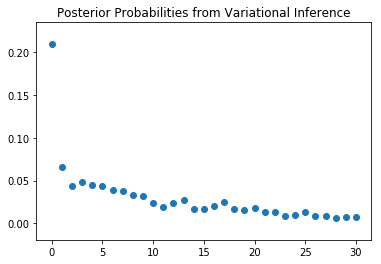

In [22]:
plt.scatter([x for x in range (31)], post_prob_VI)
plt.title('Posterior Probabilities from Variational Inference')
plt.show()

We can also do posterior predictive checks. The simplest PPC works by applying a test statistic on new data generated from the posterior predictive $T(X_{new})$.
Applying $T(X_{new})$ to new data over many data replications induces a distribution. We compare this distribution to the test statistic on the real data $T(X)$.

In [23]:
post_prob = np.concatenate((post_prob_VI, [1 - np.sum(post_prob_VI)]))
T_X = np.zeros(100)
for i in range (100):
    X = np.argmax(np.random.multinomial(1, post_prob, size = N), axis = 1)
    X = [x for x in X if x <= 30]
    T_X[i] = np.percentile(X, 75)

We see that the new datasets generated from the variational posterior distributions are somewhat different from our original dataset.

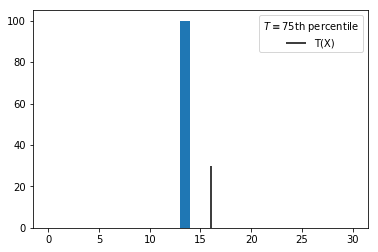

In [24]:
plt.hist(T_X, bins = range(31))
plt.vlines(np.percentile(delay, 75), ymin = 0, ymax = 30, label = 'T(X)')
plt.legend(title = r'$T \equiv$75th percentile')
plt.show()

We can also use the trained posteriors as proposals for the Metropolis Hastings algorithm. But we see that the acceptance rate is almost always $0$, so it also shows that our variational posteriors are not very good.

In [25]:
#MCMC - Metropolis Hastings
T = 500  # number of MCMC samples
qpi_MH = Empirical(tf.get_variable("qpi_MH/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_MH = Empirical(tf.get_variable("qlam_MH/params", [T, K], initializer = tf.zeros_initializer()))

inference = ed.MetropolisHastings({pi: qpi_MH, lam: qlam_MH}, {pi: qpi, lam: qlam}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qlam_MH.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 5481s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 10/500 [  2%]                                ETA: 3577s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]

Inferred cluster means:
[0. 0. 0. 0.]
 20/500 [  4%] █                              ETA: 1752s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 25/500 [  5%] █                              ETA: 1387s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 30/500 [  6%] █                              ETA: 1144s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 35/500 [  7%] ██                             ETA: 971s | Acceptance Rate: 0.000 
Inferred cluster means:
[0. 0. 0. 0.]
 40/500 [  8%] ██                             ETA: 840s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 45/500 [  9%] ██                             ETA: 739s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
 50

355/500 [ 71%] █████████████████████          ETA: 30s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
360/500 [ 72%] █████████████████████          ETA: 28s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
365/500 [ 73%] █████████████████████          ETA: 27s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
370/500 [ 74%] ██████████████████████         ETA: 26s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
375/500 [ 75%] ██████████████████████         ETA: 24s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
380/500 [ 76%] ██████████████████████         ETA: 23s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
385/500 [ 77%] ███████████████████████        ETA: 22s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
390/500 [ 78%] ███████████████████████        ETA: 21s | Acceptance Rate: 0.000
Inferred cluster means:
[0. 0. 0. 0.]
395/500 [ 79%] ███████████████████████        ETA: 19s |

$\LARGE \mathbf {Better\; Inference}$

Fortunately, we see that if we use a Dirichlet prior for $p's$ and Gamma priors for $\lambda's$, then the sampling steps are readily found to be:
$$\begin{align*}
z_{ik}\sim & Multinomial(1,w_{i1},...,w_{iK}),\quad i=1,...,N,\quad k=1,...,K\\
 & where\quad w_{ik}=\frac{p_{k}f(X_{i}|\lambda_{k})}{f(X_{i})},\quad k=1,...,K\\
p\sim & Dirichlet(d_{1}+\sum_{i=1}^{N}w_{i1},...,d_{K}+\sum_{i=1}^{N}w_{iK})\\
\lambda_{k}\sim & Gamma(a+\sum_{i=1}^{N}z_{ik}X_{i},b+\sum_{i=1}^{N}z_{ik})I(\lambda_{k-1},\lambda_{k+1}),\quad k=1,...,K
\end{align*}$$
So we can now implement Gibbs sampling.

In [26]:
#MCMC - Gibbs
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_Gibbs = Empirical(tf.get_variable("qpi_Gibbs/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_Gibbs = Empirical(tf.get_variable("qlam_Gibbs/params", [T, K], initializer = tf.zeros_initializer()))
qz_Gibbs = Empirical(tf.get_variable("qz_Gibbs/params", [T, N], initializer = tf.zeros_initializer(), dtype = tf.int32))

inference = ed.Gibbs({pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qlam_Gibbs.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 20465s | Acceptance Rate: 1.000
Inferred cluster means:
[15.954382   1.3460901  7.4449177 14.156258 ]
 10/500 [  2%]                                ETA: 11359s | Acceptance Rate: 1.000
Inferred cluster means:
[18.284737    0.82677543  6.7257     15.412528  ]
 15/500 [  3%]                                ETA: 7731s | Acceptance Rate: 1.000 
Inferred cluster means:
[19.093006   0.6846873  6.6386867 15.251436 ]
 20/500 [  4%] █                              ETA: 5941s | Acceptance Rate: 1.000
Inferred cluster means:
[19.500023   0.6222942  6.6298895 14.922765 ]
 25/500 [  5%] █                              ETA: 4844s | Acceptance Rate: 1.000
Inferred cluster means:
[19.747744   0.5873199  6.6338177 14.425561 ]
 30/500 [  6%] █                              ETA: 4109s | Acceptance Rate: 1.000
Inferred cluster means:
[19.91472    0.5650396  6.640853  14.20813  ]
 35/500 [  7%] ██                             ETA: 3591s | Acceptance Rate: 1.000

Since we don't have to marginalize out $z's$ anymore, we can use the posterior distributions of $z's$ to predict which cluster each element belongs to. In contrast to the EM algorithm, the clusters are no longer clear-cut, and each data point has certain probabilities of belonging to two adjacent clusters.

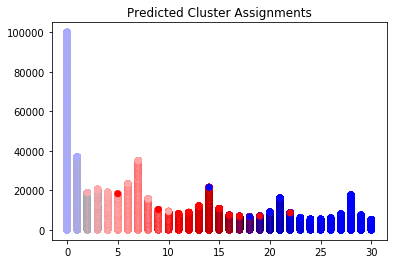

In [27]:
y = np.zeros(N)
for i in range (31):
    indices = [j for j, x in enumerate(delay) if x == i]
    values = [j for j in range (len(indices))]
    y[indices] = values
clusters = qz_Gibbs.sample().eval()
plt.scatter(delay, y, c = clusters, cmap = cm.bwr)
plt.title("Predicted Cluster Assignments")
plt.show()

$\LARGE \mathbf {Criticism\; Again}$

We can use Edward to calculate the log-likelihood.

In [28]:
x_post = ed.copy(x, {pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs})
ed.evaluate('log_likelihood', data = {x_post: delay})

-11.841333

Since AIC is the same, we can again calculate DIC, WAIC and lppd. Compared to the information criteria we calculated previously for variational inference, we see that Gibbs sampling provides better inference.

In [29]:
DIC_Gibbs, WAIC_Gibbs, lppd_Gibbs, post_prob_Gibbs = info_crit(qpi_Gibbs, qlam_Gibbs)
print('DIC: ', DIC_Gibbs)
print('WAIC: ', WAIC_Gibbs)
print('lppd:', lppd_Gibbs)

DIC:  3119918.4424740416
WAIC:  3124957.895362434
lppd: -1548458.7102101971


We can again plot the posterior probabilities calculated through sampling from the posterior distributions. It's still not exactly like the histogram of the dataset, but it looks better than the plot from variational inference.

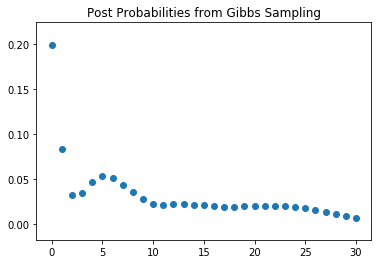

In [30]:
plt.scatter([x for x in range (31)], post_prob_Gibbs)
plt.title('Post Probabilities from Gibbs Sampling')
plt.show()

And we can do posterior predictive checks directly with Edward. And we see that the new datasets generated by sampling $p's$ and $\lambda's$ from the results of using Gibbs are quite similar to our original dataset.

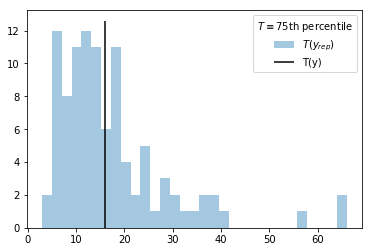

In [ ]:
x_post = ed.copy(x, {pi: qpi_Gibbs, lam: qlam_Gibbs, z: qz_Gibbs})
y_rep, y = ed.ppc(lambda xs, zs: tf.contrib.distributions.percentile(xs[x_post], q = 75), data = {x_post: delay})
ed.ppc_stat_hist_plot(y[0], y_rep, stat_name = r'$T \equiv$75th percentile', bins = 31)
plt.show()

$\LARGE \mathbf {Changing\; K}$

We can check if the model is better if we have one more or one less cluster. We start with having $5$ clusters instead of $4$. We run Gibbs sampling and do some ppc.

In [ ]:
K = 5
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_5 = Empirical(tf.get_variable("qpi_5/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_5 = Empirical(tf.get_variable("qlam_5/params", [T, K], initializer = tf.zeros_initializer()))
qz_5 = Empirical(tf.get_variable("qz_5/params", [T, N], initializer = tf.zeros_initializer(), dtype = tf.int32))

inference = ed.Gibbs({pi: qpi_5, lam: qlam_5, z: qz_5}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    inference.update()

print('mixing proportion: ', qpi_5.mean().eval())
print('cluster mean: ', qlam_5.mean().eval())

x_post = ed.copy(x, {pi: qpi_5, lam: qlam_5, z: qz_5})
ed.evaluate('log_likelihood', data = {x_post: delay})   

DIC_5, WAIC_5, lppd_5, post_prob_5 = info_crit(qpi_5, qlam_5)
print('DIC: ', DIC_5)
print('WAIC: ', WAIC_5)
print('lppd:', lppd_5)

mixing proportion:  [0.21715134 0.29858968 0.17881152 0.22169061 0.08375687]
cluster mean:  [ 0.63945085  5.7652926  13.478778   23.452253    0.03730417]


We see that although the information criteria are pretty close to that from $4$ clusters, two of the cluster means now are very close and the rest are pretty much the same as before. So it's probably not a better model. We can also do the same for $3$ clusters.

In [ ]:
K = 3
pi = Dirichlet(tf.ones(K))
lam = Gamma(1.0, 0.1, sample_shape = K)
x = ParamMixture(pi, {'rate': lam}, Poisson, sample_shape = N)
z = x.cat

qpi_3 = Empirical(tf.get_variable("qpi_3/params", [T, K], initializer = tf.constant_initializer(1.0 / K)))
qlam_3 = Empirical(tf.get_variable("qlam_3/params", [T, K], initializer = tf.zeros_initializer()))
qz_3 = Empirical(tf.get_variable("qz_3/params", [T, N], initializer = tf.zeros_initializer(), dtype = tf.int32))

inference = ed.Gibbs({pi: qpi_3, lam: qlam_3, z: qz_3}, data = {x: delay})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    inference.update()

print('mixing proportion: ', qpi_3.mean().eval())
print('cluster mean: ', qlam_3.mean().eval())

x_post = ed.copy(x, {pi: qpi_3, lam: qlam_3, z: qz_3})
ed.evaluate('log_likelihood', data = {x_post: delay})   

DIC_3, WAIC_3, lppd_3, post_prob_3 = info_crit(qpi_3, qlam_3)
print('DIC: ', DIC_3)
print('WAIC: ', WAIC_3)
print('lppd:', lppd_3)